In [1]:
import logging
import pandas as pd
import numpy as np
import jieba
import random
from gensim.models import word2vec

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

# w2v

## split data

In [39]:
# Loading dataset
train = pd.read_csv('train.csv')
train
val = pd.read_csv('validation.csv')
val

,Content,Label
0,我有個國小認識的好朋友，上了大學後常常會跟我訴苦，大多是關於人際關係的他個性比較內向，不容易...,0
1,(第一人稱視角，)媽媽跟爸爸從我出生就感情不好 所以國小時離婚了我喜歡媽媽 不喜歡爸爸但我們...,1
2,我的前任在自殺前一周突然幫我慶生，一天前找我出門玩，再一聲不吭的自我了斷，給我很大的陰影。現...,0
3,身為一個亞斯伯格症的人看到這則新聞還蠻難過的首先我可以理解家長看到自己小孩無緣無故被攻擊而想...,0
4,真的很長，防雷。26個年頭來，經歷了大小事情。媽媽在國小開始因為經濟不景氣、收店的壓力、被朋...,0
...,...,...
402,請問吞藥自殺比較好呢？還是上吊？還是割脘呢？,1
403,到底要有多深的自我厭惡，才會夢到自傷、自殺？前幾天我做了一個夢，我覺得是近期做過最糟糕的夢了...,1
404,人總有過想死的念頭。有人說過如果你沒有想死過，那代表你沒真正活過。「呸呸呸，亂講話」當自己的...,1
405,這些年來過的生活都一樣沒有上課的時間都是待在家裡直到現在要畢業了也都差不多對任何事情也都無感...,1


In [4]:
## 取200筆非自殺
# train_neg = train[train["Label"] == 0].iloc[:200]
# train_pos = train[train["Label"] == 1]
# train = pd.concat([train_neg,train_pos])
# train = train.reset_index(drop=True)
# train

In [40]:
total = pd.concat([train, val])
total = total.reset_index(drop=True)
total_0 = total[total["Label"] == 0]
total_1 = total[total["Label"] == 1]
total_1

,Content,Label
11,不知道為什麼最近一直很想上吊可能是找不到工作可能是人際讓我不行可能是學業上的困難不知道欸感覺...,1
17,我四月~八月都處於超憂鬱的狀態一直有想死的念頭但八月開始，我一直處於很興奮的狀態，也不較不會...,1
25,十年了已經不知道吃了多少要跟換過多少醫生朋友都從身邊離去被趕出家庭什麼都沒了每天吃的藥多到不...,1
38,前幾天有試過離開但可能方法不對吧感覺還是會有痛苦存在突然有點羨幕那種在睡夢中昏迷且死亡的--...,1
55,活著好累，著手計畫一切，五個月，把所有痛苦不甘一次解決現在的人到底還有誰有著夢想，其實我們出...,1
...,...,...
1757,請問吞藥自殺比較好呢？還是上吊？還是割脘呢？,1
1758,到底要有多深的自我厭惡，才會夢到自傷、自殺？前幾天我做了一個夢，我覺得是近期做過最糟糕的夢了...,1
1759,人總有過想死的念頭。有人說過如果你沒有想死過，那代表你沒真正活過。「呸呸呸，亂講話」當自己的...,1
1760,這些年來過的生活都一樣沒有上課的時間都是待在家裡直到現在要畢業了也都差不多對任何事情也都無感...,1


In [13]:
# Label_1
num_1 = total_1.shape[0]
random_1 = random.sample(range(num_1), num_1)
train_1 = total_1.iloc[random_1[:207]]
test_1 = total_1.iloc[random_1[207:295]]
# Label_0
num_0 = total_0.shape[0]
random_0 = random.sample(range(num_0), num_0)
train_0 = total_0.iloc[random_0[:210]]
test_0 = total_0.iloc[random_0[210:300]]
# train_val_1
train_val_1 = train_1.shape[0]
random_train_val = random.sample(range(train_val_1), train_val_1)
train__1 = train_1.iloc[random_train_val[:186]]
val_1 = train_1.iloc[random_train_val[186:207]]
# train_val_0
train_val_0 = train_0.shape[0]
random_train_val = random.sample(range(train_val_0), train_val_0)
train__0 = train_0.iloc[random_train_val[:189]]
val_0 = train_0.iloc[random_train_val[189:210]]
# train_val
train = pd.concat([train__1, train__0])
train = train.reset_index(drop=True)
val = pd.concat([val_1, val_0])
val = val.reset_index(drop=True)
# test
test = pd.concat([test_1, test_0])
test = test.reset_index(drop=True)

In [46]:
train

,Content,Label
0,仙草加蜂蜜好好吃！等下再去市場買一塊大仙草~吃吃吃好像把今天的熱量扣打吃完了-----Sen...,0
1,啊啊啊 邁入老女人的里程碑了今天本來想請假的但被同事搶先了然後從禮拜六開始爸爸媽媽就滿滿的情...,0
2,今天同事提出，覺得我有點過度依賴男友了不是第一個人說出這個問題其實早在交往的一開始我自己就察...,0
3,開始停速悅的這幾天我還是會吃安立平總覺得現在除了心悸手抖頭很重以外一直還有個在耳邊敲打小軍鼓...,0
4,我覺得有些善意的謊言是可以說的就是那些不會被揭穿的但有一些是一定會被揭穿「你狀態不好的時侯可...,0
...,...,...
1350,是真的痛暈暈的痛喝酒後會痛所以我從不喝也因此不吃薑母鴨跟燒酒雞酒製品唯一會吃紅糟肉那些但濃一...,0
1351,昨天晚上睡不著，手之前被蚊子咬好癢，一直抓，起來擦藥發現都被我抓傷了，紅紅一點一點。鼻頭不小...,0
1352,幾乎天天做夢耶 這樣正常嗎應該是不正常的吧夢到上去一台公車帶著我家的狗從陌生地方下站 漫無目...,0
1353,在BG推文時有個鄉民寫信給我想幫我什麼看了一下大概猜的出是條件蠻好的一個男生一時不知是喜是悲...,0


## Use the same data with BERT

In [61]:
t = [['每天都不斷的想自我了解不知道自己是為什麼活著怕親人受不住怕毛孩年事已高一直期盼著睡著的那天到來大家是為了什麼才撐到現在的？--好難過想結束但怕周遭的親人很不想醒來好久沒看了你好棒我敢但又被絆著這樣很好我也有點怕失敗（拍拍這樣也挺好的方法很多但我不知道該用什麼我為了寵物，但快撐不住了', 1], ['該結束嗎該結束這一切嗎這一切該結果結束結果結束結果出生的那一刻我就不知道活著意義可以結束嗎--', 1], ['我是去年剛從後段大學畢業的學生由於學歷沒有很好在今年2月底之前都做著打工性質的工作好不容易今年2月進了一家新竹的科技公司薪水開始慢慢的穩定也漸漸的能平衡收支結果某一個假日媽媽就突然打電話來她說：可憐喔，星期六還要上班，真可悲。啊那個我說，妳不要以為你母親節有回家，我就會饒過妳，我的母親節禮物呢？我現在跟你說，我要最新的那台Iphone 256G的，你現在知道該怎麼做了吧！我跟你講，自己想清楚，你外婆跟我要東西我從來沒有沒給過，我都會想辦法生出來，自己想清楚！由於我真的不想跟我媽吵架所以冷處理幾天後我傳了以下訊息給她然後這是她的回覆我真的不知道該怎麼辦從小我媽媽就是說一就是一的人她完全沒有討論的空間只要不順她的意她就會打我、亂剪我頭髮、把我關門外後來長大一點之後就開始動不動用她要自殺威脅我大學時期，我以為我好不容易逃離了結果她動不動就搭飛機突然來到我宿舍一樓大三時，我嘗試自殺好朋友帶去醫院我被診斷出重度憂鬱症當媽媽知道後我媽媽說因為是她生了我，所以我是她的，死也要死在她手上我一定只是害怕她責罰，所以才演戲裝病出社會後，我想說自己出來外面闖，把距離隔開應該就沒事了。結果她各種哭說我不肖，逼我回家然後用各種方式在跟我要錢還說什麼以前他們的年代薪水都是全部繳給父母沒看過我這種的，還要人跟我要我真的已經不知道該怎麼和我這個媽媽相處了', 1], ['轉眼間半年過去了我已經很努力的活著了，不論是過去、還是現在但是當我期望會更好時，等待我的卻只有無盡的失望當我屢屢覺得有希望時，現實卻總是往往讓我陷入絕望是不是不該在催眠自己會更好了...?原本是一個很開朗、快樂且被朋友評為很嗨的男孩但是面對一連串接踵而來的殘酷打擊絕望宛如排山倒海般的向我襲來，心理猶如烏雲密布一般負面情緒一擁而上，覺得自己很沒價值、自卑、活得好痛苦很空虛還是說這些情緒其實只是一直藏在心裡只是如今因為這些事情作為導火線而引爆了現在這種情況?其實我小時候就有被診斷出小兒自閉雖然記憶中兒時並沒有什麼生活上的不便(也可能是忘了)但唯有幾個點是我記得很清楚的像是比較嚴重的溝通及互動障礙、容易把自己關在一個迴圈內以前就很常被同學說「都不說話，安靜得很恐怖」而母親也有帶我去做早療，而在小學時也做了不少訓練和輔導而在變得能和正常人一般互動之後，我也繼續努力為了擺脫以前那個不擅於表達、陰沉的自己拼命融入各式各樣的人群、學習如何表達才會讓人覺得自己很有趣如今卻又因為現實的殘酷將我打回那伸手不見五指的深淵從今年初開始就發生了不少爛事情，讓我心情愈來愈不是滋味但當心情差到逐漸的影響生活，失眠、沒食慾、不受控的一直亂想難過之後真的受不了自己一人跑去看醫生，結果是憂鬱症醫生告訴我不要把事情都悶在心裡，找信任的親友或家人聊都可以但可能是因為家庭因素，自己其實是個很壓抑、較注重他人感受的人當時覺得一旦講出來就會給摯友壓力、牽連他們，不該散播負面情緒給他們那些摯友在我得憂鬱症之前很少吵架，我們4個就形同手足一般因此我當時下了一個決定:「絕對不能把憂鬱症的事情告訴你們，就算是為了維護這段友情也好」開學第一個禮拜去了學校，大家只是覺得我為什麼都不講話、突然好安靜本來想就這樣把摯友們推開，在保住友情的情況下小心翼翼的互動就好但那周末，摯友A主動密我，他看出了我的不尋常，前來關心我他告訴我「有兄弟在好嗎」「你不行的話背後永遠有我們」那時只是在手機螢幕面前卻感到了無盡的溫暖淚腺失控的如雨一般的傾注而下當時我覺得，會不會講出來才是勇敢面對，相信摯友會陪我度過難關於是就把憂鬱症這件事情告訴了三位最信賴的摯友他們當時不嫌棄的接納我、關懷我，有個能走出來的出口我真的很感動在我低潮、甚至想自殺時，都是他們將我拉了回來跟他們在一起的每一刻我都覺得，有他們陪伴的感覺真好但事實證明我錯得離譜，我不應該擅自定義摯友的定位有一天與摯友A聊天聊到一半，聊著突然就爆發了，說我在他身旁只會有滿滿的壓力而摯友B卻拿莫名其妙的小事來攻擊我，甚至拒絕溝通，完全不同理摯友C則是比較平淡的那種類型，也不知道他是怎麼想的......我覺得很後悔也很自責，如果沒告訴他們是不是舊不會這樣了明明是你們告訴我說出來沒關係的我們會在你身邊的結果卻又自私的離開，捨棄了三年的友情一次次的求救訊號被漠視，讓我的自殺念頭更加強烈狠心放我一個人悶著痛苦真的是摯友會做的事嗎當了摯友三年，沒想到你們這麼不願意同理我我想要的明明只是陪伴而已啊⋯⋯我也不是刻意要將自己頭上的烏雲合理化的在他人頭上降雨我也明白這樣會讓他們有壓力，當時也有問他對我的看法他們也只說是比較需要陪伴的朋友而已可是如今卻變成這樣⋯⋯是不是當初不說出來，就不會發生這些事了世界不可能有完全的感同身受我忘記了人性都是自私且沒同理心的只是覺得如果友情就這樣沒了，那我在他們眼裡還真一點份量也沒有他們以前還會強調「我們感情都比其他群好」「誰跟那群就是因為沒那麼好才轉去夜校」「如果你是像誰一樣的風雲人物的話就不會遇到我們這些摯友」之類的話所以我一直深信他們會陪伴我度過這個難關，但事實卻並非如此我明明也為了陪伴我的摯友們，很努力的看醫生吃藥了他們封鎖我所有社交軟體、mail也沒看、手機更是不接我甚至開始懷疑他們是為了利用我才來關心我的或許他們根本沒辦法接受我有憂鬱症，等到時機成熟就把我踢掉但仔細想想，會不會是因為他們沒辦法負荷我心裡的憂鬱，所以為了自保而離開呢?我是不是不應該把自己的心事滔滔不絕的說給你們聽讓自己悶著，繼續一人難過就好了⋯⋯明天就是摯友A的生日了，自大學以來每年都是一起過的，想到就難過......不知道你看不看得到這篇，但還是祝你生日快樂當我失去一切迫切想自殺時，想起摯友A曾經跟我說過的向家人打開心扉因為家庭因素使我一直很不信任我的家人，但在走投無路之際，真的別無選擇而最近也是慢慢地與家人解開心結，他們也算是很關心我本來擁有強烈的自殺念頭，就暫且這樣擱住了或許能撐到今天是因為我還相信自己能比以前快樂我還相信摯友在等我回去儘管這些想法很天真無知為了回到摯友的身邊、為了找回快樂的自己我也已經很努力地面對憂鬱症了看醫生、吃藥、忍受藥帶來的副作用必須忍著憂鬱症污名化的情況下龐然帶來的眼光必須忍著不能自殺不能傷害別人但也因為這樣只有自己一人痛苦到極點最後卻連三年來的摯友都賠掉了為什麼你們不願意多看見我的努力繼續撐下去真的會比較好嗎...?「花若盛開，蝴蝶自來」家人是這樣告訴我的只要我從無法自拔的憂鬱走出來，摯友真的就會回來嗎?只要我繼續活下去，我就能找回以前那個快樂的我嗎?只要我繼續努力下去，我就能變成獨一無二的人嗎?這些充滿希望的話語是真的嗎還是其實這也是欺騙自己的謊言罷了就跟以前覺得有希望卻屢遭絕望打擊一樣我不知道該相信哪一個才好，應該要繼續撐下去嗎?', 1], ['昨天掙扎很久活下來之後今天睡飽滿滿的死意又出現了滿滿的光是一點不愉快就會渲染成一片黑池更何況是情感上的背刺我只能恨著自己如此沒用我好恨-----Sent from JPTT on my iPhone--', 1], ['把自己關在一片漆黑的房間裡 全身沒有力氣 忍受不了的痛苦只能靠哭泣和尖叫發洩夢裡跟現實好像也沒有差別 一樣像瘋子一樣發洩(只是我有力氣打人了:)) 這樣的情況真的連要結束自己都不容易我不知道悲傷從何而來 我覺得我就像一具有意識的屍體 我真希望現在立刻有人能結束我的意識--', 1], ['又開始失眠。尿道炎也又復發了。深刻的覺得自己沒用。藥也吃回fm2，明明給自己的底線是不要再吃回fm2的。人生好難，渾渾噩噩的走過每一個想離開的時候。但什麼時候會走不下去呢，我也不曉得。想像一隻貓，躲起來，靜靜的離開。--什麼遺失物XD', 1], ['今天剛結局就想趁還有感觸時來介紹，只是我的文章不知不覺就打太長了⋯請見諒我太搞威😂（順便抱怨一下大結局等更新等好久⋯而且有點草率⋯後繼無力，就突然感覺沒了！結局！）-🔍《以家人之名》（英語：Go Ahead），是2020年中國大陸電視劇。由水阡墨、王雄成編劇、丁梓光執導，譚松韻、宋威龍領銜主演，張新成特別出演，塗松岩、孫銥、何瑞賢、安戈主演，張晞臨、楊童舒友情出演。該劇於2019年9月16日開機，12月29日殺青。 2020年8月10日於湖南衛視首播。（取自維基百科）-🗣個人心得與感想：首先想說說看的原因，其實那時候熱播中我正在看韓劇😂，沒什麼特別注意，儘管討論度再高但沒有我特別喜歡的演員，我很少會首先拿出來看，但偏偏就有張新成😻😻😻。（本哥我先跟您反省，舊時光我一直忘記把最後看完⋯）再來劇情的部分我覺得前面節奏很明快，但後面開始就有點拖⋯尤其是把焦點一直放在上一輩，當然這我接受！因為要不是上一輩的恩怨，哪有兩位可憐到不行的男角色⋯（哭瘋）。只是我不太喜歡主線已經有點拖沓了，還把焦點放在支線角色的戀愛，Ex唐燦與學長（我印象還停留在《我只喜歡你》默默的親戚😂，而且劇裡面學姐和周淼還唱主題曲，直接懷念XD ），學長先是拒絕後又喜歡上，好沒關係！但最後也沒給他們什麼清楚的譜啊⋯⋯有點問號😂😂至於人人都吵的愛情線，在看之前就有看過很多文章在吵尖尖情歸何處，但我還是覺得等劇播畢完再來分享我的感覺（因為我覺得角色陰暗面原因還沒形塑明白），而且我絕對無條件張新成⋯不是我說我是小哥派啦🤣🤣🤣觀看過程中，我越來越同意尖尖是凌霄的「救贖」，只是我不太認同一開始凌霄的霸道還有強迫，雖然說子秋也有逼著尖尖和燃分手，但是態度上面沒有像凌霄那麽不可一世。如果不是從小尖尖就特別喜歡凌霄，又或是尖尖不太明白「戀愛」的真正實感，又可能子秋對尖尖的感情如果是真的愛情的話，那麽凌霄不可能這麼順利和尖尖在一起，過往的偷親也不會那樣不了了之，反而還會引來尷尬。接著那句「他不接受就不接受，他自己消化」雖然我也覺得有點過分，但其實很明顯的是凌霄在氣頭上，就像子秋因為在氣頭上而說「我不想跟你講話」是一樣的，但兩兄弟儘管吵的這麼兇，罪魁禍首的尖尖一樣成為了潤滑劑，像尖尖對李爸說的「我們內部自己消化」，三個人都是大人甚至是家人，沒有什麼是說不開的。那接著我想用「最喜歡的三個角色」繼續分享：🥇李海潮（李爸）爛好人一個，如果是我可能沒有那個胸襟和錢，撫養不是自己的孩子。但如果不是他，凌爸無法安心的去上班、回家有熱騰騰的飯菜可以吃；尖尖不會長成人見人愛的孩子；子秋與凌霄也不會得到原生家庭裡得不到的溫暖。裡面角色看似最幸福的是李爸沒錯，可是換個角度來看，他也是最不求回報，也是最憋屈的。靠著料理將溫暖帶給每一位願意走進他小麵館的人，無論是孩子還是小狗，他都一視同仁，但卻在這幾十年拉拔孩子長大的歲月裡，要看著孩子被親戚數落（喝酒突然爆發大哭碎念的那段眼眶都被逼淚了⋯）、自己總被耳語灼傷，又或是幫不上孩子的忙，真的只能說一句：李爸辛苦你了！🥈李尖尖其實本來第一名要給子秋（畢竟張新成^^）的，後來覺得李爸才是實至名歸！想著那第二名給子秋了，結果在下一秒覺得要頒給李尖尖，雖然她和凌霄在一起的時候我傻眼也很無言（在一開始啦），但後面看著她不斷的忍受難過，就為了要給家人、朋友甚至是工作夥伴的學姊打氣，就覺得她很不容易，一個小小身軀中隱藏了這麼多的力量，即使油耗盡了，也努力帶給別人快樂！當然如果不是因為李爸的開明，讓她擁有兩個疼愛她的哥哥，才能讓她長成這麼可愛的開心果。但，她真的是只是被動接受嗎？如果沒有尖尖的死纏爛打，凌霄不會恢復一點點開朗，只會始終坐在那個冰涼的階梯、餓著肚子聽著父母的咆哮聲看漫畫；如果沒有尖尖理解子秋被嘲笑媽媽遺棄自己的難過，那麽子秋只會在家鄉不停的被親戚數落、用著弱小的身軀扛著比自己還巨大又沈重的竹簍，沒有尖尖，這個家的另外四個人，甚至是朋友們與後來的小橙子，都不會有認同自己能得到幸福的資格。最後再說一點，我覺得尖尖是這三個孩子中成長最多的，當兩位哥哥的離開迫使她成長的時候，她就不再是那個跟著哥哥屁股跑的女孩，而是有自己想法、自己興趣、自己人生觀的獨立女性。（來個還沒嫁進去就稱凌霄為老公的尖尖😂，要是子秋聽到肯定又要發怒了！誰准你嫁！）🥉賀子秋該給張新成了吧！當然！（自問自答的毛病⋯）如果劇情後面沒有將凌霄的痛苦最大化，我真的會頒發最佳苦主獎給賀子秋欸！他一再的被拋棄，明明思念媽媽卻還要裝作不在意，為的只是不讓撫養自己的李爸擔心與難過，當和賀梅打照面的某個橋段，我看著的時候眼眶都泛起了淚。怕版權問題就不放影片，我打出逐字稿：「我只是覺得⋯我只是覺得，我特別特別的丟臉，為什麼每一次被拋棄的都是我，為什麼每一次都是我⋯是我有什麼問題嗎？我一直想、我一直想，我就是想不明白。」「我只是覺得，我不能就這樣回來，憑什麼每次我灰溜溜的，需要回到一個家的時候，都是李尖尖和爸在收留我，所以我必須賺錢啊！我得賺錢回來啊！我要開一個李尖尖最喜歡的咖啡店，櫥窗裡面擺滿她最喜歡的所有甜品，她想吃多少吃多少，怎麼吃都吃不完。」「我要讓所有人都知道，我過得很好，我過的真的很好，我不需要可憐，我不需要看任何人的眼色，我要拼命的賺錢，我要對爸好，我要對李尖尖好，因為我要賺錢，把我所有最好的那些東西，給從來不曾拋棄過我的人。」這一段充分地顯示出了子秋心中所有的不安，真的很讓人心疼，他的不安來自於原生家庭的「不斷背叛與拋棄」，拋棄一次、兩次夠了，已經足以讓他懷疑自己的存在，但是因為媽媽多管閒事而讓自己尊嚴掃地，所有的武裝都被瓦解，他的內心停留在被拋棄的那年，他只有不斷的賺錢回來，像是學成歸國的意氣風發貌，不讓家人擔心，並讓那些流言蜚語看著他的好生活就戛然而止。（李爸&尖尖&凌霄在外頭聽完肯定也難受）所以對於前面所說的感情線，我可以認同尖尖和凌霄之間存在的是愛情，而子秋只是需要一個「戶口本上的關係」或是「親情救贖」，這也許也是他一直汲汲營營於那個被拋棄的真正答案，唯有那個空缺被填滿了，才能與兒時的創傷正式和解。（來點輕鬆的～妹控的賀子秋😂）介紹完最喜歡，再來是最討厭的角色：🥇陳婷（凌霄媽）謝謝～無庸置疑絕對是大家的大魔王吧^^～本來我也不太喜歡小橙子，但後面洗白了（晚點再說），就只好讓陳婷單獨入榜了！（如果圖片版權不合適，再煩告知我會徹除）從頭壞到尾的角色，嗯⋯也不能說壞，就是過於自私的角色，但我覺得她會變成這種模樣，凌爸也要負起責任，因為不斷失去的人會想控制甚至強求別人留下，就是因為每次遇事的時候都不知道如何是好吧⋯可恨之人也必有可憐之處啊⋯在今晚大結局凌爸有自白，當時生芸芸的陳婷已經得到什麼創傷後遺症（沒聽清楚），她已經夠無助了可是他依舊只在乎自己的工作，忽略了妻兒，所以讓陳婷的病情不斷的加劇，加上陳婷個性也比較鑽牛角尖與偏激，或許像凌霄兒時說的，陳婷如果沒有離開，只會讓那個家庭變得更灰暗，因為她都顧不了自己了。（如果圖片版權不合適，再煩告知我會徹除）而生病了沒關係，最為人詬病的還是「沒養過兒子，卻把兒子綁在身邊情緒勒索」，凌霄的情況她一直都知道，只是自欺欺人，更何況凌霄會一直活在「妹妹的死」也是自己害的，明明是自己沈迷打麻將害死了女兒，卻怪罪凌霄讓妹妹吃核桃（不管會不會下地獄我先自清，我第一集聽到吃核桃噎死有點「蛤⋯」的感覺，當然後來知道妹妹年紀很小😂），這不就只是不負責任的逃避嗎？「無助」已經不是藉口了，只是不想承認錯誤，不敢面對。「你為什麼不疼我？」真的差點哭出來，所有人都疼凌霄，但自己的媽媽像是利用、綁架，把自己鎖進將妹妹害死的牢籠裡。明明從小到大沒有替凌霄做過什麼特別像樣的事情，存留在凌霄腦海中的只有不斷的嘶吼咆哮、撕掉全家福、讓吃泡麵、說鄰居的不是，卻要凌霄守在自己身邊，就因為不希望黑歷史被揭穿，自己的傷疤被袒露出來，就像凌霄說的「有些人是自願成為黑洞的，甚至連自己是黑洞都不知道，專門腐蝕別人來壯大自己」，他的媽媽就是這樣的人，看著滿身是傷的孩子卻還是一次又一次的剝奪兒子得到幸福的機會，還自以為是的說著那句「我是為你好」。（拜託陳婷給我去看你的孩子不是你的孩子🙄️）（如果圖片版權不合適，再煩告知我會徹除）然後最後結局還要再搞一齣⋯欸大姐您行行好！我以為你真的開竅了，結果寫遺書去自殺，搞得小女兒哭的不成人形，你沒有忘記自己還有女兒吧！然後被情緒勒索的兒子還要去找你（還找到了！？），我真的不知道應該說什麼了⋯可能是要帶出凌霄怎麼開導媽媽吧⋯（嗯對啦我這樣催眠我自己^^）（如果圖片版權不合適，再煩告知我會徹除）凌霄在我看起來，就是被陳婷搞到十分沒安全感，所以當聽到子秋喜歡尖尖的時候那麽反彈甚至說出氣話，在後來我都還蠻能諒解的，凌霄能活到現在不容易⋯但可能是因為有尖尖一家人的愛，才讓他沒有被像黑洞般的媽媽給吸走，對人生還是有一線光明。（掰惹位⋯小橙子內心陰影應該也蠻大的我覺得⋯）🥈周淼（如果圖片版權不合適，再煩告知我會徹除）也是打著「我是為你好」的名號，實際上就是個吃軟飯的垃圾，連照片都不想放⋯（針對角色不針對演員喔！），從頭到尾根本不是真心愛學姐的（那個「富婆」名稱差點看到吐血）。從頭到尾耍嘴皮子（這形容算客氣了）就算了，瘋狂挑撥李尖尖和學姐，甚至只是一個工讀的，卻總是藉口社團實則聯誼打遊戲，工作都要身為「老闆」的女朋友做🙄️，份內事情做不好也就算了，還異想天開想宣傳工作室，無視另個老闆的個人意願，真的氣到不知道說什麼。🥉馮希希（凌霄同事）（如果圖片版權不合適，再煩告知我會徹除）畢竟要塞滿三個，就給她第三名好了😂雖然最後她給了很大的助攻，讓陳婷理解自己的所作所為帶給兒子多大的心理創傷（雖然陳婷還是不成材唉），但前頭不斷打探凌霄的隱私，就連身為觀眾的我，都覺得有些不舒服。討厭的代表們，為什麼沒有放齊明月或唐燦的媽，他們明明也都是情緒勒索代表，但可能我覺得在他們身上比起過於偏激的陳婷，更會出現在你我的生活裡。尤其是齊明月的媽讓人喘不過氣，強勢就算了還勢利，而唐燦的媽看似非常虛榮，但仔細想一想在求學過程中，哪一個媽媽不是求好心切，哪一位不會說「我是為你好」，像我自己小時候可能也會覺得父母總是將自己和其他同學比來比去的，壓力甚大。長大後才發現，父母的心思我們不明白，當我們過了辦家家的年紀，才發現撐起一個家並不容易，那些曾經對父母行為的不諒解，那些包裹著虛榮實則擔心的言語，終於或多或少能體認一些。或許因為我是屬於唐燦性格的，為自己的權利捍衛到底，所以不像月亮那樣擁有太多遺憾，但相對的我吃父母的毒打也多、自己碰撞的悶虧也多，遇到後悔不能怪罪父母，只能自己負起責任，但我們還是會希望即使如此，也能像月亮口中所說的「我要自己去坑、去跌倒」，因為這是我們的人生，我想要自己做選擇。當然雖然父母都是為我們好，但像是劇情裡的媽媽有些為了控制或為了自己私慾而過於偏激時，我也是不能接受的就是了，所以那些例外😂😂例行的同場加映：（以下如圖片版權不合適，再煩告知我會徹除）從頭到尾失職到不行的爸爸😂，但後面讓我漸漸改觀，雖然還是以局裡要事為首，但慢慢的發現兒子的心理狀態，以笨拙的方式表達關心，只要有利於兒子，他都願意支持並且保護。（整劇裡最帥的大概是打電話罵陳婷舅舅？😂）兒子從一開始什麼都悶在心裡，漸漸的會說出口，並且視爸爸為依靠，爸爸什麼都不用做，只要靜靜待著，凌霄就會感到安心。父子從生疏到親近的過程很可愛，也開始會說出以前從未說出口的內心話，甚至說出了對彼此的愛。掰惹位，凌霄那句「我是不是都還清了」真心疼，陳婷你讓這孩子多辛苦你看看！😭另外也喜歡凌爸和李爸相依陪伴，這一開始讓我想到台劇的《兩個爸爸》，但兩者又差別很多。可能我都是喜歡這樣互補的性格角色，如果沒有李爸那麼凌爸可能生活會一塌糊塗；如果沒有凌爸那麽李爸可能找不到人碎碎念，兩人是生命共同體，一起陪著孩子長大、吐露最深層的心事，兩人還相約去養老院真的好可愛喔！凌霄太過悶葫蘆不是我的菜，一開始儘管對於他追求尖尖的方式不認同，但畢竟很多粉紅泡泡都是這樣來的嘛！SOP啦！！！而且要不是他這一出擊，遲鈍的尖尖可能到七老八十都不知道戀愛是什麼。而雖然悶著不說，甚至常常和子秋鬧性子，但無論如何，他都是兩位弟妹的哥哥，一有事情絕對會幫忙，甚至在知道子秋人生的委屈時，也不吝嗇讓女朋友去陪伴，嘴上不說但做的比誰都勤，很貼心、不邀功還會耍點惡作劇，根本腹黑😂（好喜歡他和子秋兩人相處的畫面，當然不是指吵架的時候啦^^）子秋和尖尖老是結伴做壞事真的好可愛🤣（腦中浮現凌霄吃醋的時候說他們都不帶著他一起XD），當然言歸正傳，回到賀梅和老李！！！賀梅也不容易就不多說了，至少她知道應該要彌補子秋的傷痛，明明想念兒子卻為了莫名奇妙的偏執而不敢見，只敢默默守著遠方，果然是母子！後來兩人解開誤會真的好開心！看看那個在心塞的尖尖還有凌霄眼前放肆的子秋，果然有媽的孩子像個寶，搞得旁人哭笑不得😂😂而開導賀梅的關鍵就是老李！賀梅解決了與兒子的問題延續20年前未完成的姻緣，在高級的擊退張老師後，還是抱得老李歸了(?)，讓這個家庭更為圓滿，也開啟了一連串老李的可愛屬性🤣💕（真心快笑死～有夠38的XD ）小時候很討厭的性格，長大也沒什麼變，但我覺得很大的原因來自陳婷，就連那句「他們都討厭我」幾乎也是媽媽洗腦而來的。長大後的水果妹在凌霄的回憶中我們發現，她其實很善良，也是最看透這個家的成員，她受到的陰影不亞於凌霄，在那麼小的年紀裡經歷那麼多可怕的畫面，之所以像刺蝟般的性格也是因為不想被看穿，甚至周遭除了媽媽與哥哥外，沒有其他能夠長期灌溉愛在她身上的成員，直到接觸了子秋、尖尖，慢慢發現外面世界的好，不再限縮於媽媽打造的那個虛假空間。所以這也是我覺得她洗白的原因啦！😂不讓哥哥走也是情有可原的，內心如此無助也還是個孩子，最基本的禮貌也沒有人能教她，被罵才會乖才會感受到被關心，所以才會這麼黏著子秋啊！學姐出場的時候真的覺得她好漂亮！然後她給我在垃圾桶裡找男朋友？？？？？雖然有預感最後她一定會站在尖尖這邊，但還是希望學姐多磨練自己的眼光，不要被戀愛腦左右了，要不是尖尖忍耐力夠強，周淼早就不知道被打飛出去幾次了😂可憐又可愛的燃，一開始還真以為是變態，結果出場是這麼清秀的小伙子，一開始遭遇兩個哥哥的攻擊，還不計前嫌，也適時的替尖尖認清感情的不同，最後還幫了尖尖一把啊！！🥰很意外的組合，但也是很可愛的組合，緣分很奇妙總是能把意想不到的人帶到身邊，就這樣陪伴你數十年的時光，就像這群真心為彼此著想的閨蜜，儘管每個人都有自己發瘋的時刻，答案其他兩個人會一直在這裡守候與陪伴，連同你的家人一起照顧！唐燦有戲的很可愛，可是我比較想特別提及齊明月，聽說齊明月的角色後來出來的時候常被網友說是「加戲」，亦即太多餘（聽說這演員之前也遇過一樣的狀況）。但我卻覺得不多餘，因為月亮很真，只是過於自卑，而面對感情時雖然在上帝視角的我們會覺得自作多情，甚至還親了凌霄實在太扯，但對於月亮的角度來說，凌霄像是真的關心妹妹一般關心尖尖，而除了尖尖以外唯一有聯繫的女生只有自己，加上凌霄也一直沒有察覺到（或是都被告白了不知道怎麼向月亮拒絕），我倒覺得月亮的反應是合理的，而且也沒有死纏爛打，只是因為自己太丟臉才想切割的，所以並不會討厭她😂。再來就是她和媽媽的攻防戰，雖然最後跟媽媽說「我錯了」讓很多人不能接受（包括我），但其實為了自己的選擇做決定沒有錯，可用了傷害父母的方式，我覺得她那句道歉並不是認為自己的夢想錯了，而是「執行」夢想的方式錯了，她和媽媽的那個橋段，彷彿看到我和我媽一樣，所以感觸特別深😂，因為我也是從小屬於那種先做了再說，包括刺青也是，做了就做了你就打我啊！你能拿我怎麼辦那種！但就如同月亮一樣在某個時刻長大了就覺得很不成熟～果然小時候老師說，以前傷透父母心的行為，未來都會一點一滴得補回來，果然沒錯，我現在就是，乖到不行XD很喜歡三位主角的互相陪伴，選角也好可愛喔！尤其是飾演凌霄童年的童星，神韻很像！！！然後長大版也很會選，譚松韻完全看不出來30歲了⋯然後張新成25歲，宋威龍才21歲⋯天啊😂在看他們三位彼此相愛相殺的日常時，莫名讓我想到《雖然是精神病但沒關係》的三位角色，可能是因為前不久剛播完，又或者是角色關係很相似，而且最主要的是，每位角色在經歷難過時，另外兩位就會放下手上的事情，飛奔而去，彼此一同成長，知根知底，知道對方的軟肋，做對方最堅強的後盾（凌霄請假、尖尖跑出工作室，兩人跑去樹蔭底下找子秋那段很窩心）。不知道是不是還有什麼想講卻沒有講到的（講完了沒⋯打這麼多了^^），但很喜歡這樣平凡的故事中帶出不平凡的情節，很溫暖當然偶爾也好諷刺，無血緣的三個善良孩子成為了彼此互相扶持的家人，但各自都有自己的原生家庭需要面對。在這樣的過程中，總能夠在一瞬間讓眼淚爬上了眼眶，卻又在某些時刻心疼起角色的際遇，那原因也在前面說了，或許是因為有著與自己相似的成長歷程。再來可能是儒家思想過於根深蒂固亞洲國家中，因此每當有「家庭」議題時，就像軟肋般容易戳痛觀眾的心（至少我是），那些情節或許沒辦法像李尖尖一樣樂觀地面對，甚至成為他人的治癒劑，但總能在時間的流逝中，不斷磨合找到屬於自身家庭的心藥。（不過說實話遇到劇裡那麽極端的情況我真的會直接放棄先顧自己餒^^）2020年中目前最推薦的治癒陸劇，陸劇一貫的旁枝末節還是有，但比起很多純愛劇來說，我覺得沒那麽冗了，因為也帶出了很多家庭問題😂。（但對於我來說，愛情情節真的太落於俗套🤭，看之前我沒看過預告但我知道有愛情線😂😂）-👍🏻金句分享：1. 「有血緣的不一定能成為家人，但是互相珍惜愛護的人，一定可以。」2.「你以後也會組成自己的家庭，也會離開爸爸，但這並不代表我們不關心，這真正家人的心，是永遠，時時刻刻在一起的。」3.「時間在上課走神的白紙上，在片刻的喜悅、失落或是眼淚裡，在任何時候，有一隻看不見的手，在牽著我們走，它沉默著卻一刻不停，於是我們努力不讓時間改變我們。」4.「年紀小的時候，沒想過分別，總覺得時間很慢，很慢，總在發愁，何時才能長大。」5. 「我們就像蒲公英的種子，飛到哪裡就在哪裡生長，有新的土地、新的朋友，也會有新的夢想。6. 「分離，才是人生的常態。我們也因為分離，變得無論多關心對方，也變得陌生，變得無話可說。」7.「人本身就是一瞬間長大的，別人都不知道，只有你知道的一瞬間。」8. 「你的內心改變了，你感受到了生活的重量，那一瞬間，你就一個人悄悄長大了！」9. 「人一輩子受的委屈可多了，你歲數越大，要承擔的東西就越多，這總有一天，你就會發現，怎麼整個世界，都扛到我肩上了。」10. 「你要是出去了，我們都不在身邊，真要是受欺負了，就得靠自己打回去，沒有任何別的辦法。」11.「人在成長過程中，先是酸甜比較多一點。」12.「如果仗著是家人就隨意怠慢的話，再堅韌的感情若隨意怠慢，也會變得脆弱」13.「傷痛消弭、快樂分享，只要有家人與朋友，足矣」14.「終於明白，一個人是無法抵擋所有事情的。」15.「人活著別太較勁，緣份來了，緣份走了，那都有它自己的時間。」16. 「所謂家人，絕不僅僅是割捨不斷的血緣關係，更是風雨同舟的親密陪伴。」17. 「想當初，你現在回想起來，這深一腳淺一腳的，這大半輩子也都這麼過來了，你別想那麼多，走一步看一步。」18. 「人生就是你越思考，越讓你無法理解的東西。」19. 「他們終將離開你的世界，他們也會有自己的世界。」20. 「家也許不是你的來處，但願會是你最安心的歸宿。」最後張新成粉當然要貼幾張圖做收尾😂（這件一直出現在劇中😂）-其他陸劇介紹：\U0001f9ca冰糖燉雪梨🍐—人生是你自己的，由你來做主  #雷#我只喜歡你（爆推！❤️）  #張翰#如若巴黎不快樂 觀後感🥰  ', 1], ['前陣子熱門的韓劇《精神病》完結了，很喜歡他們三個人對彼此的依賴，因為心裡受過傷而更珍惜彼此。比起他們帶來的幸福感，更多的感受是完全能同理劇裡高文英的心境。在劇裡，文英的媽媽把她當作自己的作品扶養，將她囚禁在城堡裡，不讓她跟外界接觸，也不容許她有任何反抗，一舉一動都要按照她的想法來做。文英的爸爸雖然愛著她，卻因為懦弱的性格無法為文英做點什麼。講這些只是想說我爸媽的性格跟他們幾乎一樣，而我就像是那個身心都被囚禁在家裡的高文英。小時候的我沒什麼童年，想買玩具得到的答案都是「買那些東西沒有用」，最後只能拿到親戚小孩玩膩不要的玩具。想看卡通也不能看，理由是看電視會影響視力，索性連開都不能開。小學開始，我媽看到其他小孩在補習，於是也把我送去補習班，當時還懵懂的我，只能乖乖接受這些安排，每天晚上都補習的我在飯桌上累到打瞌睡，我媽看到說的是「唉好可憐哦」，而不是問我「補習是不是很累？很累的話就不要補了」，取而代之的更多的才藝補習，幾乎都不是我自願的，唯一一次主動想學是被圍棋老師看中邀我到班裡訓練，但被我媽以「離家太遠、學那個沒用」拒絕。小學那陣子晚上在家最常看見的畫面是我爸應酬回來渾身酒氣被患有甲狀腺亢進的我媽歇斯底里的吼罵+一陣亂打，記得有一次還在寫作業的我實在忍不住了，哭著大吼：「你們可以不要再這樣了嗎！可不可以冷靜一點啊！ 」但有什麼用呢？我的話重來沒被重視過，反而加深我對媽媽的不解與恐懼。隨便舉幾個例子吧，買飲料回來開心的放進冰箱，下一秒我媽大吼：「冰箱已經沒地方冰了，待會又翻倒！」手還不忘故意用力甩上冰箱門，為的是讓飲料真的倒出來...早上我媽要載我上學，我媽不過在門外多等了幾秒鐘，「我數到3，你再不上車我就騎走！」，沒錯，她就真的騎著摩托車讓我在後面追，追了好一段路才讓我上車...不知道是不是因為小學那幾年太痛苦，我竟然在和同學的交換日記裡寫下： “你對這世界還有什麼留戀嗎？”這種話語，好幾次都有想自殺的念頭，本該是爛漫天真、無憂無慮的年紀，卻讓我覺得像噩夢般想逃離。當然，對那個年紀的我來說，對死的恐懼絕對大過想死的念頭，日復一日，想逃離這座牢籠的念頭慢慢在我心中滋生。', 1], ['如果現在有人可以無痛的讓我離開這個世界我會用盡最後的力氣感謝他我是廢物我好想走但是我怕痛連貓咪在我身上撒嬌也感受不到一絲快樂了好累 好痛苦 暴躁憤怒憂鬱哭泣重複著甩不掉加在身上的壓力期待所有的傷害言語一絲都沒忘記過沒辦法忘記腦子不讓我忘記太痛苦了我不敢一刀劃下去不敢跳下去為什麼我這麼沒用--', 1], ['原來，我一直也是要求自己凡事完美的那個人。我總是將自己要求完美的個性歸究於家人，但其實我也不肯放過自己。我也是幫兇，好幾次差點逼死自己的兇手之一。原本總覺得是成長環境、家人導致我的病，然而如果我願意放過自己，現在也不至於如此吧？覺得自己死不足惜，因為有部份的自己竟然是一直以來最憎惡的人。是我，導致自己的病。是我一直在逼迫自己。所以是不是該跳下去，殺了那個要求完美的自己。我才是那個該死的人。--', 1], ['最終我跟朋友還是約定好5年後相約一起去自殺我們都覺得活著真的很累但覺得現在自殺 是一種不孝的行為5年後 我們都不再這個世界上了', 1], ['六月初的時候，我發現男友肉體出軌，我看見他跟女同事的line對話。我控制穩定一年的躁鬱爆發，我每天都想死，可是我離不開他。七月中終於去看醫生，然後躁症發作，我開始每天都心情很好，也睡很少。七月底正式分手，我回老家一陣子，雖然偶爾會難過可是還過得下去，我很努力在過新生活。八月初我回家了，有一天早上我被強暴了，前男友說了很多我不堪的過去，結束後我完全崩潰了，然後就只剩下麻木。我看的兩個醫生都叫我去住院，但我的家人說不要去。我跟我的好朋友變炮友，我知道自己已經壞了死了，我只剩這個方式活著。我每天都在問自己為什麼要活著。為什麼我還活著？--', 1], ['最後我的感情就結束了結束那週我很開心，整個人都會笑了總覺得我一個大心結解脫跑去跟醫生大聊，醫生也說我的劑量可以減半兩星期後再去回診昨天不愉快心情又冒了出來今天出去上班過馬路時看到大連結車竟然冒出只要站在死角我這無聊的人生就可以結束解脫了的想法後來又出現這樣司機也太衰小了的念頭然後又默默的坐在辦公室了我是不是要去跟醫生說一下我可能劑量還要再調整-----Sent from JPTT on my iPhone--', 1], ['我的悲傷來源我很想死 但我想先把他殺死再自殺 不虧 所以他怎麼還不死', 1], ['對生命感到茫然我的身體依然有功能最近很認真的讀英文，練習口說前陣子則是有努力運動，直到腳踝最近摔傷生理期來之後，劇烈的情緒稍微緩和了我暫且還活著但是不知道有什麼意義做著事情，讀著小說，只覺得空洞和悲傷只是為了讓自己的廢物程度小一些大概是-100+1的感覺吧對人際關係也感到茫然原本相處愉快的同伴，不知為何有種尷尬感「曲終會人散，關係都會結束」大家都這麼告訴我大家都很豁達的接受，他們說，會有新的緣分出現我 沒辦法我的生命停滯了我不知道怎麼前進我不想前進我不想再走了我想把手割得花花的我好累，不是疲累，是厭倦我想死掉-----Sent from JPTT on my iPad--', 1], ['已經一段時間沒喝酒了，一次就連喝兩天，不想管明天身體會不會爆掉，受不了的崩潰，好像瞬間就打回原形了，像是，溶化的史萊姆？所有的音樂聽起來都是悲傷，腦海中竄動著那些陳舊的變形的話語，令人想吐。怎麼能夠這麼噁心？這麼令人失望的人，是我嗎？最令人想吐的就是我自己。是不是要挖出自己的眼睛，割掉自己的耳朵，把皮膚吋吋割裂，才能得到平靜？在腦海中自殘一百次，只要沒有真的動手，就不算真的自殘，就不會被發現。她說：「都是為了你們。」他說：「你知道你做了什麼嗎？」她說：「你們這些自私的人。」他說：「你怎麼這麼賤。」她說：「你不能再忍耐嗎？」他說：「這一切都是你破壞的。」但是她哭了，他也哭了是我的錯吧......我做得不夠好把蓋子蓋起來也沒有用，把蓋子打開也沒有用，到底該如何是好？今天他說偶爾也會對生活感覺到厭倦，我腦海中閃過的是，那就一起死吧。可是仔細想想，想死的可能只有我，他不過是微感厭倦而已，這麼想的我實在太有病了。又哭了好久，好想好想他，真想立刻飛到他身邊，躲在他身後永遠不要醒來。--', 1], ['35年來，不論感情、工作、家庭、朋友，每個都是磨難人生裡有90%?ㄛO痛苦，只有10%是快樂我想是該找個時間走了有人跟我一樣各方面都是磨難的嗎--就在家看動漫，大學和同學一起出去玩的美好記憶我生長在家暴家庭35年、家裡永遠都在大吵在學校被老師同學80出社會、被同事80朋友雖然不會80我，但也漸行漸遠了真的累嘍 2020年 一堆人撐不過 我想應該也包含我', 1], ['首先在我高三的時候就發現我自己的問題然後提早去諮商和就醫所以我想告訴各位朋友如果你發現自己和朋友有長久精神和情緒上的問題可以鼓勵他們去諮商輔導或利用管道去幫助或陪伴他們我停藥兩個月多我記得我剛停的時候真的超級不舒服……😓晚上睡不著即使早上很累很累很累（剛開始到最後累到一個極致在晚上11點左右入睡之後現在的睡眠……（其實也還好……因為我都偷睡午覺晚上睡不著哈哈哈哈🤣🤣🤣🤣不然在晚上睡覺的時候是還行的依然會中斷半夜醒過來等等但都是快要早上的時候我嘗試自殺3次之後住精神病房接受rTMS治療rTMS是重複性跨顱磁刺激我記得做TMS剛開始真的很痛就覺得連續被橡皮筋彈射在大腦某區域但久了就習慣了有些人覺得有效有些人覺得沒有效有些人覺得專注力和心情變好了我個人覺得很意外的事情是當天做完我回去睡覺就夢到兒時的樂趣然後我問醫生TMS和勾起過去快樂事情有沒有關連醫生說還不確定實際有沒有關連，但是TMS確實會活化腦部區域我自己認為做TMS有一些改變是我有更多的情緒在憂鬱症時期，我很麻木冷淡對任何事情都沒有興趣，甚至一直自責自己還有莫名奇妙突然的悲傷但是我覺得有改變就是我會開始覺得好無聊～好想出去走走或者想嘗試很多有趣的東西（然後我出院馬上打給朋友跟他說我要去吃大餐，因為醫院的東西太難以接受 ps:我便當還吃到雞毛現在停藥兩個月憂鬱症有沒有真正痊癒呢？並沒有！但是我選擇以共處的方式面對它想哭的時候就放聲大哭想笑的時候就開懷大笑當憂鬱的感受又來可以選擇利用聽歌流汗的方式來發洩就算想自己一個人獨處也可以重點是要發洩出來不要憋著還有我自己也認識其他憂鬱症病友我發現憂鬱症患者包含我都有一個共同點就是太容易自責容易因為一件事情或者別人說什麼就否定自己我在醫院的時候一直安慰自己並且告訴自己「不是你的錯」我也很感謝我的主治醫生我住院的時候他都會花時間和我談心聽我說話並且給與個人意見和正確方向也鼓勵憂鬱症患者不要放棄自己不要對自己過於苛刻你沒有錯要好好愛自己我們一起加油🥰🥰🥰🥰', 1], ['終究還是走到這步從工作內容轉換開始壓力越來越大之後整個發作到不行撐了兩三個月一直不敢離職覺得好不容易找到的工作....但最後還是撐不下去了剛離開不久就開始焦慮擔心不知道自己能做什麼還有誰會要我呢？每晚都有衝動把刀子捅進喉嚨想把自己強迫跟憂鬱的那些東西也挖出來看看到底是什麼東西住在我身上你們可以離開我了嗎？拜託十年了我好累...--謝謝大家的安慰這是我發病以來做最久的，一年多..希望之後也可以有公司需要我..', 1], ['有人要一起自殺嗎 我打算燒炭 我有安眠藥。', 1], ['本來以為在大學內好不容易交到真正的知心好友但沒想到他們也因為我得憂鬱症而離開我了起初我因為不想連累好友，不想把負面情緒帶給他們而猶豫到底該不該講結果還是講了，起初他們很關心我那時我什麼都不多想，覺得好溫暖，有真正的朋友陪伴在身邊的感覺真好而在那之後我們也像是平常的聊天那般，訴說著彼此的心事他們也很願意聽我訴苦，也不帶有色眼光的接納我之後的多次陪伴讓我覺得可以就這樣好起來也說不定但結果我錯了，錯得離譜，我不應該擅自定義朋友的定位他們有一天毫無預警的突然說他們受不了了，直接斷絕跟我的一切聯絡手段我覺得好無助......開始懷疑自己在別人心中的地位，開始猜忌這段友情明明當初說不要把事情都憋在心裡，說出來會舒服點的我也不想當個自私的人老是給他們壓力但是是他們自己說你有我們，把你想說的都說出來就好你們自私的把當初想要離開的我留在身邊，現在卻又擅自傷害我而離開我也已經很努力了，但他們老是把我成是我自願不想好起來的他們都不理解我的痛苦...我也想變回像以前一樣開朗的自己啊當我覺得好像能夠好起來的時候，他們卻又說感覺不出來我原來這麼不值得你們信任嗎?甚至連聽我說都不願意!好不容易覺得有希望了，卻又徹底地再次把我推入谷底覺得好受傷......先是給人希望再給予絕望......而看你們之後對我不聞不問的態度來看，我得出了一個結論:其實你們一直以來強調的所謂的真友誼是如此的一文不值一直說其他群都沒有我們好，結果我們的友情才是最脆弱的真的是諷刺到讓人想吐...原來我在你們心中這麼的沒份量搞不好你們其實一直都沒辦法接受得憂鬱症的我也許你們的關心是出自於謊言，也或許你們的陪伴源自於虛假阻止我自殺也僅僅是覺得在學校我還有利用價值要不就是把我當消遣，徹底榨乾我僅存的價值想盡辦法扮演最好的朋友，等到時機到就能徹底拋棄我我好後悔為什麼要這麼相信你們我也好恨你們這樣二度傷害我我詛咒你們就算我自殺而死，你們的死狀也會比我更淒慘但比起這樣的恨意，更多的是自責我為什麼會這麼沒用生這種病?為什麼要這麼輕易相信別人反正我死了也沒人會在乎我，因為我打從一開始就太看得起自己了我不應該這麼高估自己的價值，我也不應該擅自定義別人的定位我想我還是默默地消失好了......', 1], ['重鬱症快六年了，每次覺得自己就快要好了的時候，都會被生活再次打進深淵。活著對我來說真的很累，我找不到任何動力、任何意義，我每天都覺得很痛苦。我有看醫生、有吃藥，學校諮商中心、醫院健保的心理治療都做過了，甚至透顱磁也已經嘗試過，但我覺得都沒有用，我就是很想死。有時候聽到別人說他的憂鬱症後來好了，我好想知道好了是什麼感覺？是怎麼好起來的？會不再那麼想死嗎？我常常覺得自己好不起來了，這過程真的好煎熬，已經自殺未遂很多次了，讓家人這麼擔心，我真的覺得自己很不孝，可是活下去對我來說好痛苦⋯⋯可以請大家跟我分享一下嗎？痊癒或尚未痊癒都可以。也希望大家都過得好好的！期末也All Pass😊', 1], ['目前這份工作已經做了一年又三個月，也是我以社會新鮮人姿態出社會的第一份工作，這一年一路走過來，前1/3的生活有些日子是下班哭著走路回家，可以說天天都是很累，不過到最後自己可能也有所成長，也漸漸上手，後面幾乎沒掉什麼眼淚，轉而以更硬的姿態去面對主管或是我的員工（屬於半管理職，我要面對多個上級也要管理下屬），也學習了不少，主管和身旁的人都說我很耐操抗壓性足夠，可是心裡總是悶悶不樂，我也知道這一年我過的並不開心。有時候真的覺得很憂鬱，常常想自殺（但只是有這個念頭並不會真的去做）（當然我的憂鬱和觀念跟我的家庭也有很大的影響）工作後突然對生活的一切失去了興趣加上一個人住 漸漸變得越來越不愛講話但因工作逼迫 上班時是正常的說話以前我開朗幽默的一面全在工作上隱藏了起來（還是這是進社會正常的現象？）回到家常常累到滑手機沒關燈滑到睡著上班時間表訂是7:00-16:00 週休二日但實質上大概都是做到五六點（幾乎天天）而報加班的時數一個月 5-8小時不等也就是說只能報到實質的1/4-1/5報加班要看主管臉色月薪目前38k工作內容半勞力半文書基本上上午就是跑來跑去下午坐辦公室處理處理不完的文書有層出不窮的緊急問題去處理隨便一個緊急事情發生當天就會晚下班工作量真的太大有時還要花額外假日的時間去做主管不停的壓迫我應該要如何應該要怎麼做而沒有給予實際的幫助但是我真的分身乏術如果可以我也想做好最主要想離職的原因1.沒有辦法和和我共事的主管溝通有很多ㄧ而再再而再發生的問題是由他製造的但是其他主管卻一直責備我沒有去做好監督的角色我也說了我分身乏術 我盡了我的本份 勸導該勸導了 但是他不願意配合 卻一直來責備我而這個人公司不會去動他 和他共事我幾乎是委屈求全 姿態低到不能再低 遭受不公平待遇 其他主管要我和他溝通時有換個方式要用對方法但是這些問題他本人不是不知道 而且他做很久了（4-5年）一直不願意去改善或是找方法配合2.加班要看主管臉色因為經濟也不是很好 老實講工作做不完加班無所謂只是希望該獲得應有的報酬但是曾經要報加班時被主管用嘲諷的語氣酸目前很煩惱該不該再為了年終繼續做下去（年終約25K-30K)存款目前15萬一方面想現在離職很不甘心，領不到年終但一方面現在新職缺不多，工作也不好找但我也不知道再做下去身心靈會怎麼樣希望有工作經驗的朋友經驗談可以和我分享一下心態上該如何調整呢？', 1], ['以自殺來說 自殺為什麼不能是一個選擇?總是有人人生在世 過得這麼痛苦每個人的壓力來源不同自始自終被迫戴上符合社會期待的所謂「正常」面具被各種壓力壓得無所適從當看了越多自殺的新聞沒有難過 沒有悲傷打從心底卻有一種為對方解脫這件事感到欽佩 並替那些人感到開心好想告訴他們對不起 這個世界讓你們辛苦了對不起 這個世界只讓你們得到滿滿的惡意或是力不從心對不起 這個世界讓你們受傷了 但也謝謝你們 都曾經都努力過努力過想要得到那份屬於你們在世時的幸福', 1], ['我現在大一我18年以來一直在追求的東西就叫做自由所以我經濟自由自己的生活費自己賺自己住的房子自己賺每個月還會固定孝親費這是我給自己的要求 讓家人知道我很好 還有餘力能夠回饋給他們感情自由不用再被家人情緒勒索可以做自己想做的事情行為自由對自己做的事情負責任想喝酒就喝酒想抽菸就抽菸我努力兼顧工作和課業一度想過要拿獎學金但是條件不符不能領GPA又差那麼一點就能領書香找了很多兼職、家教接三份補習班下班又去兼酒保凌晨三四點才能回家睡覺被同學稱讚很厲害好像很萬能什麼事情都能做到一樣的我其實真的很不好我每天晚上都好難過也不知道為什麼 總覺得還沒有達到自己的要求總覺得好像還有什麼事情做不好會覺得對不起家人 但每次想和他們談談心 只是想聽到一聲辛苦了！寶貝女兒你很棒！結果只聽到更多更多的期望我現在18歲我家人和我說、可以買公寓了吧？首付我幫你付，剩下的貸款自己繳啊～有時間的話可以去國外看看吧？申請個獎學金什麼的、只要你成績夠好的話學校會幫你出學費ㄟ～可以考汽車駕照了吧？這樣子以後就可以開車了我們如果有什麼事情也能夠請你開車啊可以雙主修吧？你鋼琴也不錯啊，雙主修的音樂，畢業直接拿兩個學位～碩士、博士、社會經驗、獨立、成熟、自主、欸……我才18歲……我只是一個平凡的人……我並沒有什麼特殊的天份……我並不是超能並不是國小的我每次都前三名就代表我可以做到這麼多事情的啊……雖然知道我已經很好了 已經做得真的很好了但還是會好難過 很痛苦 不知道為什麼總是不自足我好像總是沒有辦法滿足於現狀我一直在逼自己然後我現在要兼顧的事情又多了一個、高昂的諮商費用、定期看醫生的費用、試圖自殺住院的費用、買長袖菸酒傷藥的費用……我不喜歡自己 我又理智的知道自己已經做得比大部分人都好了但我又同時更加知道我不喜歡自己 我要追求更好的東西但好像好像心理沒辦法再負荷了最近因為菸抽太多 走幾步路就會喘 不誇張 下床上個廁所回來就會喘 胸口很悶心口很痛 呼吸不到空氣 感覺好像心肺功能出問題了吧好廢 好討厭自己 好難過 也好討厭難過的自己 但又好想好好的哭一場即便知道男友已經對我抱有最大的耐心與愛了 即便已經知道在他身邊我可以想哭就哭想笑就笑了我還是我還是好像有太多太多的悲傷不知道要怎麼說出口好像有很多很多的東西沒有辦法真正的發洩出來我不知道我怎麼了我到底怎麼了我還是我嗎？我是正常人嗎？為什麼生下來要經歷那麼多的痛苦呢？放鬆一點不是很好嗎？但是我知道啊我知道我這種人是不能放鬆的因為太過放鬆了就會想死啊不想再被社會局關懷了……我是不是有人格分裂啊', 1], ['這週被下雨天搞得極為煩躁，剛才和L的治療也因為談了昨日的夢眼淚掉不停，覺得自己就是L眾多個案之一，他是為了收入才和我工作，開始懷疑L到底是否真的在乎我、真心待我。很難過，現在還是一直哭。突然好想喝酒:(明天不想回家，覺得一直下雨煩死了，回家也不能幹嘛，乾脆留在市區亂吃一通，可是感覺我爸一定會要我回去的。一直哭，不知道有誰在乎自己。覺得自己死了剛好而已。活著好難、好累。突然想OD了。--', 1], ['我一樣是這個情況，當我每一次發作的時候。我總是想一個人躲起來，但我又好希望那個他在我身邊，慶幸的是每一次他都在我身邊看到這一篇文真的有好多好多的感觸，因為我懂我...遇到了兩個一樣都對我這麼好的人說真的，兩個我都好想同時擁有，可是我不能...第一個他在我發作時會緊緊的抱著我，安慰我。告訴我，沒事的。他都在，我真的好幸運遇到他第二個他在我發作時會緊張的擔心我，是不是傷害自己了。同時也會安慰我，告訴我，哭吧！想哭就哭出來吧我心裡真的覺得好暖好暖可是...我憑什麼可以獲得兩份的愛我好恨我自己，無法決定誰應該要在我身邊。我好恨我自己，我覺得他們對我做的都不值得。我根本不值得別人對我這麼好，對吧曾經有過自殺的念頭，卻被制止了「我可以接受你離開我，但我不能接受你離開這個世界。」「你做什麼都可以，就是不能有去死這個念頭。」其實，我都有聽進去你們說的話但...如果有一天我真的沒辦法撐下去了那請你們原諒我...。', 1], ['從小家裡經濟狀況就不好媽媽有憂鬱、恐慌、焦慮症 我是最大的 我還有弟弟妹妹一家老小靠著爸爸跑回頭車的收入過生活在我國三的時候，鄰居的超商請我每天下課幫忙顧店一小時70元在店裡寫作業、看著喝酒醉的工人、夫妻吵架吵來超商等等成了我的生活高一打了三份工作 早上上課一到五 晚上超商工作六日早上去早餐店 晚上火鍋店 偶爾去超商做個小夜下班回到家看著10坪大的套房樓中樓 擠著一家子媽媽依然躺在床上滑手機 妹妹弟弟說還沒吃飯我拿快煮鍋 到廁所洗著 從超商或是火鍋店帶回來的菜、肉煮泡麵、關廟麵+番茄魚罐頭給妹妹弟弟吃高二爸爸認識了一位阿姨 和媽媽離婚了還記得我和妹妹弟弟 求著媽媽不要傷害自己媽媽那時候對我們說「有你們3個小孩沒有什麼用，我要爸爸不要你們」監護權 我要求爸爸帶妹妹弟弟走 我跟媽媽高三 媽媽振作起來離開床 去工作我也重新找了工作 穩定下來 上大學除了家裡因為爸爸忙於工作時常搬家 轉學霸凌對我來說已成習慣因為工作 家裡經濟不好 朋友不多因為忙於工作 感情方面經營不好後來在大學憑著自己的能力 養了一隻狗狗某天自己失手 沒抓好繩子 發生車禍當天使了壓倒我最後一個稻草所有的一切 我覺得好累 好難 國中開始日記寫著滿滿的死 被發現 所以開始進行輔導高中很怨恨為什麼我要放棄我想讀的學校 上班賺錢 養家大學從脾氣暴躁到情緒失控 最後發抖 自殘 想著自殺的方法 短時間瘦了6公斤 去看身心科 醫生說 憂鬱症到現在才體會媽媽為什麼總是躺在床上 不煮飯 不做任何事最後我也和媽媽一樣 躺在床上 飯不吃 翹課 最後自殘 想結束自己的人生在鬱期時候 發抖 大哭 喘不過氣 失眠 翹課 不動等等現在 服藥已經有3個月左右吧偶爾還是會情緒崩潰 很謝謝我的大學朋友 這麼的照顧我 也謝謝學校的資源 雖然我還是找不到自己活下來的意義現在每一天過著一天 朋友都還拉著我我告訴自己 不要被鬱症控制覺得學著與憂鬱症共存 或許會更好吧「那一年我認識了一個朋友，我叫它小鬱，他總是擁抱我，用力的給我，窒息、發抖、哭泣，是他給的愛。」分享自己寫的', 1], ['現在腦子真的很混亂 大概就是想打什麼就打什麼吧 可能會沒有任何邏輯或是道德理性之類的存在了------------------------對於從小到大 白目這個字很常被套在我身上 所以長大之後對於這兩個字非常的敏感國中高中在班上被排擠就是因為同學說我講話不看場合或是別人的臉色我也很努力的去改變了上網查如何不白目 如何看場合說話也會專心或是有耐心去看別人 不是只在自己的世界到大概高二快高三 我媽跟親戚朋友也有說我有比較進步比較識相了但是現在有時候可能不小心講錯話或是做錯事 我爸還是會講我很白目也是到快高三的時候 我覺得我變得比以前更厭世更憂鬱更憤世嫉俗每天都在想自殺 甚至有時候會直接去做自殺行動到大學一上的時候 自殺行動至少一個月都會一次要嘛自殘 要嘛用蓮蓬頭的管子勒自己 甚至有一次真的帶刀子要去山上自殺 只是被輔導老師發現了不然我說不定真的會成功到了一下的寒假開始 我幾乎停止所有的活動 不去參加社團 系上的教優也說沒辦法去了就為了不要碰到人 只要看到人就會覺得焦慮 也很社交退縮碰到人有時候嚴重會覺得頭痛想吐甚至腦袋還出現想轉自學的念頭 但很抱歉 大學沒有自學後來自己半修養一段時間之後（大概四五月） 覺得好像有比較好了 但是應該也只是感覺有比較好了吧因為我還是知道 厭世大概已經成為我個性的一部分了 要改變可能很難了 就算心情好心情不好都一樣 心裡就是有一塊是特別憤世嫉俗的心情好就算了 心情不好就更複雜不好的話 可能先是各種自責模式 開始恨自己 覺得自己怎麼這麼爛但是從四五月之後幾乎不至於會想到自殺的念頭 差不多這個時候YouTube開始出現海綿寶寶之後就是每天都在看海綿寶寶 覺得看了都很快樂 還發現自己比起小時候 越來越喜歡章魚哥看到後來就覺得 跟海綿寶寶一樣做只要自己高興的事就可以了到暑假之後的心態大概就是 只要自己爽就好 不要影響到別人或是違反道德倫理都行不過同時也覺得自己似乎越來越混蛋了 因為只要自己爽 同時自負的心態也在增長 以前告訴自己不能自負 但是現在告訴自己爽就好 管他怎樣所以到後來越來越不想去注意別人 不想知道別人怎樣 只在意自己可能從自我中心的方向去了吧：）真的很累 一直去在意別人 只因為不要再被貼上白目的標籤現在覺得我就爛：））我現在已經不想再努力任何事了只想給他攤爛 然後每天就隨便的過 直到死掉那天反正努力也改變不了什麼也不會人生180轉變努力跟沒有努力 有差嘛？？前面提到想自殺的念頭有時候會想到要不要在家半夜直接去廚房拿菜刀往心臟刺或是跑去外面山上沒人會發現的地方自殺現在開始又會這樣想了哦^^生而為人 我很想死生而為人 我很厭世生而為人 就是報應如果還會投胎 不想再成為人了最好死了不要再投胎^_^', 1], ['這樣也不對那樣也不對是不是我去死全世界才高興我要od了，晚安--', 1], ['不知為甚麼有時突然情緒就低落，然後就會想著真想被車子撞死，也不知為何會這樣想，但是當人真的很累。常常不是覺得遇到鳥朋友，就是身邊都是利益的只想利用我^^我是憂鬱症嗎？常常很想自殺。還是只是因為遇到爛人而心有感概。', 1], ['除了我親愛的心理師外，我不覺得有誰看得出來我有自殺意念。其實不是在急性期，也許這與憂鬱症一點關係也沒有，就只是生活的種種無奈和不得已壓得我想放棄而已。我不想努力，我只想逃避。而我厭惡如此懦弱又與草莓如此相像的自己。草莓還能拿來吃，我卻什麼用都沒有。----Sent from BePTT on my LGE LM-Q630--', 1], ['一下班強迫症跟憂鬱又大發作明明只是第二天上班步調好快我跟不上根本也都沒準時下班又沾東沾西要死了又瘋狂洗手洗東西洗不完的自己即使搬出去租屋但根本沒有經濟來源媽媽又勸不聽簽約了原本住娘家娘家也強迫我們要整個重新裝潢還給他們新租屋處又什麼都沒有什麼也要買這樣根本是裝潢兩個家一想到壓力就爆炸又開始瘋狂洗手洗東西停不下來好想死我好難受我好累上吊預先打好的結又不知道去哪了乾脆讓這變成凶宅反正這跟鬼一樣每天只會吵架跟酸的家根本不是人住的家裡三個全都因此憂鬱症好想死，為什麼這麼累連死也做不到的我--', 1], ['我知道根本不會有人點進來，也知道不會有多少人會理我。我知道我對你們來說，只是一個毫不在意的陌生人。對，我是在討拍，是在找安慰。對，我在肆意發洩自己的情緒。對，我跟一般人不一樣，我有病。哈哈哈，沒事沒事，反正對你們來說，就只是有個瘋子在這發瘋而已。不用在意喔！反正死的不是你/妳親密的人，僅僅只是一個陌生的存在。哈哈哈，對，我瘋了，我該進精神病院，被永遠關在裡面。哈哈哈，對，我活該，我根本不值得活在這個世界上。哈哈哈，哈哈哈哈，哈哈哈哈哈。不用在意，我就只是個陌生的瘋子。是個笑話！怎麼瘋的？被你們所有人逼的，被這個社會逼的，被這個世界逼的！什麼叫做會把我拉出漩渦？什麼叫做會當我的依靠？什麼叫做我願意說就願意聽？騙子！你們這群大騙子！為什麼我要遭遇這種對待？你/妳以為我想這樣嗎？我也不想啊！你/妳以為是我甘願這樣的嗎？我一點都不甘願啊！你/妳以為我不想跟正常人一樣嗎？我也想啊！你/妳以為我不想做出改變嗎？我就是改變不了啊！對，我就是個精神病人！就是個神經病！所以我沒有資格受到你/妳的愛戴！所以我沒有資格放入你/妳的眼裡！沒事的，不緊張，不用在意些什麼！因為不用幾天我就會死了，所以你們不用浪費口舌，我自己就會去死！什麼英雄還勇者的，都只是我自己的幻想！這個世界根本不存在這種東西！什麼叫做想死就趕快去死一死不會？我並不想死啊！可是可是我沒有其它辦法了啊！很痛，真的很痛！連呼吸都會痛！可以了吧？我撐的夠久了吧？所以夠了吧？如果真的沒打算幫我的話，夠了吧？我可以結束這一切了吧？吶吶…如果說你/妳願意的話，可以請你/妳當回壞人，把我的世界徹底的破壞掉嗎？在我破壞掉一切以前，能殺了我嗎？', 1], ['我不想自殺失敗當植物人，要就一次斃命希望大家可以提供給我一個百分之百ok的數字我再找時間去買', 1], ['我之前長期吃藥穩定了一年 但因為吃很重思樂康變很胖 最近問醫生說思樂康可不可以減 他就說先減50mg (原本吃400mg) 看起來好像沒甚麼 但我減到現在也才半個禮拜 腦內一直有聲音叫我去死 腦部活動大幅增加 一直想發文 一直想自殺 很煩 差50mg差那麼多 是不是又得加回來 我就一輩子過胖 一輩子不用再創作 (因為腦部活動減少會沒有靈感) 這樣活一輩子有甚麼意義可言 到底--', 1], ['反覆綁了好幾次終於剛剛好的繩子但卻不知道哪裡可以吊找不到跳的地方吊的地方活著沒歸宿死的地方也找不到已經很努力了啊已經不行了真的不行了對不起我的孩子們--', 1], ['訓練強度拉高後的酸痛我似乎有點難以承受，可是不敢向教練說阿~因為我現在就是無法飲食控制，如果重訓強度也不增加遲早會復胖的:(覺得想哭，很難過，為什麼自己這麼弱？只是一點酸痛也忍不住嗎？恨透自己無法控制的暴食，覺得復胖是遲早的吧~如果我依舊如此失控。好想殺了自己，不想要自己活著。--', 1], ['結束了，一切都結束了。我不值得被愛，不值得對我好。我死了也不會來上香吧！那就死了吧。--', 1], ['這陣子一直有自殺的念頭覺得那是個可以解脫的方式最近看到很多社會新聞都是關於自殺或者是因意外離開的心裡覺得可憐但又想說也許他們也解脫了新聞底下很多人留言說現在環境還有政府作為讓社會變成這個樣子也有人說社會讓你不如意為什麼自己不改變？我們當然想改變但怎麼做', 1], ['從四年前，一直都有失眠的小問題，但都是以作息不正常來解套自己的想法。前年二月到六月，我的狀況急轉直下，從失眠、早醒、焦慮，腦袋不停運轉，想自殺的念頭不斷浮現，我開始上網搜尋憂鬱症的症狀跟起因。當時只是認為自己課業壓力大加上感情因素造成這樣的狀況，我也沒想過諮商輔導。（一直覺得諮商很貴，所以沒考慮過）也是因為我自認知道自己的狀況，知道如何緩解自己情緒。（現在想起來就是逃避與人接觸、整天躺在床上放空）就這麼拖了半年，到去年二月，我去做了催眠，探討心裡，才發現四年前家人對我的傷害（我媽情緒失控拿剪刀追刺我），原來我都沒放下過。剛好那陣子我跟家人又大吵，吵到我情緒大崩潰，躲在房間裡要拿皮帶上吊自殺，後來沒找到能懸掛的地方，坐在床上拿著皮帶痛哭，心裡想為什麼自己會變成這樣？一直都有的自殺念頭終於變成了自殺行動我決定去看醫生，開始吃抗憂鬱藥物、鎮定藥物、安眠藥。到現在吃藥持續了一年多除了腦樂靜對我的副作用太大之外（吃了隔天會沒力氣，容易呆滯恍神）那些藥就是能讓我活著，過著所謂「正常人」的生活。--', 1], ['看了醫生 吃藥 心理諮商等等在我家人看來 我只是個無病呻吟 不知足 無理取鬧的小丑第一次就診 跟醫生聊了下 哭了 媽媽在旁邊陪同沒說話回家後跟姐姐說 還是想自殺 沒什麼用 她回了句 會自殺的人才不會跟別人說後來情況有好轉一點 家人認為我根本就沒事甚至是在看醫生前 故意讓自己有負面情緒還把我看心理醫生的事 當作是嘲諷我的笑話明天要去評估 跟爸爸說了我比較負面的想法他說我故意給自己製造這種情緒 以後不要在跟他們說這些 要說去找醫生專業的人士說就好我回了句 好 以後都不跟你們說了看了醫生 卻不覺得自己有好點 甚至更糟了', 1], ['事情要從國中甚至是從我五歲開始講起我五歲那年的某一天因為很想下樓去找爸爸媽媽就緩緩的走下樓 但那時候我知道樓梯都是濕的所以我扶手慢慢的走下去可是走到一半…我滑倒了從樓梯摔到了樓下我那時候努力的爬起來 全身都很痛 頭也很痛…我那時候對著門口喊著爸爸媽媽 我摔下樓梯了但回應的只是一句：「小心一點。」我那時候以為他們會怕是不是有腦震盪還是怎麼樣結果卻是一句「小心。」而已從那之後我已經不相信親情這個東西到了國中升高一的時候一進到學校聽著校長講著一成不變的說詞也聽到班導說著表面鼓勵實則嘲諷的說詞我那時候就知道我選錯了學校…剛開學的第四天我就吵著要轉學到隔壁的高職因為我受不了班導的嘲諷不過可笑的是…我原本想轉學的願望實現不了而高中這三年我被拖去輔導室的次數是一年一次高一被拖去時 我很震驚 我居然有一天會跑去輔導室被輔導( ⊙_⊙)除此之外也就渾渾噩噩的過完三年的高中生活真的覺得自己除了在家就是學校 兩點一線的生活高中畢業後以為大學就能交到價值觀正常的朋友但在升上大學這一年讓我知道了 原來我自己在高中時期就出現了心理上的問題了 再加上… 我這次又選錯了學校了ｶﾞ━(ŎдŎ；)━ﾝ所以今年去考了轉學考沒上主要原因是因為在六月的時候我已經無法認真的看書了…也無力去看到了七月 我每天的事情只有傷害自己到了7/11號那天我還是硬著頭皮 克服著害怕人群的心情去考試想當然的我落榜了…我在考完時有想過不要讓自己這麼負面 也不要傷害自己但看到落榜的時候負面情緒跟想傷害自己的想法又湧上了腦海裡但…我不想再這樣子了雖然我覺得傷害自己可能會減緩自己負面情緒但我不能只靠這個方法下去所以我努力的克制自己在七月到現在八月很多網友還是努力的跟我聊天我也很努力的讓自己好起來是的。我現在算好了吧（？雖然很多人都叫我去看醫生或諮商但…我真的不想依靠藥物去解決我心理上的問題也許之後還是會想自殺或者傷害自己不過能躲過一次算一次吧～', 1], ['實習到好想自殺....每天唸書寫作業用很晚，隔天又要被老師罵一整天，雞毛蒜皮的小事都要嘲諷到底要怎麼撐過去...', 1], ['家庭暴力性侵性暴力情緒勒索還有多少說不出道不來的事情，就這樣一件一件的壓在我心裡我愛的人總是這樣無情的帶來傷害，再給我一點微笑、一點幸福我就信了我承認我是真的傻，也許沒幾個人能比我更傻在被性侵後為了不讓我當時愛的他背負任何罪名，我把一切的證據處理的乾淨俐落為了年幼的弟弟冒著被打死的風險一次又一次的扛下了所有為什麼在我努力的承受之後世界還是這麼無情的對我曾經聽過一句話，善待這個世界、這個世界就會善待你我何嘗沒有善待這個世界...我用盡我的善良與包容，換來的是什麼...一包又一包的藥、一次又一次的自殺、一次又一次的失敗曾經我認識的朋友自殺了，好不捨也好羨慕你說的沒錯，我這輩子到現在短短20餘年，善待的所有人、就唯獨學不會善待自己想自殺的人不會只用美工刀淺淺的割自己的手...真的是這樣嗎我好努力的活著真的很努力我帶了一輩子的面具彷彿都與我融為一體笑著笑著笑著卻一步步走向無盡的地獄最近跟一個朋友聊天他說我今天聽到最不捨的一句話是 你已經放棄自己了我真的放棄了這次也許是認真的了我希望我能認真我不相信神因為如果有神...怎麼會有我誰可以救救我？多諷刺的一句話如果有神，我大概是被死神眷顧了吧一步一步的拉著我走向地獄真好', 1], ['最近不知道自己怎麼了?總是會有想自殺的念頭我也沒有感到壓力、或者是對生活有任何不滿但最近只要一早起來 都會想待會去死一死算了 要怎樣自殺呢?每天活著的意思到底是什麼?好想死 真的好想死 真的好想死', 1], ['記得好久好久去看過心理醫生，那時候我不知道為什麼要活著，為什麼要有滿滿不舒服的感受，為了家人不能做傻事，我要很不舒服的活著？一件事情 全家人都在指責我，好像我犯了滔天大罪，我破壞了全家人的感情，那...如果這個全家人裡，少了我 是不是會好一點？更幸福一點？為什麼我連想去死都要顧慮不能添她們任何麻煩？總是在想什麼自殺方式，不會讓她們花太多錢有人說過：人死掉後，其實他的靈魂還是存在的，只是在不同的頻率上，這個世界的頻率，我很不喜歡...可不可以放過我...我沒有什麼值得留戀的人事物，其實離開也並不傷心--', 1], ['今天是我的生日去年的7/8開始到今年的7/8經歷過好幾次想不開酗酒自殘可是還是活下來了聽說25歲是女人最美的年紀希望之後的日子裡能跟憂鬱症好好相處--', 1], ['不知道為什麼最近一直很想上吊可能是找不到工作可能是人際讓我不行可能是學業上的困難不知道欸感覺沒有方向很難走連發個文都被噓爆受的傷一點一滴在心理流血然後沒有人訴苦真想一了百了--', 1], ['頭好痛怕失眠而造成失眠的焦慮感提早吃藥期望解決10點鬧鐘 盼望12點有睡意拒絕還是很難月初跟刺青師說 我要學會拒絕！但還是進步緩慢（至少我沒有以偏概全低落地說：我都做不到我很沒用）進步緩慢但還是有進步自從上個月自殺的舉動後正式進入輕躁期不過差不多要掉下來了 我感覺得到又要開始力不從心了...失去自控力好痛苦注意力不集中 不自信 與哭泣想要死亡的念頭又出現了我的創作力又差不多消失了該把?憂鬱這本書看完但是一直沒辦法好好閱讀完應該要趕快學些好辦法怎麼辦 好想在那天成功死掉現在我有恐懼感和各種低落情緒反而沒辦法走得快樂--', 1], ['剛剛一邊哭一邊打了這篇，因為不想讓身邊的人知道，但又想說出來，所以純粹就是找個地方發文發洩而已。不會自殺。_____________________________________我好想死 真的好想死 為什麼每一次 每一次我都會陷入這樣的境地呢可不可以乾脆就讓我死去呢我想活著又想死去每天醒過來都像一場惡夢我不知道活著為了什麼卻又怕死亡時的痛苦或者給人造成的痛苦為什麼呢從來沒有人看見我的掙扎我到底是為了什麼活到現在的呢意義是什麼呢有沒有人可以救救我我只是 只是想被心疼想被愛想被看見而已要怎麼樣才能結束這種痛苦呢活著真的有比較好嗎我為什麼不能結束這一切呢真的有人在乎我嗎每一個睡不著的夜晚每一個驚醒的夜晚難過到連眼淚都哭不出來的時候假裝自己很開心的時候當一個成熟的人當一個溫柔的人我到底是什麼樣子的我到底是誰為什麼要活著呢我活成了每個人希望的樣子但又有誰又有誰真正地知道我是什麼樣的人呢我真的好想死買一張到海邊的單程票 什麼也不需要也不需要和什麼人告別就一個人走進海底直到海水將我淹沒 吞噬直到我再也不存在直到一切都消失就像我從不曾存在過一樣總有一天會消弭於每一個人的回憶裡就像我從不曾來過這個世界可不可以讓我就這樣死去讓我結束這種生不如死的生活讓我下一次清醒時不再有現在的絕望我真的想要死去從這個令人絕望的惡夢中醒過來每一個我想依賴的人每一次我選擇相信的人最後都只是成為壓垮我的稻草一次又一次一根又一根什麼時候才是個盡頭身而為人我真的很痛苦總是在獲得希望總是在想要相信的時候被拋棄那麼我到底為什麼要活著呢我真的有資格活著嗎為什麼要讓我出生呢殺了我吧我不配活在這個世界上我受夠了從來等不到一個拯救我的人我也救不了我自己我受夠了真的我努力了我真的不想再繼續下去了放過我吧', 1], ['我超級想死，已經多次演練修正了修正是上網查相關新聞某些新聞播出的時候會有家屬崩潰大哭的畫面我看到那些畫面現在異常興奮愉悅所以我這叫死意堅決嗎？剛剛沒死成是準備不夠，還需要修正一下才能達成目標因為我的目標是盡量不影響無辜的人但我身邊認識的人都不無辜所以影響他們我很開心', 1], ['生活好累好複雜還是要撐下去自殺放鬆很愉快但只是一時逃避現在好累好想睡但生活的壓力真的壓得睡不著頭好痛心好痛我一整個人好像又病了裝的很快樂很努力不我一點都不努力我只想逃避我一點都不快樂但強顏歡笑其他人才不會覺得你很怪我好累好累但家人我放不下為了別人活20年當您不在了..我會為我自己而活嗎⋯⋯？', 1], ['本來就有憂鬱症偶爾會復發，以前看過身心科，看了更憂鬱。遇到困難事或跟老公爭吵就很容易復發，最近因婆家跟老公的問題去辦了離婚，事後崩潰。現在懷孕27週每天身體有各種不舒服，憂鬱症毛病又犯的嚴重（在前六個月我都盡量保持好心情）但現在我痛苦的不知道該怎麼辦，嚴重時都很想自殺，不知道有人跟我一樣是憂鬱症孕婦嗎？該看哪一科？謝謝🙏', 1], ['我發過幾次文，說過好多我曾經的不堪與悲傷時隔多日，稍早晚飯時間我依舊待在房間裡不過我沒有關上房門而這也讓我聽到一些家裡大人們的談話內容似乎再說我爸，然後提及了幾個字眼（開公司、騙我奶奶、稅金之類的）然後，我媽的說話口氣很讓我疑惑同時也讓我產生了“他們是不是已經快到離婚的地步了”的想法這讓我內心好不容易逐漸消失的負面情緒又再次湧上了心頭，讓我覺得很壓抑很難受，甚至跟朋友傳line說感覺我家又要發生什麼事了直到現在經過了5個小時了我仍舊困在那個情緒裡知道為什麼不想得憂鬱症嗎？因為當聽到某些事情後，復發時的感受,你只會覺得熟悉，同時讓你更加難受我開始重新恢復到想自殺的感覺了，好累.....', 1], ['我們家是單親家庭，我媽是個很強勢的女人。對於我的管教方式很嚴格，只要我不按照她說的做她就會打我、辱罵我，國中後稍微改善變成只會對我吼一些很難聽的詞彙(EX：賤貨、垃圾、廢物...等)長年累積下來我真的覺得自己快撐不住，她的事蹟包括到處跟親戚宣傳我愛說謊、不孝順、成績爛到極點，然後又回家跟我說她在外面被人看不起因為我很爛。又說她覺得為我付出這麼多根本不值得，覺得她自己很累很不快樂，不想管我了。之前她就說過要跟我斷絕親子關係，我當時真的很受傷，低潮期持續很長一段時間，要不是有身旁的朋友及男友陪伴我，我可能真的會想不開。結果她過幾天之後又若無其事來跟我講話，好像不曾傷害過我一樣，這種事發生過很多次，連我都數不清。每次她又無緣無故辱罵我的時候我都能忍則忍，因為尊重她是長輩，而且國高中時師長知道我們的關係都叫我要多體諒一下。我盡我最大的努力在體諒了，但我真的好累好想自殺，每次她辱罵我之後我就會自己躲在房間割腕，因為只有疼痛才能讓我保持理智。之前有一次我在她面前崩潰，說我真的很想去死，結果她叫我要死就趕快去死，還叫我不要死在這個家，她會很麻煩，從那之後我想死的欲望就更強烈了。因為我不是個在溝通甚至吵架時擅長表達自己的人，所以一直以來我都是默默忍受。但最近她管得越來越多，讓我時常有種快窒息的感覺。她最近連我跟朋友出去都開始管，只是想出去吃個飯她就開始說什麼她自己什麼都捨不得買，結果錢省下來就是給我這樣用的，但我用的錢是我自己打工的錢...諸如此類的事情已經多到我不想再舉例。抱歉打得很亂可能讓你們看得也很亂...真的覺得自己快被逼死了，一直懷疑自己是不是已經有憂鬱症了但又不太敢去看醫生，怕又被她講東講西...我7月就要滿18歲了，我的生日願望就是希望我只活到18歲就好。', 1], ['一直撐著不對自己下手但又一直痛苦著好痛好痛好難過我已經不行了遺書一直寫了又刪寫了又刪我撐不下去了...--', 1], ['我快受不了了，好想吃安眠藥一直睡一直睡啊', 1], ['是這樣子的，我憂鬱症已經兩年了，從一開始想要自殺到現在真的進步很多了，生活可以自理，可以做簡單的事，但上學還是覺得很難，而且覺得做每件事都好辛苦好想哭，就連做自己原本喜歡的事都是，我的病真的有希望好起來嗎？', 1], ['也許是因為我不會把痛苦的那面跟人看也許是因為我不會說出我的掙扎與難受大家總是說「要再對你的人生積極一點啊！」我吃藥也做諮商，我努力振作想完成學業、想工作自食自力我和控制不住的情緒奮鬥我在想死的欲望和求生的本能間掙扎但是沒人看得到我願意說時也沒人想聽我也厭惡那個總是脆弱的、渴求別人幫助卻得不到的自己總是屈辱、羞慚又悲傷不已我試著自力、試著堅強、試著在一次又一次的發作中一個人咬緊牙關熬過去但每個人總會對說那麼一兩句冷眼冷語總能隨意的壓碎我剛剛振作的心然後再來指責我對人生不積極有時候我真的好想問問那你們又幫了我什麼？-----Sent from JPTT on my Xiaomi Redmi 5.--', 1], ['一開始是看到新聞，然後就停不下來了......，有某種錯置的既視感，全部都不一樣又好像什麼都有種相似的地方。難得降到40的憂鬱指數瞬間飆高到85。開始失去專注力，例行運動都做的七零八落的。各種的留言，被攤在陽光下評論，有人貼出了這個插畫故事，我幫XXX做早餐，看著看著就哭了。這大概是只有經歷過的人才懂的吧，只是我沒有辦法假裝一切沒發生過，我只能不看不聽不想，用力的壓制而已。為什麼這個世界這麼悲傷呢？可是我懂，如果是我的話也會選擇這個方式，即使我那麼喜歡海邊，常常幻想各種安靜的死，不過認真的話還是跳下去最簡單，乾淨俐落，絕對沒有被救回來的可能，反正我不太怕痛，就是醜了一點。啊對了，一定要記得刪帳號，被搜來搜去各種編故事真的很煩，還是乾乾淨淨的消失最好，什麼痕跡都不要有。--', 1], ['最近已經三個月精神狀況很差，但沒有任何原因常常很想死，覺得人生沒什麼好期待的，真的不知道要期待什麼也不知道活著跟死有什麼差別，腦袋也常常很混亂，感覺與現實分離常常有想自殺的衝動，常常想哭想吐連上班的能力都快沒有了有看了身心科，醫生聽到我有反胃想吐跟心悸判斷我是自律神經失調，開自律的藥給我，但吃了兩天後很嚴重的想吐跟想死，怕是自律藥的副作用不敢再嘗試，現在只每天吃低劑量的鎮定劑，但情緒還是時好時壞（大部分是壞）雖然醫生說我是自律神經失調，但我自己覺得我是憂鬱症，想請教版上有沒有吃成功憂鬱症康復的版友能分享經驗，自己常常覺得是不是沒救了⋯根本不可能好起來了⋯也想請問有沒有推薦桃園憂鬱症的診所，謝謝！🙏🏻（現在看的身心科是因為離家近所以去的）', 1], ['又哭了這幾天躁期上上禮拜自殺+OD後的情緒高漲確實讓我沒有什麼低落的時間哭個兩次而已現在很少很少哭了今天吃飯完想到眼前的這些人都要成過眼雲煙工作了這麼久 從沒有人要我的聯絡方式有時候覺得自己挺煩的 太彆扭了我啊 一個朋友，僅僅一個喔 都沒有想把話說給姊姊聽 但她在忙我分享了我分手和自殺的事情她都沒有回應 一個禮拜了吧我沒有什麼能講話的對象所以我只能跟父母講話但很多感受都不是能和他們說的我只是哭 沒什麼大不了的我的眼淚不會讓任何人因此受傷我的眼淚毫不重要再沒有誰會把我放心尖上了我好想在刺青完後去死不知道 我覺得好難為什麼活著 這麼困難--而且我一直變胖快廢了藥物副作用好大卻沒有東西能讓我夜晚不哭泣', 1], ['今天一早天空特別漂亮，精神特別好，還做了運動，再準備中午的便當。正當我吃著早餐看影片的時候，我突然瞥到陽台，陽台的圍牆不高，而且這裡是6樓，我一翻身就可以下去了，今天是特別美好的一天，天氣好、心情好，一切都很完美，非常的適合死亡。這個念頭就像個一直想吃的甜點在我腦海中盤旋，但我真的要踮腳踏出去的那一刻我想到了我家的狗，如果我在這死了，我就真的再也看不到他了，如果我死了，上次那一眼就是最後一次了。因為這念頭，我停下來了。你大概會想問我是不是最近壓力很大，我覺得沒有，功課雖然重，但有同學幫助我。偶爾也會有朋友來我家串門子。我也不知道為什麼很想跳下去，可能覺得在感到幸福的時候畫上休止符，一切就停在最美好的時候吧。--', 1], ['星期天深夜，我吞藥自殺了18顆的樂力靜與一罐500ml的啤酒意識越來越模糊，只記得警察似乎來了我房間再次醒來的時候已經是星期一的晚上手上的傷被紗布包著，右手插著點滴而爸爸、媽媽和妹妹，都在我身旁究竟是遇到什麼事讓我想離開這個世界太多太多了憂鬱症、感情、學業、家庭、人際....都是你可以說我傻、說我爛草莓、說我自私對，因為我也這樣認為努力了好久好久，結果卻不是自己想要的真的好痛苦...對不起 在跟你視訊之後吞下了藥丸還讓你為了我報警 我可能是最差勁的前女友吧但我還是好愛好愛你儘管你傷了我很深，儘管你虧欠我很多最對不起愛我的家人家人...不知道如何用文字表達...真的不知道心裡只有無限的愧疚只是 請再給我一些時間振作真的對不起....對不起....', 1], ['先說不知道這問題有沒有錯版🥺 不知道該放在哪個版 希望大家不要介意最近有個女性朋友和我說了自己得憂鬱症的事 真的很擔心她..上網爬過很多文 但真的在面對她低落情緒的時候還是不知道具體應該如何安慰她或者陪伴她想問問大家有沒有相關的經驗能和我分享或建議呢？我和她不同學校 平時也沒辦法陪在她身邊 她好像也只有和我說這件事 所以我也不好請她身邊朋友說多照顧她之類的 畢竟不想太透露她得憂鬱症這個隱私她說不想接受治療 目前只有在吃藥但好像也沒有每天定時吃 但長期都有想自殺的想法所以才會選擇去看醫生 但她自己好像也不知道自己真的情緒低落的原因...想到真的很心疼 但又無能為力😔', 1], ['我需要人哄我情緒會起伏不定我除了名牌貨不需要之外大概就是普通人眼裡的公主病我們是雙方第一任在一起沒多久我就因為一些事罹患憂鬱症今天的爭吵內容不想談了但他也是個孩子或是個王子他也需要別人哄他也叛逆 不願理解我的習慣 不配合覺得他每次都要照著我的話洗完澡才能上床舖覺得很多我的習慣是束縛他的規則今天是一個爆點試圖解開無果之後我覺得好累多吞了幾顆藥但睡不到三小時就醒了身體無力腦子混亂但再也無法入睡睡眠中隱約聽到他的敲門聲說如果不一起吃飯他就要回家了其實不在乎我是否安好吧，即便我有吞藥前科而我可能除了想好好睡一下之外也想看看他是否還會緊張我做傻事結果失敗，他可能需要人疼在我也需要人疼的情況下失敗了上一次跟家長起衝突後我一口氣吞了三十顆克癇平這次不知道為何只吞了五顆艾斯樂就停止了可能上次之後知道吃安眠藥死不了吧只想脫離現實多睡一下沒想到也無法如願人生好難我好累什麼時候可以離開這一切？一個不在乎我的男人，我應該在乎嗎也許跟憂鬱症患者在一起他也累了吧可能放彼此自由才是最好選項我好累好累好想結束這一切。--', 1], ['有些人說自殺很傻自殺對於當事人來說 只是不想活得那麼痛苦而已吧自殺真的不是為了讓加害者感到罪惡而且也許他們完全無感？😂真正的原因只是想要 早日解脫活在這個世界上真的好煩好煩每一口呼吸都很費力...最後我想對那兩位我無法選擇為什麼是你們當我家人的生命說：你們憑什麼要破壞我安排好的假期？是為了讓我思考自殺的意義嗎？', 1], ['好比燒炭自殺之類覺得活著很累主因是遇到爛朋友，讓人太難過了會怨嘆自己怎麼這麼倒楣', 1], ['早上的時候整晚沒睡思緒裡面完全沒有一絲的正面但是真的不想伸出求救的手我覺得自己根本就像是無病呻吟的人…我可以很開心的笑衣食無憂爸媽也很好我也不知道是怎麼進去那種情緒裡的很累、頭很暈但是睡不著腦中不斷回想起自己做的壞事還有那些不看空氣說話的事然後擅自解讀別人的意思胸口超痛，只覺得一切都糟透了發了一篇限時朋友回我了但是我不敢說到底怎麼了她比我痛苦啊…我根本沒那個資格我不應該造成她困擾的真的好想死…一直都那麼想的但是我知道這樣很壞我很慶幸今天早上我乖乖的躺在床上沒有出房門下午的時候接到電話有個這幾年常見的親戚過世了父母今天過去祭拜今天一整天都覺得不舒服不能這樣星期一還要跟朋友出去玩暑假跟大家還有約還有決定要考多益但是有時候真的真的很累 很痛苦我也不知道自己到底需要什麼--', 1], ['拿我賺的錢來買東西給我，說對我掏心掏肺?你講這種話我還不敢聽原來你所謂的好就只是買東西給我而已，那還倒不如把我的薪水還我，我想要什麼我自己買，把我薪水拿走想要什麼東西還要看你的臉色把我薪水拿走然後說我的學貸自己繳，我覺得我去自殺比較快：）我真的了解到錢為什麼會把人逼死，一跟我媽講到錢他就整個人失去理智，說我怎麼那麼愛計較我不懂，那是我自己辛苦賺來的錢，為什麼要討我的錢甚至是生活費，都可以被你說成愛計較?今天愛計較的到底是誰?從頭到尾我從來沒說我不拿薪水出來，但我要的就只是至少留個5000讓我存錢為什麼我想要存錢還要被反問你要存錢幹嘛那為什麼我要買東西還要被你們管我買什麼被你們亂罵亂花錢?我拿我自己微薄的生活費買東西讓自己快樂也有錯?從什麼時候開始，不僅連金錢被搶，就連讓自己快樂的權利也被剝奪....', 1], ['我真的受不了可我沒有勇氣自殺誰能陪我', 1], ['文字是雙面刃它治癒妳也能毀滅妳心情不好就會寫一些以前不好的經歷吧我也不知道為什麼有想發上來的衝動-這是最近一期寫的嘩啦嘩啦的流水聲，我一如往常地探頭看你，臉上的笑意達不到心底，我感覺自己又更透明了。你快速沖洗完往外走，拍了拍我示意你該去忙了，那拍打有調笑之意，每每我都在想，我是一個怎麼踐踏都不離開的肉便器。離開的時候你塞了錢給我，我不願收，這不是補償，我也不是妓女⋯你叫我好好生活，吃好一點，我愣愣的傻看著你，好像又輕易的被溫暖了「過幾天排時間去找妳」所以我打消了回家要上吊的念頭我期待著，想再看你一次。-媽媽生氣時總說我不要臉，但我從不還嘴，雖然每次聽都覺得要窒息了，心裡壓著一塊大石頭，我好想死有一次在爸爸面前被罵，不要臉沒出息，沒資格跟妹妹爭跟妹妹比，因為我根本不把妳當他家的小孩。原來是這樣我才從小就被教育要討好「爸爸」，我總是疑惑，真正的家人會因為孩子不夠優秀而棄養嗎？那些話聽下來是刀，爸爸的沈默是鹽巴，我全身發麻，像吸不到氣，突然有很多聲音告訴我：「今晚妳必須要去死，不然太痛了。」-我一生沒做過壞事，為什麼我會活成這樣？總想著要聽話，話不多，也沒什麼特長，極度恐慌被朋友排擠，曾經某任男友說後悔喜歡我，原因是他認為我像跳樑小丑，在朋友圈裡跟狗一樣地討好別人。「妳就是這個樣子，妳爸才會不要你」當下聽了沒有表情，覺得生氣，又覺得或許他是對的我國小開始就上各種安親、珠心算、英文作文，但我其實想學鋼琴、想跳芭蕾舞，我說不出口我內心渴望的東西，我怕被拒絕以後深深的挫折和羞愧感。媽媽在我身上也算用了心栽培，偷懶沒複習，就帶我去藥局買了罐安眠藥要去自殺，「與其讓妳爸覺得我不會教小孩，不如我現在跟妳一起死。」我也不反抗，其實孩童的我對生命沒有什麼留戀，我也知道她是嚇嚇我的，但我寧願她來真的，我沒死成就必須要乖乖長大，不讓爸爸失望，否則我總有被棄的一天。-後來爸爸還是再婚了，他承諾我要一家三口一起過日子，如今都成了別人的，誰說努力會有回報？誰說經過痛苦最後終會化成蝶？到頭來我又被遺棄了，媽媽對不起，妳為了我犧牲太多，我卻無法讓妳過好日子，後母手上提的包包，我媽這輩子都沒擁有過。我沒有做過父母，我不知道那是什麼樣的心態，為何總是要我跟相差17歲的異母幼妹打好關係呢？某次不小心看到了我仨的保險明細，再看看這五層樓高的電梯宅，想著根本沒有什麼補償心理，甚至沒有公平，那些讓我瞠目結舌的金額，名字都是妹妹。-爸爸總說我跟別人比已經算富足，我笑了，像是承載了過多的憤恨不平，最後只能化為寧靜，原來這才是富足。-後來我離了家，爸爸一氣之下叫我死在外面別回來了，他沒有我這個女兒，心痛還是有的，只是沒有眼淚了。過了一段荒唐的日子，只記得去年底我病症最重時，精神不好的狀態下險些被姦，那人脫光我衣服，軟趴趴的下體在我肚皮上磨蹭、呻吟，我的眼睛失了色彩，開始耳鳴，我不知道我怎麼回到家的，只知道我一直洗澡，想要見到你又害怕見到你，我要這個事情爛在心裡，帶進棺材裡。過幾天你帶我去澳門玩，那晚的記憶好像空了白，我們沒去哪兒，我卻覺得這是我人生最安穩的三天，我反常的吃了好多東西，到了台灣我死死抓著你的衣襬，看了你好久好久，最後笑著目送你離開。幾天後，我人生第一次吞藥自殺，我太髒了。發完牢騷了想想幾個月前的病期像場暴亂，在精神科裡哭叫，顫抖著吞下鎮定劑鬆弛劑，現在的我很平靜。我總說自己好了，不吃藥不看診了，朋友也說我看起來不再心事重重，我也有了會想吃的食物，也想過重新開始，卻默默找不用處方籤的安眠藥，純粹是想睡久一點，也默默的把前幾年一直想買的精品包們全賣了（自己賺錢買的），我今年24歲，我總是觀察家裡有哪些地方可以吊死。', 1], ['滿腦子都是自殺....搜尋紀錄也是自殺...我的活得好累...有時候我真的不知道活著的意義是什麼，我到底為了什麼活...別人都還可以說為了家人，但快逼死我的就是他們...我好累...', 1], ['我認為自己活著只不過是在浪費社會資源，我恨不得7歲那年斷氣就不再被救起…這種情緒伴隨了我超過十年，從以前別人霸凌我，我也會認為是自己的問題，到現在更是沒辦法認定自己存在的價值。從剛開始靠著咬傷自己雙手降低焦慮，接著嘗試了割腕，現在只要覺得煩躁不安、壓力或是崩潰，就要在手上割好幾下…我不願意讓別人幫助我，我覺得自己是個大問題，不管是睜開眼還是閉上眼，我都在想自己以不同的方式結束自己的生命，像我這樣的人只會是這個世界的廢物、垃圾、累贅。說出來，大家覺得我在討拍？所以那些真的勇敢自殺的人應該得到掌聲對嗎？哈哈哈哈…現在連吃都覺得是種浪費，像我這種該死的廢物不知道為甚麼要留下來跟別人爭社會資源我也好想愛這個世界啊…我寫這篇文章是宣泄也想要找到同伴…在這個完全沒人瞭解我的世界裡，會不會有人和我一樣在非常努力地生存著？也不排斥有人評論酸我還是罵我，反正我的身世你也不懂，說我不知足也沒關係', 1], ['我生長在一個從小言語霸凌嚴重的家庭，從幼稚園回去與他們同住，爸爸每天喝醉，凌晨把我挖醒，辱罵，不准我哭，說當初離婚不該留下我，開始在半夜召集其他家人來，一起謾罵，要他們幫我找我媽，把我丟過去；重男輕女，哥哥們犯的錯，要我代替他們接受指責；在學校被排擠霸凌，只聽信導師片面之詞，一起罵我，好不容易找到的興趣，也要輕易毀滅；我為了要支撐自己額外支出，去打工，喝醉也要到我打工的地方鬧，感覺就是想要毀掉我。其他家人，把小時候的我帶出門，到處跟他朋友說我是沒人要的小孩，沒有他我就活不下去，親戚小孩自己哭了，不問原因把我抓過去就賞巴掌。我可能因為小時候的事情，也開始害怕跟我爸說話，也就開始減少接觸，他們就會開始要我去，不管他做什麼他就是我爸，我不能這樣怎樣那樣三小的，就是逼我要去碰哪些刺。是個常常會有家人叫我去死的家庭，當我受不了在他們面前要自殺，被阻止後被檢討的也是我，還到處跟別人說我要拿刀子殺他。大學好不容易擺脫一些，但倫理道德我還是想努力去盡孝，雖然這些過程會造成我憂鬱症、恐慌症、焦慮症病發，但我還是會在過節時回去，日常分享，在外地會打電話回去，單純被這社會的道德觀綁架去做這些事情，又或者是被我家情緒勒索，不管他們對我做多過分的事情，我都不能生氣，不能討厭，因為他們是長輩，我是晚輩，他們想當好那個角色的時候，我就得接受。最近因為有一些原因讓他們知道我有這些病，被他們強制帶回，然後開始逼我跟那些造成我這些病的人見面，我反抗，拒絕，崩潰，表示再見到這些人我就去死，他們依然要他們來，然後打電話報警叫救護車，說我現在不正常，到底是多病態，把人搞瘋，又跟別人說我瘋了。就像是抓我的頭去撞牆，然後不准我哭我反抗，反抗了就說我有病再抓頭撞一次。各種監視，拍下我租屋處地址、別人寫給我的卡片，然後明明就有通知的事情裝沒事，一直說是愛我為我好，私底下不停的說我狡猾詭計多，有事沒事就要報警叫救護車來抓我，你們遠離我就不會有這些問題了，你們就是我壓力的來源。還有一個親戚，有信宗教，因為有相處過，故我也有稍微接觸些，然後每次都說只要唸那個經就會有好事發生，然後我接我老師我哥電話，就說是因為唸那個經的轉變，我吃飯也是因為他有唸那個經，什麼都是因為那個，要是真的那麼厲害，就先讓自己發大財啊！還有好多事情，這篇真的是邊掉淚邊打的，所以可能有些亂，抱歉。我真的只想遠離他們，但他們在報警跟叫救護車的那段日子，掌握許多我私人資訊，要逃脫我就必須搬家、轉學、遠離跟我家人有接觸的人，才能有機會逃脫吧⋯⋯？但這些現在很難執行，我因為目前沒有工作了，所以錢就是一大問題，搬家臨時換不太到，我大三轉學學費之後就會負擔很大，朋友其實大都不聯絡了，甚至家人我也不怎麼聯絡.....真的很難想像我能支撐多久...', 1], ['想請問各位如果不在租屋處自殺的話在哪執行會比較好呢雖然房東很煩又很貪小便宜、環境又爛但我也不想害那裡變凶宅萬一他跟我老爸討賠償更要不得在親人家很容易被發現目前想用上吊或跳樓離開上吊我想只有野外可行了吧在某大樓跳又會變凶宅（學校跳樓的案例似乎比較多）還有遺書我應該用悲傷訴苦的方式來書寫？還是用怨恨與悔恨的語氣來咒罵？才會讓人比較想看、有影響力呢還有如果在上面註明電話的話會通知對方嗎告知他們有這封信的存在讓他們知道我有話想跟他們說', 1], ['今年畢業然後從7月就開始找公部門約聘 臨時的有面試但往往都沒上已經第三次了剛剛看到上周的面試結果嗯 我還是連備取都沒有嗯真的要哭了這麼認真努力的準備到底是為了什麼覺得這次面試已經很流暢了也很有自信 熱情的樣子結果還是連備取也無緣很想哭然後哭完無助已經畢業兩個月多月了 現在連正式工作都沒找到但也不想經濟上一直依靠家人真的要瘋了好沒用的自己  三次，結果都沒上，連一次備取也沒有這種結果真的不哭死自己才怪，真的很想自殺死一死大學有同學已經在工作了自己到底在幹嘛阿？？？？？？？好恨自己啊啊啊啊啊啊我要瘋了☹️☹️☹️☹️☹️☹️', 1], ['每次去接小孩時，面對公婆真的心情不好前幾次接小孩，一直問我小孩怎麼不大便，他們都養大兩個小孩了，為什麼問我這個只生過一胎的人呀？光是問大便，是每次去接每次問，持續一個月了吧，真心覺得煩他們也不去問我老公，就是跑來問我，我是醫生嗎？這次婆婆又說，小孩講話結巴，3歲半而已，在我聽來沒有結巴，也會學人講話又說什麼新冠肺炎，不要吃外食= =我已經天天煮了，偶爾吃外食，怎麼了自己小孩被人講結巴，我聽來會開心嗎？真的不懂，我老公又來了，又說他們比較不會表達永遠都在挺他爸媽，沒有一次站在我的立場想過每次發生很扯的事情，永遠都是如此之前他爸爸還講什麼小孩待在這就好了，我們想他下班再來看他就好了，完全自私的想法每個禮拜帶去給他們帶，還不滿足，貪心到小孩整個搶走？我生的小孩，變成你們早早就退休，而無聊在帶的嗎？我們的小孩，不跟我們生活，還要我們變成訪客一樣去探望小孩，虧他說的出來！我們是住同個城鎮，但不同住處。搶小孩啊？那次我老公總算沒聽他爸爸的話，但還是為他爸爸講話。說什麼他從小也是阿嬤帶大的啊，不會跟爸媽不親，諸如此類這種話，如果你意思是這樣的話，那幹嘛不接受你爸的意思。他爸早期講我酸話時，老公說我想太多她媽媽講出一堆習俗希望我遵守時，老公還是說沒怎樣我給小孩吐奶洗澡，他爸跑來罵我一頓，我老公無動於衷當時生小孩後沒兩個月，我跟老公抱怨說，你媽媽不要很晚時（23點）不敲房門，就開門進來我老公跑去他爸媽房間，跟他媽媽說進房要敲門，你們猜他爸爸怎麼說？說我真的很想自殺、她是你媽媽欸怎麼可以這樣對待她我老公跑來房間指責我，我到底錯在那裡？我才生完小孩不到兩個月喔', 1], ['好像一直以來做的決定、走的人生都在後悔有些人想回到小時候快樂的自己有些人想去到中壯年時的自己可我覺得，即便回到以前，未來還是要經歷這些糟心事我不喜歡長命百歲，即便有機會到未來，那也是過的糟心我想回到出生前，我不願出生從以前我就不知道自己到底有什麼優點，有什麼長處出社會後，職場社會文化讓我過的很痛苦，我熬不到一年就辭職了待業將滿一個月，家人說為什麼別人可以你就不行，誰不是這樣做過來的，撐過了以後就好了，就你最高尚，你沒辦法接受職場那就自己當老闆啊好像奴性社會才是正常的？我就活該要低聲下氣？忍受同事上一秒跟別人有說有笑轉頭對我就沉下臉孩子還小時，父母只希望他平安快樂長大可我們越長越大，即便因為工作生活已經幾乎90%以上都在負面情緒裡，也要被每天每天不停的叨念著薪水不錯你為什麼不做下去我的心靈當時一直都在邊緣徘徊，每天都想去死，每天都想被車撞，無數次夢到自己自殺，一整天明明沒食慾卻要強逼自己吃一片土司預防低血糖昏過去，我甚至連曾經喜歡的事情喜歡的東西都沒有心情去看人活著，好像就是為了工作，年輕時工作再累再怎麼可能傷害到身體都要因為薪水不錯撐下去，這樣以後才有更多的退休金可以養老這是出生的意義嗎？為了養老，要在有體力時賣命，可我不願長命百歲，我也不想活那麼久我離職，也是想給自己一個小假期，我以為我終於脫離了那個坑，可我卻一下子又進了另一個坑我不再因為工作的事情而陷在負面情緒裡，但我依舊因為家人的叨念在經歷著一樣的情緒辭了那份“薪水不錯”的工作，我就罪該萬死', 1], ['小弟是境外生，在系上讀了兩年，進來的第一年在學業上還勉強過得去，但到第二學期會不想去上課，不管是什麼作業都提不起勁（有嘗試去做，但有時候會做作業做到流眼淚，心情一直都處於低落的狀態。直到二年級，情況有些變化，時常在上課時腦海會浮現出自殺的念頭，有時還會一個人躲在房間里默默地哭泣。後來被老師開導之後他有問我有沒有考慮要轉系，但至今我也給不了自己一個肯定的答案，因為猶豫就是敗北，現在情況稍微好轉了些，但身邊的朋友和老師都問我有沒有考慮要轉系這個問題。', 1], ['畢業典禮過了而我原本打算在畢業這天自殺我想穿著學士服先割腕然後從頂樓往下跳我計畫了好幾天也吃了很多美味的東西、做了自己想做的事我每天都反覆想著那個畫面我的血可能會噴濺在大家臉上然後肉體與地面結合我每天都做著同樣的夢希望自己能完美的結束可是今天我的家人來了我始終無法做出這樣的決定可是我依然痛恨自己而我以為已經和好的朋友結果只是在背地裡嘲笑我每次說要找我結果到最後都不了了之畢業的這天大家開心的聚會享受著最後的日子大家都過的好快樂啊....拍照時我爸爸叫我要笑快樂點可是我就是沒辦法有除了尷尬笑容以外的表情我笑不出來不知道是因為錯過了死亡的機會還是我本身就欠缺感情畢業了我真的重生了嗎...', 1], ['怎麼還是這麼虛弱？有時候覺得自己好多了，試著觸地生活的時候又發現不行，還是好虛弱，沒有辦法承受更多的情緒。是不是每次陷入憂鬱的時候的我，也是那麼令人厭煩呢？我不想變成這種討人厭的樣子，可是好像已經是這樣了。我討厭這樣的自己。有時候會忍不住露出傷口，應該沒關係吧？可是得到的都是驚訝、驚嚇、同情。我知道就是一個傷，可以接受別人的不完美，為什麼不能接受自己的傷呢？但就是很難過再也沒辦法回到完好無損的自己了。不管是外表或心靈都殘缺的厲害。令人生厭的自己。想要離開。有人問是要離開哪裡？我說，台灣或這個世界吧。想起Clover裡面有這樣的台詞不斷的重複著。“帶我走，到不是這裡的地方”真的好想離開呀！找出了完整的詩句： CLOVER我想得到幸福我想得到幸福想和你一起得到幸福我想成為你的『幸福』所以請帶我走到遙遠的地方到不是『這裡』的地方請帶我走解不開的魔法沒有終止的熱吻無法清醒的夢境永不消失的幸福請帶我走我想得到幸福鳥兒們在歌唱那是我不懂得語言之歌即使擁有翅膀也無法飛向天空那是獨自一人無法到達的地方所以請帶我走到不是『這裡』的地方溽溼的翅膀相互交纏的手指融化的軀體重疊相映的心請帶我走我想得到幸福比起你的『過去』我更想得到你的『現在』將那細如絲線的未來用雙手逐漸拉近請帶我走我想得到幸福我想得到幸福我想得到幸福想和你一起得到幸福我想成為你的幸福請帶我走到不是『這裡』的地方請帶我走龍中之鳥無法飛翔的鳥不能哭泣的鳥孤獨的鳥所以 請帶我走我想得到幸福只是和你在一起 我便幸福只要你微笑 我便幸福所以 請帶我走到不是『這裡』的地方請帶我走我想得到幸福這是我最初的思慕最後的願望這裡是妖精在等待著的只有兩人的約定之地所以 請帶我走讓我能忘卻現實讓我能長留於夢幻之中讓我能一直思慕著你請帶我走我想得到幸福所以帶我走，到不是這裡的地方。我在等你來見我，然後帶我走，到不是這裡的地方。--', 1], ['我是長女，下有一個弟弟一個妹妹兩人都有一些生理上的小毛病，導致他們沒辦法很專心念書因此父母對我要求一直很高希望我念理工科（好找工作）、念國立大學、最好是讀個碩士博士對我的交友也有限制，打工也是第一次考試考到私立大學，休學一年又重考上國立大二的時候整個人垮了自殺未果，被當時的男友帶去看醫生醫生告訴我這是憂鬱症，要吃藥，要愛自己，要休息爸媽說這叫做抗壓性太低，我只是剛好人生低潮，撐過就好了動不動就拿生活費壓我，我要休學他們阻止，我要打工他們阻止偷偷打工也不行，我不知道為什麼他們總有辦法知道後來一陣革命之後勉強同意我休學休息，休學期間我自己打工賺生活費（包含房租）但存不到什麼錢休學三年，學校通知他們我再不回去就要被退學了於是又被抓回去念書，打工也逼我辭掉復學快一年，跟休學三年時相比，低潮的次數更多，又想嘗試自殺我真的覺得我不想讀了……雖然我也心知肚明，求職時大學畢業是基本學歷我拖拖拉拉好幾年，最後還是一個大學肄業可能求職的時候也會被扣分現任男友建議，如果我只是想要大學學歷，可以考慮去進修部或空大其他時間去工作，賺自己的學費房租等等，撐不下去的時候，他也可以無息借我一些但我也不敢跟爸媽討論我要轉進修部，他們的觀念是那都是比較爛的人在念的（這是爸媽的想法不是我的想法…）我覺得這個建議可能不錯，也想試試看只是不曉得能不能瞞過他們……我只想簡單生活啊……', 1], ['其實我心悸、頭暈、呼吸不順、焦慮、失眠這種症狀一段時間了，前陣子看身心科醫生也只是開了一些抗焦慮、抗憂鬱的藥物給我，吃了一段時間我覺得也沒改善太多，那些狀況依然存在，不定時的會發作，我想克制但完全無法，到後來回診醫生又調了一些藥給我，最近這幾天因爲家裡因素，我割腕送去急診，護理師說醫院不太會用有自殺過的人，是真的嗎？我好害怕我以後沒有工作，我努力了五年考上執照，但她卻這麼跟我說..', 1], ['已經好久好久都都很憂鬱20幾歲卻沒什麼能說知心的好友曾經有過又很容易失去我也不知道我自己有什麼問題總是很努力在經營每段友情也許是我講話不夠有趣讓人不想跟我相處也一直思考是不是我還不夠善良不夠包容我真的不懂也覺得好累不敢跟身邊的任何人表達自己的想法怕他們覺得太幼稚 太負面 反而又失去一些人曾經看到有人說地球是拿來懲罰人的如果越早走代表罪越少最近越來越認同這個想法連有自殺的念頭都不敢跟任何人說怕別人覺得我情緒勒索真的真的好累', 1], ['沉澱了一下心情 更新在 B61最後一日遊更新在 B117謝謝各位 如果你很開心滿足 我誠心為你高興 你們的善良美好反應在你們的人生上如果你也很難受 那不是你應得的 沒有任何人事物有理由加諸這些痛苦在你身上 我沒立場勸人什麼 但我認為這是事實 快樂和滿足 應是每個人的權利但我可以推薦你去一趟沒有目標的旅行 當三天沒有名字沒有過去的人 也許你會有開拓新副本的想法 然後 不要去九份 訂不到房間……以下正文……先提一下 我現在很好 不用擔心 我不會亂來的 我會努力讓自己有個開心的 屬於自己的生活剛剛 我終於忍受不了長年累積下來母親對我的心靈折磨我從沒想過我會有這種想法 至少我以前很怕死 很怕痛 很怕自殺後的我會錯過父母懺悔的哭聲或道歉（這個純粹我想太多 我死了他們也不會道歉的）然後我剛剛突然間不怕了 突然理解 原來我不敢自殺 是因為痛苦還不夠深 因為覺得未來會更好 然後就在剛才 那個警戒線被痛苦越過了我想死 因為活著太絕望了我領了錢 賣了金飾 打算去瑞芳的山上找個地方慢慢爛掉 死前我想幫我的小說寫個不負責任的結尾 為我人生中僅剩的責任句點 背著電腦我就開始等火車了然後我想 死前我要吃飽我去吃了x壽司 一盤40 以前一直想吃沒時間吃吃了五盤我哭了幹 有夠難吃然後我路過彩卷行 想說我人生結束前 能不能把剩下的運氣用光 刮刮樂刮看看好了 有錢直接送給店員幹 五百塊貢估然後我就想 算了 反正都要死的人了 我先看一下到瑞芳的車什麼時候來順便定一下旅館 我死了沒關係 我的小筆電希望能放在房間裡面 我一個人去跳山就好結果他媽的都滿了 全都滿了 有沒有這麼想去九份玩啊各位台灣人 我都沒想省我的遺產了還是訂不到房間 她媽的然後我就在桃園火車站 覺得自己真的廢到一個極致 我想 我在這先睡一晚好了 明天就去九份 我要從茶壺山上面跳下來然後你們知道嗎 桃園火車站他媽也找不到旅館 她媽的商旅 飯店 全部塞滿打砲的辛苦八大小姐跟機歪買時間不帶回家的酒客好不容易 跑了六家旅館 我終於搶到房間了 雖然還在等然後我就坐在等候區哭著打消自殺的念頭了因為我還是找到房間了哪怕今天真的不順利到了極致可是這樣衰小的一天下來 我還是成功了一件事你們一定覺得很可笑 你到底在幹嘛 我也沒想到有一天 我會這麼勇敢的想死也沒想到會有一天 因為搶到房間活下來爸媽不愛我就不愛吧至少我今天在無數訂房電話跟現場客中搶到房間了 原來我這麼想活下去連搶到房間都能安慰我', 1], ['老實說，這兩天我都無法感覺到L的存在，我拼命告訴自己他在、他有在聽，自顧自地說，所以其實我很驚訝L昨天說他很想知道我瘋狂想念Y時在想什麼。只是因為自己情緒狀況的不穩定，（可能是經前）我今天完全感受不到L就在我身後，治療中我也從未冷靜下來，思緒非常混亂。於是五十分鐘就這樣過去了，我很不滿地離開治療室，但心中清楚L沒有錯，任性的是我。Y是你心中減不掉的重量。L如此說道。我知道Y對我一直就是治療師對個案的態度，可是我對他移情，很深很深，直到他離開兩年多以後，依然牢牢存在我心中。我希望可以有個願意像Y一樣待我好、珍惜我的男人，然而我母胎單身，現在又沒有工作、當個不知道在幹嘛的全職考生、說身材沒身材的，怎麼會有人願意愛我？我都不愛自己了。P教練跟我說過如果一個男人是因為你的外表而喜歡你，那我就得要很小心，擔心他是否因為我的外表不在而移情別戀。可是我大學男同學說男人第一眼當然是看外表...但我真的沒有QAQ狀況非常糟，今晚打算多吃半顆導美睡和美舒鬱，才能早點入睡又睡得久。活著有什麼意義嗎？死了才是真正的解脫~我不愛我自己，也不會有人願意愛我。--', 1], ['吃了藥還是睡不著，打了這篇文章發洩順便分享一下經驗。身心治療以持續快兩年，抱著好好治病的心情治療，但近日我越來越害怕，看似沒有盡頭的療程、日漸衰敗的身體......都讓我絕望無力.....雖說情緒多在控制下，且在職場上表現跟其他夥伴沒兩樣，甚至許多有夥伴認為與我相處較沒壓力，且喜歡具同理心的我，我還是感到自己在下墜；在濃厚彩妝下的是心悸和胸悶後產生的蒼白，白天能順暢的工作、聽同事朋友談心，淚水卻時常在夜裡莫名潰堤。會接受身心治療是渴望治癒自己，但面對漫長的療程，說實話，我似乎跟醫生撒了謊，當醫生問我想不想自殺時，我說不，但其實心裡已有好多次想終結這一切痛苦......', 1], ['抱歉 文長 不喜歡請右轉突然厭世到不想發文 發限時。只想好好的把心裡話打出來。 這個學期遇到太多事情，全職實習出了大問題，最後又被調回學校實習。學校實習又遇到奇怪的人，加上一堆雜事成了壓倒駱駝最後一根稻草。 我有中度憂鬱症，很在乎別人對自己的看法，任何一段友情都會特別呵護。但是今天發生了一些事，讓我很難受，很想自殺很想死很想結束這22年來的人生。不知道為什麼這幾天突然被當空氣了，而且是很嚴重的那種，找不到原因的排擠霸凌是最可怕的。22年中，有七年在霸凌下生活，我討厭自己討厭世界討厭自己的老師，從小到大，想自殺的念頭一直都有，曾經幾次都失敗了，救回苟延殘喘的我。躺在病床上，我哭著，為什麼要把我救回來。也後悔著為什麼當初沒有跳下去。總是會求救的我，求救到最後也不想求救了，反正沒有人會當真。只有出一次事，大家才會知道有些事是真的會把人逼到絕路。死了就可以結束這一切了對吧。 人生很難，人際關係更難。唯有死去才能結束痛苦', 1], ['如題...我跟前男友交往一年快三個月不知道從什麼時候開始我每天失眠⋯每天都需要他好好哄我才睡得著就算他有哄我我也不一定能睡著每天都很痛苦 也有看醫生吃安眠藥我們分手了。甚至還因為太難過去自殺。之後到現在我一直反思 也過得很好大概兩個月了吧 但我還是很想他我們分手後一個禮拜 我開始能入睡也不太淺眠了 也不會因為想睡覺而不能呼吸 這是好事嗎⋯⋯可是我是真的很愛他還是很想要他回來我改變了 很多很多地方我希望他回來 但他封鎖我全部 也沒有聯絡了我該怎麼做...我也忘不了他他是我的初戀😭', 1], ['如果精神病在公眾殺人可以被判無罪那樣我在公眾面前服藥自殺可以被判什麼呢？我吃了好多藥都沒有改善 是不是我劑量吃的不夠我希望可以在我最愛的學校裡 最愛的實驗室中自殺 揭露學校更多的醜聞 已經被學校摸頭的失去意義了', 1], ['我的努力還不夠嗎？我自認為一直以來我都很努力活著，從小到大都是，我一直都很努力朝著社會期許、家人的期許去做，我拼了命控制花費，我爸根本沒看見，只認為是理所當然，他知道我付出多少代價嗎？我努力得還不夠嗎？為什麼沒有辦法做到飲食控制、沒有辦法順利繼續減重？我努力得不夠嗎？我用花精，只為了讓自己更平靜，又有誰懂？我努力得不夠嗎？我只不過忘記每天喝純露，現在就痛苦得想死，我剛才已經忍不住自己多加了半顆zoloft，不顧可能引發輕躁的風險。我努力得不夠嗎？我真得那麼失敗嗎？為什麼想和大學同學單獨約會硬是要連另一個同學一起約？不然就會被已讀不回！我只是不想被冷落而已阿~我自認為我一直以來都很努力生活，只為了更好的未來，為什麼卻一再崩潰失敗？為什麼我就是擺脫不了bipolar的控制？很想吞下手邊所有所有的藥物，大約是兩週份。我只是想結束痛苦，結束自己的鬧劇。我不想再努力了。根本沒有人懂我！L又真得知道我在治療之外多辛苦嗎？為什麼，我一直按時吃藥，一直接受心理治療，卻還是什麼都沒有變好？我爸的不理解、我媽的不理解，我哥的不管事，要我怎麼辦？當年某親戚還在世時，我用盡一切心力順著他的各種情緒勒索照顧他，結果他最重視的物品也沒有留給我阿~努力了快28年，什麼都沒有得到。而且還逼死了自己。我現在只想死。只求神可以帶我走。我受夠了這世上的一切。我的努力還不夠嗎？我想死。--', 1], ['最近因為一些事情，憂鬱症又開始復發了，我想回去找醫生，這怕看到醫生又不知道講什麼，只能靜靜的坐在診間裡崩潰大哭，一直對我很好的那個人，突然消失了，當初為了他活下來，現在沒有他了，我是不是可以放下一切了，看著手上的刀疤，突然覺得自己很偉大，因為那是我面對發作的印記。很想再劃一刀下去，但是一定會被罵，我不知道要怎麼辦，嘗試過做其他事情都沒用，直到現在每天早上都還會想到他，我也不知道我在期待什麼，整個人的心都被掏空了，感覺像抽離了一樣，覺得這世界上沒有一個人值得我相信。每天晚上都睡在媽媽旁邊，我只能等她睡著，我再獨自承受這些痛苦，不想讓任何人發現，沒人看過我最崩潰的樣子，整個心揪在一起，呼吸到快喘不過氣，甚至覺得要窒息了，但我依然還是一個人撐過來了而現在，我不知道我還能撐多久，上網查過很多自殺的方法，我也都紀錄下來了，反正大家都不要我了，我活著也沒意義⋯⋯打到這裡我已經不知道我在幹嘛了', 1], ['抱歉，我不該透漏這些壞情緒，我應該再更堅強。有憂鬱症傾向是在我國小的時候出現的，原因是大家常見的霸凌，在這一段漫長的路上，一次又一次的碰到或著目睹，霸凌總是不停的出現在我身邊跟身上。我不停的撐著笑著，試圖讓自己振作、洗腦自己，不斷重覆喃喃自語：「我很好，沒事的。」一直到今年，我的世界跨下來了，我沒有辦法再好好的過日子……你能想像我勉強的露出難看的微笑，把滿是傷痕的手伸出去詢問朋友：「我們可以去看醫生了嗎？帶我去吧…趁我現在還正常些」我想說的是其實我過的也不好……今天我的哥哥傳訊息告訴我他想自殺，他覺得很痛苦…每天睡覺做惡夢。如果我能更強大的成為你的依靠，你是不是能好些?我也想減輕你的負擔，但是抱歉哥哥，我幫不上什麼忙，因為你的妹妹也覺得生活很難，堅持不下去……前陣子不停嘗試自殺的我沒資格說出：「好好活下去，世界很好。」我也累了，這次不能再逗你笑了。', 1], ['人生到垃圾家庭就是很可悲首抽n卡開局一樣可悲n卡就算六星滿等也是一樣是廢物沒錢就是苦長的醜 也很慘沒錢生個屁小孩窮養你就乾脆養狗好了不然窮養小孩然後父母又沒存退休金不就靠小孩養養兒防老好棒棒從小我爸媽離婚我就從國小就是低收入戶一直到高中學校便服日從來沒穿過便服去學校國中才開始有穿Nike運動鞋（親戚贊助）低收還會廣播去領東西全班都知道你低收非常丟臉也沒出去玩過直到現在畢業開始工作我對台灣去過新北市台北（但認知只在家裡附近而已）其他都沒去過 只在地圖看過！就知道我家多窮因為我根本沒出去玩導致沒見識越來越自卑也不敢跟同學說話功課也不好整天被老師罵功課吊車尾就是沒人想跟你講話如同鳴人在忍者學校那段時間一樣也沒打扮（錢）到大學畢業也沒化妝（要花錢）跟女生自然沒話題也幾乎沒跟同學出去玩出去了會被我媽罵回家用電腦跟同學聯絡也被罵手機到高中才有（自己買的）導致我社交完全不行社交恐懼症越來越嚴重現在待在公共場合人太多太久就想吐我都交代死了不要辦告別式反正也沒人來參加大學通勤要2小時因為也沒錢買車也無法跟同學出去玩大學學法律的畢業同學都直接去補習班考試我卻是要去工作換學貸幾十萬之後才開始賺補習費 買機車我想等我存到錢或許同學都考上公職了吧然後外表也是剛好生的很醜以前親戚們小孩站一排我就是長的不討喜我現在每天工作12小時通勤2小時做免洗賣肝工作每月工時240小時左右真的很累和痛苦可是我的科系出去就沒用只能考公務員下班回家只能馬上睡覺然後家裡也沒溫暖我想抱怨一下不是開始對我說教 就是講錢別人父母不用孝親我家卻還有房貸20年這種錢坑要填我一生都成為錢的奴隸了很幹 賺錢我一毛都享受不到被選擇生下來不是我願意的但我何時可以選擇離開？為什麼我要被迫玩這種一手爛牌的人生真的無言只能繼續當畜生每天為老闆賺錢社會上有錢人的快樂就是建築在我這種窮人的身上很多人不過是早生幾年買了房子從此子孫們過的超爽當房東就爽死了幹 這種財產一大堆可以繼承就是該死不過剛好生在有錢人家就可以過那麼爽真是靠北躺在家裡每個月就收入50萬為什麼有時想到這個就又想死家庭 外表 學業 工作 愛情 健康我沒一個好的人生就是玩笑過這麼可悲為什麼 為什麼 為什麼吃藥有什麼用？因為我想死不是因為發病打自殺專線也沒用啦問題根本不能解決講一堆廢話您吃藥沒？吃了，然後？建議您也可以去看醫生哦看醫生要花錢的！一次500很貴又要花時間大排長龍時間 金錢所以說生病也是要看是不是有錢人如果窮人生病哪有時間+金錢去看死一死可能還比較划算何時才能推安樂死最好是只要想自殺的經醫生評估都可通過--', 1], ['進入職場算了算也四年了 每年調薪的幅度就差不多這樣了小弟今年26歲「洨隊員」薪資高不高 累不累 危不危險就見仁見智吧！我對我的工作提出兩個比較適合我的優點：1.連續24小時值勤，但常常有12小時以上是在做自己的事或睡覺2.一個月有保底17～18天的假，所以一年加年假可以放到200天左右缺點：1.聽命長官做事沒差，應付無能長官身心疲憊2.有時候排班勤務真的爽，但也有爆幹累的時候，常常隔天八點交完班，繼續回寢室睡覺，午晚餐蹭個飯，隔天上班，有種每天上班的感覺然而小弟我真的沒什麼興趣，說真的有興趣就是汽車吧！很喜歡車子但它又是負資產，不是那種說買就可以買的東西，想換就換，即使常常有衝動最後也是被理智壓下來。家庭環境算小康，爸媽都退休了在新北郊區開店陪伴阿嬤，在台北有三戶平均40坪的房，主要都在靠投資和收租過生活，不會跟我拿孝親費，反而還會配發股利給我。小弟我生活很簡單，每個月分隊伙食費1500 電話費588 交通費1000（但交通費有補助扣一扣只要200）人身保險3400 雜項/嘴饞開支 XXXX基本上一個月都控制在一萬以內，有時候出門很懶很煩很累，就沒什麼雜項開支，一個月只花8000內然後我有一個交往八年的女朋友，她也很習慣我這樣，我們的小確幸就是好市多買東西回家煮一煮這樣，阿！忘了說，我爸媽給我一戶房42坪，但我嫌太大就出租，然後在分隊附近租個10坪的套房，每月付房租還有剩再來我去年買了一台車，bmw 320 M（G20)，稅金 保險 家裡出，車位也停家裡，買了快一年里程只開5000公里，所以目前養這台車也沒什麼花費，油錢跟過路費及換個兩次機油而已。自我介紹講完了，接下來講守財的事，我這三年薪資 股利 租金，每年年收約170W，工作前也有一些存款，買完車後，身上現金還有接近400W，每個月1號固定進帳及收租，錢跳的很無感也沒什麼慾望想花，反到是做一些瑣事然後有小錢可以賺，我會變得額外開心及珍惜，例如去跟朋友去海邊抓魚來賣、家裡山上種菜擺攤來賣、放假去工地當粗工、國年年假打工等，最近想在我阿嬤家附近的雜貨店打工，老闆我認識，可以免勞健保，領現金避兼職問題，時薪160一天10小時，時間配合我，算一算每月做15天，還有個2W4可以賺，但缺點就真的名副其實的每天上班，年收200W這樣家人是極力反對，說我會累死；女友則是說都可以，說她下班也能來雜貨店陪我打雜，晚餐能一起吃就好生活過的很迷茫沒有方向，錢就是存著，想買豪宅但夢敢做不能實現不會想吃什麼大餐不會多花心思治裝打扮不會想住的多大多舒服不會想出國增廣見聞看世界只會偶爾開開車溜達停賣場/路邊上下車享受一下他人的眼光這就是我自己覺得枯燥乏味的生活，我沒辦法對生活燃起熱情，我朋友也很少，很多都只想要我報明牌賺錢，久了就不想搭理了，同事間也常常揶揄我可以回家躺著幹嘛在這邊受苦受累，但我只是想要有事做不讓我太無聊，反倒很羨慕那些喝個飲料抽根菸亂喇賽就能很開心的人，因為這樣有一陣子我還想自殺，但想到家人又覺得太幼稚太自私。明明知道惜福珍惜當下才是對的，看了很多故事、案例、電影能為借鏡，但往往力不從心。有點錢好像真的跟快樂畫不上等號。', 1], ['如題。雖然我沒去看過醫生，也沒諮詢過，但我感覺我病得很嚴重.......很抱歉，ig、fb一直發負面文，我害怕朋友們感到反感，所以只剩下這裡能訴說了😭😭該從哪裡說起呢...大概從我國小一年級開始，就被言語霸凌了，男生們總笑著我的外表以及膚色（我天生皮膚就不白），看到我生氣的樣子，他們反而更快樂，所以開始變本加厲...什麼黑人牙膏、非洲人等等的都對我說過，這讓我真的很受傷，但告訴了父母，他們也只是說：別理他們。其實一陣子我就釋懷了，可是我們國小就是兩年換一次班，然後大部分的人還是跟我同班，到了高年級也一樣，也就是說這些言語霸凌，從未脫離過我😣在五年級交了一個我以為跟我很好的朋友，殊不知處處利用我，他長得很漂亮也很白，對比下來我就是個陪襯，當時她還起頭排擠另一位女生，如果沒一起排擠，她還會變相排擠你....唉 被全班排擠的感覺真的好難形容。男生還會處處針對你，破壞你的東西等等，那時候的我真的無依無靠，想轉學還被斥責！所以我大概從國小就萌生了自殺的念頭，衣櫃現在還放著當初藏的水果刀🙂國中，我以為會是新的開始，但這些破事依然沒有擺脫，依然被排擠、被嘲笑、被忽略，一樣被朋友利用再孤立我，所以我開始排斥上課，開始忤逆父母覺得他們不懂我，覺得老師針對我，還跟風做了自殘的行為...現在看到疤痕，都覺得這些事情沒散去。這些事情我真的忘不了，十幾年了，時常到夜深就會忍不住大哭，我不太敢跟別人說這些事情...我覺得被排擠很丟臉也很可笑，最怕的是對方虛情假意安慰你，實則在背後笑話。所以到了大學，我開始不再那麼重視朋友，所以我同班同學只認識了10個吧，因為我覺得沒必要認識那麼多人～現在大二休學了，我開始陷入荒境，常常自怨自艾沒朋友，常常覺得世界都不懂我，很想自殺又沒勇氣，而且我害怕父母傷心，但一個人在外地跟男友同居，我真的好無助，也不敢常常回家，男友又不是那麼諒解你，認為自己被排擠不完全是對方的問題，呵呵....現在我整天都很厭世很想整天都躺在床上不想出門害怕一個人逛街害怕手機突然有通知或電話（感覺會有壞事發生）極度討厭接觸人群想法變得極端極端沒耐心焦慮 害怕失去很想了結生命對於新的一切完全沒有新鮮感不想社交覺得人都是虛偽的突然會煩躁發怒請問我現在到底怎麼了？為什麼我會變成這樣我小時候真的很樂觀...而且我從以前到現在就幾個朋友而已一個階段後我自認不熟了就不太想積極回覆了想要人陪卻又常常把人推開我也很對不起我的男友常常莫名遷怒於他，他卻還是沒離開我謝謝你們看完，抱歉我的排版很亂😅', 1], ['一直想自殺 但都找不到可以100%自殺的方法⋯⋯自殺只要不成功 就只會讓現在的狀況更加惡化⋯⋯舉凡：癱瘓、植物人等 大概只剩無條件的安樂死 但是好像沒有國家可以合法這麼做⋯⋯😢為什麼連想脫離痛苦都那麼難😖一切錯誤的開始 就是出生那一刻了吧', 1], ['看到原po貼文，真的心有戚戚焉小孩別亂生，基因很可怕的我以後也不打算生小孩，會有罪惡感的生出來根本是折磨孩子不過也要我能生就是了😂介紹一下我家壯觀的病史爺爺：三種癌+糖尿病+三高表姐：先天性糖尿病外公：心臟病+中風阿姨1:先天心臟病+子宮方面的癌阿姨2:先天心臟病舅舅：腎臟疾病表哥1:心臟病表哥2:骨癌我：先天性心臟病以上我只有列出比較嚴重治不好要打一輩子交道的，其他細細碎碎（ex輕微甲狀腺功能低下、支氣管不好）這種我就略過了，不然太多寫不完😅我是比較嚴重的那種心臟病，從小被限制運動限制日常生活什麼的，阿姨們沒我嚴重小時候還被預告過活不過30，現在20的確開始感覺到力不從心了，像是一個年輕的心活在蒼老的身體那種感覺，就真的...當然X行為也是不可能，更不可能懷孕，下場只有一屍兩命國小時還不懂自己的病代表的什麼，特別不服氣為什麼不準我跑跑跳，覺得自己跟別的小孩看起來一樣為什麼不行，很北七會趁沒大人跑去玩大白鯊...（當然火葬場結果）還因為胸口上開刀的疤被霸凌過好幾年，被同學叫「怪物」叫了3年，搞得當年我真的認真懷疑自己其實真的是怪物不過國中其實是我人生的巔峰，身體沒什麼大問題，成績也不錯，會考考進很不錯的高中然後才進高中不到一個月就撲了，進急診跟進小七一樣，理所當然的成績放水流，到學測完全是直的進去直的出來就是勝利✌️的狀態然後大學...也是，真的是理想很豐滿現實很骨感，我以為我能充實安排自己的大學生活，學業、社團、專題然後現實啪啪啪的打我的臉，日常撲街光是成績就焦頭爛額了更別提其他😶然後同學夜遊夜唱通宵完隔天早八照樣精神滿滿來上課，我晚上10點睡6點起早八照樣一度就把課給睡完了🙂我們系作業比較多，同學可以交的前一天拼命趕，但我必須提前寫好幾週份的以免那天又撲躺床卡到作業交不出來，然後教授如何一拍腦袋靈時改，我就又G了😊然後找教授做專題，教授清一回答「我覺得你身體不行」☺️老實說我也很難想像以後出社會工作的樣子，我能養活自己嗎？找的到工作嗎？有人願意用我嗎？我能活到那時候嗎？真的很心累，很崩潰，搞到後面都搞出憂鬱症，加自殺傾向如果我能生小孩我TM的絕對不生，生出來根本就是在互相折磨我個人超級讚同「沒錢不生」「有病不生」的窮人生小孩是階級複製、債留子孫我這算什麼？病留子孫？然後病唧唧的小孩照顧更病唧唧的父母？別開玩笑了，我自己知道這有多痛苦就好了還讓我的孩子再來一遍？每次看到我厚厚的病例和我家壯觀的病史，就真的一言難盡想想自己快過生日了，離30歲又更近了就又有點恐慌心情好亂', 1], ['這一年因為車禍和我媽長久以來的情緒勒索害我有憂鬱症跟焦慮現在定期都要吃藥一發作就會開始自殘想著自殺 今年放暑假回家計畫開刀這算是我唯一希望吧～因為腳受傷超多事都不能做 就期望能把腳弄好回復以往生活回家後我預約了門診，要叫我媽帶我去結果她竟然說，她最近認識了一個老師......要帶我去通靈問事⋯⋯我當下被氣到發作我：我需要的是醫生不是通靈！然後就跑到房間去哭 然後開始自殘 結果還是氣到想自殺⋯⋯然後跑到屋頂上坐在牆邊想跳下去....最後沒跳 因為我怕三樓摔不死我 而且突然飛一隻怪鳥來尬尬叫....（我被嚇到跳下牆內....😅因為我怕鳥當天我打了一大串給我媽⋯⋯結果她更神奇了 叫我吃素49天化解這個業障⋯⋯請問我家是要上演還願真人版嗎 （打的很亂我知道，但懶得排版）就當奇葩故事看一看....', 1], ['只想死掉不想活下去然後還是度過一天一天好丟臉好可恥沒有任何東西可以抓沒有可以繼續下去的動力不能再治療了因為我自己這關過不去我過不去好痛苦可是沒有任何的辦法太痛苦了沒有用的吃藥那麼久都沒有用的是心理問題阿可是心理師也沒有辦法幫忙因為我不想活下去阿是我放棄了這個可能我過不去 真的過不去我還要困在這個地方多久救命可是只有我自己可以救我自己阿救命我的頭腦打結了你再也不會跟我說話了我做錯什麼再也無法彌補了你曾經對我這麼好就因為我做錯事了嗎可是最後一次我真的沒有答應你阿百口莫辯你也不想聽我說了也沒有人能夠聽我說了你們都只是覺得是我是我不願意接受沒有人要相信你說你相信後來又不相信了個案跟治療師之間的關係是痛是人的痛不是一件事情這是一個活生生的人你看得到嗎我是人 我很痛你知道我最害怕被拋棄那為什麼要把我丟掉！！！好我是移情了於是把我轉介我說我都知道你說你知道我都知道我們談過多少次你說過多少次沒關係那都不是什麼了我們連談都沒有談理智上明白但情緒上無法接受的事情難道是要用理智就可以學得起來了嗎？我沒有慧根然後然後就沒有然後了-----Sent from JPTT on my OPPO CPH1920.--', 1], ['大家好，我是今年應屆是109學測申請上清華大學美術系，一開始通知錄取的時候，我非常高興能錄取我心目中的理想校系，但是沒多久心境就有180度大轉變，因為我家人一得知我的校系，就開始大酸特酸我的科系說什麼“美術系出來22K,出來能衝啥”、“一畢業就失業”、“美術系呷賽，伶祖媽開這麼多錢補習，填什麼無三小錄用的糞系”、“讀美術系廢物科系怎麼不去死一死”.......等等諸如此類侮辱的話。讀清大電機的哥哥甚至酸我要不是竹敎大跟清華併，還肖想飛上枝頭當鳳凰.......不知道各位清華本校生是不是都覺得南大校區的學生都是肖想飛上枝頭呢？我現在好想自殺，不知道開學該不該註冊', 1], ['到底要有多深的自我厭惡，才會夢到自傷、自殺？前幾天我做了一個夢，我覺得是近期做過最糟糕的夢了。醒來的時候，其實我只是感覺到「好像做了一個不太好的夢啊」，但就在白天，踏入我熟悉的場域後，慢慢回想起一些內容。夢裡我實際的年齡不太記得，可能是國中？只記得是不大不小的尷尬年紀。我被班上的同學孤立，帶頭霸凌我的是一個（現實世界中）現在幾乎每天都會見面的同事。肢體上、言語上、關係上的霸凌都被我遇到了，最後我變得在班上完全不會講話了，連老師問我問題，我明明知道答案卻無法口頭回答（似乎是選擇性緘默的症狀）。後來我的狀況成了重鬱，除了一樣不願意開口說話，還開始吞藥、割腕。因為不願意開口說話這點，我被學校抓去參加特殊課程，是只有我和治療師的一對一教學課程，目的是要鼓勵我開口表達。雖然幾次課程好像有點效果，讓我比較願意說話了，但是在班上和同儕的關係沒有太大的改善，這讓我感到絕望，除了原本的自傷行為，又多了企圖跳樓的想法與行動，恨不得自己趕快親手結束這痛苦的一切。好像還沒跳下去，正站在高樓徘徊的時候，我就醒了過來，然後在白天工作的時候想起這些細碎。關於自傷與自殺，我是有過想法，卻遲遲沒有實際行動，我想，是因為在我身上始終存在一個重要的保護性因素：我怕血怕痛，物理上的自我傷害我做不到。我知道吞藥死不了，搞不好還要洗腎一輩子，所以生氣的時候頂多不吃藥一兩天。現實世界就是如此絕望，我才會在不斷在夢中尋求解脫吧。人生真的太長了，長到我已經失去熱情、可以少活也無所謂。我知道我這麼說，對於那些想要好好活下去卻沒有辦法的人有多麼過份，我除了抱歉也不知道能說什麼。新的諮商療程才正要開始，但我已經寫好信準備要給心理師，叫她不要對這次的個案或是合作有太多的期待。因為她的個案對自己一點期待都沒有。', 1], ['我四月~八月都處於超憂鬱的狀態一直有想死的念頭但八月開始，我一直處於很興奮的狀態，也不較不會累想請問我這算是躁鬱症嗎？但因為我有念佛的習慣，所以睡眠無太大問題，一直都很好睡。--', 1], ['最近真的覺得 死了也沒人在乎 快要沒錢可以諮商 像我這種人就是生不起這種病 家人也不在乎 只會叫我去工作 問題是我就沒有這種技術可以供應我錢去諮商阿 我這種人完全不適合活著 昨天還被說我會想死就是沒有自制力 對啦 我就是沒有自制力 向我這種人就是死了活該啦--', 1], ['藥吃多少會洗胃？目前剩下的藥贊安諾0.25mg/安邦0.5mg《40顆/20顆》悠樂丁2mg/艾斯樂2mg《10顆/10顆》還有思樂康300mg、煩多閃、離憂、抑鬱錠、福安源錠…知道吃藥死不了，只是想一直睡覺之前醫生同意不用回診《躁鬱症》只是最近會一直想各種自殺方法但覺得還不到看醫生的程度', 1], ['活不了活不下去不想活了自己做了嚴重的蠢事把自己的現在未來給毀了所有全部都沒了毀了以前不懂自殺的人的心態現在懂了雖說不能解決可能要的不是解決或者根本解決不了而是解脫逃離看到一句話如果這個人正在想辦法摧毀你，那他才是真正受傷的人就是那大罪人對不起對不起對不起每天無限循環活在地獄裡成了名符其實的廢物再也站不起來活著真的比死需要更多的勇氣', 1], ['許久未發文，也許久沒再談這些感覺明明隔天就是最難的一科期末考但我還是在這裡發一些廢廢的東西我家境小康，父母婚姻沒問題，個人沒有疾病、在北部某國立大學裡學業上沒有明顯困難、有一個很愛自己的男友，本人是小隻馬、長相普通偏可愛，沒有親友生離死別的經驗但我依然逃脫不了自殺的想法我好像沒辦法承受太多快樂沒辦法在幸福中待太久我會親手毀了這一切我會親手葬送自己拒絕家人的關切拒絕找諮商師拒絕尋求協助對啦我就不知足我就不懂世界上還有更多人比我更辛苦，我就身在福中不知福身為這種人，死了豈不美哉？你說你要跟我一起走，可我怎麼捨得？但丟下你，我又怎麼忍心讓你獨自傷心？', 1], ['不知是不是憂鬱症，常常很想去自殺，雖然跟朋友相處無異狀，但其實真實的我覺得活著很累也常常不太曉得 生活的目標是甚麼？', 1], ['之前有去諮商了，但自殺想法最近又有浮現我開始好奇與納悶活著不快樂為何要活著明明知道自殺父母會難過 但活著也還是找不到理由⋯也不知道怎麼辦最近在簽 器官捐贈書，是我自殺前的遺願之一吧！所以有人知道諮商中心什麼時候（日期）會開嗎如果學校要調查我 應該不難找吧我想教官室也會有資料 畢竟今年有被通報如果我真的又發作了 可不可以給我些自殺手法 這我還沒想到', 1], ['其實在現階段沒有遇到什麼大風大浪家庭氣氛倒是不太好，人家的家是避風港而我就是無止盡的戰場⋯小時候身心家暴，現在依舊沒有同理心的冷嘲熱諷與言語暴力（當然我情緒不好也很容易暴躁）工作做的不是我喜歡的領域，覺得自己什麼都沒有別人好，但又不知道自己能做什麼我沒有目標沒有夢想沒有遺憾也沒有任何活下去的動力現在對一切感覺絕望麻木沒意義在家休息了三個月，越來越想死唯一沒付諸行動的原因就是因為怕疼總想著能代替別人死或為別人死這樣或許還有點用最常想像的情境是搶銀行還是恐怖份子然後我能當人質或者換成我當人質也時常在想哪天車禍或者招牌等飛來橫禍把我帶走現在的生活不算太糟但一眼能望到頭不是我喜歡的我期望的越來越討厭社交，就算朋友要約也只希望一對一身體小病小痛不斷，也會自我報復成天熬夜通宵到免疫力引起其他病症進醫院我是真的不想活，但不敢死我想哭，但哭不出來打算明天打1995試試，沒用可能會更加絕望吧也不是想來這裡集氣或討拍只是真的沒有地方可以訴說發洩我有關心我的朋友但我不願意剖開我自己把這些掏出來除了自尊心之外，也因為我一直以來的習慣我只擅長帶來歡笑，充滿憂鬱的我我自己都不習慣，也不希望負面情緒影響別人看了跟自殺相關的帖子或影本並沒有任何幫助甚至更絕望我沒有去診斷過我有沒有憂鬱症但我看了看，我想，我應該有吧？倒也不是想給自己貼標籤或者拿這個當筏子只是在認識自己&試圖解救自己的過程中一點小小的發現罷了⋯⋯看著網上有些人可能想努力、嘗試改變但我不呀～我只想無痛死亡～甚至想拿給寵物的安樂死針劑試試可惜目前沒有能力拿到我自己也不會扎看吧⋯⋯我連想死也死不了沒有什麼比這更令人絕望的吧太憂鬱了放個可愛的仙杜瑞拉平衡一下我現在真的是有一種哀莫大於死的感覺可能多少還是希望有人能指點迷津或拉我一把可連我自己都不知道我想要的我需要的是什麼，別人更難幫我了⋯我指正面的方面負面的我倒是很清晰的知道我現在真的想死（笑）', 1], ['我從小就想要自殺了（第一次想法在5歲），覺得活著沒意義，只是家裡的累贅，但每次都很怕跳下去沒死，然後又很怕痛... 從小就不喜自己，從小體育很差當時很胖（現在也沒瘦到哪裡去），也不是那種幽默很會講話的人（看我文筆因該就感受的出來了），所以在班上（住宿學校）人緣都是倒數，國一時發現自己是同，在學校老師跟同學對同就很反感，常常拿來嘲笑或是諷刺，越來越討厭自己，當時喜歡上一個同學，為了不被發現，我故意不理他，遇見時都躲起來，不然就假裝沒看到，然後每天都很痛苦，很想死，天天想藉著不想他來忘記他，讓自己對他不要有感覺，我壓著自己性向的事情3年直到直升高中… 到了高中我因為喜歡某些圖，所以被質疑性向，但我都極力否定，但常常被拿來笑，我當時只想著脫離高中後去當那圈子的繪師，跟那個圈子的人交朋友就好，同學都不重要… 然而高一已經喜歡上室友但當時完全沒發覺，到高二分組從新分班時才感受到，我跟國中時一樣，冷漠了喜歡的人，如果被發現我喜歡他，他就算不厭惡我也不能回到一開始正常玩在一起的模式了…所以我也不敢說，我開始不敢跟同性交流，發誓除非對方也是同，不然不能有太多交流，不能噁心別人，我知道我因該用正常心態看待自己是同志，但我不知道為什麼一直提醒自己多數才說正常的，每次想到就會開始自閉。 然後高三時我做了一件很噁的事情，我開始偷拍同學上廁所之類，後來被班上那種男生最大圈子最大的那種人發現，所以事情一下就傳出去，我知道是我自作自受，那一整年我不敢跟同年段的人接觸，我幾乎只主動跟室友講話，我盡量躲著所有人，買小說讓自己看不完不跟別人講話，也減少畫那種圖，開始畫宅宅的日式女生畫風，我知道是自己不對，不知道自己為什麼有那麼嚴重的偷窺癖，連道歉的勇氣都沒有，然後就每天躲著不要跟別人接觸，從沒地方跟別人講內心話，熬了200多天終於畢業了。 然而上了大學，我出了住宿型學校，發現自己完全不敢跟人交談，（高中事情被同學發現時，曾經連早餐店都不敢去點），我想完成的事都完成不了，想畫的東西，都要花爆久時間，才完成一張，開始又想去死，不知道查了幾次如何自殺，然後又放棄，每天除把自己關在遊戲或YT或動漫，對所有事情都很沒動力，我懷疑一陣子自己有憂鬱症或人群恐懼之類的症狀了，想問大家因該要去看醫生嗎？每次去測試憂鬱症那種測驗永遠都是最嚴重的那種，可是根本不敢去，感覺把心事講出來真的很恐怖，爾且感覺很貴... 如果真的有人願意看完謝謝你，我作文一直以來都很差，只有在網路上我比較能講出心裡話，我不知道為什麼…', 1], ['今天剛拿完婦產科醫生的抽血檢驗報告醫生說我的 LS （黃體成長素）和 FSH（濾泡刺激素）分泌比普通人少很多所以才會月經不來或紊亂老實說自己多少早就知道我腦子的內分泌異常的問題只是拖到今天才檢查 卻從婦產科開始我沒辦法像正常人開心 早就猜測自己已經有點抑鬱症傾向了因為我發現我爸媽並不會特別關注我的身體狀況好不好從小就常常這樣我知道可能會說都已經成年了這種事可以自己處理了吧當我常常說我沒辦法很開心或是知道自己腦袋真的憂鬱生病時他們都覺得是我在鬧脾氣 很多次都這樣我沒辦法把這些事跟我朋友說我也不知道到底哪些人可以幫我在外人面前我就裝沒事 沒人察覺到異常 我知道我朋友真的不少也沒人知道我連上課要走進教室前都需要自己去廁所讓自己冷靜 多年下來我甚至都麻木了月經不來整整半年體重起起伏伏 失眠、掉髮樣樣來家人只雲淡風輕不關己事的說你只是抗壓性不足，看開點就好。我到後來都想把他們當外人了或許早已如此 我連跟他們同桌吃飯都有困難我知道我該看的是精神科然後呢？我如果說我覺得我已經壓力大到無可奈何 ？想死都念頭不少次了 ，早上起來就是憂鬱沒辦法處理 ，我也有努力運動讓自己開心 ，也知道自殺就是親者痛仇者快，但我真的有親者嗎？一切都未必能治根本家裡沒一個人我可以說，我以為家人可以是最親密的後來到頭來只發現我被診斷真的生病時任何人都不在我身邊', 1], ['憂鬱症患者考完學測之後壓力比較小 有好一些最近又開始暴食吃完後都好罪惡覺得自己好醜好胖怕自己又發作打了兩份工 早上去學校 放學打工持續蠻久了 以為好很多了但是今天回到家崩潰了好想找人聊天 手機打開 一個人都沒有生活真的好難 好難喔連想要發文發洩 都不見得有人會理我我只是想要跟一般人一樣為什麼我這麼負面這麼容易想要自殺呢 我想要有朋友 我想要被喜歡我想要有自信 我想要出門的時候不會害怕我想要我害怕的時候有人會告訴我沒關係', 1], ['文長。睡前被悠樂丁強制關機好像沒存到檔只好重打....../因為童年陰影導致我非常害怕人在車上吵架，就算只是大小聲也都會讓我焦慮，偏偏昨天晚上我的爸媽直接在我面前重現我的夢魘：）最近畢業搬回家住，每個禮拜六就是全家（我弟偶爾回來）一起吃晚餐的日子，昨天因為媽媽在晚餐時間晚到家、以致我們要出門覓食的時候已經七點二十左右了，爸爸那時表示說要吃某間之前在路邊看到(?)的居酒屋，但因為沒人知道確切位置也不知道店名，我媽想說找到那間店不知道也什麼時候了就說：「但是現在很晚了。」就在我打算拿手機出來估狗居酒屋的時候，我爸直接爆炸怪我們拖太晚（但我其實也跟我爸一樣在家裡等我媽回來去吃飯），這時候我媽就不講話了、我在後座也看不到她的表情，下一秒我爸就突然發脾氣說：「阿不然要吃哪裡啦！」（他當下那個語氣就是如果前面有桌子他就會拍桌子的那種）然後接著又說我媽就是一臉不高興blahblahblah...整個車子裡的氣氛瞬間凍結，我也開始呼吸變得很淺、覺得好可怕好想下車你們為什麼要在車子裡吵架...後來我爸又說：「我不吃了。妳們看妳們要吃什麼我載妳們去。」媽媽就說：「你不要這樣子嘛...」在這期間我在後座什麼話也沒說，只默默地拿出鎮定劑吃、試著抑制我想隨時開車門逃走的衝動。因為我知道我這時候開車門走人只會讓情況更糟。最後還是有去吃飯。但整個吃飯的過程就是很尷尬。尷尬到隔壁桌或是店員可能都會覺得我們三個不認識一樣。回到家以後我躺在房間的地板上，想把自己殺掉的念頭越來越強烈，我馬上又吃了一顆鎮定劑、也打給男友，但那個念頭就是止不住。好想割手。我覺得好窒息。好想搬出去。為什麼他們自私地把我生下來、卻要把我夾在他們之間左右為難？我媽沒勇氣跟我爸離婚；我爸則是從來不覺得自己有做錯什麼需要改變。我媽三不五時就把她的情緒垃圾往我這邊丟。在坐到書桌前割自己的手前，我想著的是OD根本沒用。想來真的有夠好笑，我超卒仔，要割之前還拿酒精先噴美工刀消毒XDD更卒仔的是我還怕見血，所以只有輕輕地劃，這時候還是好想死，但也想起我上一個醫生跟我說如果自殺念頭很強烈就去掛急診請他們幫我打鎮定劑。然後我就拿了外套跟安全帽準備出門去醫院打鎮定劑。偏偏我爸在樓下遇到我要出門就很堅持要載我去。我本來很不想要他載的，因為一個小時前，他們才在那個空間裡讓我發病。到了醫院之後護理師和醫師人都很好、跟我聊天鼓勵我什麼的，就算醫院的冷氣很冷我也是自己進去的，卻覺得醫院比家還溫暖。ㄏ。後來情緒緩和很多就沒有打鎮定劑了，反而是打了一針破傷風因為我的傷口有點滲血。回家的路上爸爸知道我自殘就說：「怎麼那麼傻。爸爸跟妳道歉。」在醫院的時候我媽也傳訊息跟我道歉，我睡前還問我「妳確定妳晚上不會再做傻事吼？」然後就睡在隔壁我弟的房間的樣子。/昨天晚上是我第一次那麼認真地傷害自己，也更確信我爸媽還是沒有辦法理解我為什麼生病吧。好討厭他們說我傻。我怎麼傻了？我只是想要活下去而已。是你們一直讓我在你們之間為難。傷口不嚴重、但好癢。BTW，昨天醫生問我覺得這個世界上還有什麼值得我留戀的事情嗎？：我美劇還沒看完。：而且我男朋友應該會很難過吧。我後來把這件事跟我媽說，她只說：「所以媽媽已經不是妳活著的理由了。」：不是。但我還是想照顧妳。但她好像沒辦法接受。也不懂，哈。我沒說出口的是：前提是妳們不要再傷害我了。我真的好累了。--對不起這個世界傷害了你。--謝謝你！我相信你也是就真的不是了（苦笑）如果他們當初生我是想養兒防老那，抱歉了謝謝尼！（抱謝謝尼！怎麼那麼好 _尼也辛苦了（搭肩不要哭RRRRR（遞衛生紙抱。尼也辛苦了希望我們都能順利為了自己而活謝謝你qq目前是打算找到工作後搬出去我怕他們承受不了。但我已經有跟我媽講她不離婚爸爸不改就只是讓我左右為難而已。還是謝謝尼！謝謝你這麼溫柔自從我看到「你說對不起是你真的感到抱歉，還是那只是消除你罪惡感的一種手段」以後我就不相信他們是真心的了ㄏ。你也辛苦了（抱謝謝你。你也辛苦了（抱）那個衝動真的就是抑制不下來啊唉', 1], ['十年了已經不知道吃了多少要跟換過多少醫生朋友都從身邊離去被趕出家庭什麼都沒了每天吃的藥多到不知道怎麼算想著如果不如我先離開反正大家應該也不會怎樣吧身障卡有拿還是有人批評我也不知道自己是不是有病了長庚說這是最重的安眠藥我吃了總還是輾轉難眠我覺得反正大家都離開我了我如果離開還有差嗎--', 1], ['每天都過的好痛苦，身邊都沒有人可以訴苦所以上來這個平台抒發。因為之前就醫有不好的經驗所以也不打算再去看病，不知道能怎麼辦，狀況一天比一天差，時不時還會對男朋友發脾氣，覺得他很可憐很想跟他分手，可是他說他不想放棄，但繼續下去我們只會更痛苦。每天晚上都睡不著，不是在哭就是在生氣，都到早上七八點才睡，甚至不睡覺，直到累到不行才睡得著，整個作息都被打亂了，對任何事都提不起興致，很努力的想要轉移注意力，但怎麼做都還是想自殺，也嘗試過比較不好的像是自殘、抽煙、暴飲暴食，但只感受的到自己越來越墮落，嘗試網路上的各種方法像是養魚、種花、畫圖、聽歌、培養興趣都維持不久，每天都拖著疲累的身心當個正常人，真的覺得自己快崩潰了，還是只能跟自己說日子還是要過。謝謝你看完這篇沒有任何意義的文章。', 1], ['好想自殺有人能陪我聊天嗎為什麼就這樣離開我...', 1], ['前女友離開這世界了直到收到消息我才發現我騙了自己一年多我已經不愛她但如果不這樣騙自己我悲傷得活不下去我也好像跟她一起離開喔活著真的好累----Sent from BePTT on my OPPO CPH1859--', 1], ['醒著就心痛心空強迫自己一直不要起來每天都拿著刀架著脖子不知道哪一天才有力氣用力刺下去毛孩子的後路已經找到願意幫忙的人了從幼稚園小學國中高中大學出社會沒有不被霸凌過我好累好累明明還是擁有愛我的人但我還是如此前幾天上吊被發現阻止了自私的我要拋棄大家但強迫我留著不也是一種自私嗎--', 1], ['讀學店讀到被32不用活了 正在搜尋有哪些自殺動作是不太能感覺到痛的各位同學都要加油喔要好好讀書不要跟我一樣被32ㄏㄏ可以去死了', 1], ['憂鬱症到現在也大概兩年多了第一次吃藥因為藥太重出現混亂的狀態很快就被要求休學回老家休息後來還是回台南比較自由也比較多朋友即時這樣 心裡常常有一個空虛的感覺這個感覺很像在吞噬我一樣從心臟開始擴散這兩年經歷了大大小小的事情系會、債務困難、工作、適應社會一直到年初堂哥自殺⋯⋯再來年中的時候我試圖自殺 但是很麻煩的是我在台南我家人還要跑下來幫我簽名我才能出院那次自殺其實我只是想要休息，好好睡一覺那次後我想要好好生活重建自己結果到了現在不曉得為什麼突然又發病了一直哭、無助、痛苦 我該怎麼辦？不過大概知道自己壓力來源是什麼我覺得自己一事無成 大學沒畢業無法適應一份好不容易面試到的工作身上有兩個貸款還有房租跟生活費我的家庭不是很好應該說是很窮的那種這些事情壓的我喘不過氣覺得自己好爛好爛不想怪罪在憂鬱症上⋯別人可以我怎麼不行呢⋯⋯為什麼是我呢⋯⋯', 1], ['有人想過如果要死，要用哪一種死法嗎？ 我是恐慌症和憂鬱症的患者，看身心科已經長達3年多了，手上新舊的刀傷已經密密麻麻了，但已經有幾個禮拜都沒新傷。 我大部分自殘分兩種，一種是懲罰自己，就算不是我的錯，但發生了這件事，我就會懲罰自己。 第二種是求生，雖然有很多想死的念頭，但我還是很努力的想活下去，第二種我不太知道該怎麼解釋，可以理解成我想抒發壓力，抒發完就能大大減少我憂鬱和想死的念頭。 但最近我已經覺得自殘對我已經沒用了，想了很久，是真的真的已經準備好要死了，我真的沒辦法再硬撐了，我今年19歲，想到未來我就感到心累，行屍走肉的活了四年，想到後面的幾十年我就感到非常害怕。 考慮了很久我打算用燒炭的方式，但我上網找資料，關於燒炭的資訊非常少，連維基百科都查不到燒炭應該準備什麼，然後該怎麼燒炭什麼的，因為有查到好像除了木炭還要準備沙子？沙子是要做什麼的呢？好像還要用鋼盆，為什麼不能用烤肉架呢？ 因為我連烤肉升火都不會，因為我害怕與人接觸，不會去參加任何活動，真的對燒炭這個事一無所知，希望有人可以幫幫我。 另外有人有燒炭過嗎？可以分享一下心得嗎？我還想問因為最近天氣滿悶熱的我怕屍體很快就會腐爛，燒炭過程中可以開冷氣嗎？燒炭自殺的屍體會是完整的，像睡著了那樣嗎？謝謝大家看完，我並沒有要討拍，不需要關心我，但也請不要罵我，我真的經不起罵...', 1], ['雖然遺書中有交代了除了有特別交代的東西以外都隨家人處理但有些東西和親筆信我想要寄給朋友卻不知道地址，但有些心聲想透過這些信傳達東西也不算是補償，算是還東西and報答他們曾經陪伴在我身邊請問該怎麼做？我死了之後是警察或檢察官負責寄嗎', 1], ['我是雙魚座跟一個魔羯女前前後後大約交往兩年分分合合直到今年年初一月正式分開但是分開後我們彼此還是有聯絡還是會一起出門但就是很常吵架直到今年五月我前女友因為自殺過世我有發文章然後送她最後一程因為這樣導致她認為我做什麼事情或是難過都是因為在難過她我的心情非常無奈因為我不是愛前女友的只是她是曾經陪我渡過我最難熬的時刻的人跟過世的前女友也斷了聯繫快一年所以她一直誤會我的時候我會覺得很無奈又生氣然後到了六月份我跟魔羯女再次吵架我覺得算了，而她也封鎖我了以前我們只要吵架她就會封鎖我然後我會不斷的想辦法去找她但是這次沒有，因為心裡認為追的很累然後又無法得到她的信任所以這次決定要放手我也過好我的生活但她會關注我的動態看到我跟別的女生朋友出去會突然密我說我過的很好什麼的我想知道魔羯女這樣是什麼心態六月底時我有找過她兩次想復合但她堅決不要也對我非常冷淡為了不要讓我自己一直在自己傷口上撒鹽所以就沒有再打擾她直到昨天她又截圖我跟別的女生出去的照片..我跟她說 她有男友也截圖給她看跟她說我們真的沒有任何關係只是單純的朋友她回我一個隨便 以後她會過好她的生活之後又再次封鎖我...我想知道她到底是想要我怎麼做', 1], ['身為一個想自殺的人，我該怎麼回應想自殺的家人……我自己都無能為力……', 1], ['前幾天爆炸了 而且連續兩天或許是因為天氣熱或許是因為我的心理師要回學校所以諮商結束了或許是因為躲不開的社交或許是因為嘈雜的人群消耗了我本來就不太夠的耐受能力接著又在無預警的情況下和自己一直在逃避的問題撞個正著我認為這是一次無效的溝通因為我的情緒有些失控也並不是可以好好表達的狀態溝通的過程也讓對方不太舒服因此我的罪惡感很強烈 那並非我本意問題沒有被解決或者應該說我自己拒絕接受這個問題的唯一解那是溝通再多次都沒辦法改變的所以我的心情更糟了 當然也失眠了次日我也不是什麼很ok的狀態但下午還是勉強自己出了門進了麥當勞 取餐之後感覺沒什麼食慾要嘛天氣太熱要嘛我心情很糟反正當時我並沒有覺得是甚麼嚴重的問題就放著開始滑手機 想說等餓了再吃回過神來 也忘記是多久之後了 總之我想出去抽根菸出了店門之後就有種不舒服 也很熟悉的感覺「我的行動範圍又被限制了？」這間麥當勞旁邊不到五公尺就是捷運站的出入口我也不清楚為什麼但就是可以很明顯地感受到自己沒有辦法走進捷運站也沒辦法移動到離自己所在地太遠的地方 也許半徑50公尺內吧？前一天溝通完之後就一直沒甚麼力氣知道自己又進入被限制的狀態就變得更糟了抽完菸回到座位之後 發現自己開始對人群有些敏感「應該是會過去的吧 hope so」繼續滑手機發動態聽音樂試圖要逃避現實轉移注意力但這沒有改善甚麼我開始咕狗木炭該上哪買比較便宜開始思考「我現在能負擔多買一組烤肉架當障眼法嗎？」「背包裡有兩把刀 它們各放在哪裡 哪一把比較利？」「前女友跟我說過比較難縫合的割腕方式是甚麼來著？」「時間抓對的話 把家裡廁所反鎖應該還是夠我爭取放血的時間吧」「有什麼我去過的高樓層建築是容易跳的嗎？」眼睛濕了又乾 乾了又濕 要哭不哭的剩餘電量越來越低 越來越焦慮抽菸頻率越來越高 越來越絕望不知道該找誰幫忙 不知道可以給誰添麻煩就這麼到了晚上九點 手機電量只剩3%心想不能這麼下去 至少得硬著頭皮找個最有可能的人幫忙下定決心出門抽菸順便撥電話 才剛接通我就開始喘了幾秒後腦中突然閃過「我快死了」和對方才講沒幾句話 肚子就一陣劇烈地收縮我知道這是甚麼意思因為去年的這個時候我也差不多每天都是這樣掛斷電話之後我就馬上把大約兩小時前吃的放了四小時的漢堡可樂捐獻給水溝了目睹這幕的人一定避之唯恐不及「這傢伙邊吐邊抽菸 吐完還笑起來了啊」最後是實在找不到插座 才咬牙硬幹走進捷運站為了充電晚上十點歷經7個小時的suffering 總算是搭上回程的車了隔天也還是沒有好到哪去 決定去一趟附近的身心診所拿點甚麼好睡覺的藥也好結果醫生也只是依照我四個月前的就診紀錄 開了差不多的藥而已這該叫甚麼 心累嗎？還是無奈？我知道還是有很多朋友會關心我 如果我求救的話只是 一想到會給他們添麻煩我就很難不選擇自己一個人忍受我明明是相當害怕被丟掉的但我今天滿腦子都在想「就拋棄我吧」好累花腦力花時間打完這篇流水帳的現在我還得克制把所有的藥吞掉的衝動完全搞不懂自己到底在幹嘛好累好沒意義--', 1], ['每天都很空洞不知道自己到底為什麼下班之後更是常常莫名想哭莫名的不想動莫名的一直自己掐住喉嚨到沒力掐到乾咳乾嘔好想用剪刀刺死自己刺脖子很深總有用吧好痛苦很想幫毛孩找個歸宿讓自己可以一走了之但毛孩也很老了一定沒有人要而且不知道會不會幸福才第三天就想辭職了把工作跟一切放掉存款應該還可以用到他們走的時候他們走了我就可以走了好想走--他們討厭抱抱QQ', 1], ['系館旁有一小片樹林，我們稱之為黑森林。黑森林並不黑，隔壁是個水池，裡面有烏龜在游泳。我跟學妹說，如果哪天要自殺，我會選在這裡。她說，你會害這裡鬧鬼的。我說，這裡是開放空間，總比在建築物裡鬧鬼好吧。考上這個校系，也許是我一生唯一一件成就。我會挑在半夜，四下無人之時，等到天亮了，來晨運的民眾會發現我吧。--', 1], ['我被莫名的刪掉了，感覺真的很難過……覺得自己沒人想當朋友吧，突然想自殺😭😭😭😭', 1], ['(...續) (雷)He who has a why can bear almost any how---尼采我自我安慰道，這條路是自己選擇的，經過長年自我培養，歷經失敗與成功，才終於獲得離開原生家庭的機會並且自給自足。我寧願以承受罪惡感與漂泊感作為換取自由的代價(#1Uiiu0lr)，也不要靠近好不容易逃離的原生家庭。這樣刻骨銘心的經歷使我深信，天下沒有免費的午餐，只有耕耘才能收穫；以及即使在困境中，只有目標明確，整個宇宙都會聯合起來幫你完成。因此當罪惡感超出能承受的重量時，我也不感到絕望。參照以前的經驗，為了獲得歸屬感、為了感到自己的存在是被允許的，我以為也同樣必須付出相應的代價，因為別人沒有義務無條件允許我待在這裡，我也沒有系貓那麼厚臉皮(#1TK1l8Wx)。自從來到這個星球，一方面不停的修課與工作使自己保持忙碌，嘗試用“勞動”證明自己的價值(#1SuGbr-k)，作為繼續待在這個世界的條件；一方面壓抑一些原本喜歡的特質，試圖透過同化來融入社群(#1Upda323)；另一方面不敢對自己太好、不敢貪心的佔有更多資源(#1Uiiu0lr)，以免被忌妒、排斥，喪失留在這裡的資格。和以前不一樣，這次我努力的方向錯了。似乎不管如何勞動，罪惡感和“入侵者”的自我形象不但沒有淡化，反而日予漸增 (#1SdpUQsa)；不但沒有獲得歸屬感，反而習得了無助(#1R2gDvtu)。===============================================或許因為生長在心理師形容為虐待的環境(#1SyuexeX)，所以對原生家庭的感情只有避之唯恐不及，迫不及待的想要離巢，才從未對家庭產生過歸屬感，更別?是家庭以外的世界了。或許是為了在外界的否定與極端的自我扼殺下維持理智的存在，大腦才創造了對於死亡的想像，也只有把注意力從沉重的“真相”轉移到對死亡美好的“信念”上，才能如尼采所言的承受這個重量。==============================================很可惜，自殺涉及嚴肅的道德問題，使我不敢輕舉妄動。既不能待在這個世界，又不能自殺，使我長期介於「生」與「死」的模糊地帶(#1UpKRB9c)，只是對歸宿的渴望使後者對我更具吸引力。精神比較健壯的時候，我還能用理性提醒自己，“死亡就像回家一樣”的信念只不過是自己的感覺(feelings)和感知(perception)，而感覺和感知不一定是真實的，我不一定要憑情感行事(#1T4mCW8J)。只有在發生了足以驗證這些感覺和感知的真實性的事情時(例：#1SsKP7KG)，才能掙脫理性的束縛，帶著“回家”的希望，踏上別人稱之為“自殺”的歸途(#1SuGbr-k、#1Suimcby)。(篇幅太長，再續... )==========================================下一篇總結了這幾年來的成長體悟，這個系列應該就可以告一段落了吧。接著還有別的議題要處理...例如厭食症這個幾乎和憂鬱症同時出現(或更早出現)、亦敵亦友的大魔王。OMG 有完沒了 難怪我需要心理治療 (抱怨)<<外星人>>系列文大綱：(一) 面對負面標籤與刻板印象(二) 陳述相關負面經驗(三) 自我形象vs刻板印象(四) 人性對歸屬的渴望(五) 追求歸屬感的經驗與成長、彙整與總結--', 1], ['很想一走了之。從人生這場遊戲登出。去年以前，厭食了6年去年開始暴食。或許我恨的是自己所以什麼也都無所謂了--', 1], ['明天是開學日一想到又要跟人頻繁的接觸就覺得既焦慮又恐懼希望睡著後能夠永遠不再醒來不知道從什麼時候開始每次早上醒來都因為還活著而感到失落腦子裡充滿「幹嘛活著?活著的意義是什麼?」的疑惑曾經跟家人透漏有自殺的念頭覺得自己可能有精神疾病或許看醫生會比較好卻只能得到「你沒病看什麼醫生?」「你有缺什麼嗎?明明過得好好的，怎麼這麼不知足?你看看人家沒得吃、住的，人家怎麼沒有說要去死一死。」「你以後是要當老師的人欸!怎麼可以說這種負面的話。」「又再醉生夢死、無病呻吟了。」「到底在悲觀什麼?你就樂觀一點啊!」「誰像你一樣想太多。」「你不要跟別人講這種話喔，讓我丟臉。」「你去看看誰有臉跟爸媽說要去死。」「你很自私欸!都沒考慮過我的感受喔?」等等的回應。我真的很不能明白「你很自私欸!都沒考慮過我的感受喔?」這句話那我的感受呢?為了不讓自己難過就強迫別人痛苦的活著就不自私嗎?不能看醫生又不能死還要表現出很正面、快樂的樣子每天就像帶著面具般假裝自己很快樂真的真的很想待在青木原樹海裡成為大地的養分', 1], ['其實蠻佩服敢自殺的人我每天都想死但不敢自殺覺得活著好累每天工作有做不完的事回家都壓力大到哭早上起床上班就頭痛 身體也變得越來越差如果可以睡一睡就死掉該有多好', 1], ['（負面抒發文，慎入。）我想我應該沒有憂鬱症至少在醫學上是沒有被確診因為我沒有看過身心科或是心理醫師雖然 我一樣能照常生活著去上班 和同事嘻嘻哈哈和朋友約吃飯 玩密室逃脫 唱歌假日和男友到淡水晃晃走走自己一個人時 也能上些瑜伽課平靜身心但總有些時刻我會沒來由的 突然覺得這樣的自己 好爛就現實層面來說 戶頭裡沒有一桶金到現在還在做著自己不是很喜歡的工作住的 也是別人的房子甚至要我說出我的夢想除了買房以外 我好像沒有別的夢想了何況買到房後 我還不是得可悲的背著二三十年的房貸嗎在生日前夕 欣賞的人上吊自殺了這些日子 我總會想 他為什麼選擇給自己這樣的結局他有人氣有聲望有錢有車有房硬要說的話 我只知道他和家裡的關係並不好感情上也沒有遇到適合自己的對象工作方面 則是一直到他離世前一天 都還努力著我後來才知道 其實他一直都很不快樂至於為什麼不快樂的原因 沒有人知曉我只知道 他的離去 很多很多很多人都心碎了他留下了好多值得眾人珍藏的回憶那我呢我走了後會留下什麼？想了想 覺得自己爛透了 好好笑除了留沒幾塊錢 還留了一隻貓要人照顧這麼可悲的我 到底為什麼還要活著啊所以我把衣櫃清空 拿了一條男友留下的皮帶將皮帶綁進衣櫃裡的過程 花了我很長一段時間綁好後 我把臉套進去只差一步 我就只需要再三十秒左右就可以離開這個根本不需要我的世界而皮帶 就這樣掛在我的臉旁我的眼淚 一直掉氣自己 把自己的人生活成這個窩囊樣恨自己 到要走了的這一刻 連什麼好的都沒能留下我想著 他在把自己掛上繩子前都想了些什麼是在跟世界好好告別嗎 有沒有一絲絲覺得其實活著還是會有希望的呢？那，我呢？我的貓 叫了很長一聲後 朝著我揮了揮手我把自己放下了是不是 不喜歡的工作 我就不要做是不是 不喜歡的生活 我就要去改變是不是 該好好打醒自己一頓人生確實有很多無解 難解的課題對我來說 我死了 就什麼感覺都沒有了吧可是，我好想再去看看那個我好喜歡好喜歡的國家我好想再看看白頭的富士山美景我好想回到那個 他已經離開的城市儘管此刻 我的心 還是覺得很寂寞 很孤單也不知道 下一次 想要讓自己消失的念頭什麼時候還會再出現想到這裡........我好不容易找回的勇氣又快要散了............', 1], ['辭職後每天都覺得空空的好想上班好想好起來好想恢復以前不知道自己以前是怎麼過來的每天看著104想找工作但又害怕自己會發作不能上班而且自己也沒什麼專業能力不知道到底能幹什麼整個人每天都覺得空蕩蕩的，一片空白尤其是晚上，腦袋只有一直把刀插入脖子的畫面跟想法毛孩老了暗暗期待又害怕那一天到來到來之時我就沒有在強留的理由了但一直支持著我的他們，我不應該要有這種想法才對吧，自己真是自私又沒用我也想愛著這個世界...--今天收到了在發作之前想換跑道投的公司面試邀請，我會去試試的，希望我可以恢復以前並且成為讓毛小孩們安心的媽媽，謝謝你', 1], ['其實我本來就不太想活了每次和媽媽說完話我就開始辜狗自殺方法--', 1], ['首先抱歉點進來的各位這篇大概是個玻璃心的老男人發的廢文若願意聽我說的話我會很感激你的不願意的話也還是謝謝你的關心以下正文我是個28歲的老男人本來做技術員薪水大概3萬上下但有感自己一輩子不想領死薪水所以找了網路拍賣助手的工作希望能從中學習商業的知識學習經營管理一家店我希望未來是能夠成為老闆的我應徵了這份工作是做販賣日本精品的內容很多包含手辦、日常用品、玩具等我的薪水比前一份低只有28500每週禮拜二休工作時間8小時但實際是9小時多多的也不會給加班費第一天開始就不斷的幫忙裝貨、上架汗流滿面從早上11點到晚上9點(其實應該到8點)就算包含吃飯一小時也應該只到8點更何況根本沒有完整的吃飯時間但我抱著想學商的心就罷了每天都很操的工作已經一個禮拜多了每天也會無償多留有一小時多只希望能夠趕快幫忙把店弄好但今天真的很累已經好幾天沒睡好了我今天原本9點下班於是我大概45分左右開始收店老闆已經回家了所以我關店但我弄的差不多時老闆就打電話來罵我為什麼這麼早收為什麼看我晃來晃去我當下真的很失望我每天都幹的流汗又累薪水也很少還無償加班只是今天提早15分收就被幹的狗血淋頭而且我們員工還只有團保沒有勞健保員工福利啥的都沒有我來這裡工作也只簽了團保的保單我知道我保持著學習的心不應該抱怨這麼多我年紀不小了是該忍忍但我真的累了我一個哭訴的對象都沒有每天都好想結束生命像這類的事情不是只有今天這樣而已是已經過了快20年了我很爛很玻璃心老實說比我慘的大有人在我無法想像他們是怎麼過的我越來越沒希望了今天回家是一面騎車一面哭的人生過了28年什麼好事都沒有沒朋友沒女朋友沒事業就只是呼吸活著我知道自己能做的只有兩種選擇要不留要不走走了又如何又像之前一樣遇事不順就走就是這樣我才會一再換工作但留下又比較好嗎繼續自我催眠被壓榨繼續騙自己是在學習我真的不想在痛苦下去了老實說我想不到比自殺更好的方式因為我解決不了問題我的人生跟大家一樣都不好過但我沒大家堅強我沒人能訴說痛苦沒有想為了誰活下去的動力找不到想做的事保有希望這種態度我10年前就努力著但直到現在得到的只有痛苦我真的沒辦法在騙自己保有希望了我知道我就是該被淘汰的還好我家還有弟妹四人老實說死我一個真的不太影響我也不敢期待還能遇到女友或更好的事情了因為真的不會發生過去10年的經驗已經讓我很明白了我真的累了我只是想抱怨這一切因為我就是這麼爛的人我不想要關心、不想要冷嘲熱諷我想要結束痛苦就這樣謝謝', 1], ['我現在是個討厭冷場的人就是會主動跟別人尬聊反正聊的來的 熟了就不尬了嘛在朋友中講話很愛浮誇式大笑浮誇到會哈哈哈嗝嗝嗝那種所以算是個開朗、外向的人吧雖然大部分時間在開心什麼也不知道就是啦哈哈哈而我過去曾經有段刻苦銘心的愛情就是很想念很想念 卻沒在一起 而只是朋友關係的人..好廢的青春啊啊但我是真的很想他 嚴重影響日常生活餒三餐睡前睡後都想他 比肚子餓的頻率還高我想我那時可能有憂鬱症🤔 認真說不是屁話當時我真的很鬱鬱寡歡 不愛跟別人說話 和現在差很多我認為所有人都會像他一樣 總有天會離開那我為什麼還要再與誰建立關係？那時候的自己是真的很痛苦很痛苦每天只想要快點結束沒錯 我想自殺 *先在此申明生命珍貴！而後來 我真的去了一個下著暴雨的海邊丟了傘 濕了鞋 一切都鹹鹹的但我被發現而被帶了回來是幸運還是不幸呢接著我努力擺脫那件事撕掉自殺未遂者的標籤我要我不要再想那些痛苦每晚月亮伴著我小酌 告訴我人生很長漸漸我變得記憶不好 淡忘些過去努力生活吧我找一堆事做 這是讓我不亂想的不錯辦法從中我學會了怎麼和他人相處 如何說話 如何搞笑 慢慢找到了一些人間情雖然有摩擦 有難過但之後 如果是真朋友 他們依然會在你身邊陪著你！接著 我交到了男友他知道我的過去離開過他知道我曾喜歡過一個朋友他說他不在意 只要現在我們相愛就好他是溫暖的太陽總在我需要時給我足夠安全感雖然他總愛調侃我傻但他是讓我討厭不了的人我們在一起一年了過著遠距離的戀情都不愛滑手機的我們 一天大概只有晚上會聊天個1-2小時分享今天發生的事 有說有笑道聲晚安他是我生活中的一部分可是 好像就在那幾小時我們在一起我不太常想念他我知道很想念一個人的感覺但對於現在的男友 不曾有過我不知道怎麼會這樣 我忘了喜歡一個人是可以這樣不會常常想著對方的嗎？我要我多多想念我的男友想我們一起去過的地方想我們一起發生的趣事想我們兩個快樂的神情然而 你從我的記憶畫面中消失了怎麼你只有模糊的輪廓好不容易看清楚你的臉時 一陣陌生感湧入他是誰？ 是我男友啊！什麼時候？走開！走開！！走開啊啊啊啊啊啊啊心理怎麼有這些奇怪的聲音？那我是誰？突然 犯賤回想了過去想念的他而我腦中竟然清楚浮現了他的樣子難受的感覺隨即襲來我到底怎麼了？我討厭這樣的自己但回到白天 我就變回生龍活虎一樣大笑 一樣幹話見到男友也是熱情面對只是晚上獨自一人時就有些痛苦罷了還是我不是一個人？還有過去死去的自己回來了嗎？我想現實生活不會發生這種事吧😂哈哈哈哈哈哈嗝嗝嗝', 1], ['今天回診加了藥最近都睡得不好睡睡醒醒沒有力氣說話雖然很多話想說可是不知道為什麼講不出來其實捫心自問就怪自己不努力吧不知道我的極限在哪這幾天腦海還是會出現不想活著但是我沒說出口和任何人也許我是放羊的孩子-----Sent from JPTT on my iPhone--', 1], ['學校的靠北版被刪文了，我連自婊的權利都沒有了。我只是用反社會的口吻組織一下那些從小到大我聽過的惡意，放到靠北版，除了影射我自己外，明顯沒有指教到其他人的線索。然後就一堆人跳出來申張正義，我快笑瘋了，明明你們都是曾經指責過我的人，現在在這裡當正義使者，我真的不知該哭還是該笑……可能有人為了保護我吧，私訊小編把文章刪了。靠北版最近風雨太多，沒辦法投稿了，嗚嗚嗚你們說我燙自己的手、自殘的時候你們會難過。如果我今天自殺未遂，帶出的是更多的質疑。我沒有勇氣執行讓我已遂的自殺。我想報復性的亂花錢，卻也沒這麼多錢讓我亂花……我幾乎忘記怎麼發脾氣、丟東西，我只能反芻這些你們曾經的建議，當成讓自己清醒的刀子。你們眼裡的抹黑，其實是我發洩的方法。連鍵盤後面的方法都被禁止了，我該怎麼辦？我很討厭我自己。雖然很多人都說，要會愛自己才能讓別人愛你。可是我不知道要怎麼擁抱這些傷口來愛自己。我很難忘記這些曾經發生過的事實，也忘不了這種曾經狠狠跌倒的痛你們真的原諒我了嗎？其實我很難相信。因為你們給了我最深最深的不安全感跟不信任感我以傷害自己為樂，我很變態我知道我常常想從高處跌落究竟是死還是痛我逃避社交關係，也開始不愛上課，慢慢的也體驗了睜眼到天亮的感覺我去過精神科，吃藥，我喜歡藥物給我的安穩生活，但我極度厭惡副作用。有一次不小心太忙，剛好又一直被家裡的長輩煩去看醫生這件事，一不小心就翹了兩三個禮拜的回診。我還能回到原本的醫生那裡嗎？我不知道連去靠北版打打字都不行……唉……心好累', 1], ['如題從小到大都活在一個為了雞毛蒜皮的小事都能搞得雞犬不寧的家庭講話都得小心翼翼，講錯話就可以準備接受好幾天的低氣壓了當你還在懵懂的年紀分辨不出別人講的真假回家分享給他，"他"可以直接唸得跟你腦袋留在你媽肚子裡忘記生出來似的甚至可以在你已經民法上成年都還在唸有事沒事就喜歡拿出來酸你講得你什麼都不懂，什麼都不會要我們幫忙只會講：「沒關係啊不會可以試試看沒差」但當你真的不會只會得到：「算了我自己來就好了，什麼都不會還要幫忙，搞什麼東西」至於生病。你敢你就試試看，沒有來個幾天的低氣壓的話，天真的會下紅雨住院只會趕你出院，出車禍只會被罵、被唸，沒有什麼關心這種幸福的事情說真的，寧可病死都不願意講出來但是當他不舒服哀哀叫的時候，你忘記假仙個兩句就可以為自己準備棺具了真的很抱歉我還不會賺錢要靠他養，所以我就只是一條狗，連尊嚴是什麼都不曉得更可笑的是即使出了社會能賺錢的人，花錢還是得看他嘴臉不要說什麼再忍一下子等出社會可以離開這裡從有記憶以來已經忍了10幾年了，真的不是每個人都那麼堅強想試問如果一定能生在很正常的家庭裡，誰會想出生在這種鬼地方我寧願一出生就單親也不要有什麼父親的陪伴，狗屁東西我知道有人會覺得為什麼不嘗試去溝通但我更知道即使我說了根本無法溝通還是會有人認為明明我的誰誰誰原本很難溝通，但到最後還是溝通成功了阿那試問每個麵包師傅都吳寶春嗎?每個廚師都戈登?曾經我也在自殺邊緣想通過，認為其實努力一下應該可以讓他這種狀況有所改善但原來我做的一切都是屁，努力讓家庭和諧什麼的都只是夢正因為沒辦法選擇你想出生在什麼樣的家庭，你的童年就必須活在壓抑裡然而想輕生的人被說成了什麼，自私的傢伙，不顧及身邊親人的感受但為了顧及身邊親人的感受而活了下去真的很可憐不是嗎？居然連心臟的每一下跳動已經都不是為了自己了死了不就可以解脫了嗎？即使18層地獄都是真的，也不比人間可怕', 1], ['健身房我照去但我心已死每天都想吞藥自殺可惜藥都太弱了我昨天本來想割腕但我真的不捨得我媽就只是這原因放過我好嗎這個世界--p大 我覺得人生好難只有死可以逃避 為什麼我媽不要我死他希望我痛苦嗎', 1], ['我找了份打工，每天都一直被罵，我很盡力做好每一件事，但是還是被罵得很慘，我不是一個不能吃苦的人，為了生活我真的豁出去了，我之前也有做過勞力性的工作，但是我真的忍受不了一直被針對被罵成那樣的感受，到最後決定要辭職，辭職壓力也好大，我要上大學，我要怎麼養活我自己，在家又被酸言酸語，他們好像覺得是我抗壓性低，但是那個工作環境我真的待不下去，老闆感覺就是打從心底討厭我，我好累，我原本以為我已經走出憂鬱症了，我停藥了4個月，我原本覺得我只要夠努力工作，離開家，就能過得好，我真的快活不下去了，我有養一隻貓，我不在了，誰照顧牠，我不能丟下牠自己走，我怎麼辦', 1], ['為什麼我還在這我不是應該變成消波塊了嗎我怎麼還能安穩的躺在床上日子一天天過去時間越來越少死線越來越近完全提不起勁做事情整天就是耍廢只想到虛擬世界逃避那天看 PTT 看到有人問怎麼自殺最不會痛大家的回答看起來是在汽車裡燒炭可是我連買車的錢都沒有怎麼可以這麼可悲，想不打擾人就死掉都做不到為什麼我一年前那次沒有跳下去那時候不是遺書打好什麼都準備好了嗎為什麼要讓我可以現在在這邊發文卻什麼也改變不了該睡了時間到了反正每天都在懷疑自己的價值想再多都沒用', 1], ['真的真的好害怕固定回診、吃藥有時候焦慮及恐慌仍會突然襲來不能增添別人的困擾工作依然要做其實連踏出門都讓我覺得好害怕可是不能辭職、不能休息偏離軌道會讓我感覺更加無助我真的好想走了這樣的人生我過不下去憂鬱症毀了我原本的伶俐、效率的辦事能力簡單的事都覺得難如登天我不需要擁抱、不需要陪伴了因為都沒有用我想離開可不可以不要說振作一點可不可以不要說你到底有什麼壓力我才21歲呢我好難過我想離開-----Sent from JPTT on my iPhone--', 1], ['小女子我是一名中度躁鬱症患者，最近因為鬱期發作，每天一想到到去學校就覺得好可怕，其實我已經自殺未遂3次，當然都沒成功在第三次自殺未遂後，我被送到外婆家住，但是他們好像沒辦法明白我的痛苦，我的處境，每天都想死，每天都打1995，每天都一直哭大學生活也因為人際和課業壓力讓我更不想踏出家門，我跟他們求救的後果只有他們的不理解跟責備，這讓我很難過，覺得世界上是不是真的沒有人理解我了在大學我沒有要好的朋友，頂多一起吃飯或者走在一塊感覺就不會那麼孤單的樣子，事實上一直都是一個人在承受我的躁鬱帶給我的痛苦況且休學後也不知道該做什麼，不可能每天在家耍廢，現在工作又難找，讓我不知道到底該不該休學，各位覺得呢？', 1], ['自殺過幾次 前幾次未遂根本不算自殺上個月跳海  準備好了會嗆死的感覺但是除了下沉 沒有任何感覺 還有意識夜晚 都是黑的 什麼都看不到 所以不知道自己下沉多深很快被救 很平靜 問我是失足還是自己跳下去 說是自己跳下去 打電話叫來了家人 人一直很空靈沒有上新聞我現在也不知道自己在幹嘛', 1], ['這些年來過的生活都一樣沒有上課的時間都是待在家裡直到現在要畢業了也都差不多對任何事情也都無感即使上課周遭的同學交談聲此起彼落我也非常的安靜到現在要畢業了也是一樣漸漸的性別變得孤僻明明有嘴巴只用來吃飯喝水完全沒說過話家人之間的感情彼此之間從高中開始也非常冷漠久而久之漸漸習慣也無感了總是想我這種人或許自殺是最好的解決辦法板上應該也有人是這麼想的#DISALLOW深卡#PRIVATE_CONTENT', 1], ['我長話短說好了，我父母不關心我我哥家暴我，出社會被朋友欺負過之後我個性變化很多第一我講話變得很直接不婉轉第二我情緒起伏很大第三別人問了我點薪水多少啊，還是一些生活的地方，在別人可能是關心我的想法而已，但我心裡會覺得他是不是要幹嘛？一直瘋狂亂想第四我防備心重到不行我很痛苦自己這樣一直下去我怕我哪天自殺了大家能不能有辦法幫我能處理這樣的事我看過醫生他就開藥沒有了我看正面影片沒感覺我也不需要朋友陪朋友在反而也不敢讓對方知道我太多事怎辦...', 1], ['心情低落的人不要看這篇文章。大概半年了，這半年期間我變得比之前敏感，變得小事感受一堆，對朋友煩躁，對家人不耐煩，每天都不知道為什麼要活著，有什麼開心的事，只覺得很累，睡也睡不著，吃也吃不太下。因為分手，導致的自信感越來越低落，我知道這樣真的很蠢因為一個人而那麼難過，可是我彷彿就像失去行走能力一樣，感覺大家還希望我跑快一點，當然身邊也有人辛苦的支持著我等著我康復，我也知道應該切斷讓我真正感受到壓力的人事物，可是就是忍不住手賤去看了，前任說，他在相信憂鬱症會自殺就是狗，或許身邊的人真的每天聽我說想死真的聽得很累吧，我不知道自己在頂樓發呆過多少次，也不知道自己每天google搜索過多少次怎麼自殺才不會給人造成困擾，其實那麼長時間我都一直很想死，但是好像都失去了一點什麼讓我真的去做，可能還有點捨不得家人，捨不得朋友，捨不得我的寵物，捨不得一些我曾經能感受到快樂，現在暫時感受不到的事，但唯獨現在，我覺得，我好像真的可以去死了，雖然大家不說，但是大家都覺得我無病呻吟吧，沒有人能懂我的痛苦與悲傷，我也只會造成大家的不愉快而已，但家人還在睡覺呢，吃了幾顆安眠藥，好好睡一覺吧，我會自殺的，衝著你這句話，雖然我知道自己這樣很笨。我都知道，但是我也很痛苦。', 1], ['還有一天好怕好怕搬家也好怕好怕活著好怕也好怕死十年了一直反覆發作我好難受新聞常常有人一下就消失了應該消失的是我才對吧...為什麼想死的人死不了不想死的人老天卻要帶走他們呢總有一天我會好，一直這樣騙自己--謝謝過的不好', 1], ['最近好煩好煩，也不知道把這些事跟誰說去年因為貪心很想賺一大把錢，於是透過娛樂城知道現在有很多在破壞數據獲利的程式，於是一頭熱血加入，總而言之被第一次被騙50左右，第二次進行操作一樣失敗40幾，然後說要幫我處理於是，同一個團隊不同人我又在相信一次投入快40左右....到現在錢依然拿不出來，此外還同時跟朋友操作另外一個娛樂城也是30幾....就這樣辛苦存的借的貸款的都沒回來了....我知道我貪心但我當初只想賺錢，現在說那嗎多好像也沒用，大家講的我都知道只是到現在才明白...最近很想不開...可以ㄧ走了之嗎...但我擔心家人擔心我另一半...我好累好想離開....真的好想..想跟家人開口還貸款振作起來，但我覺得好難好難好難..第一次覺得人的生命是這樣如此的脆弱..', 1], ['最近為了選科系跟家裡搞到革命我們家所有人都是商業出生的所以一直以來他們都認為讀商業絕對餓不死自己可偏偏我就是個奇葩什麼都想要反著來我很愛畫畫，甚至是畫到通宵也在所不惜雖然很累 可我就覺得這是我自己選的我心甘情願現在我人在預科班的最後一學期也代表我必須選系了我不明白為什麼全家都要逼著我選商業相關可問題就是我讀了這一年的商業預科班就是生不如死好幾次讀到想要自殺到了現在我都已經明講給家人了可他們就一直認為我想要選廣告設計是為了逃避講了這麼多我就是想問讀廣告設計真的就沒出路嗎？？？？以後工作就真的很難找嗎？？？？設計類創業不好嗎？？？？？？———————————————————（更）商業不是說讀就讀或許在台灣大學進去簡單簡單就能出來了可問題是我是在壓力大到爆的大學也不是我不想回台灣是我回了就等於在跟全家做對我可以告訴你我他媽到底有多想回台灣那些講的簡單讀一讀過了就好的人請你進來廈大馬校來試一次在說這種話這真的不是開玩笑的可怕上有教授刁難堵爛下有中國人、本地生在鬥不要以為出國的人都可以很秋什麼的很多人也都是被家裡逼著進什麼學校、逼著讀自己不喜歡、沒興趣甚至感到厭惡的系也別說隨便讀一讀如果真可以隨便讀就畢業那世界上應該不會有留級生或是進不了大學的人了', 1], ['這幾年我一直開始產生想尋短念頭甚至對尋死方法困擾不已沒有任何生活壓力、感情的困擾只是覺得自己沒有活著的價值憂鬱 自殺的方法推薦', 1], ['失去許多文字的能力藥的關係嗎 打字和寫字都煩躁只想說 現在好想死有愛就可以活想喝水--', 1], ['魯迅說過，人的痛苦並不相通。我想說，人的喜樂也不相通。我從小就有自殘行為，五歲那年，會拿頭用力撞櫃子撞的頭昏眼花，然後自己悄悄下決定，以後要天天撞個十幾二十下，那時沒有自殘的概念，也不知道這樣傷害自己的行為是不正常的，家長也沒有發現我想，受傷時看到結痂的疤，用手摳掉是個療癒的行為，這是很多人都會做的行為，但是我會把痂摳掉之後，用指甲開始挖那個傷口，直到再次流血。我一直不覺得那是自殘，我只是覺得這種行為，可以讓我感覺到痛，痛覺可以提醒我，我還活在這世上。我對人沒什麼同理心，看到別人哭或難過，我也不會去安慰，直到發現如果有人哭，遞上一張紙巾，或是擁抱當事人，可以讓他閉嘴的話，我開始學習安慰這件事，到了現在，同學都會說：「欸你真的人很好，好會安慰人。、「你好暖喔❤️」「你像媽媽一樣！」我心想我只是要你們閉嘴而已。融入周遭，這種社會化的行動，讓我感覺到痛苦，我發現我的理智跟我的感情是分開的，我的感情對一切無動於衷，我的理智告訴我，你要學會愛、你要會關懷、你要當個正常人。我開始真的拿刀，是跟初戀吵架時（他是個人渣，但我也是）我想到如果拿刀自殘，或許可以對他表達我的惡意，你是罪人，我那次的自殘，是帶著明顯的情緒勒索的意義，這種行為背後的惡意，不管是對他還是對我，甚至是對家人的，而且效果拔群。這讓我感到痛苦，我意識到我目的成真，我割在手上的傷口，讓我媽痛苦的不能自已。我的理智告訴我，你不能不孝，我開始去看精神科，吃抗鬱藥，並不再自殘，告訴媽媽，我痊癒了。沒有說的是，躁鬱症悄悄找上了我，我會莫名其妙的情緒亢奮、大笑、肆意的罵別人，奇特的是，我做出這些舉動，我的理智說，不能這樣做，我的感情說，做吧，就算大笑大哭大鬧，你也沒有真的感受到這些情緒，你只是表達出來而已，你個關種。我的第二任男友也是現任男友首當其衝。在曖昧階段，他就知道我有精神病史，交往期間，他也感覺的到，我對他的那些所謂「貼心」的舉動，其實並不衷心。可是他仍然照顧躁鬱症反覆發作的我，並且幫助我，偽裝成我一直想扮演的，正常、富有情感的人。我再次拿起刀，是跟媽媽大吵之後，我深知我的精神狀態是她的軟肋，所以我再次自殘，那時的傷口很淺，幾天就痊癒了，可卻開啟了潘朵拉之盒。我愛上了拿刀割自己的感覺，同時充斥心中的還有無時無刻想自殺的衝動，我會避開要害，但卻越割越深，家人因此而痛苦，我告訴他們，是我自己的問題，告訴他們我很努力的看醫生，很努力的治療。但其實我只想說對不起，對不起我不是個正常人，我知道你們因我而痛苦無助，也因此憂鬱，但我無法感同身受，我沒有力氣學習當一個正常人了。', 1], ['如果我可以決定，我不想被出生在這個世界家庭悲劇 在現今社會層出不窮 我們被動的出生，那我可以主動的選擇死去?不是自殺，而是借有他人之手幫助我死去所謂借刀殺人 但是是殺我自己 這樣也算自殺嗎?我覺得第四個文章 寫的超好「到底為什麼我的出生我不能自己決定，導致我只能以自殺的方式解脫呢」「已經活了幾十年的成人在已經知道活著很痛苦的情況下，為何還要生小孩?為什麼要再製造一個人類痛苦，還花錢養育 或是棄養」看到這篇文章的某段句子，真的太對了，點頭如搗蒜啊我現在都會在心裡想當初我爸媽在床上爽的時候，怎麼不射在外面？而射在裡面？當初要生下我的時候，請問這對夫妻有問過我想被生出來嗎？？我真的很難過這樣的生活很折磨求生不得，求死不能我也不打算生小孩沒那個能力賺錢養跟教育 都不要生拜託我老了 也沒打算要有小孩養我我倒是很希望自己很早點死去希望台灣安樂死可以合法 我一點都不覺得活著到底哪裡好了活著的意義是什麼? 還不都要死? 為什麼不給我早點死?長命百歲 很可怕...', 1], ['每次看到社會新聞總想著怎麼不是自己被撞死被砍死各種死亡我沒有死的勇氣卻也痛苦的活著好痛苦好痛苦心臟一直狂跳每次出門騎車看到大車轉彎就很想衝過去一了百了但想著人家也是無辜的就都無法衝出去到底為什麼我好想死好想死好想結束這個痛苦--', 1], ['每天晚上憂鬱症發作+失戀的情傷還有家裡狗狗剛過世我真的很想自殺...最可悲的事情是我連自殺的勇氣都沒有...求安慰', 1], ['老實說吧我重鬱症復發後，在P板發文時我就知道我這帳號，差不多毀了所以妳以為一直威脅我真的傷害的了我？大不了不玩ptt而已我敢在P板發文讓大家知道我有重鬱症我就沒在怕妳亂講什麼在一起時的很多事不斷找事想讓我關心妳多在乎妳一點有多少事是一個腦袋清楚的人能接受的？我真的才是忍妳很久了各種扭曲各種想公審我妳憑什麼這樣一再想威脅我什麼？真的覺得我都會一直忍就是了？我在P板講事情就是因為沒有板可以去了這板頂多10幾個人看我從不會想去BG板公審前女友不然我也覺得她是騎驢找馬我也可以這樣想讓她被人酸但有意義嗎？我po文回文單純就是覺得這魔廢物的我花一點時間打幾個字或許就可以讓別人不要再鑽牛角尖陷在裡面就被妳惡意解讀什麼偽君子什麼雙重標準我他媽雙重標準我乾嘛跟你講分手？我腦有洞？我後來單身了痛苦的半死每天都睡不著妳找我當砲友，我一開始想說有人陪可以但妳要我不要一直想去死要我好好活下去我真的沒辦法答應妳因為我真的找不到活下去的理由我們其實是因為這樣才沒在講話的我真的是妳說的那種賤人我就真的跟妳當砲友就好，我有人打砲生活也好過一點但我想的是真變砲友妳怎麼再去好好認識男生？分手後妳怎麼亂罵我的？怎麼想在大板公審我的？我還希望妳幸福還借妳2萬5，讓妳可以順利搬家我真的超氣的打了這麼多廢話因為我真的太氣了我每天能做的5件事1。跟台中的朋友聊賴聊語音2。凌晨有另一個人陪我語音3。滑一下ptt4。吃飯，現在硬逼自己一定要吃兩餐5。 凌晨4點5點時吃小史睡4小時我每天能做的就這5件事可不可悲？在一起半年，我努力過多少次跟妳磨合？在一起也不算短了，講我病是裝的我跟前女友分手後，妳問我要不要當砲友我說不要好了之後就說我把死掛在嘴邊威脅人我聽了有多心寒多難過？的確是啦在我沒死前，我說想死就是出一張嘴憂鬱症本來就是會被覺得說活不下去了是無病呻吟而已我看妳講我時，我都超生氣的可是我為什麼一直a妳？妳一定又會解讀我是怕妳亂講才a妳但我自己是真心希望妳忘了我忘了我們在一起過的事不要被我這種放棄人生的人困著一輩子我人生最後悔的三件事第一是我不該跟妳在一起，在妳心頭刻下了恨我每次想到妳因為恨我，而有那些話那些不好的情緒，讓妳人生有陰影，我就超後悔在一起半年只有一開始有試過一次要啪啪妳很痛我就停了，後來怕妳痛我就忍了半年我們在一起半年等於根本沒啪啪過我請問妳我到底是騙了妳什麼？第二是我不該跟前女友見面在一起，自取其辱給了人那樣酸我的機會，那樣傷害我的機會第三才是我不該自己困死自己，在20年前就得了重度憂鬱症如果上帝能給我一個願望能實現我希望我可以睡一睡就死了多好？多不痛？多麼不用再活在生病的恐懼中說我拿病在裝可憐，說我雙標欺世盜名然後一直覺得在一起時妳多麼對我好？妳覺得有說服力？我老實說，我真的從2018年2月被要去上班的老板騙時就一直在想要怎麼跟妳提分手了因為我重鬱已經很嚴重了我那時就跟妳說過我想燒炭了，要妳不要再逼我見面了我每天都在急著要找工作，因為本來那工作是鐵飯碗妳一直在那亂小，到底是在亂三小？我想了三個月以上要怎麼跟妳講分手但每次想到妳難過的樣子我真的開不了口想分手的話就吞了回去我記得妳有一次在捷運站要走時我想跟妳提分手妳居然問我有沒有考慮要結婚那時我才剛去新店工作，剛到一個陌生的環境妳甚至連一個穩定的工作都還沒有妳說結婚了妳就能專心準備考試了妳有想過我聽了是怎麼想嗎？我就不想我要一直等妳考試到妳考上正式老師為止妳什麼事都自己想自己好，妳有沒有真的想過我怎麼想？妳說我不該在妳要考試的時候提分手問題在一起時，妳100句起碼50句是考試是學校妳難道不覺得，妳跟我的想法真的差非常多嗎？2月過後我們其實就一直吵架爭吵不斷了當然妳有賴對話截圖，妳都可以截出來我們還是有聊賴那我也可以拿妳說要當砲友的圖來貼給大家看？還是妳跟我借錢，分手後我一直還覺得是能當朋友妳想過夜我直接說絕對不行的截圖證明不是妳說的那樣？妳覺得我後來都有跟妳和好只要沒有吵架了就是越來越好了我在越來越好的情況下突然跟妳提分手那妳有沒有想過我是在生病的情況下，去一直想跟妳好好在一起？我是怎麼每個月被妳搞出的事煩到沒耐心的？分手後就各種罵我曲解我羞辱我還想公審我真的夠了妳最多妳公審我後，我去回文把妳那些誇張的話跟事都打出來然後大家酸爆妳也酸爆我我當時跳出來講1010的事時就知道遲早有一天我會還這代價（他粉絲9千多人，找幾個人輪著酸就飽了）不管我到底有沒有錯啦，一定有一群人等著酸爆我來報我當時回他們文的仇妳只要一公審我最後就是我們都被笑都被酸爆因為妳做的那些事，每一件都不是平常人能忍受的到最後我們一起被笑都神經病才這樣在網路上戰的丟人現眼妳想的永遠就是妳被劈腿了，妳要討公道妳要讓人知道我是劈腿我就跟妳提分手了，就算後來我有交女友那也都是分手後的事（就更別說2月開始就一直在分分合合了，妳說妳想陪我到我找到工作為止，妳自己都忘了？2月到5月多整個就沒什麼講話了，5月13時要幫我過生日，約出來吃牛排還對我擺臭臉）我請問妳我到底哪裡劈腿了？我同時交兩個才是劈腿吧？超魯小的，怎麼講都講不通妳要鬧到大家狂酸我們那妳就去做怎麼溝通都沒用一直想的就是要給我死很好啊我被妳鬧到不玩ptt後妳到底能得到什麼？真的夠了不要再一直威脅我了我已經忍到一個極限了2年前當時妳發文想公審我時我就該豁出一切直接回妳文的我就躲起來2年就好妳覺得當時如果我回文酸妳打臉妳我們都被酸爆2年過去後到底誰還會記得妳我誰是誰？最多不玩罷了我不會說妳是恐怖情人我知道妳不是我知道是我辜負妳讓妳痛苦了快2年所以我才一直忍所以我沒把妳當砲友，我希望妳新交男友有新人生妳要怎麼想真的隨便妳妳要去大板公審我也隨便妳每次跟妳相處，跟妳講話，看妳文章我真的都氣到發抖馬的最討厭那種怎麼樣都講不聽的人等下要吃藥睡了妳想怎樣就去做吧，溝通了快2年了2020年5月底了還想拿2018年的事來讓我難過還覺得我在裝病咧拜託真的不要讓我失去對人性最後的一點信任妳可以去查這2年來我講到妳的發文除了我講一些妳很誇張的行為讓我想分手外我講到妳都是非常愧疚妳自己想想這2年妳怎麼恨我的？在一起時每一個月發生的每件事正常男生早已不知道分手幾次了更何況我是一個努力想逃開重鬱症的人自以為對我好做的太多事讓我覺得傻眼崩潰讓我各種不舒服，生病被老板騙夠難過了當時一直找事來煩到底是在想什麼？言盡於此--', 1], ['在外人、朋友、甚至是家人面前我總是笑著，笑得沒心沒肺的別人總說我是開心果，有我在就有歡笑但是，在笑著的同時，我感受不到快樂我不知道我真正笑著是何時？心裡面，有很多糟糕的想法騎車時，總想著如果有車來撞死我就好了走樓梯時，常常希望可以踩空然後被摔死往高樓層走的時候，也很想往下跳樓自殺拿著刀的時候，就想往自己的血管割下去我曾經自殺過一次，但卻被發現了我曾自殘過無數次，卻讓愛我的人傷心了我不想看到愛我的人掉眼淚但我卻控制不了想自殘的慾望我認真覺得自殘的人好傻好白癡但是每每自殘一次，我就覺得心鬆一口氣用刀在手上劃無數道傷口，卻不敢讓人看見用頭一次次去撞牆壁、用手一次次捶著牆壁真的很痛，每一次的自殘都會痛，我很怕痛但是，每一次的痛楚，卻能減輕了一點痛苦現在的我不再自殘，但不代表我不想自殘我總是忍耐，總是用毅力去克制自己自殘每當我想自殘，就會想到我媽傷心的樣子我愛我媽勝過愛我自己，所以我不再自殘但是我真的好痛苦⋯我每天都想死發呆的時候總是想著為什麼我不快點死掉為什麼我會變成這樣？我知道我該去看醫生，但我又覺得我很正常連我自己都快搞不懂我在想什麼了⋯', 1], ['三年前第一次去看精神科醫生說是躁鬱吃了兩三個月的藥莫名對藥物的不信任感就沒有再去回診了其中一個月的藥還被我一次過全吞掉之前的每年好有一段時間都過得很正常大概三四月開始就會十分憂鬱手上從來不缺疤痕穿件薄外套就可以遮住了自殺的行動力也越來越強只是被男友發現阻止了今年三四月都過得很不錯也換了新工作生活上基本沒壓力還過得很幸福根本沒有籍口變得憂鬱躁症的狀態也越來越少老實說以前一直覺得進入鬱期都跟生活脫離不了關係工作壓力之類的都會讓我更快步向死亡但這次在沒有壓力的情況下生活就突然變得烏雲密佈近日來每個晚上都是哭到累才睡著腦袋裡除了傷害自己的衝動就剩下自殺的計劃每晚每晚抱著男友哭每晚每晚跟他說我多痛苦同時很討厭自己把這些情緒都拋給他接受看著他的臉 真的很不捨離開他也很怕自己離開太傷害他了但我腦袋無法停止各種自殺的想法也根本不知情自己為什麼而哭只知道好像腦袋有個聲音一直在叫我去拿刀刺自己一直在叫我找布條上吊一直在叫我走到陽台跳下去只要冷靜下來這樣想法就會馬上出現到底要如何停止它每次都想到頭很痛哭到很累然後累到不知不覺的睡著隔天起來若無其事的上班晚上回家重新回到前一天的狀態真的 好累心理上 生理上 都很累', 1], ['累………感覺永無止境的在忙，書永遠背不完，實習瘋狂被電，沒錢又有打不完的工，瘋狂貼補家用努力爭取成績，卻感覺成績好沒啥用，只是壓力更大做報告又是有人廢到無極限，有人做全部要休學又不知道未來要怎麼走，父母最近又離婚，做什麼感覺又不對，又累又煩，真的想死…………卻又覺得死了，我的貓和狗要怎麼辦幫了很多人的忙，最後找人幫忙，誰都不願意尋求不了幫助，每個人又都在說要加油，加油什麼啊…………我連掙扎都有困難……怎麼努力？看不到希望…解脫又遙遙無期……', 1], ['人在最脆弱的時候，被關心了就一股腦的吐露實情，我跟姐姐講了我今年的計畫，打算把財產結算，好好與人告別，做最後能做的好事，把東西給需要的人結束與人的緣分，我很感謝曾經對我好的人，是我自己無法戰勝這一圈一圈的心病，我只是不想困住了，下輩子我希望能當空氣、泥土。一切一切都很感激所有曾經的痛都不再痛消失了消失了最簡單的儀式不用燒香不用金紙不用念經我的都是我的家人的，隨便怎麼分配都好，因為我知道你們對我的感情是真的，我不後悔，不用急救不用救我願這個宇宙這個世界美好，讓其他人都可以有希望--', 1], ['說來我的人生蠻悲哀的，以前國中的時候，讀書，班導很嚴格每天都要考註釋，要一字不漏的背下來，很多時候為了這個考試，每天都不惜在準備完其他科目的考試後，還要特地熬夜準備註釋，如果考試成果沒全對，錯一個，就拿細棍子打一下，且老師很嚴每一科都要管，也是沒有符合他的要求，就要被打，我是我們班高分群，所以又另外設標準，沒達標照打，那時，我很單純，我不知道什麼是"心機"以為每個人都對我很好，一直都認為，老師也是為我們好才會打我們，老師想讓全班團結，讓全班有向心力，所以跟我們說要為這個班好，但是後來發現它只關心班上比較帥的還有成績超好的，後來在畢業之後才發現，很多的活動，我們班跟老師都會私底下約，但是沒有邀請我去參加，明明以前也不是邊緣人，最後還是被排擠了，上了高中以後有一次留下來幫全班同學掃地，最後被私底下說什麼，我心懷不軌，最後變成真正的邊緣人，因此，直到高二選組換班我再也不想為班上做額外對班上好的事，也因此，我的高中生涯沒什麼朋友，到了大學也就是現在，想找另外一半想要找一個可以談心，讓我不再感到孤寂的女朋友，但是，又因為身高的因素，讓我不敢去追求，我才157.5公分，前陣子，想減肥，在跑步機上直接轉到13，那次迴蕩在心中的就是：我想讓自己喘不過氣來，想讓自己逃避一切，想讓自己死，活到現在人生沒有任何意義，死了不也一樣，有什麼差別？現在瘦了，但是依然改變不了身高的事實，網路上查到，女生都喜歡比自己高的，最矮只有看過接受160哪有人會喜歡一個連160都不到的人？以前被很多人說長的可愛，但是，我在想，長的可愛有什麼用？女生第一眼都是看身高，如果當初知道我的人生這麼悲哀，我應該快點自殺解決一切才對......', 1], ['我恨憂鬱症我恨貼標籤我恨那些自以為憂鬱症的人我恨講憂鬱症幹話的人我恨我自己我想ㄙˇ！--', 1], ['我從小就不是一個正常的人 每天需要復健 因為我有口吃 跟學習遲緩 在我國小三四年級 被整整霸凌兩年我曾經站在國小頂樓要跳下去了 因為那幾年的生活不是人過的 在我國三的時候發現 我整個人變的很怪 高一去看診 確診重度憂鬱症中間休學一年 調養身體 這段期間自殺未遂三次 自殘無數次現在大一了 每天過著未來不知該往哪走的生活 每天沒有動力 一大早 就哭了 身邊的朋友又疏遠我 我發現憂鬱症的人 是不受歡迎的 我承認了 我之後過幾個月後 如果沒有好轉 我會靜靜的離開 我已經看不到好轉的一天自己也努力過了', 1], ['有點好奇，是不是大家，都是一邊不想活了，又一邊努力活著？沒有什麼人是覺得活著很爽的？可是又沒有勇氣自殺？所以才給自己一些目標？讓自己有動力活下去？可是我覺得完成任何目標，都只能換來短暫的開心而已，但在完成的過程中，卻要付出很多辛苦和努力。真希望能一了百了，就不用那麼辛苦了，你們也會有這種感覺嗎？', 1], ['一直在碰到弄髒的疑慮中洗不停的手跟全身記不得每天要用掉多少肥皂跟沐浴乳洗髮乳每天衣服也是一直換一直換一直洗下雨的時候衣服乾不了很痛苦洗到好厭世好累好難過一直邊洗邊哭分不清到底是強迫讓我憂鬱還是憂鬱合併強迫了已經提了離職做到五月底也已經看醫生改藥了一點進展也沒有反而吃了藥之後坐立不安只要醒著不管躺著趴著坐著整個人都很難受是否只能結束自己才能停止這無盡的動作好想要一刀往自己喉嚨捅下去...', 1], ['之前自殺失敗起來後自起擦掉整個房間地板的血很硬很難擦 大概因為血小板都凝固了所以我現在打算用', 1], ['我真的不知道怎麼辦年底要結婚結果兩個月前發現另一半偷吃長達三個月了，最慘的是那三個月我完全沒發現異狀 即便在我發現以後我們已經把這件事情說開了 我還是無法忘記這個被背叛的感覺 甚至一直很想報復那個第三者 因為當時打給第三者的時候她直接開嗆是你們自己有問題才會發生這件事情我真的完全無法釋懷 雖然另一半在這段時間努力做了很多讓我更放心更能安撫我的事這一切還是沒辦法原諒那個女的 我甚至很難再次相信另一半我的世界真的崩壞到我無法接受了很多次想自殺 這是我從小到大沒想過的事情我停止不了想毀掉那個第三者的念頭一直很想公布他們的鹹濕照和對話甚至直接在第三者的公司公布她做的這些事情這些黑暗的想法一直糾纏著我 我真的很痛苦想結束自己 結束這一切的痛苦', 1], ['跟妳坦白說真的很想離開了我累了 妳也很累吧我是個人渣 沒能為妳做什麼妳卻還是好溫柔我更痛苦了為什麼我會活成這樣一下爆哭一下振作這樣的日子真的好累好累了我受夠被情緒主宰的人生了真想死在太魯閣我愛的花蓮.-----Sent from JPTT on my iPhone--', 1], ['結果搬來跟母親住，卻一腳踏進另一個枷鎖。我已經生病了，結果母親也因為她自私的妹妹生病了。昨天陪母親去看醫生，醫生說有焦慮的狀況，雖然不嚴重但是我已經許久沒在母親上看到笑容。我辭職是因為生病，母親要我幫忙照顧她的妹妹。我沒說話，只是「喔」了一聲。不想。我不想幫忙照顧她，我都自身難保，這是在拉我進更深的泥沼嗎？我自己都快撐不住了。一幕幕看在眼裡。我不願意殺人，這不是號稱善良的我的作法。我會死。自殺而死。--', 1], ['國一的時候就讀高二的姐姐自殺了那時候其實心裡明白她會離開，可是不知道為什麼卻沒有阻止她。上學前我不知道哪來的勇氣走去頂樓看，結果還真的看到她的拖鞋就在圍牆旁。其實從小就覺得我們家不太正常，父母離異，媽媽再婚。小時候都住在阿嬤家，如果媽媽有回來住也會在凌晨就離開。如果和原本的爸爸見面就會被打、罰跪半蹲。這我不太明白為什麼，我只是覺得我也會想爸爸，為什麼要處罰我。到國小四年級和繼父媽媽住在一起了，繼父其實對我們很好，只是情緒控管很差，只要教我功課時也會被揍，有好幾次都被打到瘀青，還記得小時候就算是夏天也不敢脫外套。更奇怪的是，他們從來不會打我姐姐，就算是她犯錯了被打的也會是我。但我還是很愛她，大多時間我都感覺自己才是比較年長的那一個，總是在照顧她的感覺。扯遠了。後來我們開始辦喪事，媽媽哭倒在她的棺材旁，總是嚷嚷著泡她喜歡打可可，這樣她就會回來了。我們都清楚她在學校過得不快樂，知道她其實不能接受媽媽再婚，知道她是個同性戀，但爸媽反同。前幾年爸媽又生了個妹妹，很可愛我很疼她，但有時候看著看著就會不自覺叫出我姐的名字，抱著她的時候總在想，我爸媽會因為有了妹妹而忘記姐姐嗎。前陣子搬離開家裡了，媽媽的個性很偏激，雖然愛她但跟她相處的時間總讓我感覺很有壓力。總是把我綁在她身邊，沒辦法喘口氣的感覺。常常在想為什麼她丟下我自己走了，只有我不停的承受這種悲傷。', 1], ['好想一走了之但又想不到不給人添麻煩的方法每天都不知道自己怎麼過的想回去工作但強迫症洗的我無法工作連上洗手間都害怕最近陪著自己九年的毛孩生病了原本發作到連帶他看醫生都無法最後至少還是去醫院了但有時想想是不是當初應該跟他一起走了呢辭職後每天的花費都讓我好緊張每次想學習一些技能或認真做事沒幾分鐘就發作無法自制想到一輩子可能就這樣過了只會給人添麻煩的廢物人生如果哪天撐不下去了我一定會幫你們找好安心託付的家的孩子們媽媽對不起你們，我一點也不堅強--不知道在哪裡看到一段話是?復發之後好的機率回越來越低...現在明顯比以前糟糕...完全不覺得能相信自己好起來：（', 1], ['人家說歲月是把殺豬刀.一隻筆可以殺死人那麼凌厲的語言呢?我覺得是把推手.惡魔的手.可以把人推下高樓的手就當作我玻璃心吧.我失業大概超過半年多了.最近失業補助領完了.最近所住南部城市鼠患嚴重.我房間的冷氣排水孔是直接排外式.(需打開可以防蟲的紗窗我真的無法忍受只為吹冷氣就要讓老鼠進來.於是我默默的去買網片擋住一排縫隙可是家母看了覺得多此一舉縫隙更大而且沒用於是槓上了.因為我真的沒法忍受我家寵物會有被老鼠咬的危機她覺得我怎麼都不講一聲.覺得我37Y還找不到工作失業這麼久了很丟臉.認為我是不是失智了.幼稚園還認為我自閉怎麼都不說話都臭臉都不笑像歐巴桑.什麼都可以嫌.什麼都能嘴酸毒舌在家穿的衣服破破爛爛.自己買的褲子鞋子大了一點都可以念.什麼都能管什麼都要知道.從心理到穿著所做都要把我扒光.把我當小孩子.我真的不知道要講什麼了覺得我丟臉使我瞬間覺得難過.我不讓自己滴出淚.家母的刀仔嘴我已經習慣了.只是聽到還是覺得難過.其實我曾經找過外縣市的工作.結果打回票可是我媽認為拿比高雄多個幾千的薪水拿來用在生活上不如在高雄住家裡.不划算.要比高雄的薪水多三分之一在來談.因此我媽認為我應該考公職因為不會被裁員.認為我不會在社會交際.有工作就可以相親結婚.父母老一輩的想法我覺得我找的方法做的只是在網路上問了很多人.為破損嚴重需要維修的家好.可是我做的她都反對.暴怒大罵起來.然後隔天又在市場買個衣褲給摸頭長輩覺得我丟臉.讓我覺得好想自殺.那為什麼要把我生下來..我想要被車撞死.看高樓就很想從上面跳下來.讓我人生打掉重來..我最近剛好看到一個語言圖片.失敗的原因是什麼都想做.什麼都不會成功說的沒錯..從以前開始.想做的很多可是都不會成功.我念書時都懂一點.可是最後是什麼都不懂.我非常後悔我在青年讀書期沒有好好選擇科系...我最近看了BG第1季.把桌子整理好隨時準備死.這句真的很好我決定開始斷捨離積了20年以上堆如山般的大小無用東西.換個角度想.把房間整理好隨時準備離家出走.這也不錯..因為我發現要整理的東西太多.要搬離家真的沒辦法說走就走.真的不想到4050歲了還住在家裡.不曾自己外面住宿過.是說我也看了貓的面具動畫片.真的很有感觸...對了..毒女聖母剛開始看...最近找工作找的勤.要上班了.不知道會不會不到一天就叫我走呢...--謝謝..謝謝.父母從小就是很傳統的鄉下人..三不五時就跟家母對槓但我也很驚奇這樣我居然從小住在家裡37年了幾年前我也崩潰過看過心理醫生吃過藥我後來發現原來我不是第一次諮商了.原來在我國小的時候就曾經諮商過.因為長輩認為可能自閉.所以被帶去婦幼館心理諮商過呢.不過現在已經不復以往謝謝..不知道會不會被立刻掃出門呢...壓力很大的希望是.我真的好想搬離家.不想住在這個家...我前一周因為出門後車子不小心騎到沒油了.然後因為剛好就在家附近就先牽回家(但因為我有先例).剛好又被家附近的鄰居看到.然後那個某長舌長者就跟我媽說為什麼看我牽車子是不是車子壞了.我媽就跑來罵我是不是又把車子騎到沒油我想靠.這位鄰居我牽不牽車關你屁事.大小事都跟我媽講所以我越來越不想住在家裡就是這樣.我媽長舌又毒舌我大小事她都能到處講我的大小事左右鄰居看了就來跟我媽嚼舌根.我媽就又跑來開幹我我住在家裡真的精神崩潰.惡性循環.真他媽的很想死.以往沒這麼激烈的心情過...說的很準阿，我也是想做為告知，謝謝謝謝', 1], ['最近三個月，壓抑許久的創傷爆發，前一個月真的撐不住才去找學校的諮商心理師談先說說創傷，希望各位都不要遇見。我有個大我兩歲的哥哥，他從我國二開始，每幾天晚上就會爬到我床上來摸我胸，就這樣一直持續到我高一，他會停止是因為他得癌去世了，過程中我有向媽媽求救，但她的態度都只是「喔你不要半夜跑去妹妹房間」、「下次不要再這樣了」，記得有一次講了之後，爸爸很生氣的跑來罵哥哥為什麼要做這樣的事情，然後轉向我也用同樣的音量跟我說「為什麼不喊救命」，我當下懵了，所以我做錯了嗎？可是明明我是受害者，為什麼要吼我？所以之後我都是默默忍受，性格也漸漸自閉。原本跟諮商心理師談了兩次之後，好像有慢慢釐清自己的情緒，可是總覺得自己好像有忘掉的部分，所以心情其實一直都很負面，直到昨天我才想起我忘了什麼原來他不只隔著衣服摸我的胸，還有伸進去摸，更誇張還有舔，畫面一清晰起來，當時被摸、被舔的感覺立馬回到現在我的身上，我麻木的躺在床上，心裡想著「我不是應該要哭嗎？為什麼我一滴淚都掉不出來？」，畫面一直在我腦海裏回放，過了許久，我才鼻頭一酸，哭了起來，哭了很久，什麼時後睡著我都不知道隔天醒來，那些畫面跟情緒立馬擠進腦中，想死的念頭，其實從我國二就開始有了，我一直告訴自己活下去就有希望，可是這麼多年了，除了痛苦越來越深，我好像看不到任何希望我也不知道跟諮商心理師談過之後，這樣的發展是不是正確的，只覺得這三個禮拜的痛苦，遠遠超過那七年的痛苦，我真的好累，累到想自殺，想讓那不停回放的畫面停止可能有人好奇為什麼我不跟爸媽講我現在的痛苦，首先，他們那時候給我的反應讓我覺得，跟他們求救也沒有用，接下來，性騷擾的是我哥哥，我要怎麼跟他們講？而且他已經去世了，我連一個可以咒罵的對象都沒了至於跟朋友講，我只有跟她們說我有創傷，最近在跟諮商心理師談，我還沒有準備好跟她們坦白這件事情的詳細情況', 1], ['轉頭就走渣男果然是不會真心付出的我好想要去死我真的只在意我媽難怪 我姐難過我爸我不在意我現在好痛苦想跟你說我只是鬧脾氣 我還是喜歡你但來不及了而且我知道你一點也不好是我一廂情願很久沒割腕了https://i.imgur.com/cUyIwVY.jpg新的 好想吃了會死的藥喔--我被講得好難聽喔[氧氣] 請注意：s0XXX38e已婚還寄信https://www.ptt.cc/bbs/AllTogether/M.1589498591.A.B07.html全列入噁男封鎖名單：)也好我除了一開始氣頭上會回後來就算了 但還有人說我態度不值得同情...呵呵各種檢討我', 1], ['我和我弟只差了一分鐘 都25歲他只送過外送沒有出過社會和他在一起八年的女友被他劈腿還不打算告訴女生就打算享受腳踏兩條船我看不下去念他幾句他回我 操妳媽逼活該被性侵他也不覺得他自己這樣是劈腿他還覺得我憂鬱症這幾年都只是在裝可憐我昨天直接被氣到發作 無法呼吸無法講話無法停止流淚現在有很高強度的自殺意識及傷害他人的衝動我很想砍他一刀讓他認清楚現實我現在在去醫院的路上 準備住院生病了六年好不容易最近有轉機一句話被打回原形我生病的時候看到人就害怕 完全性無能甚至恐懼與異性接觸每天睡覺都是大哭大鬧爆打我男友或者就是睡到一半醒來的時候已經準備要跳樓了沒有清楚的自我意識 每天都在被幻覺操控我現在不知道要怎麼辦 工作怎麼辦男友怎麼辦 生活怎麼辦 要怎麼面對這樣的弟弟我只想死', 1], ['我剛好今天早起 回覆別人迪卡的時候 想說 乾脆打一篇自己的過往 我今年虛歲32了吧 可以說25嗎哈哈 只談過一場初戀 還是遠距離 我從小到大 我身邊不管是老師/同學/主管/同事 他們全都認為 我身邊一定很多狂蜂浪蝶 感情上一定是四處玩弄別人的那種 結果事實完全相反 我27歲才談初戀 還是我朋友他們夫妻倆介紹的國中死黨 我朋友她老公對她極好 所以我不疑有他 結果言語暴力 劈腿 行為暴力 很多很誇張的事情在我身上發生了 所以我開始工作出現問題 主管擔心我自殺 被職安會談 被要求看身心科 我掩飾的很好 因為我是相關人員但是我自己知道 我現在是真的有憂鬱傾向 我到現在還是常常想自殺 但是身邊的人察覺不出來 因為我上班的時候跟太陽一樣閃亮發光充滿正向已經2年了 上禮拜 我朋友無意中說了一句 「妳在我這年紀的時候 正被渣男玩弄著」我秒掉淚 我個性大剌剌 那種話我是不會放在心上 因為是事實 我哭是因為心疼那時候的自己 怎麼會這麼卑微帥 有錢 有背景 溫柔 他有就算了 偏偏都沒有 我家人跟朋友從開始反對到最後 說他完全配不上我 我始終替他開脫 只因為我相信他就是那個人他會跟我開口要東西 禮物 我都會買給他最好笑的是 我會跟他開口的 都只是三餐要吃什麼小吃有一次我出國 這老兄還去問他的親戚朋友主管要買什麼 然後開清單給我 回來也沒有要拿錢給我我花自己的錢買我要的東西 他還打賴來把我罵哭 說我亂花錢 沒有替我們的未來著想 我出個國 把我弄得哭哭啼啼的 連跟我出國的學姊都火大了 對 打電話來羞辱我 也是我們遠距離的日常我忍了2年半 現在想想都不可思議 明明心裡知道有問題 可是不想面對自己就是錯愛了一昧的壓縮自己 只為了維持表狀我每天下班就是坐在我家玄關處哭半小時到一小時 清醒後 才發現 我脫掉的只有高跟鞋 我的外套包包都還背在身上就這樣渾渾噩噩了2年半 女人的青春有限耶 咁最後我會跟他提分手是因為我一直想跟他去花蓮玩 然後他只丟一句 妳自己要去的 自己安排 然後我就自己買好車票 找他也覺得好的飯店付錢訂好日期 滿心期待的去小旅行過程嫌東嫌西的也就算了 住宿也一直嫌那也就算了 說我少定一站 害他要用站的 一直靠背說我沒做好功課 我覺得我們私下怎樣 我都包容結果他在我面前 跟飯店的女櫃檯一起抱怨了我半小時到一小時 前半小時那傻妞是附和著他一起說我 後來發現我都不笑了 才收斂一點但是我在那時候 心裡已經一片明鏡 就是這裡了！他還很多事情 我還沒說渣到一個甘蔗例如劈腿算計剛好 早上回覆了別人 想起了 我的初心 「不將就」了所以趁等一下要出門上班前告訴你們這廣大的迪卡粉 學會愛自己很重要 不要因為寂寞 想要身邊有人 不想孤單 就這樣踐踏自己我用我的血淚來照亮你們的路渣不分男女就想賤人藏在我們身邊一樣 我等一下要出門面對了你們也是加油💪🏻附一張 見證我過往血淚的照片來彰顯事實性說真的 我把照片都刪光了 雖然google的照片裡應該還有 但是跟刺一樣 這個是我在臉書留的日記照', 1], ['最近考慮自殺住的房子可能有鬼衰五年了目前連睡覺都沒辦法但目前找不到工作搬不出去打算自殺目前還在考慮方法有推薦嗎？鬼月自殺會變啥', 1], ['本身就有在身心科就診，離下次回診還有一個多禮拜前幾天因為學校有事情要忙，所以那幾天比較累。以前累的時候不會有感覺到情緒起伏很大或異常（就是10分鐘內可以交替亢奮/低落）最近這幾天一直處於嗜睡狀態，一天睡12個小時以上在想要不要今天趕快回診，以前中間回診是因為有很強烈的自殺念頭，就會放下手邊的東西趕快回去。這次覺得是小事，但又一直很疲倦，覺得自己哪裡不對，又怕浪費健保資源...好煩躁，內心一直在翻東西好無助，也不知道自己到底在幹嘛', 1], ['我有時會憂鬱、很想死，認為自己沒有活著的價值了，雖然知道自己沒有勇氣真的去自殺，但心中的壓力與眼角的淚水一直冒出…我有試著和其他人談談，找了位要好高中朋友，她在我心中是特別的存在，是我在心裡方面唯一信賴的人，但隨著高中畢業後大家都有自己的生活圈，也不敢像以前那樣有難受就和她講了，好怕打擾到她；有空時我們還是會約出去吃飯什麼的，但這幾個禮拜可能是我太常和她傳訊息了，所以對我不理不睬的，不知道為什麼…我只是想要找人講話而已，對不起。我算慢熟形的怪人，在大學是個系邊，邊到交不到朋友，也不知道怎麼和他們社交，每次在校園內只有我是孤零零一個人，吃飯也是一樣，什麼都是。身為某宗教信徒，曾經在學長姐的邀約下一起去參加此宗教活動，但後來覺得他們只是想要我去參加而已，有被利用的感覺；我也試著參加學校的各類活動希望交到朋友，當以為自己終於突破交到朋友時，只得到他的背叛而已，在大學的第一段友誼居然是這種下場，不知道還能信任誰了。為了讓自己的社交能力看起來沒那麼可悲，在ig上假裝自己就像其他大學同學一樣有朋友、假裝過著正常的日子，成日當個雙面人，實際的朋友圈只有高中的幾個，可是不知道還能維持到什麼時候，唉… 現在除了在社群軟體當雙面人，也只能滑滑手機、試著尋找新興趣填滿空虛的生活了。雖然還有高中朋友，但能信賴和我聊憂鬱的只有那一位，現在她不理我了，我不知道該怎麼辦？現在好想死，可是又沒勇氣，我真的是廢物，什麼都辦不成，只會哭而已，真的好討厭自己。____________________ 更新____________________這幾天終於鼓起勇氣打電話給另一個高中朋友了，雖然在和她訴苦（求救）時還是有所保留，平時不在他人前流淚的我終究忍不住淚腺；電話中對於我雙面人的事實感到驚訝，在外看似開懷的我居然內心如此脆弱。電話另一頭的那位朋友希望我能好好的找人幫助，並鼓勵我提起勇氣找「她」問出了什麼事。我，終於傳了訊息問了…雖然她說是我想太多了，但仍然滅不了心中全部的焦慮，之後她便不讀不回了…唉 對不起是我太煩人了#有現實生活中認出我的不要來指認，我怕自己崩潰', 1], ['放棄了 所有人都會失望放棄了 所有人都會看不起我撐著就一定對大家好嗎我的存在是組織的負擔現在看待每個人都像浮雲總覺得自己會毀了一切為什麼把重大的任務交給我我一定會嚴重拖累進度...我沒有天份 邏輯不好說更明白一點智商沒有別人高愛罵別人笨蛋白癡明明自己沒多好我才是白癡都毀了老是把人生搞成這個爛樣我不想受到責難 不想失敗多一點錢 換來很不快樂這真的是我要的人生嗎？要如何不在乎...終於知道為什麼有人想不開是解脫 所有人也都不會怪你還會緬懷你但是 要捨棄好多美好的東西貓貓 寶貝..我不要...Q^Q在捷運上落淚 想要找回快樂的me...--', 0], ['因為應該不能所以不想先傷了自己再想可能可是自己在想不可能痛苦的猜想可以不痛苦想久了就想如何不去想（以下只是假設可以騙過自己）來的是必然應該要拋棄選擇有選擇只是必然的慾望像發卸慾望後否定慾望選擇只會選定必然在洞邊圍土過去就足以到未來做什麼都會痛苦就什麼都能做所以是必然的--', 0], ['7/2到大舅媽家晚餐買的豬腳飯十分的好吃據說是叫阿水師舅媽也很開心買對了我喜歡吃的東西到了吃完晚餐舅媽又問我 早餐吃什麼 麥當勞可以嗎 她這樣說道我很驚訝早餐竟然吃那麼好便開心的點了5號餐在複習過一次面試資料之後因藥效的關係開始想睡了到了早上邊吃著麥當勞的早餐邊看著不大懂的資料之後面試時間十點我九點就出發了距離XX大學有1.5公里我仍興然的走著走到大學裡花了半小時左右然後我迷路了也找不到洗手間便在小七待著一陣子看著博客來的新書隨手拍了幾張喜歡的書面之後終於看到目的地目的地的招牌十分的不醒目走到會議室的門口 便敲門進入教授看起來十分的和善和善到....心裡發寒的那種他隨手指著之前的計劃介紹他們在做什麼也讓我開始自我介紹我也開始我的表演我把我的作品遞了給他他並沒有掃最前一頁的qr code...看了一遍大概花了一分鐘左右的時間便交還給我..感覺之前花的時間好像徒勞一樣之後感覺有些不太對勁...並沒有直接聊到談薪資的部分竟然還要複試...QQ還不確定有沒有...我心好累阿要五個工作天..沒有回覆就沒有了回舅媽家的途中又接到了一個面試通知之後便跟舅媽道別原本要寄出的面試履歷感覺挺浪費錢的就不寄了回到家之後 又來了一個電話面試之後需要2週才會進行回覆 沒有就沒有了https://youtu.be/EBfFnhnUbzo反正就這樣吧 我知道我努力過...--', 0], ['看了很久還是沒好不是醫生的問題是我的問題我想換醫院了----Sent from BePTT on my HTC U12 life--', 0], ['如題 我是一位lesbian 已向家人出櫃想說出自己的故事，給更多需要勇氣的圈內人一點勇氣我們以前都是球隊生，她是我學妹我們的相遇很奇葩，交往過程更奇葩那個時候我是他們學校的新生（高中部）她國三我是投手 她是外野 我們其實根本不會有太多接觸2016/7/26我依舊記得很清楚 那天下大雨原本在操場練滑壘的大家被叫去體育館由於我是一個很怕打雷的奇葩所以引起她的注意我剛好在和原本就認識的學妹聊天，她就湊了過來「轟隆」一聲 我直接大顫抖，手嗚著耳朵據閃光表示：「因為我覺得妳這樣很可愛」所以她居然敢嚇我^_^（球隊學姐學妹制很重）當下的我心裡os：乾3洨妳是在嚇我嗎🙂我不是學姐嗎？因為她這個舉動開啟我們一連串孽緣( ･᷄ὢ･᷅ )後來當天發手機她還跑來密我：「嗨，學姊記得我嗎我是今天那個學妹」我心想：怎麼會不記得：）後來 我們就一直聊天互相關心中間我也被同校棒球隊學長追求（有夠頭痛😅）由於沒有手機 所以我們只能傳信過程跳過 反正2016/9/25我們正式交往了怎麼在一起的 很好笑😂2016/9/24那天我去看電影順便去逛饒河夜市大家應該都知道饒河夜市靠近廟那邊有算塔羅牌的我當時也算是一個很迷信的人所以去算了總之算出來就是我會有一段戀情開始沒錯之後就是我與閃光正式開始交往她一直問我算得如何 我告訴她她當時不知道我喜歡她，所以我就叫她猜她一直猜一直猜都沒猜自己，當她猜到的時候她還很驚訝結果她的告白是：我覺得我也很在乎妳⋯^_^？然後講了幾小時我突然問她我們這樣是在一起了嗎？結果她說：好 ^_^？？？？？？？？現在是我告白嗎？反正就是在一起了 但這中間吵吵鬧鬧包括我不成熟我無理取鬧以及不信任她（因為我自認她外表中上身邊也很多長頭髮有不恰當的肢體接觸所以我很爆）也包括她不開口溝通，不知道要避險 等等因素她劈腿了，原因是因為她不知道怎麼開口跟我說她吃醋了所以想讓我也吃醋但顯然的她用錯方法表達了，所以我們分開了中間過了幾年 我經歷了2任這兩認都是渣（這是另外兩段故事）當我跟前任感情走到尾聲，我已經有太多不滿包括她會動手打我，包括她都不工作讓我養 等等因素她的動手概括賞巴掌踹我子宮，拿菜刀說要自殺，我躲在廁所避免她打我時她差點把租屋處廁所門踹爆⋯但我也會回手當作自我防衛（回她巴掌或是過肩摔她）我也因此受了一點傷（身體）（心靈）這個時候 我很渣的跑去密了閃光那個時候她快生日了，我就去問她過得如何當然她有回我，我們也聊得很愉快我很後悔她中間跑回來找我我趕走她她很後悔那時不開口溝通導致分開。我們開始會講電話會視訊（但那時我還沒分手）我的前任也開始變本加厲的施暴，情緒失控當下受不了了，所以我聽了暫時分開（當然我沒想回去）（對，這是我的問題 我渣）剛分開時，閃光一直希望能複合但我還沒從前任動粗的陰影中走出來我和她說我希望她能等我一陣子讓我沈澱一下（我覺得我有點渣因為當下還沒要接受她的回來）當然閃光接受了，也等了我一陣子後來我們又走到了一起我也正式和家人出櫃，我很平淡的和家人說我喜歡女生一開始我家人知道其實蠻反對，一直要我結婚生小孩當然我也是反駁他們，我覺得就算跟女生在一起我也能生小孩我也告訴他們我跟男生在一起我不快樂也不幸福跟家人抗爭好一陣子，終於得到支持現在我可以帶閃光回家，父母還會問我怎麼沒帶閃光回家我奶奶很喜歡閃光，覺得她很照顧我疼愛我偶爾父母還會罵我：不要把閃光當奴隸什麼都叫他做媽媽還說要送她手機^_^？？？不是我才是女兒嗎🥺🥺？至今我們的孽緣也在向5年邁進總之 希望各位不管男生女生的圈內人可以鼓起勇氣追求自己的幸福也向家人出櫃🌈🌈🌈🌈不管是不是圈內人的男孩女孩都要放亮眼睛找的真正適合自己的幸福以及閃光❤️❤️❤️❤️❤️附上一張我與閃光去馬拉灣玩的照片👇小女子很胖不要炮，我玻璃🥺', 0], ['雖是不至於到食不下嚥但還是非自願的重溫了得逼自己進食的體驗－－最近失語的頻率好像變高了被誤會也沒辦法替自己好好辯護或解釋明明已經很努力想溝通了腦袋裡的那些字詞就是湊不出一個句子然後 沒有人會願意等我擠出什麼東西－－『你看這間房子，好讚喔』「嗯（超適合上吊的啊）」－－想被痛揍一頓 想去不會吵到任何生物的地方把喉嚨吼破不確定自己到底有沒有做錯什麼事也還是想「懲罰」自己－－對我越是溫柔的人 我越是不敢相信－－社交很累 但是我不太能...克制？自己社交－－即使是在這裡用打字這種熟悉而且安心的表達方式了還是沒辦法精準輸出自己的想法－－剛剛吞下睡前藥了 希望我能睡好一點 Life sucks.--', 0], ['仙草加蜂蜜好好吃！等下再去市場買一塊大仙草~吃吃吃好像把今天的熱量扣打吃完了-----Sent from JPTT on my iPhone--', 0], ['好痛苦阿為什麼活著那麼痛苦為什麼沒有什麼快樂的事情為什麼一直孤獨的感覺好想死但又不能死不想放棄但又好想放棄人為什麼要勉強過活呢好多個為什麼但希望真的會降臨嗎今天我還活著希望明天也是--', 0], ['今天忘記帶手機了但是沒有PTT的人生好難過XDDD於是已經好幾年沒有用電腦上過PTT的我，想盡辦法成功從公司上PTT了!!!真是可喜可賀~~沒有P版的上班日好漫長阿....--', 0], ['哈囉!q大，本想用推文幫你打氣，但我推文好像過長。。。這是我在ptt頭一次回覆文章希望不會對你造成困擾我一直有(社焦)，因此寫這篇回覆文，陪你一起加油。大一時的我嚴重到無法走出宿舍上課，整整一年，我賴在一位其實只是把我當成可以彰顯她自己工具的女同學旁才能去上課。現在的我還是會(社焦)但已練就一副開朗假面，真的不行，我就會先喝酒(這方法很爛別學)。慢慢來，慢慢的思考，什麼是你可以拿來練就遮掩(社焦)的防護罩。比如大學時我就加入管樂社很努力的練黑管，至少有個特別的專長當我的防護盾。工作後我四處去學我有興趣又可以增進工作能力的課程(這些課程當然都不用特別跟人交際)。。。沉浸在工作成就感中，不用交際也能讓人尊重你。以上是我個人的努力過程幫你補血加油。印象中你回應網友的推文總是簡短有趣也很有力。你很棒，你可以突破的。: 不知道要怎麼形容現在複雜的情緒: 今天出遠門找朋友ㄧ起約吃飯: 一開始先跟一位朋友會合（這時小緊張）: 還沒被誘發情緒因子（正常中）: 直到吃飯店內又在跟另外朋友一家會合: 開始引發我強烈情緒重現: 我焦慮 開始沒自信自卑 講話結巴（開始亂講話不正常）: 開始很勉強自己鎮定，笑一些不是自己的笑容: 越待越久情況就越嚴重: 我想到我曾經的挫敗 曾經的慾望 想要的卻總是未得: 我開始疲累了 笑容也是勉強撐著: 只想躲起來 回家 逃跑 開始害怕病發了: 恐慌又來找我 臉也因開錯話題變超紅: 待在朋友的新家 越待越覺的難過: 因為是很舒服的空間 想到自己卻沒有: 頓時很難過了起來 悲傷 或是憤怒: 看著朋友一家愉快自在的相處: 內心充滿滿滿羨慕（想到自己的可悲）: 喔是不是回不到正常了？要是常常如此: 吃藥也控制不住這種憂鬱~: 我隱藏不了自己的悲傷: 雖然在笑可是內心在哭: 我無法好好照顧自己: 我連自己都搞一團糟: 太累了太累了真的自己太累了--', 0], ['最近就在看複雜性創傷後壓力症候群(好長)簡稱CPTSD的書裡面提到遇到問題就會有四種反應 簡稱4F戰、逃、僵以及討好我又再"討好"人了啦吼~~~~好討厭這樣的自己喔然後就焦慮不已 越討好就越焦慮就在想為什麼對方不講話一直問朋友怎麼了 是不是心情不好朋友就說沒有阿 沒有不好啊感覺就是我太焦慮了對空氣中的靜默空氣就一直很想要填滿那些空白 像舞台上的主持人這樣可是我根本就不需要當主持人阿吼~~~~~討厭這樣的自己啦然後就很煩 很懊惱 唉呦 討厭死了回到家我人都快累癱了 能量爆炸一直在朋友旁邊運轉很嗨炸可是我根本就不需要這樣努力表現朋友就說就做自己就可以了阿不用這樣用力想甚麼都是我弟啦 叫我去見面之前先想好要問甚麼話題結果害我就腦袋就一直想這些反而會適得其反 而且我又太老實跟朋友交代我弟說甚麼搞得我朋友也很尷尬 唉呦早知道就不要這樣太老實了先想好話 再好好把內心想甚麼講出來一切都好慌亂喔然後又店裡好多人 又因為人多我又再焦慮唉呦煩死 還是不行捏挫折@@感覺有點小失敗....吃晚餐又出差錯 連續兩間要去吃的店都沒有開覺得好不順利喔 又加上下一點小雨(是沒有到很大啦)還是又回到老地方去吃吃 吃不同的菜也是不錯啦 只是繞了一圈又回到原點的感覺感覺不順卡卡的這樣然後也沒有第一次的感覺吃得好吃雖然第二次吃還是很好吃已經有點累了 吃完晚餐就打道回府感覺我是想走一走可是又好像只是想"討好"朋友所以還是決定回家算了 煩耶超級煩~~回家就累累的把今天的想法寫下來邊打字邊聽馬克信箱 我今天需要早點休息了阿~~就是煩 的今天結尾--人的一生其實大部分都是灰色的 如果要太黑白分明那是會活得很辛苦--', 0], ['一早醒來就莫名頭痛頭暈，外面也一直下著雨令人煩躁。昨晚夢見我告訴我爸今天會見到L（在夢中這是加約的），我爸立刻很不高興說他要和L聯絡知道發生什麼事、知道如何收費，說他一年多以來從來沒和L說過話、也從來不知道我們談了什麼，甚是不滿。然後場景轉換到治療室中，我和L面對面約時間，不過那時還不到中午，可我們約定的時間是下午一點，我不知道哪來的勇氣問L中午吃什麼，他竟然也回我不然一起訂便當在這裡吃吧@@我醒來時整個驚嚇又混亂，這麼會夢到和L私下接觸的夢呢><我和他就是治療師與個案的關係阿~雖然知道自己一定也移情了，還是很難接受這樣的夢:(中午的午餐差點被熊貓的態度氣死，決定拒用！！！好餓，好想亂吃，但這樣會反撲QQ好想哭，覺得很混亂。擔心外面雨下得這麼大待會如何去治療QQ很糟。--', 0], ['心理師曾建議我好好“呵護自己”，我不是很懂那是什麼意思。到底該如何做到沒有罪惡感的呵護自己？具體上，日常生活的習慣要做什麼改變？以前一直都習慣優先考慮別人的感受，而忘記自己的需要/對自己的需求感到麻痺。看似很有奉獻精神，實質是覺得對自己的存在感到很抱歉，一廂情願的相信如果我想繼續待在這個世界，就必須有所付出+不可貪心的佔有太多資源，來換取留在這裡的資格，因為別人沒有義務讓我留下，也沒有義務照顧我。最明顯的具體事蹟，是即使知道氣血只能勉強維持自己的生命也還想捐血給其他更有需要的人。只是每次踏上捐血車，要不就是因為血紅素不足被請下車，要不就是捐到一半血壓下降到意識不清，護理人員已經很忙了還要來照顧我，才決定停止捐血，以免浪費護理人力。跟以前比起來，現在我的罪惡感已經減少很多了。以前只要稍微用好一點的東西、穿漂亮的衣服、因為一點死不了人的小症狀(例如青春痘/皮膚過敏)去看醫生etc.就會產生罪惡感，現在已經進步到梳理打扮時產生的是愉悅的心情而不是罪惡感了(#1Td0W9f9)。============================這次月經的劇痛、在輪椅上失去意識、因為嘔吐無法口服藥品etc.，應該是身體發出的警訊，告訴我要好好照顧自己的身心健康，別仗著自己“不值得過得好”就肆無忌憚的操勞。雖然還是覺得如果能瘦到讓生殖系統關閉比較輕鬆，不過這樣也會有麻煩的後遺症(例如女性荷爾蒙下降容易導致骨質疏鬆)，所以還是別自作聰明的擾亂自然的生理時鐘好了。或許可以從基本的健康管理開始吧。1. 飲食與營養：均衡飲食、定時定量2. 睡眠：培養適合自己的routine、不要滑手機3. 體育鍛鍊：自從前年奶奶過世後+健康真的出問題就沒在規律運動了，希望重拾運動習慣4. 壓力管理：scheduling、運動、嗜好、冥想5. 個人衛生與梳理：刷牙、指甲、skincare6. 藥物的使用：必要的時候不要用藥，藥物是用來幫助我維持生活品質的；平時該吃的處方藥就繼續吃雖然知道全部做到很困難(尤其是睡眠的部分)，但具體寫下來比空想更有實感，比較有驅動力去執行。正如李小龍所言，“目標，不一定總是要達到，目標往往只是用來幫助你瞄準方向。A goal is not always meant to be reached, it often serves simply as somethingto aim at.”總覺得我還蠻常自我檢討+進行規劃的。沒辦法啊，別人覺得輕鬆平常的事對我來說很消耗能量(例如洗澡)，在能量有限的狀態下只好事先分配資源，才能將日常效益最佳化；--', 0], ['從有人說我會放火燒他全家開始，這個結就牢牢綁死了。世人對精神疾病的誤解，我無從改變。即便是我從來沒傷害過任何人，那每一道傷口都是在我自己身上，還是有人過度聯想：我會割在他們身上。溫柔至極的Z也不例外。還記得他溫柔嚴肅的約法三章：不能傷害自己，不能傷害他。我點頭，卻感覺心裡崩落一塊。即便溫柔至此，即便為我的病情做多少功課，還是不免俗的：認為我會傷害他人。想起思覺失調的前公司學妹。她說，病了這麼多年，她依然一個人回診，一個人面對病情，不指望男友能理解，是不能指望男友能理解。在恐懼面前，人與牲畜無異。我突然這麼想著。哪怕口中的言詞再堅定，隻言片語還是足以出賣真心。你很害怕。對嗎？Z熟睡時，我按摩他說發痠的小腿，腦裡一直想著，他是多害怕才說出那些話？媽媽發病時在夜裡拿指甲剪剪去爸爸指尖的肉，只因為氣憤自己睡不著，他卻呼呼大睡。Z總是一躺平就睡到天昏地暗，我按壓他小腿的經絡也渾然不覺。這樣一個安全感過甚的人，也告訴我：不要傷害他。他該有多害怕？媽媽叫我過去，我過去了，她一杯滾燙熱水潑在我肚子上。起了大大的水泡，不得不就醫，我聽話地騙醫生，我自己燙到的。哥哥最怕被媽媽剪指甲，因為剪去的，全是一絲絲新月型的皮肉。縱使我們求救。可是親愛的，社會會站在弱勢的角度，怪我們不夠成熟，還要失明的母親剪指甲。永遠都是我們的錯，打從出生一刻就注定錯滿後面的篇章。有人要Z趕快跑，說我的家庭可怕。我也誠實告知，真的很可怕。然後觀察他眼球轉動的方向，揣測去留的可能。一切都在意料之中，他該有的恐懼或是離開的念頭。紙永遠包不住火，我也早放棄了隱瞞的念頭。看他熟睡的側臉，任憑我碰觸的雙腿，我有應該離開的想法。嘿，像某人說的，我們精神病患，果然還是應該被天擇掉，不應該干擾人類基因發展的未來。跟Z的媽媽聊天時，稍微透露自己服用安眠藥鎮定劑，她的反應也好強烈，說這樣對未來婚姻生子都是不好的。其實我也都知道。不管我在怎麼做，在德行這一科目拿了滿分，在心理健全這一項目，我還是會被給予低分。我的溫良賢淑，只是為了補償那些我無法即刻扭轉的缺失。因此，我必須極端的溫良賢淑。早在我呼吸第一口氧氣時，我就已經失去做人的資格。之後一連串的角色扮演，只是要讓自己能夠活下去。--', 0], ['是不是該警覺一下的？如果我怎麼想都想不起有沒有做了一些生活鎖事？然後仔細一想就發現想不起來的事不只一件，一開始都是這樣的。這週已經有2個人關心我怎麼了，其實除了想不起來，我根本就不知道是怎麼了......如果我想不起來這些鎖事，是不是我其實還做了更多我根本不知道的事？？？是該警覺一下的，可是該怎麼辦呢？已經錯過了可以看醫生的時間了，下次還要等到下下週，有需要到排除萬難去看醫生嗎？看著手上僅有的千憂解，印象中之前這個是很明顯緩解痛苦，然後進入麻木的狀態，副作用是嗜睡跟強烈的反胃，不過，現在我沒有感覺到痛苦，只有麻木而已，所以顯然好像不是很對症，而且明天的工作也很多不是能承擔這個副作用的日子。其實沒有不順利，自從主管默許我避下風頭之後，基本就很少待在辦公室了，可是黑掉的已經無法挽回？現在完全成為主任的專屬特助，存在感倒是一次刷足了，都不知道是該維持原本的高效還是該藏拙。大概就是其實有點消極吧，今天發現姐姐們默默的幫我做了一件多出來的雜務，總覺得大家人都好好，但是，可能就是大家都這麼的好，讓我很難接受原來有人討厭我，在這麼好的一群人裡有人討厭我，好像有點傷心。母親說想要北上跟我過母親節，我岔開話題沒有正面回應。也可能是身體一直不好，也不知道是身體影響心理，還是心理影響生理。一個有點悲傷的夢，我想一直都是害怕的吧，像是什麼都是假的，一直都知道我看到的不是真正的他，在我眼中的完美本就不真實，但是我害怕真實，不管是看到真實的他，或是真實的我被看到，所以都是假的嗎？不是這樣的。不是這樣的。移情是真的，喜歡也是真的，所有的恐懼在身體裡氾濫的時候，我都想對著自己生氣。那麼我可以承受沒有他的日子嗎？我想我不能。那我可以承受真的跟他在一起的日子嗎？我想我也不能。害怕的時候，恐懼到哭泣的時候，我都要一直告訴自己，「不要害怕，不要害怕，沒有人可以傷害的了你，只有你自己才能夠傷害你自己。」突然覺得好累好累呀......--', 0], ['我是老公，至少目前現還是在3年多前我們決定結婚，我們現在有兩個小孩在結婚前，我老婆跟我說他之前被劈腿過很多次，要我一定要對她忠誠，即便嫁過來他很辛苦，很不適應他都沒有關係，他確實是做到了，他很辛苦但是他沒有因為這樣不愛我。兩年前的時候，我跟一個高中很要好的女生同學聊天，真的很好那種，我怕他吃醋擔心，所以我把對話紀錄刪掉了，但是還是被他發現了，我坦誠我刪了對話紀錄，但是我沒有做對不起他的事，當下我甚至覺得她小題大作，他說對話紀錄刪掉了，你說了什麼也說不準，總之最後他原諒我了，但是我沒有記取教訓一年前我玩遊戲認識了一位女生，反正我掩蓋了我有老婆的事實，精神出軌了，這次我老婆看到，他崩潰了，他無法接受，甚至是我打給岳父才讓他再原諒我，只是我沒發現她的心，已經受傷了，我努力的彌補，當一個好爸爸好老公，但是我沒有發現他已經受傷得很嚴重了，我近期慢慢的感覺到他不愛我，但是他都說沒有，我也當真了，我以為真的是我多想了，因為他都已經說要原諒我了，他應該真的會原諒我吧，只要我做好自己的角色，他就沒事了吧，直到8/29晚上，睡到一半的時候，突然他把我叫醒，跟我說，你覺得我們離婚這樣是不是比較好，那一刻我開始崩潰，不願接受，我認為我這一年沒有做對不起他的事情，我也努力扮演好自己的角色，沒想到這件事情還是發生了，我崩潰了好久，我試圖挽回了好多次，但是他都不願意妥協，甚至單位主管也來家裡勸和，但是沒有辦法，主管說：「她已經很冷靜的想完這件事情了，他跟我說的時候我就感覺得到他真的想得很清楚了，而且我也沒立場幫你勸和，因為是你做錯事，還兩次，我原本想來勸和，但是我們真的站不住腳。」後來我答應要簽了，隔天就簽，但是當天晚上我覺得很難受，一直打防自殺專線啊，張老師啊等等各式各樣的求助電話，還有之前學校老師，老師說：「你可以不簽啊，這樣就離不了，你一直設身處地為她想，她說小孩給她監護給她撫養，你每個月給贍養費，這些你都願意妥協，但是你有問問自己內心的聲音嗎？他這樣堅持要你在短時間內做決定，是不是太殘忍了，雖然你做錯事，但是情感出軌這件事情，不是兩方都有責任嗎？只是比重的問題，他一直要你簽字不是是情緒勒索嗎？我覺得她應該心理已經生病了，但是他不想面對，你也可以打給家庭教育中心，因為我也不確定我講的對不對。」所以隔天我就打給地方的家庭教育中心，因為我不在台灣本島，所以這地方沒有心理諮商師，反正跟這裡的輔導老師談完，他希望我可以帶老婆去一起溝通，所以我又反悔了，我認為她為何不跟我去看醫生，也不進行婚姻諮商，我知道他會排斥去諮商，但是他一直打給我叫我去簽字，我跟他說了這件事，她很不能諒解，他覺得為什麼兩個人的事情，需要別人來介入，甚至昨天主管來他都覺得沒辦法接受了，他說他對我已經沒有愛了，他不願意跟我去，就算去諮商又怎樣，諮商是兩個人都想解決，今天他就是不愛我了，去又有什麼用，直到後來她說：所以只要我跟你去，你就會跟我離婚了嗎？我心裡著實難過，很痛苦很痛苦，為什麼你不想跟我一起變好，一起維持一個完整的家庭，居然是以離婚為前提去諮商，那有什麼用...但是我還是跟他去了，因為他跑來我們單位大門找我，很多人都知道，我們主管親自把我拎出去找他，因為我不肯簽，反正諮詢結果最後就是她願意給我一個月的時間，去做好準備離婚這件事情，結果就是一定要離婚，離婚後要在小孩面前扮演好父母，很愛他們的父母，我有空他也沒特別事情我就可以去看小孩，他說小孩需要爸爸，但是我跟她就沒關係了，這幾天還是同居，但是分房睡，我感覺好難過，我看著她，我好想她，因為結婚後，我開心與不開心都跟她分享，但是我現在只能自己面對所有情緒，還要收起心裡那份難過，去面對孩子我還要笑笑的快樂的，我好難啊，我真的調適不過來，我覺得家不完整就是不完整了，很難做到合作父母這件事吧，因為我有自己的情緒會難過會痛苦，這樣小孩也感覺得到啊，為什麼不能和好如初，他說會這樣是誰造成的，對他又再提醒我因為是我的錯，所以我要受罰，她說：「你難過又怎樣，我不難過嗎？為什麼還要考慮你的感受，那我的感受呢？」總之我現在最恨的就是自己我恨自己讓自己現在變得這麼後悔有人能教我該怎麼辦，或是建議嗎？誰能給我口碑不錯的心理諮商師嗎？畢竟我也是要繼續照顧孩子', 0], ['朋友是躁鬱症患者在三月時自殺未遂，安眠藥吞藥出院後每天的狀況都非常不穩定，開始出現癲癇，醫生說或許和吞藥有關（要再檢查才知道）情緒一下穩定過一下又崩潰，有時情緒很偏激整體而言情況比三月前更糟糕我的情緒也到達一個緊繃最高點，有時約好隔天陪她看診、或出去玩放鬆，最後隔天就是一句不想出門(非常低潮)知道不舒服，最後還是讓她回家睡覺，不再勉強她知道她生病了，陪在她身邊也一陣子只看到她一直往下，停在最谷底的地方不求她好起來，只希望她能逐漸步上穩定的軌道有在診所固定看診拿藥，上禮拜剛換藥，不過情緒還是很不穩定而我最近開始會莫名想哭做兩份工作，讓自己忙到爆炸也可以暫時遺忘無解難題工作壓力都還可以掌握不過回家放鬆後就會開始痛哭，不停思考為什麼那麼努力還是兩天一次的超憂鬱電話不知道怎麼撐下去，好累好累我也好想休息、好想要一個溫暖的照顧啊......這半年一直告訴自己撐下去、會好轉的不過現在我真的好累啊......知道她生病的朋友全都默默的，對病人來說就是一種莫大傷害了啊......沒有人願意一起幫忙能順便幫我推薦的雙北醫院或醫生嗎？想再嘗試一個新醫生，感謝這邊讓我發洩....--', 0], ['騎車經過夜市街，覺得能當個健康的人真好。以前因為教育總想著有一番成就，但現在我只想當一個沒有憂鬱症的平凡人就好。從我有記憶以來就一直設下不切實際的目標，國高中滿腦想的是當物理學家，先不說我有沒有那個頭腦，在台灣當物理學家機率可以是超低，因為台灣根本沒有那個環境，物理系讀到最後，最強也是去當高級兔子。要當兔子還不如大學就專門設個兔子系，然後通識課就多學一些能適應兔子生活的課，還有多運動把肝練得超強。大學填遍所有物理系，結果都沒上，去機械系。發現自己數學在國中就被數學班導弄壞了。機械系因家變沒讀完，結果去做學徒，修理製冰機之類的。現在當工廠設備維修員。中間都沒想過去做別行。去職訓兩次發現跟業界還是有落差，那個CP值真的是不值。現在37有點年紀了，覺得自己真的是一條路走到黑。其實祖輩是賣純芋頭冰的，真的芋頭下去做的。可惜父母被傳直銷帶歪，沒接著做就算了，在景氣好的年代好好工作，家裡也不會這麼慘。我或許還有別的出路。覺得自己的命運真的很乖舛，人生大部份時間都被浪費。弄到現在覺得人生一團亂。不知道我有沒有突破命運的機會，現在重鬱發作，腦子受影響，不知道能不能熬過去。只能說我不是沒努力過。之後還是會努力吧，只是不知道能再走多遠。-----Sent from JPTT on my Samsung SM-A7050.--', 0], ['https://i.imgur.com/Wbb0NIz.jpg又是他，這個鼎鼎大名的路霸。這次是擋在這裡啊。到底要怎樣才能做到像他一樣毫無顧忌的佔據空間跟資源？就在我思考應該跨過去(怕他伸爪來拌)還是繞路的時候，一名路人也被他這一身亮橘吸引過來了。路人：好大的肚子喔，是不是肚子裡有小寶寶啊？我：他是公的...--', 0], ['https://youtu.be/kUDg_awJatU今天是歡快的歌昨晚做了一個夢，夢見在很忙的工作著，處理各種繁雜事務，在很多人的走廊，突然有火燒了起來，沿著樓梯往下蔓延。孩子們都驚嚇的愣住了，我也錯愕的看著火焰呆了一下。然後進入一種奇異的冷靜，拿起旁邊的滅火器，拔下插銷，對準火源，滅火。然後火就滅了。。。在一種奇異的失實感中醒來，火竟然滅了？有種無法形容的悵然若失，堅強又脆弱，想笑又想哭，其實我自己一個人也可以辦到吧？可是我還是想哭，不想自己一個人面對。即使是在最開心的日子，每到躺平的時候，還是會有種幽幽的感覺籠罩著，但這已經是最好了。每次休息週結束的時候，總是可以比較開心的迎接明天，仔細想想也蠻弔詭的，通常休息週反而是工作量增加，無法準時接送小孩而把他們送走的時候，所以讓人更累的其實是孩子嗎？但是這些磨人的小傢伙對我來說又是這麼的無法割捨。父親曾經很生氣的說不要帶著他們，看孩子爸或是祖父母，誰要照顧都好。母親曾經很決絕的說不要帶著他們，我可以有更好的人生，重新開始。連閨蜜都說了，這麼累，帶著他們幹嘛？如果沒有他們，大概真的不會這麼又忙又累，生活這麼硬吧。但是我從來沒有想過要丟下他們，很難解釋那種連結，懷胎十月親手帶大的孩子，即使是現在時常沒有活在真實中的現在，也永遠遺留了一絲心神在他們身上。這是我無法割捨的，生命中的一部分。生命真的很奇妙，在每個痛苦的瞬間又給予我微小的快樂，每個覺得撐不下去的時刻給我一線希望，不知道盡頭在哪裡？我真的很想知道，結局會是什麼呢？是不是真的有一天，完成這個主線任務之後，可以真正的離開這個無盡的循環......--', 0], ['家教學生的家長是我的牙醫我又蛀牙了馬上掛號了但牙醫應該會覺得我很誇張這種老師怎麼能教我的小孩？？？牙齒爛成這樣-----Sent from JPTT on my iPhone--', 0], ['能力還不差，但態度真的太混，老闆說，我知道他工作上可以給妳幫助，但態度更重要..所以今天老闆決定開除他，讓他做到8月底。我做了一個表格，紀錄我到職以後遇到的每一個人，名字，生日，到職日，離職日..有一種編年史的感覺QQ--這禮拜要走的，是過了半年，覺得自己真的跟不上，壓力太大決定離職..原本老闆有在考慮到底要不要留他，但因為沒人了只好留...所以l大的命題其實是成立的(?有稍微教但有新的人選了，就馬上決定砍..有一個小熟的別部門主管說..我們這裡是「殘酷舞台」', 0], ['最討厭切藥的時刻，帝拔顛很怪，不管裝在哪個盒子都一下就受潮了，不知道怎麼保存才好。軟軟的很噁心，但還是得吃，希望沒有影響藥效。突然覺得很累，跟自己說上了客滿的四天班，應該可以放鬆一下？但馬上發現這是錯誤的念頭，回去唸書。把番茄時鐘設下去，休息時間稍長一點反而更能專注，畢竟現在頭腦已經大不如前。今天有種徒勞的感覺，綁手綁腳，可能錢不夠用這件事一直讓我焦慮著。(其實只是沒達到這個月的存錢目標，還有存款)看到認識的人，不是很舒服但還是去打招呼，我好社會化呵呵呵，雖然只為了不給家人丟臉，但這只是一般人都做得到的事。身體沒有任何愉快的變化。夢少但還是睡得差，無論是皮膚還是體重都沒有好的進展，總覺得很絕望。今天還花錢踩雷，浪費了兩百元，心痛。「以色事人，色衰而愛弛」看古裝宮鬥劇便知了，但我好像只會這種方式。我端不出好菜，身體是我唯一能上的菜。但又不是人人都是漢尼拔，而且拔叔也不想吃我這腐壞的花。父晚上問，怎麼不邀我一起去？我隨口回「逛街、吃下午茶喝咖啡你又沒興趣」他摸摸鼻子。最想讓她開心的人不敢說是我，但絕對不是老爸，沒有用心何來開心？身邊沒有任何婚姻成功的例子，想到以前承受的情緒原來歸咎於破裂的感情，就覺得結婚很糟，有小孩也很糟。如果不能讓小孩子覺得活著真好，我不想創造生命。同事說現在殺了人只要假裝精神疾病就不用死刑了。唉。我覺得好累好累好累，凡事都絕望，不想被討厭，又不喜歡全然勉強，好累累累。以前芃說還是老朋友最好，不用磨合，也知道彼此好惡，但我們還不是絕交了。不論是新人舊人，只要自己不是對方期待的樣子，關係就無法延續。很累。如果說愛是沒有前提的，那我想世上沒多少人在愛。今天瘋狂拔毛，痛死，這就是窮人style 啦。一直看滿滿漫畫節的展品，好險我一件也沒買，連這個月真是窮的剛剛好，大概瑣碎開銷加一加就和薪水打平，娛樂就別想了。長得漂亮的人還是擁有比較多資源的。突然想到之前群組有酒店妹，這也是要漂亮才能賺得錢R--', 0], ['最近一直有輕生的念頭，前幾天的某個下午一直跑去陽台往下看，很怕自己會跳下去就趕快去醫院看門診。醫生跟我說怎麼死都很痛，都會給家人帶來麻煩，我就哭了出來，接著他就問我要不要住院，我本來也就有點想住院就答應了。住院的規則跟大家分享的都差不多，不過我覺得裡面的人讓我很不適應，護理站前大概都會綁著四個人，他們會直接尿在地上，有蠻多人包尿布的，有一個人會一直從早發出羊叫聲叫到晚上，第一個跟我打招呼的人穿著他20年前的學生制服，我的室友是聾啞人士，會一直跟著我，看著我，然後蠻多人動不動就露屌，護理站旁的廁所門從來沒關過，大家過去都是褲子脫了就坐下去，偶爾會看到蹲在馬桶旁邊拉的，總之屎尿味很重，醫院的飲食真的蠻糟的，有一餐吃麵線糊只有鹽味很多人直接倒掉出餐廳。第二天醫生找我問診時我就跟他說我想出院，他不同意，後來凹不過我說要我老婆同意，我馬上打給老婆就被臭罵一頓，不過後來也是同意了，在第二天中午開始，大概三到四個護理師輪流問我幹嘛這麼快要出院，醫生後來有說下次如果想再來住，要問看看有沒有憂鬱症的病房，我不知道我住得病房都是什麼症，只是希望自己不要再住進來了。過了三天兩夜不到48小時的時間，雖然輕生念頭沒有消失，但這個病房真的讓我嚇到了，我覺得或許我還不是很糟糕，應該好好活下去，希望這次的工作可以順利。-----Sent from JPTT on my Asus ASUS_Z01QD.--', 0], ['有沒有休閒管理系畢業的某系會幹部 劉X君的掛？搶別人男友當三小影片還被外流到A片網被害者都得憂鬱症想自殺了妳怎麼還過得輕鬆 息事寧人良心過得去？#牛肉君', 0], ['人生的旅途中，難免遇到各種障礙。如果有一天遇到巨型的橘色路擋，你會怎麼做？https://i.imgur.com/L6tTjUV.jpg因為知道整條街都是他的地盤，所以我很識趣的繞路走了...--', 0], ['約一年前看過身心科吃過約三個月的悅康與助眠症狀改善後就無再就診最近一兩個月症狀又開始明顯了生理：胃食道逆流、打飽嗝、注意力不集中、有時雙眼無法聚焦、些微心悸、動作遲緩、頭痛、睡得著但永遠睡不好也睡不飽...。心理：有時覺得自己快死了、煩惱上述生理症狀到底是不是真的器官出問題、怕讓人失望、完美主義、易怒(本身脾氣就有點不太好)、擔心未來...。最近有考慮與家人描述自身情況，也想回去看診，但其實沒那麼想吃藥，前陣子有一段時間規律運動情況有好轉些，但剛從外地唸書畢業回家，突然有種又要重新適應一個環境的感覺...。想請問各位有過這樣的經驗嗎，有什麼好轉方法嗎。尋找一下同溫層，感謝各位。--', 0], ['我治療憂鬱症已經達半年之久住院過一次，可是已經換了第三個醫生第一次是去伯特利給院長看因為太嚴重被轉診到松德院區可是換了兩個醫生都覺得憂鬱症不是病只是精神官能症第二個更誇張說我根本就是正常人我的憂鬱來自我的感情分手就好了，叫你分手又不分手還說我一天到晚想不開難怪男生不喜歡，叫我要懂得撒嬌整個看診滿頭問號加大傻眼所以想請版友推薦萬芳醫院是否有好的醫生至少不要一直覺得憂鬱症不是病啊...--', 0], ['[墨卓影評]《天能》- 如若未來來襲，我當與之共存《天能》(TENET) : 8/10編導：克里斯多福諾蘭演員：羅伯派汀森、約翰大衛華盛頓、伊莉莎白戴比基「如若未來來襲，我當與之共存」.....by墨卓諾蘭過往給我的印象，都在無數的嘗試中，試圖做到一些反轉與突破規則的挑戰，而這次的《天能》，更是延續了這項傳統，可以堪稱集大成，但也因此割捨了些甚麼......而整體的劇情，只要有看過那種操作或倚賴時間軸線設定的電影，如《時空旅人之妻》、《班傑明的奇幻旅程》、《超時空攔截》、《明天，我要和昨天的你約會》等，並不會讓你太難進入狀況，真正會讓你難進入狀況的，是所謂沒頭沒尾的「概念詮釋」......--------------------------------以下有雷，請慎入--------------------------------觀影後最讓我震驚的，不是劇情的燒腦與細節如何解構，而是這部電影究竟是怎麼拍成的？但靜下來想想，回憶從《記憶拼圖》(Memento)中子彈回彈的倒轉操作、《頂尖對決》(The Prestige)中的雙人魔術、《全面啟動》(Inception)中的夢境時空駕馭、《星際效應》(Interstellar)中的蟲洞與時空旅行，幾乎可以看得出諾蘭過往的每一步，都走在創作《天能》的路上，所有的場面調度與建構，都在告訴我們，每一個現在，都是由過去與未來所交織而成的，而這樣簡單的核心概念，在諾蘭的創作之下，卻像脫韁的中年指揮家，用富有情緒波動的指揮節奏，去演繹具有硬科學知識的內容，然而，被過往觀影經驗給束縛住的觀眾，或是沒有接觸過諾蘭燒腦電影的影迷，整場電影可能會瞠目結舌到片尾，不知所云......從歌劇院的行動、自殺藥丸的試煉、被賦予某種任務或天職、不斷的循線與衝突、補足全體概念後的坦然，看似有鋪陳、衝突與結尾，但卻總難以讓人投入情緒，最關鍵的原因還是在這麼多設定與技巧下，看似華麗，卻少了最重要的以人為本的情感投射，約翰大衛華盛頓所飾演最重要的男主角，從頭到尾都沒有提及他姓啥名誰，而諾蘭也曾經對於主角沒有名字這件事情，做出一種尊崇傳統諜戰片的開放模式，讓約翰大衛華盛頓去創作去感受，走出屬於他的風格，於是在配搭上緊湊的剪輯後，成就了一種近似於半人半神的狀態，少了許多可以停下醞釀或深入的部分，這部分實為可惜。然而，整場的節奏與呈現，幾乎就是情緒性的節奏，搭配時間正反軸線的交錯，去詮釋片中想傳達的科學概念，這本身就是一種十分違和的嘗試，因為用感性來訴諸理性，搭配多重的平行剪輯與時間跳點，或許，諾蘭在天能的每個設計，都在用最大的力度去展現蒙太奇的力量，不論是剪接、倒轉、聲音剪輯、音效與配樂，都會針對正時性、負時性或是混搭情境，做出可怕的平衡安排，但這樣的安排，對於觀眾來說太殘忍也太辛苦了，即便觀眾的觀影水平是越來越高，但面對諾蘭在劇情中不時用台詞提醒觀眾的作法，還是不免認知到原來電影也是有門檻的......最後，在散場時，聽到我這場IMAX版本的觀眾的輿論，或許，也會是一般觀眾可能會有兩極反應的選項之一，其一，是認為二刷不夠，需要更多刷；其二，是認為刷再多次都一樣，慧根今天一樣啞口無言......你，會是哪一種？', 0], ['如果不幸遇到意外或者自殺 死左之後屋企人就一定會有人通知但係朋友又點樣知你死左呢？純粹討論', 0], ['唉昨天半夜醒來在打離職信就知道 這件事 埋在心裡多久好痛苦大家最慘烈的離職是什麼--', 0], ['煩死了 我 我好煩啊啊啊啊啊啊到底要這樣子搞多久 煩死了煩死了煩死了煩死了不要再吃完安眠藥之後騷擾別人了 我到底 能不能別這樣好不容易交了新朋友要維持以往的正常形象能不能正常點 犯賤的自己 垃圾的自己 沒用的自己無法自律的自己 噁心的自己 讓人作嘔的自己 討厭的自己無聊噁心討厭厭煩犯賤作賤噁心噁心噁心噁心噁心噁心--', 0], ['發作時除了哭不出來之外就會一直看著天花板一直盯著 一直盯著面無表情腦袋不停運轉又好像根本沒在想什麼我愛你天花板你總是能讓我看不膩只有天花板也會靜靜看著呆滯的我--', 0], ['閨密告訴J我有憂鬱症時，他承諾，在我跌到谷底時，他會一直在洞窟旁守著。不會放棄我。然後他說，還是他媽媽說，我不知道，總之他說：我憂鬱症會燒死他全家。那時自殘、自傷都還沒找上我，我只是開始愛哭而已。後來的Y，曾親吻我滿手臂的刀疤，說真的割得亂七八糟。我誤以為他眼裡是心疼，真的誤以為。後來因為服用思樂康，失去了原本纖瘦的身材，他開始言語嘲諷。任何一件他本來不在乎的事情，都變成攻擊的標的。我在右腿刺了J的名字，Y諷刺的說，我身上永遠有別人的痕跡。我改圖了。後來又一次他挑出來諷刺，我崩潰在左腿割了他的名字，問他這樣可以原諒我嗎？他說我好可怕。比這更血淋淋的傷口他都見過，甚至自嘲從以前就愛看血腥影片，可是當我只是割了一個名字，他卻怕得規避三舍。Z說他早在看我的文章時就決定要帶我走出去，我不應該被糟蹋。緣分也這麼湊巧，我們相識了。他比前面兩人都好，現階段是如此。但他言語習慣夾帶的威脅讓我好不安。他總無意或者故意地說，我情緒的起伏一般人受不了，再說他沒有歧視我（精神病患）的意思。可是這句話說出口，歧視的意思就已經好明顯。像指著一排待價而沽的商品，挑出有瑕疵的部分，說你掉價。自從劑量提升到千憂解四顆後，我覺得我的情緒都能維持在60分左右，為什麼會說我情緒起伏不定？我真的不明白。他總說要拉我出來。可是我疑惑了：不是說我跟一般人沒有不同，只是比較多愁善感嗎？說要拉我，好像又畫出一條界線，把我擱在線的外面。與我的愛情觀不一樣，我的愛情，愛就是愛，愛這個人的靈魂，愛他全部，從頭到腳都愛，不管他具備的條件。而他們的所謂愛情，好像是在市場挑菜一樣，誰都可以，就挑一個自己覺得漂亮喜歡合適的。我無法從可能被汰換的恐懼裡逃脫。啊，曾有人說，生物本來就擇優繁衍，我被淘汰是天擇。這句話種在心裡，已經紮根，也毀了我人生。怕他再說我起伏不定，怕他在明裡暗裡指說我「不正常」，再說我愛走回頭路。（可是親愛的，會讓我走上回頭路，不是你與你口中有病的他們，有了諸多的相似之處嗎？）這些話只能留在這裡。--', 0], ['最近在看我的英雄學院好熱血喲開心這幾天還是常常會飄走專注在自己身上然後這幾天在聽聖結石podcast意外中跟影片形象不一樣還不錯 最近好多podcast 節目可以選擇12：23睡前聽podcast--', 0], ['本來以為早已經習慣了某些情況或我已經麻木木然不再受到影響可是還是破功 在我特別焦慮緊張的時刻等一下六點就要去第一次的心理諮商隨著時間越來越逼近我的心臟越跳越大力越來越坐不住 一直動來動去 腦袋一直充滿亂七八糟的想法又被樓下我爸的開趴聲音大大的受影響這是我強烈不安全感的來源一堆陌生人的家中對此我對家裡不感到安全 我很恐懼 我也很恐慌 然後我無力改變其實我是可以改變的 但我現在力量全失了發著抖 打著字 邊聽音樂 邊分心 好想睡覺 又想睡覺了我又回到那個保護自己的殼中 想躲著有沒有一點點勇氣 有沒有一點點勇敢有沒有那麼一點點的平靜或無所謂至少讓我有那麼一點點力氣走出門口至少讓我有那麼一點點勇氣踏出看診間深深呼吸 吸吐之間 緩和我的心臟 障礙 業障無有恐怖 遠離顛倒夢想不想出門的念頭一直盤旋在腦中可我又不想做那個食言的自己我知道不去完成這件事情只會更厭惡自己不管啦我豁出去了 關關難過關關過剩下倒數時間的滴答滴答聲內心自問不如提早出個門呢?不然等待時間有夠煎熬靜不下來啊~~~~~隨著音樂搖擺著 甩掉那些焦慮緊張噓 安靜--人的一生其實大部分都是灰色的 如果要太黑白分明那是會活得很辛苦--', 0], ['自從憂鬱，我在工作上一直走得非常不順遂到底是憂鬱影響我，還是我造成憂鬱的來襲我錄製一段影片來探討這個議題：https://youtu.be/qIzSGqmvhJI裡面有更多憂鬱議題，YouTube直播關於憂鬱替題和我憂鬱生活也會在這裡歡迎訂閱和觀看：https://reurl.cc/D9LodQ我的粉絲頁：https://www.facebook.com/ching1919--', 0], ['：我要建議你，穿灰色衣服去面試不好然後我就爆炸了在這個家我總是可以聽媽媽抱怨，可是他不准我抱怨，他說我整天怨天尤人。面試穿灰色不好離職了說我沒抗壓美工跟日文都半途而廢但為什麼面試時或主管總是要用語言暴力對待我呢媽媽明明不知道昨天面試時我發生了什麼事主管問了什麼以什麼樣的姿態但他每次都可以先說因為是我不好所以別人對你怎麼樣因為我不能吃苦明明可以忍 可是你偏要離職為什麼總是站在別人那裡罵自己人我是你的小孩可是得不到你的支持很痛 一直哭著 你卻都看不見想起以前被爸爸罵垃圾飯桶眼淚潰堤在這節骨眼這樣的日子我真的是一個垃圾你們都說對了我就是-----Sent from JPTT on my iPhone--', 0], ['對L很明顯地投射，我心中一直有個理想的某角色，我將這個渴望角色投射在L身上，可是今天被冷冷對待了，很難受很難受。我覺得自己這陣子明顯進步不少，可是L都沒有說什麼，挺令人失落的:(很清楚治療關係是特殊營造出來的，L其實也有好的不好的，我一下子將情感投射完全依賴L，一下子告訴自己這只是我的移情，我很混亂。我在理性與感性中拉扯。想起L說過他想成為我的夥伴，想要陪我去看我經歷的事情，可是他沒有說要當我的oo，是我不該有這樣的投射移情。我錯了。--', 0], ['凱基證券驚傳營業員輕生，一名年僅38歲賴姓男營業員選在農曆7月1日鬼門開，在台北市社子大橋墜河尋短身亡，不僅如此還身穿紅衣，留下遺書字字血淚，文中也有提到輕生原因似乎與業績壓力脫離不了關係。在金融圈同業的line上流傳著一段影片約1分鐘的對話，似乎是自殺的男營業員與主管的激烈對話，被同事拍攝後流傳出來，當中男子的語氣似乎很激動，甚至有過度換氣的情況發生。以下為網路流傳墜河身故員工生前與主管對話。《蘋果》取得影片以下為影片雙方對話的內容逐字稿：女主管：4天，3~4天遲到，你是在幹嘛呀！你以為你這樣很行是不是？男員工：我沒有覺得我自己很行！（搬動椅子）女主管：沒有這樣覺得…你就好好做！男員工：我就有一直在做，你到底是要我怎麼樣？我八點、我就說我八點想打給….，我就想跟你好好講說，我覺得很有機會拉高金額，（一邊比手勢），因為他昨天跟他兒子解釋完後，他又再打來想要了解詳細的Detail（詳情）我就說我今天白天要去收件，他說他白天真的很忙，請我二點半到3點去收件，所以我剛剛一結束後，我也打電話給嘉玉(音譯）姐說，有沒有辦法在今天趕，我才有辦法出去，以後他可能會拿著他的兒子的帳本幫他入金，所以我才想問關於他入金的詳細東西。你懂不懂？女主管：懂！男員工：我原本是好好跟你報告這件事，你卻跟我說你不要跟我講這些有或者沒有的事。女主管：對！有或沒有！男員工：所以你只要數字嘛！你不管我們中間的有沒有怎樣打嘛！女主管：對！那廢話！ 不要數字我要幹嘛！據傳該名營業員為了達成業績壓力，自掏腰包衝交易量，沒想到操作不慎，加上股市震盪賠了上千萬元，想不開而自殺，地點一度傳出是在內湖成美橋，不過家屬否認。而警消則是在20日上午8時10分左右，社子大橋下發現賴姓男子屍體，身穿紅衣黑短褲，格外引起注意。經警消調查，賴男家住北市北投，警方立刻通知家屬前來，釐清死因。據了解，賴男曾多次有輕生念頭，他在遺書裡透露：「很對不起母親、姊姊及妹妹，家人多次介紹投資人，因壓力過大，才會想不開。」不過對於外界不斷言，賴男患有憂鬱症，多次輕生，賴姓業務員的妹妹提出三點澄清，她並感傷表示，「希望可以挖掘事情的真相，不要讓我哥走的這麼冤枉」，對於各種傳言，她強調，希望尊重死者，不要對哥哥的死再有誤解：1. 對於公司、警方說自己的哥哥有憂鬱症，並非事實。2. 警消對外表示，賴男曾多次輕生，並非事實，她強調哥哥自殺事前並沒有任何跡象。3. 案發的地點並非在成美橋。由於該名營業員人緣並不差，離世後他朋友發文悼念，更質疑營業員用自己帳戶衝業績虧損，該公司長官難道不知情？批長官只管數字，卻不管業績從何而來，以及員工身心狀況。事發之後也引發許多營業員討論，一名從業逾10年的的資深營業員吐露心聲，表示其實營業員業務越來越繁重，不僅是要賣證券，還要搭配很多財富管理商品，有時券商發新的產品，還被迫扛業績壓力，但新產品成交量不高，根本沒投資人買單，使得營業員都要自掏腰包買，炒1、2個月之後，券商不造市了，賠的都是營業員。凱基證券強調，其實經理一直有關心該同事帳戶異常的情形，且有特別和他溝通，並宣導營業員切勿一直做個人交易，無奈還是無法阻止憾事發生。凱基證券指出，此不幸事件係因個人健康及債務問題所致，凱基證券對此事深感遺憾和不捨，將全力協助家屬處理後續事宜。金管會官員說，公司對員工績效要求應該要有合理性，須顧及每位員工狀況，對員工權益也要有一定保障，公司需要去檢討對員工績效要求的制度。（林彤婕、高鈞麟／台北報導）', 0], ['也想成為那種可愛的情侶吼~~~~~~~~~~今天遇到怪阿北一直亂搭話就覺得很煩害我今後對在家門口外面洗車以後都有陰影了啦被盯上的感覺很差勁耶又不認識它 幹嘛來問東問西的 煩死我下次一定要句點這種莫名其妙的人害我心情極差車子本來也要打蠟的也沒弄就躲回家裡馬上飛奔到樓上找阿母跟我弟哭訴覺得很莫名其妙阿 奇怪耶我弟就說你就跟他說我在忙 沒空理你 (內心想叫他滾啦)我阿母就聽到一直在旁邊笑笑笑笑 幫她洗車還遭到這種莫名待遇討厭死了~~~~~~然後又在搭配版看到很會搭的人內心又回到十幾年前的自己青春阿也曾經花花綠綠的亂搭過一通也曾經當過服飾店的小員工然後然後就看到很會搭的人旁邊的女友的也會搭阿就是覺得他們是對很可愛的情侶阿我也好想要喔~~~~~首先先變的像那個女生一樣可愛好了覺得自己一點都不可愛阿~~~而且而且今天打電話給三個朋友沒有一個人接嗚嗚沒朋友的人好可憐喔真的不知道還可以打給誰~~~就一直亂槍打鳥亂發留言這樣覺得自己很多期待(壓力)給朋友自己這樣好討厭該去睡覺了 晚安--人的一生其實大部分都是灰色的 如果要太黑白分明那是會活得很辛苦--', 0], ['說了一堆，大概就是人手一張精神病診斷就可以當免死金牌。我自己有憂鬱症研究所休學的時候他很不能諒解他覺得他念書也很辛苦很痛苦為什麼我可以用這個藉口逃避笑死，跟我說精神病都是玻璃心的弱者在裝病，你要不要看我每天吃多少藥才能正常生活和睡覺，我怎麼還不去死一死阿幹。另一個家人說很麻煩所以不去投票畢業典禮是有多偉大多重要？--', 0], ['昨天晚睡，也沒睡好，早上十點多就修電腦，問題不少，忙完已下午四點多，腰酸到爆，腎氣不足，開始擔心東擔心西，也告訴自己睡一好覺起床就都好了，但還是念頭止不住。吃了藥，準備去睡了。晚安晚安--豈能盡如人意，但求不愧我心--', 0], ['自傷雷兩年前自傷的疤痕已經癢了兩年了。一開始的傷口照護是貼矽膠片/人工皮，癒合後再擦矽膠凝膠，天真的以為這樣就不會再變蟹足腫了。結果它現在就是變成蟹足腫了啊啊啊 щ(?ロ?||| щ)以前別的自傷和開刀疤痕也有發展成肥厚性疤痕，打過幾劑類固醇後外觀和癢感都消了很多。好想再去治療，可是又不想面對皮膚科醫生的提問。只有開刀疤我才敢理直氣壯的?，解釋自傷疤痕都很羞愧，覺得自己在浪費醫療資源。賴給系貓還能騙騙沒看仔細的老師同學，皮膚科醫生就沒那麼好騙了吧。--', 0], ['遇到好人，但我心情焦慮緊張實在沒辦法開心只能向對方一直道謝>_<要搭客運但忘帶口罩，來不及回家拿當下只好問旁人有沒有，我願意買但問了好多個人都沒有，快哭出來T_T後來問到一個阿姨有，我超感謝她，要跟她買但她一直不收錢QQ後來想到我帶了兩個小點心可以給她！但阿姨說「傻喔不用啦，口罩我有很多」好險....遇到一個很好的人不然心情又要更惡化，整個要爆掉了等下很肯定會遲到了 好煩很崩潰 我最討厭不準時的人了希望還來得及 不然就坐計程車--', 0], ['嗨各位真的快崩潰了到第三年發現再這樣下去真的會去自殺...但我想努力不當自私的人 我走的話痛苦的就是身旁關心我的人們雖然自己現在很害怕但希望有人可以好心推薦一下台南市區的精神科診所...醫院就先不考慮了都排不到希望是會耐心聆聽患者的醫師謝謝你們🙏🏻', 0], ['最近開始試著觀察自己的不同情緒種類雖然是陰天，還是分成很多形式像是突然失足式的墜落或是被空間扭曲的擠壓還有太累而造成的失能有時候想要感覺到痛有時候想要破壞某些事情今天是跌倒的一天心想如果跌倒就順便躺下吧越來越能夠和自暴自棄的自己相處了--', 0], ['又來了 睡不著 腦袋裡想的都讓人不舒服一想到我的貓只有可能陪我到30歲左右我就要崩潰我的人生還很長 但她卻只能活十幾年我看世界紀錄壽命最長的貓是34歲好幾次我都想說我要打破這個紀錄 讓我的小寶貝活的比她更久但是笑死 怎麼可能 貓的極限幾乎已經是20歲了我有可能這麼幸運嗎現在每天都會給她吃魚油跟離氨酸 希望她能永遠這樣健康 今年3歲 距離老年也不過七年 真的太短了我不要我不要我不要我不要我不要我不要我不要我不要我不要我不要我不要我不要我不要我不要我不要我不要發洩完畢 不要也得要 去睡覺吧 敗類--', 0], ['剛看完那部強國超譯的貓咪面具，如果可以選擇去當貓該有多好，反正沒有朋友沒有喜歡的人，有血緣關係的法定血親也從來沒在意過我，只知道是一種炫耀跟利用的工具，又拿我的名字跟帳戶去接他的外快沒跟我說，現在在請領失業救濟金有一條要寫失業期間收入，昨天下午去寫沒有晚上才跟我說有拿我的名字跟戶頭去接案，當下真的想直接飆髒話，結果今天一整天還被她罵沒有道義啊沒有良心啊，早就說過不能再拿我的名字跟帳戶去做他的事情完全講不聽，昨天還有在公文簽名做確認沒有收入，我只是跟他說這樣涉嫌偽造文書，她還狂罵我怎麼開口閉口都是法律沒有人味，整個大問號？真的覺得只要還活著一天就會被利用以及被賣掉，都幾歲了還要把小孩當作個人物品的大人真的不配當人類。講好聽什麼那是給我的金援，笑死，大四下學期開始靠各路朋友接濟，大學前三年半一星期一千元生活費含材料費等，還不准打工說敗壞家風，最後根本靠友人幫忙，不然早餓死了。怎麼想都覺得不是自己結束不然就是把他們告到身敗名裂才能滿意。尤其我都二十幾歲了還一言不合直接拿衣架抽，要不是現在帶口罩，光臉的傷我就不敢出門，更別提被打後情緒整個大崩潰，又還不能回去拿藥，當人好難，想當貓來逃避這些莫名的事情。-----Sent from JPTT on my iPhone--', 0], ['#更本身個性脾氣就不太好了，又容易躁！也很容易內心一堆小劇場、滿滿的不安全感、想太多，讓自己很累很累！以為自己在升高中那年有一群很好很好的班上朋友會幫助我脫離人際不好的過去，但沒想到還是被我親手給毀了！從小本來脾氣就不是特別好越來越大，當然有在控制，尤其特別是面對學校的同學或職場上的同事等等之類的～對爸媽而已或許我可能只是被他們寵壞而導致脾氣不好吧～「偶爾」會覺得自己沒價值...甚至有過「自殺」念頭現在大了不太想讓他們擔心～家裡經濟狀況也不太好，如果我沒貼補，也勉強過得去～有些時候都會不小心對很親近的人態度不好、沒耐心，甚至只想活在自己的世界、想封閉自己！更不用說那個來，更躁！有時候還會自己避嫌朋友，就是不希望他們因為我個人關係受到影響...1.可能走在路上稍微不小心被別人撞一下，有時會自己理智線斷掉（但沒去做不理智的行為：打人等等之類的）「撞到人不用道歉嗎？」或坐在學餐被人家不小心弄到頭之類的，內心開始覺得很煩2.騎車時遇到那種不打方向燈，因為影響到我個人安危，常常出口罵人、內心幹雕「方向燈不會打是不是啊？」「闖紅燈就算了，還闖到我車道」3.跟朋友聊天時，很容易眼神亂飄，心神不寧很難專注，如果旁邊太吵雜，內心就開始躁「OS：ㄍㄢ有夠吵！根本聽不到啊...」整個人覺得很煩...4.越來越喜歡一個人的世界，越來越沒有以前那麼愛交朋友，覺得交太多朋友很麻煩～5.有時候朋友約，都不太想赴約，但其實我有空！就是只想一個人6.有時明明很想出去玩，但又覺得出去玩要花錢又麻煩又熱又累，等到有機會出去玩，開始猶豫不決不太想去！7.如果認識了新朋友，自己就不大會去主動了解對方、認識對方8.常常其實有聽到有人叫我，但有時候都只想活在自己的世界，不太想理會或幹嘛的、聊天之類的因為聊著聊著我又開始像第3. 注意力不集中，沒在聽之類的也因為這樣，把自己的人際關係搞得越來越差...等到分組又在想要怎麼辦...現在也有一個一直陪在我身邊交往快一年的男友～跟唯一最好的朋友從高中陪我到現在～大學也同一所，但不同班級...目前只有兩堂課我們是一起的～但其實所發生的問題，都清楚知道是我自己造成的～也因為這樣越來越孤僻！只希望自己不想用傷害爸媽的方式對待自己～因為我這條命是爸媽花大把錢賣房子跟精神、精力把我醫好，甚至動用到舅舅的錢！小時候那年得了白血病，做了化療，很煎熬！', 0], ['作者 (wren)最近BMI都在17.X，用傳統醫學標準算是過輕。偶爾會有人問我為啥這麼瘦，所以在別人眼中我也算個瘦子；但還是“感覺”自己身體很大，總是有股膨脹感，感覺自己好像變成像瑪姬阿姨那樣的汽球：https://i.imgur.com/CR43r4N.jpghttps://i.imgur.com/ckekxmK.jpg因此我常不敢多吃，總“感覺”一兩餐多吃點又會膨脹了。我知道主觀的感覺終究只是自己的感覺，客觀的數字才是真理，只是這個“感覺”實在太真實(尤其在進行身體掃描的冥想時z-14-12-13-288)，教人難以忽視。======================================其實有那股膨脹感已經很長一段時間了，也不知道其他人會不會也有類似的身體感覺。精神科醫生提出三個原因解釋我的身體感覺：1. 厭食症直接造成2. 微量元素缺乏(告訴他我的飲食習慣之後他覺得我吃不夠)3. 其他慢性病醫生建議我先吃綜合維他命補充營養素看看。雖然還是會有罪惡感，但比起含脂肪的魚油，我比較敢吃沒有熱量價值的維他命。曾經想過最糟糕的情況也就變胖而已。胖了又怎樣？但我也?不出為什麼會害怕胖的狀態。其中一個原因是害怕像瑪姬阿姨那樣失控的飄走；其二是覺得瘦一點、身體輕盈一些比較輕鬆無負擔，沒有多餘的贅肉比較“乾淨”。有時當膨脹感強烈時，腦內有股強烈的念頭要我繼續瘦下去。“要縮小才能和這個膨脹感抗衡”牠這麼?。“再瘦一點會才會更輕鬆乾淨”心理師覺得我病了，但明明很多人都怕胖，需要治療與不需要治療的界線在到底在哪裡？看著DSM-V神經性厭食症的診斷標準，似乎真的有像厭食症；看著鏡子裡的自己，明明還有很多鬆鬆軟軟肉有待清除，這樣的人怎麼可能有厭食症？這就是所謂的認知扭曲(distortion)嗎?已經不知道該相信什麼了。-- 07/29 14:02', 0], ['一直覺得某新進同事既親切又認真想交個朋友但，心裡就是有很多的但是正好和自己很嘛吉的同事也覺得這新進同事值得認識於是今晚和兩位舊識加上這位新進同事一同吃中餐大家聊得挺開心的對我自己而言也算是種進步吧。。。。--', 0], ['[週一陰天]其實沒發生什麼s仍然如同那雖然不曾斬釘截鐵許諾那樣恆定這些年來你慢慢懂得珍惜明白不離不棄並不如想像中容易或許只是長週末後的週一可能原本就讓人有點不情願或許是讀到的那篇文章搜尋作者 時隔8年僅僅數文年少時你只知道happy ending現在才學著理解原諒愛從來都不公平。......收到檔案時其實覺得還好顯然我對音質沒什麼太高要求(終於)s卻非常不滿意(他也不過只是用高階的無線耳機跟蘋果而已算不上什麼特別好的設備這幾年無線的品質進步不少但到目前跟有線還是有落差高階無線產品的音質大概頂多就是不是太爛的有線）這件事讓我想起有次看到有人在討論裡提到"如果你對另一半的理想高那就要知道對方也會是理想高的人如果對方的理想讓你無法做自己你需要想想你的理想適不適合你的人生"而s是個標準/理想比我高得多的人。對我來說比現實還要實際得多的是自己的能力有些人總抱怨環境 抱怨機會但是給你你也拿不起 才是真正的現實(因為那些拿的起/正在練習拿得起的 會把多數心力時間花在努力上 心態決定人的位置）如果連運球都不行 卻還在花時間抱怨環境我不知道到底是這種有環境就能變職業球員的幻想和邏輯比較荒謬還是看不見這樣的幻想的荒謬比較荒謬(當然如果良好客觀的邏輯能力 是目標的必備條件之一的話 那又更荒謬了)說白點如果連我自己也沒有把握能承擔另一個人的人生又有什麼資格抱怨/談現實如何就像當時誰的離開一樣是因為他值得一個同樣穩定踏實的伴侶和人生。慢慢覺得人生在某個角度上 "長期" 來說其實很公平(請注意這邊說的是長期 暫時短期不在此列)有玩牌經驗(指規則比較複雜 比方橋牌拱豬之類的)的就知道通常人人都覺得自己拿的牌不好事實上最好的牌都在你手上這種事根本不可能是常態大多數情形都是中等偏好中等偏壞(標準是除非要擔心明天吃飯 下個月房租沒有錢所有時間都必須花在活下去沒有其他選擇）一模一樣的牌 照樣有打得好跟打的爛的長期下來輸牌就說都是因為別人的牌比較好的那種幾乎絕無例外 真正問題都是打得很爛(因為認知到自己本身狀態的人自然會在過程中學習調整長期下來多少會進步不會永遠都打得很差）喜歡挑戰就會做出容易得到各種困難的選擇人生中就會時常遇到複雜艱難(好比我自己)追求被認可就會容易做出和過度要求的人事時地物打交道/處境的選擇追求好逸惡勞的就會做出得到那樣的生活模式的選擇還是同樣那句任何選擇都有代價單親背景因為長輩身體出問題一畢業三四萬薪水就要獨力背數千萬房貸的朋友後來成為管理年營業額百億美金公司的總管最常跟我訴苦的是是現在上要承擔公司營運 下要安撫下屬下屬做不開心可以任性可以抱怨捅簍子出問題有別人擦屁股管理者沒有任性的權力自營新創公司聲勢revenue如日中天的d說代價是一年365天24小時沒有自由沒有自己任何日子任何時間幾千公里外出問題員工可以不接電話不處理推拖拉老闆不行 因為就是白花花的錢一直燒碰到疫情員工有法律保障可以請假可以不上班老闆不工作公司會倒閉富二代?那家私下沒有家族卡位鬥爭前後捅刀的有金錢就有各種複雜的男女關係人際裙帶糾葛得到越多資源的 限制就越多重男輕女的朋友家以為身為男生就萬事美好嗎沒有選擇職業 沒有選擇在哪裡生活的自由要不要結婚 什麼時候結婚 娶誰 生不生小孩生幾個 生男生女 小孩怎麼教養 怎麼生活資源拿得少的跟資源多的抗爭規模才不是同個程度等級大多數富二代真正最擅長的是包裝隱藏(生存必備技能)只有傻子才會把表面看起來的當真。......雖然知道在台灣他是顯學但實在無法忍受這樣的程度：https://i.imgur.com/nRhYo3H.jpg光聽到普通人這樣說話我都會一把火上來最智障的是這種程度還有臉笑別人表達能力有問題根本跟某隻魚是同等級的生物 ........--', 0], ['我喝酒了差點忘記明天要出差有夠誇張 差點出包然後因?喝酒給出差的自己做便當看來只好當晚餐我好痛苦到底怎麼辦--', 0], ['今年開始好像就不太順遂了雖然我很努力告訴自己不要多想希望痛苦能夠過去 一切都會好起來的但真的無法六月阿嬤過世 不過因為沒什麼感情過程中沒有落淚反而是看的爸爸接到消息的那聲哀號讓我覺得好難過從以前我們家就跟阿嬤他們不合國中之後我也沒跟阿嬤交談過爸爸也幾乎跟阿嬤斷絕關係每次見面都像看到仇人一樣開罵但在人離開後 我還是看到他痛哭的樣子那之後我也不知怎的 發病了莫名的憂鬱讓我很慌張那時的工作我需要很專心學習但內心一直很崩潰 覺得上班很痛苦七月初我離開了離開了我最愛的領域 我覺得自己像失去了一切 心裡非常空虛經過幾日調養有好一點了也再心裡默默訂下了目標上禮拜小舅過世了 因為食道癌雖然也知道很久了 也知道可能隨時會走但還是令人無措也因為這件事 爸媽又吵了起來我那天罵了我爸 實際上這一年來跟他的關係愈來愈差了我知道其實只要好好跟他說話就行了就像以前放學回家能夠很自然的跟他們分享生活但不知道為什麼 年紀增長我開始不太會說話 跟他們交談都會讓我覺得很彆扭在今天爸爸去做了檢查說是不好的 可能是膀胱癌一聽到我就只會一直哭 一直哭我忽然覺得自己的憂鬱症還是工作的煩惱什麼的都不重要了果然還是家人最重要我的問題根本不算什麼 我只希望他們能好好活著雖然禮拜五還要做電腦斷層才能知道是什麼結果但我一直想到不好的事情我知道不能 但根本沒辦法 因為他是我爸爸我很後悔過去對他的忤逆 當然我知道我要把握現在好好的對他但還是覺得自己很可笑現在還是一直想哭 我總算懂得有人為什麼會說想把自己的命給人了我現在也是爸爸對不起 希望你能再多陪我很久很久.....-----Sent from JPTT on my iPhone--', 0], ['並不是真的想要死是因為活不下去盡力找尋活著的方法有一天已經用盡了力氣就是現在沒有了活下去的本能接下來會怎麼樣--', 0], ['https://i.imgur.com/WQtvVzj.jpg好久沒上來這裡不是我過得比較好了QQ接下來沒繼續補習的日子可能無法騙自己至少還在努力投完履歷覺得自己好廢下個工作絕對要好好珍惜（x略帶咖啡色的墨水叫黑茶感覺很好喝 如此寫日記心情會好一點吧-----Sent from JPTT on my iPhone--那我還要再工整一點（x超美的', 0], ['https://i.imgur.com/lJznqj4.jpg心理狀態越來越糟也許下次回診該加回藥量了明明知道自己該休息卻又逼自己一直投履歷時間如果可以停住就好了或是睡了就不要醒來每天睜開眼心情就很差-----Sent from JPTT on my iPhone--謝謝以上大大 好多了 平常不知道要跟誰說 最近都待在家裡 下午上課時有點恍神完全無法理解老師講什麼哈哈 今天早點睡好了', 0], ['看到最近的新聞常常聽到人家說自殺是最笨的方法的確自殺沒辦法解決事情的根本但是 是不是已經沒有任何抒發的出口跟有辦法實踐的建議及做法才會選擇常人認為最笨的方法來解脫自己呢...沒有標準答案', 0], ['一直以來都很厭世我不知道我為什麼要活在這世界上也不知道我為誰而活為自己嗎？可是我活的很痛苦為家人嗎？其實我跟他們沒很好而且我死了他們會難過多久？一天兩天？久了他們還會記得我想我為我難過嗎？就像掃墓一樣久了就覺得煩了然後懶了不掃了就像很多死掉的藝人一樣許瑋倫大家還記得嗎？玩命關頭的主角還記得嗎？韓國自殺的偶像大家還記得嗎？那個因為考試壓力而從學校跳下去的同學你還記得她的名字嗎？那個發現自己是小三而在公司廁所上吊的同事還有誰記得呢？既然不是為自己活，也沒對誰來說特別重要那活著是為什麼呢？', 0], ['身體疲倦，不太舒服喉嚨有點痛，怕是要感冒QQ檸檬蜂蜜喝下去，蜂膠點下去，藥吃下去先不去健身房運動，觀察一下很想購物，一直冒出買東西的念頭是不是又躁期?忍耐忍耐忍耐我想買的東西都不需要--', 0], ['https://i.imgur.com/Y4NwzWH.jpg剛剛邊摸肥貓屁股邊搓她的毛突然覺得好幸福希望明天的圖 能被老師認可能稱讚的話更好禮拜五的全英文面試 能60分就好估奈--', 0], ['我長期吃理思必妥和敏特思時常有便秘的困擾且很嚴重就算有吃蔬果還是一樣有版友有這困擾嗎?都怎麼解決呢?--', 0], ['我有個水瓶男好朋友他會跟我說相處自在點他都是想怎樣就怎樣很隨性我也有點這樣所以我們才能成為好朋友啊！但有次他請我吃飯我看到燒肉飯很好吃他說他也想吃那個雖然我們不會互相吃對方的東西但我下意識不想點一樣的結果點餐時他改成點別的我其實心裡有點小不爽會覺得很白爛我就跟他說你不是要吃燒肉？他就說我突然想換啊！我就跟他說跟你們水瓶男相處真的不能太顧慮你們如果我想吃燒肉就吃不用去想你們要不要吃他就說對啊！然後一副很得意的模樣感覺他很合理沒有錯但身為朋友有點不爽還好不是男女朋友不然真的會因一頓飯吵架有什麼好吵的呢？對不對讓我們繼續看下去後來我們晚上到酒吧喝東西各自點了喜歡喝的他喝不夠又點了一瓶啤酒來喝誰說只有水瓶座古怪我處女座也沒在讓那時候就很突然的我想換一家酒吧再繼續喝想說可以喝不同的飲品難得有人一起來然後他就說是可以啦！但早知道我就不點這瓶啤酒了那瞬間我就覺得這場景好像很熟悉不就是下午跟現在的我們只是立場互換我就跟他說這樣很臨時對吧？不好意思別人突然想幹嘛就幹嘛自己就變成要遷就不論是朋友還是情人如果沒互相顧慮感受久了就會有一方要失落重點是還不能覺得對方有錯我行我素久了就是一種自殺行為雖然當下自己似乎很爽很自在所以不要因為自己想要怎麼就怎麼樣跟對方說你也可以這樣因為人都是雙重標準的', 0], ['「我會在，你放心。我們就慢慢把環境適應。」治療的最後，L說著，想要安撫我下週工作室搬遷的焦慮。當下覺得很溫暖，很放心地微笑了，可是我現在卻快要被恐懼焦慮淹沒，因為Y也給過我太多承諾。我很清楚L和Y是截然不同的，L是會員是候選人，這就是他的工作，所以他會在。這些我都知道，我也以為我已經100%依賴L，是可以懂他只是為了讓我安心，告訴我他會在新的工作室等著我過去。可是我現在焦慮到想吐QQ既昨天腰痛之後今天多了背痛，一定又是重訓的過程中姿勢錯誤導致的，但重點是我不知道問題在哪裡><和現在的教練上課已經超過半年，然而我直到週日才漸漸「稍稍」可以理解他說的那些理論還有必須注意的姿勢，所以在教練看來我的受傷都是我自找的，因為他早就跟我說過無數遍需要注意的，但是我一直到一年前進健身房才開始接觸運動，在去年之前我是那種上體育課都會被球打到、跑步會跌倒的體育分數永遠是老師同情的60分那種運動白痴。然而教練無法理解我的狀況，還說他也有學生是6、70歲的阿桑以前也都沒運動阿~過年後至今已經反覆發炎酸痛至少三次，看過兩個物理治療師、做了健保的復健、自費的運動按摩都無感，似乎只有休息才會比較緩解症狀，但是因為我已經結束輕斷食，教練要求有氧時間一週至少也要120分鐘（原本是200分鐘）才能讓體重繼續掉，所以前些天我就開始嘗試各種有氧器材，結果就又韌帶發炎了QAQ一切都很糟，昨天和幾年不見的一對母女見面，完全的x麗經銷商模式（怒），回家後立刻封鎖他們斷絕一切聯絡！好想靜下來繼續思考「生命荒涼所在」，但我被各種事情和情緒淹沒了。Too Bad.--', 0], ['今天同事提出，覺得我有點過度依賴男友了不是第一個人說出這個問題其實早在交往的一開始我自己就察覺到了原先情緒極度不穩定的我，在和他交往後就穩定了下來發病的頻率大幅減低，甚至有多餘的力氣去做許多該做的事當下，我困惑的問醫生和諮商師，這樣把情緒倚放在男友身上好嗎醫生跟諮商師只是要我把握情緒穩定的時間，多做一點事也許是覺得當我越來越好時，就能獨立自主了吧但到目前為止，我依舊非常依賴男友幾乎每天算著可以和他相見的日子，才有辦法熬過日常的生活但男友真的是個可以依靠的人嗎？我在心裡其實非常明白這段關係其實非常的不穩定男友在我身上放的心力越來越少甚至一天只有不到五則訊息雖然我們幾乎每個禮拜都會見面，但見面時間也被他慢慢壓縮我知道他心裡有許多煩惱及焦慮讓他無暇顧及我太多而我的表現也並不符合他理想女友的狀態每次都覺得應該放手讓他走但一想到要分手，心裡就覺得像是要崩塌一般我甚至無法肯定和他分手後，我會不會崩潰到結束生命但不分手，看著這段他無心照顧的感情，我也依舊難受該怎麼做才好呢？我的心裡完全沒有頭緒-----Sent from JPTT on my Xiaomi Redmi 5.--', 0], ['爛死人的醫生還好只是代打不是長期不然我會活活氣死問診重複多遍是怎樣馬上失憶嗎？真的是糟老頭欸問藥的部分也不清楚後來還跟我說「還是下禮拜你再問陳醫生好了？」哈囉老兄你是多無能啊？有沒有一點尊嚴？我很怒！在診間小發飆「那我這禮拜怎麼辦？什麼都要等下禮拜，我這禮拜藥是要怎麼吃？？」買雨衣老闆白癡耶 拿錯顏色我爸說啊你怎麼不檢查我說就大雨啊！它包裝起來我怎麼看到顏色？？？是老闆先拿錯顏色欸幾秒的事情他竟可以馬上錯誤回家也繼續發飆想到晚上得陪笑臉跟同事吃飯就超不爽的煩死了 都說我不想去了還不給拒絕今天唯一值得慶幸的是沒遇到那個討厭的人--', 0], ['憂鬱 想好好的運動還是被教練堵到問我啊你現在找到工作了嗎？對啦就是沒有不要驚訝不要要再給我壓力煩煩煩煩運動還要尬聊...我越來越龜縮了只能多走出去多運動維持自己的心裡健康...almost die--', 0], ['外公說，難過的時候就吃顆糖，甜甜的，人生就可以笑一笑。老師說，難過的時候就寫點東西，發洩一下。長大的我習慣，想哭的時候吃冰淇淋，要大口吃，像美國電影那樣。糖吃了、字寫了、冰吃了，我還是在超商的角落哭。本來以為，在我五月看著自己眼淚真的像透明珍珠般一滴滴落在黑色裙子上，已經是我悲傷的極限了。原來就這樣簡單被超越了。我在悲傷裡溺水了--Sent from my iPhone 11 PiTT // PHJCI--', 0], ['很討厭那種說你不能抱怨的人聽到就覺得很煩為什麼連抱怨都不行如果你覺得受影響你就自己離開啊反正我就爛不是在那邊一直說你抱怨會影響到其他人說有需要請尋求專業協助煩死了只想發個文發出來也不行喔--', 0], ['彰化縣員林市莒光路1家早餐店，28日凌晨的這起火警，29歲的巫姓男子在換瓦斯當場被燒成一具焦屍，據了解，可憐的巫男無父無母，連讀書也是半工半讀，在早餐店打工已經超過4年之久，做事情認真又負責，店家老闆也是相當的倚重，事件發生後，盧姓店長紅著眼眶說不出話來。巫男國二時他的父親車禍成為植物人，母親後來又跳樓自殺，他半工半讀完成學業，2008年時他在大慶商工就讀建教班時，得知剛入學的康姓學弟5歲父親去世，母親又改嫁，巫男認為學弟比他命運更坎坷，更需要幫助，還把自己打工的薪水1萬元捐給學弟，因此結拜成為乾兄弟，他助人就學的新聞曾登上各大媒體版面。這起火警來得及又快，傷者陳婦及阮女透露，火災發生前因「蒸包子鍋」無瓦斯使用，由巫男拔「豆漿鍋」瓦斯移給蒸包子鍋使用，中途瓦斯大洩漏，才會引發大火。雖然火勢在不到10分鐘就控制下來，但在烹飪區地板發現巫男已經全身蜷曲燒成碳黑，明顯無生命跡象。住在隔壁鄰居表示，火警發生當下，不斷的冒出黑煙，趕緊從2樓跑出大馬路，所幸只有停在家門前的自小客車殼及後車燈被燒到，人無大礙。這家早餐店幾乎整天營業，只有下午時間休息，去年9月才發生大貨車闖紅燈撞入造成10人輕重傷的車禍事故，附近鄰居有告知盧姓店長應該要去路祭拜拜去煞氣，沒想到今天凌晨再發生火警憾事。上午火調人員前往鑑識後，禮儀社在早餐店簡單招魂儀式後，巫男遺體也隨之送到彰化殯儀館。', 0], ['真的、真的、真的，很羨慕那些可以隨心所欲向身邊人任性撒嬌情緒勒索的人。因為不會，不懂，也做不出來。應該是被封印在嬰幼兒時期了吧。很確定的是，真正要離開的人是不會釋放出訊息的。所以也絕不會讓你們知道我什麼時候要離開。-----Sent from JPTT on my Sony J9110.--', 0], ['都是真實事件 如有雷同 純屬巧合！嗨 各位 我是一位重鬱者 與自殺上癮的患者我想說的是 我在憂鬱症特嚴重的時候所做的傻事我記得那天 我的父母吵架 然後 我的父親家暴了我媽但我們家有辦保護令 由於他違法了 我就報警抓了他但他被拘出來後又來 跑來打我 我後面又報警抓了他後面我不知道為什麼那陣子都在想我被他家暴了17年的事後面我受不了突然爆發自殺想法加上那時候我分手 和媽媽吵架 升學壓力我就直接吃了藥 好像40多顆吧我還喝了一個去光水 （啊啊啊我不知道為什麼喝那個）然後倒下來送醫院我永遠不會忘記 我那時候昏迷（根本沒有能力可以動）我爸叫我自己簽洗胃同意書 我真的很難過我洗完胃後他還在醫院直接打我我啥都沒做欸...到家後每天大多都睡不著脾氣變得很暴躁晚上一直哭 一直覺得煩後面就直接憂鬱症😢（還好我有去看醫生）後面我又自殺了 我被關在 急性精神科病房剛進去時 我以為他們都很可怕然後拼命的哭 我就直接把我的點滴管拔掉血就直接噴出來我直接愣住 然後我就被打了一針鎮定昏倒了裡面的人 幾乎都很正常（在那個時候我才真正的體會媽媽好啊啊啊）那邊有很多阿公阿嬤開導我講話也很有趣他們進來這裡 都是不小心吃太多藥 被誤會自殺在那邊我真的蠻開心的他們對我的那種溫暖 真的讓我感到非常高興我們那時候每天都在打牌真的覺得6天超快！！！出來後真的不敢自殺了 （強制治好）：）世界不是你想的這麼美好我覺得有些人的憂鬱症🤦🏻\u200d♀️真的是...，憂鬱症不值得炫耀，如果你們那些人有憂鬱症，如果真的有病，請去看醫生曾經的我，怎麼會...，真的覺得很幼稚、很智障...，我在住院期間，雖然是被車撞，但我突然想了很多很多事情，我很懊悔自己為什麼這麼自私，死了，放那些愛我關心我的人在那邊難過，可能，可能數量非常少，但至少他們愛我，讓我有了繼續人生的動力，之前的我，每天酗酒（未滿十八不要喝酒），每天哭，根本不吃東西，如此傷害自己的身體，導致我的胃留下了後遺症，呵，如果我沒傷害自己的身體，現在的我就可以一直大吃大喝...，非常後悔，我只是希望真正有憂鬱症的人，要對自己好一點，不要讓愛你的人傷心，雖然可能我這些有感而發的文字，無法讓你改變，不管你做什麼，我都支持你，就算你想自殺，我也支持你，畢竟這是你的想法，我無法改變的，好啦就這樣。只是一個重度憂鬱症患者在發饒騷而已，別想太多，加油❤️可能你會覺得很慘，但一堆人比我還要慘，就這樣。哈哈 就這樣吧突然不想幼稚下去了，我想變成熟，但我不知道怎麼變成熟，我還在尋找方法：），可惜現在的我，沒有任何心情，我的心情完全沒有任何起伏，：）生氣 開心 沮喪 都沒有。感覺很奇怪，但將來應該要一直習慣了哈哈。愛你 88（放一下原po 現在的豬肉照）', 0], ['請問大家:我原本是用清淨海洗手慕斯但是我在快用完時 加水用了一陣子才發現瓶身有一句本產品添加植物性環保內料 請勿將水直接加在瓶中稀釋請問大家 我這樣快用完時加了水繼續當洗手慕斯使用 會造成身體健康上的危害嗎???我知道要問客服 但要等明天...我很擔心--', 0], ['連續出差忙碌ㄧ時大意剛才發現只剩下一顆安眠藥可惡！好累好累好累何時才能解脫--', 0], ['還沒追完 覺得裡面的一些對話還滿有意思的.. 「故事這種東西 旁觀者往往更能看出它的全貌」 「清正廉潔之人非常無趣 還是墮落後更有趣」 「一直都是一個人的話 連寂寞是甚麼都不知道吧」 「人類就是無法接受和自己價值觀差別太大的人」 芥川睡到中午才起床 被別人吐槽 他卻不疾不徐的說.. 「我起床的時間 對我來說即是早上」 雖然內容是基於戲劇效果 但是他們的從容 還蠻值得學習的 當我們的心 可以不為世界所動時 那時才能得到真正的自由吧~--', 0], ['我有個國小認識的好朋友，上了大學後常常會跟我訴苦，大多是關於人際關係的他個性比較內向，不容易和別人相處，他常常會說系上沒有可以一起吃飯的同學什麼的上學期好像有和兩個同學變熟一點，但是那兩個同學後來休學了所以他現在又變成一個人他的煩惱也不只這些，像是覺得以後會找不到工作啊，跟爸爸有時候會有些摩擦之類的每次聽他訴苦，通常會通電話，打個2小時之類的但我也給不出什麼實質建議，也只能聆聽。我們感情很好，假期什麼的都會一起出去玩，但是學校一南一北，我也沒辦法常常在他身邊。現在很多什麼自殺新聞，雖然覺得他可能不至於，但還是有點擔心。。。', 0], ['有時候黑鳥會停在八樓陽台從陽台能看見對面商辦大樓的花園上班族躲在柱子旁抽菸一年四季，特別是陽光普照的夏季花草們向著太陽一片光明大概，柱旁的陰影是唯一的溫柔我也想躲起來家裡人一直在走動不知道能躲去哪三重區的老舊房舍不太喜歡，水塔也許年久失修水總是有味道還有螞蟻的家過於潮濕的14度冷天這些都沒關係當需要躲起來的時候，就躲這還是喜歡雨的節奏但永遠回不去了--', 0], ['D是我6年前還7年前在某板認識的女生我直到現在都還記得初識她那時每天期待著跟她講電話的心情她有著絕對可以幸福的條件胸部很大，臉漂亮，學歷蠻好當然學歷是後來才考研所補上的，這不重要簡單來說，她這樣的女生不能幸福那誰能幸福呢但就這摸奇怪的她最近很不開心出現了種種憂鬱的跡象她講了很多類似我的病徵一直躺著，動也不想動把窗簾拉上，整個房間的黑暗，不想看見光有時還會躲在桌子底下，躲到睡著騎車恍神摔車，我急忙問萬一傷到臉就慘了暴怒摔爛東西，這我還好，我只有在前女友面前用力的掛過一次電話，被我家人氣的懷疑自己出生的意義懷疑是否不該存在甚至如果自己從來都不在是不是一切都會比較好「我的人生到底是哪一個時候出了問題才會變這樣？」她跟我說我沒有說話，只是一直在思考，一直一直在思考是啊，到底是為什麼，她變的這摸不快樂我以前知道的她，雖然覺得她自己比不上以前很多同學（她中山女高的）但我從未聽過她這樣自我懷疑否定過所以我很震驚我真的是很驚訝，我們沒講話的這一年半裡她到底是經歷了什麼，才會這樣想幾個小時的深層對話我又哭的西哩花啦，這是我第二次跟她講話時痛哭失聲（哭是因為我自己本身幾小時前遇到一些事，心裡難受，而此事跟她講的事蠻類似，所以被觸動到）我倒是聽不出來她哭了沒有，梗咽與否但她願意把她心裡的想法，發生過的事對我坦白我是很高興的高興歸高興，我卻無力去解決我甚至連方法，都想不出來這是一個很難很難的問題牽涉到放棄一生夢想的問題我的夢想是我真的能有個家今天如果有人要我放棄這夢想說只要放棄你就能好好活下去了認命當個社會底層的人，自然能活下去我一定會生氣問他是在工三小同樣的如果我自以為的要她放棄她的夢想她可能就會幸福了，她就不會這麼不快樂了那我跟工三小的人何異？所以我愣住了，腦袋很多推理很多思緒很多可能性在翻湧卻一點也幫不上忙這問題很有可能變成死結她很清楚，我很清楚可能她一步步朝著她的夢想走去但那個夢想有一個巨大的，逃不開的噩夢等在那如果她是我親妹我是絕不會同意她的選擇的我一定會決定那我寧可不要這個妹妹我不可能眼睜睜看自己的妹妹往火裡跳，直至被燒的粉身碎骨也就是那時，我第一次可以了解原來當朋友聽到我說我想死了是那樣的感受你幫不上忙，你驚咢這手機一直選不到我想要的字，趕羚羊你一直在想，你能幫他什麼他怎麼會變這樣我在手機的這一邊一直聽著，一直思考著我希望她能幸福的她也應該可以幸福的那麼多人喜歡她啊我希望她能好好的她說，一眨眼都快30了我說是啊，時間真的過好快認識那時妳才23歲吧今夕何夕我還是記得福隆海水浴場那座橋我在橋下跟她講著電話漫漫長夜，我不孤單而今我病復發崩潰了她也接近生病邊緣到底是什麼時候我們的人生出了什麼錯才會變成這樣呢我希望有一天當我能回來，活著看這篇文時她是幸福的笑著--', 0], ['可能要失業了因為新的管委會不喜歡我，甚至有人非常討厭我（我不知道原因，雖然我並不喜歡他們，但並沒有公然抗命過；也許他們自己當得爛亂花錢，就覺得是我挑撥其他住戶罷免他們吧？）總幹事已經透漏叫我先去找工作了，最近也確實在登報徵人雖然這新任管委會快被罷免了，我也蠻有把握，只要他們下台，我還是可以復職可是有時候在想，我真的需要一直巴著這個工作嗎？這個領著最低薪資，幾乎沒有加薪可能，也沒有勞健保，還要提防管委會越換越爛，一群沒擔當的委員和住戶鬥來鬥去的，管理員也鬥來鬥去的工作？我知道找工作很難，也知道自己的個性和病情找工作更難，可是真的會覺得，到底一直巴著這工作幹嘛？前兩個月有一個同事是臨時被通知解雇，後來有去爭取他的權利（遣散費之類的）這件事我當時聽了沒在意，因為覺得不會發生在我身上前幾天聽說自己可能被解雇的事，就有跟他聯絡上了雖然還不確定情況，也知道權利應該自己爭取，還是會覺得很煩，到底為什麼要為這種最底層的工作心煩？偏偏很不巧我家的狗狗前天出狀況現在病危，心情就更加不好了...明天臨時掛號要去看醫生，又只有１５分鐘，怕說不完...--', 0], ['可怕的連假終於結束了每次連假都好恐慌今天天使節點歌把我遠傳的預付卡插到我哀鳳5備用機雖然知道沒有人會打給我7月底要換醫生了因為原本的醫生結束看診覺得時間過得好慢喔--我奢求的不多吃得飽、睡得好安安穩穩的過每一天--', 0], ['昨天跟醫生說 每天早上起床上班前心跳都跳得頗快同事還問為什麼每天上班都滿頭大汗？應該是焦慮吧。但不知道焦慮什麼？因為有戴運動手錶 測到心跳都在110上下。不知道是因為長期缺乏運動 心臟無力還是怎樣？這種心律 明明沒運動 手錶還會判定為有運動。每週還能達到累積150分鐘運動時間。難怪每天晚上都會感覺很累了吧。-----Sent from JPTT on my iPhone--', 0], ['健身教練聊天講的當下是開心的，代表自己還做得不差吧但是每晚失眠、被要求做到一般人都能做到的事其實是辛苦的更不用說我的情緒和躁鬱在我想要維持一段人際往來時破壞一切性格上瑕疵，兩者相加我便沒什麼朋友一半是咎由自取的我可以控制像個正常人教練說我只是情緒不穩時會生氣但他看不見的部分太多了更別提其他人因為我得保持正常才能工作才能生活但那些都很耗力氣與金錢（藥費）每個禮拜與醫生有約的我不是沒問題的但我選擇努力照顧自己還是想過好生活呀只是好累我好想逃走--', 0], ['昨天晚上睡不著，手之前被蚊子咬好癢，一直抓，起來擦藥發現都被我抓傷了，紅紅一點一點。鼻頭不小心摳幾下跑出白頭粉刺，鼻頭就凹了幾個洞...好醜。早上還是八點多起來，現在有點頭痛。在別版看到版友的發文，大家比較來比較去真累。想跟他說你很棒了，能持續就很不錯了。--', 0], ['發病以後我的笑容跟快樂漸漸消失了總覺得我跟這世界格格不入做什麼都是錯的躺床是錯的，睡覺是錯的邊敲鍵盤邊哭被同事看到後說：你有病是吧？是的！我有病你們熟悉的樂天臭宅全是假的所以今天我向同事們說明我的病情有些人安慰對我說：你會好起來的加油但有些人則說：我是扛不住壓力的爛草莓不可否認的是經濟、工作及情感上的壓力真的讓我喘不過氣連一點喘息的空間都沒有我真的會好起來嗎？一年前我也這樣對自己說但都沒有進步反而每況愈下我沒救了，對吧？-----Sent from JPTT on my iPhone--', 0], ['星期一：心情好星期二：心情不好星期三：心情很好星期四：心情很不好星期五：心情應該會回到好的狀態吧？今天加油。--', 0], ['決定今晚吃一顆。因倦怠想把多年工作辭了，卻不想再做類似工作，身體耗損。想當年曾希望在這做一輩子的。最近被說應該找大公司，說沒人越找越低的工作。在世人眼裡我應該找跟現在類似的。但我完全不想。如果面試被問離職原因，抱負啥的我不知道要說什麼。完全不想動。腦子其實充滿憤世嫉俗但不會表現出來。可能我沒跟醫生說到這一塊，他覺得只是普通焦慮，不需吃藥。擔心沒工作如果哪天被另一半介紹給家人認識很丟臉。我真的壞掉了，我怎麼會有這種不上進的想法，我才幾歲。才五月，兩星期後會有一大堆畢業生來搶工作。明白每份工作都有辛苦的地方，卻像個廢物居然辜狗起關鍵字。--', 0], ['醫師說可以讓腦子比較清楚目前吃一週，沒有清楚的感覺反倒是過度警覺的燒腦感還是一樣覺得腦很累、很lag、動不了…只能繼續試了想知道這邊有沒有人吃敏特思?效果如何?-----Sent from JPTT on my Xiaomi Redmi Note 5.--', 0], ['其實一直自認工作沒有太大的壓力，畢竟（我的）工作量不多，死線也沒那麼趕，其他人真但長工時真的好像太傷身傷心了，這兩個月都加6x個小時班。加班費是嘩啦啦入帳沒錯，自昨天被同事雷到，竟然到死線當天才把需求給我，我做好之後才發現前置資料的部分他根本M說他當時聽到同事對我說的話就覺得很雷，原本是想說要鄭重去跟他組長反應。但沒想到?雖然這件事我覺得真的是他雷，可是又覺得難道我不能忍忍嗎，難道我一定要發火嗎，大家（但還是很不爽覺得自己可能真的工作太累太累了吧。一直想起自己半夜驚醒的一片空白。--', 0], ['今天看到一個女生的文章 內容平舖直述 就像不帶感情在說話 言詞中 帶著自我 不受世俗拘束的想法 好奇的查閱了一下她的文章 震驚的發現 原來她竟然是男生!!! 明明是男生 卻能夠寫出細膩的文章 平舖直述的句子 卻帶著豐富的情感 平淡的內容 卻隨時會有大轉折的情況發生 日常的生活橋段 卻穿插著一些空想 讓人深深的被他的文章所吸引 我想 如果不是具有深度的內涵與智慧的人 是沒有辦法寫出這樣不凡的文章 相較之下 除了科學知識之外就甚麼都沒有的我 就只是個空殼 卸除了這些知識之後 我究竟還剩下甚麼呢? 腦中幻想著 皮膚下面 就只有一片中空 就像布偶裝 只是裡面卻沒有操作者的存在 或許 在一開始我就選錯了該走的路 以至於 前面的道路就只有滿布的荊棘 沒有辦法回頭 也就只能一直的走下去--', 0], ['第四日凌晨 被惡夢驚醒 算了算 大概只睡了三個小時 醒來後 又變成沒有情緒的機械 想起之前一個網友分享過的.. 「當她遇到自己無法接受的事時 就會有情感分離的狀況發生 這是身體為了保護自己不受傷害的手段」 所以誘發我產生無感的原因 可能也是基於相似的理由 惡夢.. 在眾人的面前 我被某人逼著要向他道歉 並且承諾會想辦法解決我所造成的損害 在場的所有人 都是站在他那一邊 理由 部分是他的同黨 部分是被蒙蔽 部分是看戲心態 部分是跟著落井下石 屈辱 痛苦 難過 憤怒 仇恨的情緒充斥心中 現實.. 造成惡夢的主因 推論是之前遇到的問題 某人有伴 卻還是跟著其他人一起去獵豔 被多次拒絕 後來終於找到一個可以鎖定的目標 搞曖昧的事 被伴侶知道 多次爭吵 謊稱只是朋友關係 最後 甩掉舊愛 與新任在一起 對外聲稱 與舊愛在很久前就分手 對於與新任在一起的事 因為搶贏了好友 便說是新任自己主動貼上來 不是他主動追求 更讓人噁心的是.. 才剛交到新任 就又想染指更年輕的女性 至此 我無法再坐視不管 便把我所知道的一切詳情道出 結果.. 同黨對外口徑一致 幫某人圓謊 而原本不知情的人 被蒙蔽 被收買 被脅迫 當看戲 湊熱鬧 我被孤立 背上造謠者罪名 被迫離開 雖手上握有證據 但三人成虎 證據也只會被當成是捏造出來的 傷害.. 1.極端不尊重女性的言語 粗口 性騷擾之事 被迫吞下 說成是我個人太過敏感 2.原本欣賞 以為是有正義感又公正的人 在三人成虎+收買下被蒙蔽 反過來指責我誤解造謠 3.原本中立的第三方 在脅迫+收買下只好選邊站 至此 對於人類 我還能期待甚麼呢? 沒有公義 沒有勇氣 沒有智慧 的世界 個人只能 明哲保身 自掃門前雪 莫管他人瓦上霜 影子太過龐大 我幾乎看不到光的存在..--決定以後都冷眼旁觀了..況且 不論做甚麼 都只有有影響力的人去做才有用邊緣人去做 受害的只有自己', 0], ['下午在研究天主教的驅邪禮典(就是天主教驅魔的一些規範、禮儀和驅魔方法)看到很想睡,想做些事情來提神突然想整理一些塵封將近二十年的劉毅英文資料給我那個跟我一樣失業家裡蹲一邊學英文一邊找工作的弟弟想說應該對他有一些幫助吧舊資料堆翻著翻著，突然找到一篇我高二的時候做的天主教報告這在非信徒眼中應該是巧合吧但在我眼中,這絕對是上帝與我同在的證明,即使我是一名基督(新教)徒感謝主耶穌感謝天主,也就是那位昔在今在永在的三一真神僅在此做個簡短的感恩與紀錄阿們--佛教也是一個很好的宗教,我最近在練習上座部隆波通(隆波田的弟子）的正念動中禪(mahasati meditation) https://www.youtube.com/watch?v=FffEk6TzSv4文章代碼(AID): #1UoG_Mou (WomenTalk) [ptt.cc] Re: [難過] 好像做了讓憂鬱? ││ 文章網址: https://www.ptt.cc/bbs/WomenTalk/M.1590235094.A.CB8.html(沒辦法,基督教反對靜坐跟氣功,我也是萬不得已的)我覺得藉由練習佛教的禪定對我的憂鬱症和焦慮症很有幫助,腦袋安靜很多,會比較平靜,跟吃藥的效果一樣雖然我還是有在按時服藥(西藥),按時回診還有大乘佛教楞嚴經當中記載的觀世音菩薩的耳根圓通法門也很棒,我也有在練練法可以在八卦板a我的id,有一篇關於冥想的文章，我盡我所能寫的│ 文章代碼(AID): #1Undq8c0 (Gossiping) [ptt.cc] Re: [問卦]冥想跟windows磁? ││ 文章網址: https://www.ptt.cc/bbs/Gossiping/M.1590066440.A.980.html推薦給大家~', 0], ['慢慢呼吸深呼吸放慢腳步慢慢呼吸呼吸慢慢呼吸慢慢呼吸慢慢來一步一步走穩慢慢呼吸呼氣吸氣慢慢呼吸慢慢呼吸慢慢來緩步走慢慢的走--萬語千言說不完，百無聊賴十倚欄。重九登高孤身看孤雁，八月中秋月圓人不圓。七月半燒香秉燭問蒼天，六月間心寒不敢搖蒲扇。五月石榴似火，偏遇冷雨催花瓣；四月枇杷未黃，我欲對鏡心煩亂。急匆匆，三月桃花隨水轉；飄零零，二月風箏線扯斷。噫！郎君兮，盼祇盼，下一世你為女來，我為男！--', 0], ['病況惡化所以得一個禮拜回診一次對荷包是硬傷，但我媽幫我付了昨天因為新藥量昏了一整天很痛苦整天都在想睡覺 沒法作任何事我想拿剩餘的存款看心理師但真的不知道要找誰下星期回診問醫生好了媽媽的努力阿...我要怎麼回報呢我還是希望那天我有成功死去呀太痛苦了 我的腦讓我無法開心我每天都像在塔裡曾經有人進來過 但我推他出去了我好寂寞 好憂傷 好難受今天有好消息哥說下半年會來台灣！！定居四年！我希望自己能撐到那時候媽媽說 你怎麼都有些不好的嗜好電子煙（但不含尼古丁呀）、喝酒、自傷等大概是太想逃避現實了吧E今天依舊沒回我訊息我突然分手 還自殺未遂她都沒有義務關心我 但仍有點寂寞運動完下雨了，沒能去電子煙店這東西違法但店家好多@@有點想敗乳香、白鼠尾草、香脂類不貴呀 比起大豆臘動輒800元我喜歡天然的香味--', 0], ['我也吃藥也是記憶差不吃藥情緒差，睡眠差跟妳的狀況是一模一樣的曾經有一段時間我覺得自己無法愛別人也沒有人會愛我，我強烈的否定自己拿過去的錯誤自責試圖惹怒別人來傷害自己但是，我始終相信我會變好的我為了治療自己看了非常多的書抱歉，吃藥讓我有閱讀障礙，其實字在我的腦袋中無法組成有意義的句子我為了治療自己聽了非常多的書某些書有效，某些書沒有作用一開始照著做，收到了一點點成效後來，我自行停藥了三個月我以為我完全恢復正常了但是，實際上並沒有我還是必須承認我有憂鬱症這個事實而且，它會跟我一輩子我依然相信自己會完全變好我也相信到時候，我只要情緒失控時再吃藥就好了給自己時間好好和自己說說話傾聽自己內心的聲音吧: 吃藥記憶差: 不吃藥情緒差、睡眠差: 覺得這樣真的很兩難、也很煩，讓自己生活忙碌才不會想東想西: 也謝謝版友的建議，去做義工、精進自己我都做了: 但有時候情緒一來真的覺得好累，吃一堆藥到底是為了什麼: 所有人看到我都只會說很憂鬱 我也不想看起來那麼憂鬱: 還有我也不知道某鄉民一開始感覺好心給了書的建議: 後面又要LINE要聊聊，都說不想聊了: 又說什麼互相深深擁抱 可以分泌催產素: 可以讓人有幸福感覺 進而改善憂鬱 問我要不要一起試試: 請不要這樣讓人感到心情很糟糕好嗎----Sent from BePTT on my Xiaomi Mi 9T Pro--', 0], ['今天認真了一下下離理想值還差很遠，再努力吧有捨才有得能不能把不好的捨棄掉換來好的嘗試早睡，晚安！-----Sent from JPTT on my iPhone--', 0], ['下週又到了葉醫師時間不敢想像把真實感覺告訴他之後，會發生什麼事？好不容易小小前進一步，沒想到卻用光速倒退回原點。我真沒用。-----Sent from JPTT on my Samsung SM-A750GN.--', 0], ['我怎麼會不記得昨天寄的信呢我怎麼會忘記我跟朋友去過哪些地方呢我怎麼會忘記我吃過這家餐廳呢我怎麼會忘了我家地址呢從生病以來都沒辦法把生活的點滴兜起來甚至分不清楚夢跟現實了我好累--', 0], ['仔細想一想，全台只有一個人會中頭獎，其他人只會中二三四五六獎， 然後接下來就是最大的族群，也就是沒中獎的人，那也就是說，不過就 是一般人而已，那這樣有什麼好難過的呢？ 就好像魯蛇，一堆人都是魯蛇，成功者只佔少數，那身為魯蛇，又有什 麼好難過的呢？因為大家都是啊！ 一魯還有一魯魯，天外有天，魯外有魯，想一想就覺得自己好像太焦慮 了。 這樣想，心情就好多了。--我們都會期望現實世界中，有個人可以拯救我們，幫助我們面對困難與解決問題，但現實生活中並沒有人會來拯救我們。我們能夠做的，就只有每天不斷的犯錯與尋找答案。-- 每個人都有他缺乏的東西吧！比如說我沒有一個正常的家庭，從小就 寄住在叔叔家，講話都抬不起頭，可是我的長輩也不在意我的想法， 一魯還有一魯魯。 嗯，共勉之。', 0], ['新工作報到但很忙根本沒有第一天的新人時間之類一去就馬上開始一整個還是很多不懂覺得做都做不好整個很難受搬家租屋又有很多東西要買原本不想租屋但媽媽衝動已經簽了租屋租屋處又幾乎空房一想到要買的東西跟家具完全喘不過氣好累好累怎麼會這樣工作好不適應一回家就狂哭瘋狂不想上班又發作了嗎...要離開了嗎...唉--但原本不用租金現在要，家具還要買然後原本住娘家他們又逼我們要全部重新裝潢才能走...想到錢我就想死', 0], ['先把他們加入手機黑名單吧好累好累12歲到現在47歲的我一直得擔任媽和妹的情緒靠山怎麼年紀愈長愈覺沉重可能老了吧還要工作陪孩子顧自己的家小六那年爸第一次離家出走我也一夜長大明白我的家庭真可愛這首歌不適合我家不用再期望這個家有一天會和諧安穩小三以後脾氣暴躁的爸爸不用因為工作常駐在外於是回家住了惡夢的開始爸無法適應和面對他的妻小吃飯翻桌 發脾氣痛打我和妹妹 失控的砸毀家裡的物品年紀還小時就只是驚恐的和媽媽一起收拾家裡小六以後淡漠的情緒替代了驚恐國中時媽開始因為憂鬱酗酒妹開始自殘然後我收著我的情緒繼續收拾面對我的家我知道爸不是不愛我們但他就是無法控制自己的脾氣我知道媽不是不愛我們只是她再也無法承受這一切我知道我妹不是刻意不斷的自殘自虐自殺只是她受家裡的影響太深太深我知道他們是我的家人我根本放不下但35年了我好累好累讓我休息一下吧！--', 0], ['如往常的今天回診諮商聽到醫生說「妳真的感覺好多了，笑起來比較真」那個瞬間其實我哭了覺得被認可了很開心，於是哭覺得這句話太溫暖了，於是哭不想哭的卻莫名地鼻頭一酸、眼眶濕潤「啪嗒」手背下雨了我還是想成為小太陽真真正正好的小太陽照亮這個世界，這個讓我很難愛得了，但我正努力去愛的世界照亮他的黑暗，那個不管好的壞的，我卻都非常喜歡的那個他--', 0], [': 覺得你文章有趣: 有幾個點想跟你分享，因為我跟你某些想法有雷同之處: 1: 報應到底是真是假: 其實嚴格來說，我不相信報應，跟神佛: 但我信有鬼: 報應其實是由很久前的一群聰明人，想出來的一套說法: 因為人類社會需要一個秩序: 訂下很多規則，這樣子人類社會才能正常運作: 不會有大動亂 其實我有想過所謂的宗教是什麼耶！因為看了很多影片的關係，我覺得宗 教有可能是各地區的神，透過人在世的時候，所設定的一種規則，因為人 其實是外星人的後代（看老高的影片所知道的，但是不是唬爛我就不知道 了。），然後人的肉體無法離開地球，所以其實地球是我們的牢籠，只有 死後才能化成靈魂去別的世界，然而如果犯了什麼錯或做出什麼壞事，就 有可能再次受到懲罰，或者去到別的世界，當然這只是假設。 像白曉燕命案 https://youtu.be/BqjtrGZZGS8?t=997 故事裡說，幫凶張志輝被帶到命案現場，有一個有陰陽眼的調查員，說看 到白曉燕帶著五個青面獠牙的人到現場，然後張志輝才一直不斷的磕頭道 歉認錯，這代表死後還是有所謂的法律與秩序的，不然白曉燕的冤屈要怎 麼伸冤呢？ 還有就是白曉燕頭七的時候，有很重的臭水溝味，我覺得那代表她有回家 ，但不知道之後還能不能回來？我是覺得她可能要去別的地方了，所以才 會回家見她媽媽白冰冰一面，我覺得這是宗教可信的一部分，說人死後七 天會回家，所以我想人死後還是有規矩和秩序的。 小林村風災事件 https://youtu.be/IrIZCAAaxlk?t=54 這個影片可以給沒看過鬼的人看一下，我自己是以前有見過，所以覺得還 好。 總之我會覺得我自己看自己的人生，以前常會覺得跟什麼上輩子有關，不 管到底是對是錯？我覺得都不應該再用宗教去看人生，因為那會變得很偏 頗，沒辦法很中立的去看待事情，所以才會覺得事情還是應該要多點角度 去觀察，老是在煩惱上輩子的事，連這輩子都還沒處理好，再去煩惱上輩 子，那真的是給自己找麻煩。 反正人總有天會走，或許到那一天自己就會明瞭了。--我們都會期望現實世界中，有個人可以拯救我們，幫助我們面對困難與解決問題，但現實生活中並沒有人會來拯救我們。我們能夠做的，就只有每天不斷的犯錯與尋找答案。-- 我記得老高有講過，人類其實是外星人與不知道什麼物種結合的後 代，而且外星人的壽命有到上萬年，然後就一代不如一代，他影片 中的舉例好像是蘇美文化的王還是什麼的，我記不太住。 至於為何會說地球是人類的牢籠？不知道你有沒有發現，人類除了 地表以外，是無法生存在高空與深海的，高空有鳥，深海有魚，而 人只能活在表層，所以感覺起來很像是被困住那樣。 而且假如你有看過王崇禮老師的影片，每次媽祖幫忙處理事情，都 會說讓冤魂有個後路，也就是讓冤魂有個去處，不知道那是不是就 代表是別的世界？ 所以人的生命不是一個終點，這世界也可能有別的地方而沒被發現 ？只能等到死掉的那天才知道事情的真相。', 0], ['看完。哭了。 找歌。霞道。好聽。 我。慚愧。慚愧 悲傷。 哭泣。我是不知足的廢人。--', 0], ['很抱歉我不知道能不能撐過今夜抱歉 抱歉 抱歉我沒有勇氣對不起--', 0], ['如果還沒看天能的，還想看的到這邊不要看下去了。天能故事劇情軸是由「未來人」、「現在」跟「未來的」所構成，而天能還有一個「未來」的時間軸，以下解釋一直重複輪迴的「現在」與「未來」本片歌劇院、遊艇、爆炸計劃為同一個時間點。可知影片最初男主出現在歌劇院為「現在」的時間點，遇到的可倒退子彈的「未來的」男二（相同飾品），並且劇中得知全部了解該「會發生」事件的所有人會被消滅，遵守「不可洩漏細節」讓所有「該發生的事情」持續發生下去，且因理論，時間「正轉」與「逆轉」都相同兩人無法正面對視的前提下，展開行動。於此「未來人」男二，無告知「現在」男主情況下，在影片進行到「現在」的男主得知，所給壞人的非特殊金屬，而是「計算機」後進而決定逆轉，逆轉後「未來的」男主開始影片的所有回朔，一切前提都是建立在「該發生的事情終究會發生」。所以「現在」的男主開的車當時，一開始的後照鏡已經破損，是由「未來的」男主，為了搶救任務而撞擊而「該事件已經發生」，然而「未來的」男主並沒有在那個時間點成功搶得，導致了他決定再往更前面的時間阻止，才會出現影片中間，「未來的」男主與男二，在倉庫遇到「現在的」男主與「未來人」男二搏鬥畫面，而也解釋了為什麼男二明明放走了「未來的」男主，卻說自己解決了，且在「未來的」男主被「現在」的男主抓住後，卻拖延時間，不讓男主打開面罩（時間順逆二人不能對視）讓「未來的」他逃離，因男二知道這個是該「會發生的事情」。時間繼續逆轉回到了故事開頭的「歌劇院」時間點與此同時爆破計劃也正在進行、而「未來的」男主與「未來人」男二正參與爆破計劃。影片可知，當時「未來人」男二再轉換了一次時間，開車前去營救「未來的」男中時卻看到，反派光頭倒退的上直升機，可是光頭卻在洞內，且洞內躺了一個跟男二同樣吊飾的，時間卻倒退的男二這是為什麼呢？因為在影片最後成功爆破的「未來人」男二，將會在將來去幫「未來的」男主擋掉那個子彈，讓爆炸計劃成功，所以男二並不能選擇去分開藏住計算機。女主這邊，因為中彈而帶進進入機器，傷口卻好轉，是因，逆轉的子彈與逆轉的時間為「相同」進行方向，所以相同時間的流淌傷口才可以癒合，被逆轉子彈打到情況只會惡化，是源於時間「正負」相反。（解釋逆轉子彈傷害更大）受傷後的女主回到船後，剛好遇到打掃大媽說：壞人已經離開了，離開的是「現在」的壞人，她卻在等的是「未來的」準備自殺的壞人老公，而她也成功拖延並在爆破計劃成功奪回計算機後，將其殺害，所以沒有將全世界的時間一次性「逆轉」拯救了世界，轉身跳入海底也將「未來的」壞人屍體一併帶走，不讓「現在」的女主看到壞人已被殺害。影片結尾，了解事件真相的人都必須死，「未來的」男主卻阻止了這件事情發生，擊殺了軍火商大媽，導致，受傷後的女主與「現在」女主，在同一個時空裡，推斷其女主就是那個「看似發明機器門」卻自殺的女科學家。（因為她是本片唯一一個同空間存在正向時間有兩個自己的人）參與的其他人無論正負時間都有死一個！本片存在一個「未來」時間線！為什麼沒有「未來人」男主，不過「未來人」男二卻說自己是被男主招募，是因為這件事情已經發生，而「未來的」男主將會在不久的將來死於「逆轉」光頭哥（當時搭飛機）回去告訴「現在」的壞人之後的作戰計劃。所以我們看到的男主只是拯救了「現在」的世界，然後他會再去招募一次「尚未加入的」男二，但在不久的「未來」世界會再一次被摧毀，男主會死，所以受傷的女主（被以為是科學家）得自殺，並讓重新加入的男二（未來人）單獨回去找到男主，並且重新再輪迴。本片便是一個小的「將來」又直線進行到「未來」的輪迴。（男主角死於未來，被當成科學家的女主自殺，送男二回來找男主）不可能同時空存在多個未來人，所以如果必須出現「受傷的女主」，已到「未來」的「受傷的女主」必須自殺再輪迴。（不然無限增生？）才能讓所有該發生的事情持續的發生下去。時間點提醒：現在—————將來——————未來           （成功阻止）   （被光頭男回去得逞）男主—————未來失敗死去且讓男二重新回來女主—————————未來失敗受傷女主自殺未來人男二————————回去為男主擋槍尚未加入的男二被「未來人男二擋槍」後的男主募招到達未來後被送回去重新警告的男主。ps.逆轉的所有人只是「時間」逆轉，但是還是會老化死亡等等...切記本片永遠建立在「該發生的事情終究會發生」若男主逆轉卻沒有回去營救，那本片無法繼續所以故事必然會一直重複。', 0], ['我因為要兵役複檢的關係回去拿診斷證明，醫生跟我說，你還能上班，我覺得不像是憂鬱症，憂鬱症應該會沒辦法上班，幹不上班我連看醫生治療自己的錢都沒有，然後調病歷資料出來發現他寫的有夠隨便，我根本沒跟他說過什麼我要開餐廳，他在病歷上面寫說我準備第二事業餐廳，我真的不知道到底是怎麼一回事，好好笑也好無奈，一切都是這麼的令人無助，這是一場鬧劇吧--', 0], ['躲在角落還是狂冒冷汗諮商師開了小房間的燈跟我說如果有需要可以進去搖頭拒絕之後發現有人盯著我看秒閃進小房間最深的角落焦慮嘴巴說不要 身體倒是挺誠實的對自己翻白眼 乖乖地說好和謝謝很難嗎?--', 0], ['筆電的硬碟只有1TB不夠用，就上網看了一下，原本想買一個1TB的來當 備份硬碟，但覺得還是太小，於是就找找看有沒有合適的，結果發現了 4TB的硬碟價格還有大小應該還不錯，只要三千多塊，於是就前往光華 買。 到了那裡經過店員介紹，還有更便宜的只要兩千八，跟三千多的只差有 密碼保護，我只是要裝影片跟備份電腦用，所以不需要鎖密碼，算是買 到賺到，這樣子就不用擔心影片容量大小的問題了。 接下來就繼續看書了，今天外面天氣晴，心情也很好。--生命是一場單程旅行，只有珍惜現在，才能獲得幸福。--', 0], ['今天一樣是熱騰騰的心得~因為從租屋處離開忘記帶錢包只能坐在大廳靠家人救援 XD本日內容：一半TMS一半高脈衝的心得與建議&疑問與解答給大家&自己的建議&心得：坐上電椅(回不去的暱稱XD)後記得把屁股坐到底，手與頭不可伸出窗外(X)，咳咳，我是說放置在最舒適的靠置位置，方便醫生定位後你的深呼吸也不會影響磁電波角度。(是說電波聽起來真的很像科學怪人XD)有問題就問，有不適就提出，畢竟這個治療雖然在美國進行十多年，台灣也已通過兩年多，過程中仍有不少因個人因素而帶有實驗性質的狀況，例如每個人因頭型不同，刺激的角度也會不同，而刺激角度不同就會如同昨天心得所言有不同顫抖狀況。目前我第四次覺得最舒適(？)最無不適感的刺激角度，所呈現的結果顫抖部位集中在是我左半邊中間、左耳、左前額到鼻尖那邊的八分之一quarter。高脈衝比TMS不痛太多惹。自己的疑問與醫生解答：1. 高脈衝是新朋友，比TMS還新的那種，但據說效果大於等於TMS。2. 高脈衝的頻率較高，所以強度較傳統TMS低，所以比較不痛。3. 治療時會感覺到多點被刺激，但實際上還是只刺激一個點。4. 昨天左邊脖子的痛跟今天左邊手的微麻可能源於太緊張的肌肉緊繃。5. 醫生昨天說的是治療期間盡量維持情緒穩定不太大起伏，避免可預期使心情不佳的事情發生，至於不可預期事情發生時也要有plan A plan B來回穩心情~~~~~~~~~~~~~~~昨天的確發生可預期中不可預期之事，碩士期間可能因為身心狀況不佳導致與同班同學漸行漸遠，很多活動吃飯什麼的都不會被告知，不會被邀請，完全被排除在圈子外，這是可預期事件。然而不可預期事件是他們也不遮掩直接在IG story上放上碩士袍出遊合照，導致心情有點受傷。(自己意識上不覺得受傷，但是身體的顫抖倒是誠實呈現自己潛意識感到的受傷，晚上也睡不著，同時也做了一些可能不太明智的反饋行為＝P)安慰自己的plan就是告訴自己，我會快速好起來，然後過得比你們更好，讓你們看不到老娘車尾燈啊王八蛋們。但因為晚上睡不著早上起不來，隔天跟好友們在台北咖啡廳約遲到了兩小時，只能匆匆聚一小時，害我很難過。噢而且沒帶錢包還得爸媽來救我QQ不過後來跟朋友聊完天就又好了~~好啦流水帳心得結束，下周一見~~大家週末好好休息~祝健康愉快~--祝D大可以遇到適合的醫生得到最適合的治療~~~早日康復＝))', 0], ['幾乎是讓腦袋放空著兩天將一些雜事讓潛意識去進行把訂的四本書拿回來母親看到碎念了我幾句畢竟我之前燥症發作就會想要買書（苦笑忽然想起了 號角響起看了好多遍都還是覺得好看 而這次也是我告訴母親明天又要穿起襯衫並沒有告訴她目的地之前以及之後預定的面試的所有一切都將在下禮拜迎向終結儘管結局注定失敗不過一個故事的結束 也代表著另一個故事即將開始腦中不知不覺播放這兩首歌Q貌似注重這首又問的部分 而我卻覺得rap的地方比較好一些 可能是悲觀跟樂觀的差別吧https://youtu.be/iwvzGpevJjMhttps://youtu.be/6XxzDRuEtGM最近兩天稍微回了幾個朋友限時動態本來想說是去關心他們 卻變成他們來關心我 還真讓我有些不知所措嗯...該睡了醒來之後 又是個殘酷有沒好的一天--h大跟A大可以考慮電子書~~l大不需要浪費那筆錢...介紹您一個app為lithium pc的話用calibre 只不過我放裡面的書都是遊走在法律邊緣的...喜歡書的人好多喔^^', 0], ['作者 (wren)已經很久沒有暴食催吐了。即使出現血絲也停不下來，直到再也吐不出為止。洗完臉後原本想躺在巧拼上休息一下再起來收拾東西洗澡，這一躺下去就沒有再起來，連燈也沒有關。早上醒來後感到脫水，頭跟咽喉也很痛，可能是扣喉的時候太粗魯，讓咽喉受傷了。雖然仍然感到無力，但比昨晚好一點，就起來喝水吃藥，休息到中午才洗澡。因為懶得吹頭就只洗了瀏海。因為昨晚的劇烈催吐，預期這幾天的臉頰會腫脹。真是自作自受。===========================================繼上次到達這個身高的最低體重後，體重有回升一些。或許對一般人來說這沒什麼大不了，對兩三個月前的我來說也是能接受的，但自從偶爾間踏上體重計發現破了自己最低體重紀錄後，就好像觸發了某個開關一樣，重新啟動了對數字的執著。這種圍繞著食物、身形的失控感與掌控感也徹底甦醒，只要體重稍微上升一點點就感覺自己“退步”了而感到焦慮到無法自拔，似乎只有變瘦體重下降才能緩解。或許應該暫時把體重計收起來，以免再被trigger；並且讓自己保持忙碌轉移注意力，等待焦慮自行緩解；即使覺得這一身肉很噁心也只能與之共處。如果intuitive eating能讓我感到比較受控，那就暫時不勉強飲食，反正離構成生命危險的程度還差得遠。但得聽從醫生建議補充綜合維他命，也要多喝水補充水分。這種羞恥的祕密不能對醫生和心理師以外的人?，只能在這裡抒發。看來我真的很有病呢 ( ˊ _ゝ‵)-- 07/29 14:11', 0], ['我是1995年出生，我妹則是1999年出生，過去這兩年我們家歷經了非常嚴重的衝突。我和我妹都挺蔡英文，但我爸媽是超級資深韓粉，瘋狂到韓總的每場造勢晚會，韓總相關的物品，他們全部都有買。所以去年韓總選總統，我們全家就陷入非常嚴重的衝突中，我爸媽看到我和我妹在看阿滴，館長和博恩的節目，就會對我們破口大罵，說我們不要臉，對我們摔東西，甚至還常說生我們是浪費錢。去年6月，當時反紅媒運動，我和我妹還有幾個過去大學同學一起參加，回來後我爸給我一個大巴掌，說我們可惡至極，還說一國兩制是很好的，罵我們年輕人不要不懂得分辨黑白。後來香港反送中，我妹的學校有連儂牆連署，她連署後被我媽知道，也罵她說不知羞恥，說甚麼港仔死了剛好之類的話，後來我妹受不了她的言語攻擊，幾天後就有自殺的念頭，雖然我陪她看過很多次心理醫生，但這症狀還是無法解決。後來今年選舉完後，我爸媽的情緒越來越暴躁，因為我和我妹當初都有投票，都投給蔡英文，過年時家族團聚，我家的長輩也都是挺藍的，我們年輕這一輩卻偏綠，所以吃年夜飯大家聊到政治，我爸媽又在親戚面前數落我們一番，連同我的表弟堂姊也被罵。最近陳其邁補選選上市長的新聞沸沸揚揚，我爸媽又多次批評我們年輕人，常說現在的年輕人是非不分都該死，我和我妹這幾個月承受的壓力已經瀕臨崩潰邊緣，很希望大家告訴我們，我們究竟該如何是好 ? 韓國瑜，你可以開直播要韓粉父母別對英粉小孩那麼刻苛嗎 ? 算我求你，韓粉因你韓國瑜而有，那請你適時約束他們，好嗎?這是我對你的唯一要求...', 0], ['昨天又開會，又再被要求去考證== 回家中途一陣無力感襲來，覺得快當場暈倒暴食的背後是“累”，知道之後寧可9：00上床睡覺。雖然1：00會醒來。劇荒的我我無意看了韓劇靈魂維修工，看到一個名詞叫做“陣發性暴怒” ，我的暴食應該也有這樣的原因吧！結論：只有戲劇裡才有願意陪伴妄想症患者去巡邏的醫生吧！現實中只有自己。--一定要斷手斷腳才能進急診室嗎？看吧！看吧！憤怒？哈我想直接變瘋子住院就不用工作了', 0], ['嗨，各位晚安。結果不知不覺已經創立將近兩個月了。雖然聊天的幾乎還是特定的人們XD不過偶爾還是會有新血加入討論聊天~而且話題其實蠻多元的 （好吧，我害的。）因此我們決定再來徵求一些人來加入我們。@若要私加對方好友，請在群組徵求對方同意。@不可騷擾女性板友，強迫她得向你袒露心事。@有紛爭，我可以幫忙排解，追求對錯無偏頗。@民主制，群主只是開群者並非最大。@不得有金錢往來。（結果我們還是合購了Netflix... ）@不歡迎惡意惹事者。如果你只是想靜靜的閱讀，可以喔！如果你是很吵的人，像我一樣，當然很棒！如果偶爾你遇上困擾或想找人說話，我們在！如果晚上發作想找人說話分心，也行！不要覺得因為跟大家不熟悉就沉默了。http://line.me/ti/g/ewV8rutPI5--', 0], ['好懷念 藥物對我還有用的時候懷念吃下使蒂諾斯以後的放鬆感一年下來試了一堆藥現在通通都沒用了贊安諾—不管吃多少顆都無感，也不會想睡 甚至試過很誇張的吃法 但還是一點感覺也沒有 就連不舒服都沒有立舒錠—不管吃幾顆也都無感服立寧—不管吃幾開還是無感戀多眠—打從第一次接觸這個藥就覺得我是不是拿到乾燥的白色假藥，一點感覺都沒有悠樂丁—晚上照樣起來—照樣睡眠品質很差悠然—跟戀多眠一樣覺得拿到的是不是假藥使蒂諾斯—要吃到驚人的量才會開始慢慢有感 幾乎無效了，也不會夢遊優達平—我的最後一線希望 但要吃四大顆200mg或以上等幾個小時才會勉強睡著，而且一直醒來可洛拉平—完全沒感覺紅色小藥丸（心律錠）倒是少數有點用的東西連吃肌肉鬆弛劑我都沒感覺抗組織胺更不用說 從來沒有肌肉紓解過酒量也不知道為什麼變強了唯一有用的藥除了心律錠大概只剩日本買回來的頭痛藥了（真不知道我是基因有異還是怎樣...）https://imgur.com/gallery/Vs3y8fh（有些藥沒用就都不吃了）實在不知道還能怎麼辦持續看心理諮商rTMS 10次也無效 還多做了五次CES電療也無用這兩種做完連安慰劑效應都沒有失望至極只差ECT沒去做了這一年下來花了20萬有吧 只是想要自己變好試著運動 出去走走 做以前喜歡的事我還是一樣情緒呆板 憂鬱 事情都變得索然無味很想快轉過完所有沒意義的日子 然後躲起來 一個人放空 睡覺但現在睡眠也徹底被剝奪短期記憶力也被各種藥物摧殘殆盡這一年我到底怎麼了變成一個被憂鬱寄生的夜遊怪物白天又怕人怕事怕得要死我真的很想好起來我什麼方法都去試卻一再一再的失望我的半夜兩點十分比你們早就到了我的早上九點拖了好久才到經歷了虛實不分的幾小時睡眠變成了虛實不分的日夢遊喔，然後我還變胖了，真的是他X的X--', 0], ['雨下好幾天了心情也越來越悶了好討厭這種感覺但這樣的生活有可能會維持好幾年真的該找個伴嗎？唉~--我們都會期望現實世界中，有個人可以拯救我們，幫助我們面對困難與解決問題，但現實生活中並沒有人會來拯救我們。我們能夠做的，就只有每天不斷的犯錯與尋找答案。-- 我覺得我找不到伴了耶！因為我也有我自己的原因，不過如果有 機會還是會試試看吧！謝謝你的鼓勵。 談感情很少能夠理性對待的吧！有時候就算解釋，對方也聽不進去 的情況下，彼此都一定有一個底限的，打破了那個底限，兩個人的 情緒一定都會高漲然後撕破臉，我已經遇過兩個這種女生了，最後 我都懶的解釋，她愛怎樣想就怎樣想，反正她也聽不進去。 可能因為這樣，所以我到現在還單身吧！哈哈', 0], ['又夢到自己被劈腿自從被劈腿之後，每個禮拜至少會做夢夢到被劈腿一次真慘，現實生活遭遇那麼慘了居然還得在夢中經歷幾十次XDDDD??????????--', 0], ['如果看得到鬼我就可當靈媒當人與鬼之間的翻譯者這樣就有錢了，不用怕失業但代價是要時時見鬼........心理也不見得承受的住--', 0], ['大醫院都有附健保的心理師前提是你要先掛精神科/身心科請該醫生幫你排心理師但不得不說這很難排我記得我之前去排 護理師跟我說 目前快要排到的人 都是一年前就登記的人因為當時很需要諮商醫生有另外開轉介單給我可以到聯合醫院社區心理諮商門診因為有醫生的轉介單只要付掛號費50元但如果沒有轉介單 記得是要付250元這個診療時間只有半小時我去過兩次 老實說覺得沒有很好雖然超級便宜我遇到的心理師是個有白頭髮的老大叔沒有很專心聽你說話 有點應付了事我有瞄到他一邊聽我講話 一邊還在寫上一個個案的記錄講一些對我來講是幹話的東西感覺他們是收了很多個案然後很厭世的做這份工作後來還是去自費一小1800的諮商環境 / 態度 / 專業度感受整個不一樣如果很考慮價格的話有些諮商中心會有實習心理師 一小時600-800我都看過也可以詢問看看--', 0], ["9 月 10 日是「世界自殺防治日」(World Suicide Prevention Day) ，DJ 兼電音製作人 Marshmello 和搖滾公主 Demi Lovato 發布了他們初次的跨界合作 MV〈Ok Not To Be Ok〉，希望能在這個月份呼籲世界各國重視自殺議題、推展自殺防治。這首歌描寫出人在沮喪和絕望時的感受、進而鼓勵人們去承認自己的負面情緒並且面對它。 聆聽歌曲MV 00:14Feeling like a drop in the ocean(感覺像滄海一粟)That don't nobody notice(沒人會注意)Maybe it’s all just in your head(也許你被自己的想法所困)Feeling like you're trapped in your own skin(感覺被困在自己的皮囊裡)And now your body's frozen(而現在你的身體凍結了)Broken down, you’ve got nothing left(破碎了，你一無所有..) 00:32When you're high on emotion(當你情緒激動時)And you're losing your focus(當你失去重心)And you feel too exhausted to pray(當你精疲力竭到沒力氣祈禱)Don't get lost in the moment(請不要迷失在此刻)Or give up when you're closest(當你快窒息時也別放棄)All you need is somebody to say(你只需要有人對你說） 00:50It's okay not to be okay(感覺低落是ok的)It's okay not to be okay(感覺低落是ok的)When you're down and you feel ashamed(當你沮喪感到羞恥的時候)It’s okay not to be okay(這些情緒都是ok的)在 MV 中 Marshmello 和 Demi Lovato 在郊區各自的房間中醒來，並各有一個年輕版本的自己同時出演焦躁與混亂的情境，就像是意味著向青春期的自己、以及正值自我認同階段的青少年們喊話。 Marshmello 在受 Apple Music 訪問時，說到他與 Demi Lovato 是在多次頒獎典禮和表演活動接觸後，開始此次的跨刀合作。對於歌曲創作的過程，他說：「 Demi Lovato 寫了這首歌，我一開始收到的是只有像是鋼琴伴奏的版本，所以我就在思考，要如何增加樂器來補充這首歌的情緒呢？」他告訴 Apple Music：「所以一開始我把樂器鋪陳的很緩慢，到了副歌的部分我試圖將這個情緒帶出一個『解答』，所以我想要用像是舞曲的調性把整首歌的能量拉高起來。」 「這就是推動這首歌能量的驅力，所以我花了很長時間試圖找出這首歌曲確切的聲音，最後做出來的感覺像是，從鋪陳『情緒』開始，然後帶出『音樂性』這樣的轉折。」Marshmello 也談到這首歌的主題因為配合「世界自殺防治日」，因此也被賦予了新的含義。 「我覺得這 (自殺) 是一個很重要的議題。」他強調：「我認為很多有負面情緒和負面想法的人，他們會很害怕提出來、害怕去談論它，可能是因為害怕身邊的人沒有同感或不了解。但如果把這話題帶出來，你會發現身邊很多人其實也有相同感受。所以我覺得『談論負面情緒』是很重要的一件事。」 〈Ok Not To Be Ok〉這首歌除了在串流平台上架之外，還有特別架設在  的網頁上，搭配相關歌單跟一些心情量表的小測驗，有興趣的朋友可以上去點點看。(((自殺不能解決問題「珍惜生命，就有希望」)))衛生福利部呼籲大眾多關愛自己，也多關心周遭的人，若您或身邊的人有心理困擾，可撥打 1925 (依舊愛我)，安心專線將 24 小時全年無休，持續陪伴，服務你和我。  延伸聆聽：", 0], ['就是垃圾謝謝 謝謝真的很垃圾欸……又要看既得利益者集體取暖裝可憐喔你好可憐我好可憐大家都辛苦了笑死我根本不該待在這裡畢竟沒有那麼既得利益很多東西明明根本就不好笑沒辦法笑出來欸……尷尬死到底哪裡好笑……--', 0], ['一次帶兩個新鮮人的疲憊而且其中一個是真正實質意義上的新鮮人剛剛畢業當完兵的孩子每天都耗掉我所有的力氣一直覺得還是要給新鮮人機會但給新鮮人機會卻需要花費極高的代價很可以理解為什麼新鮮人很難得到機會我真的好累--', 0], ['自己感覺自己什麼都做不好，連基本的照顧自己都有困難... 感覺每天都是沒日沒夜的，想完成一件事卻做不到，想用鬧鐘叫自己起床，卻鬧鐘怎麼也叫不醒。 但又不想要家人插手我自己的生命QAQ好困擾。感覺生活已經完全不能自理了，有時候躁症突然發作，但大多數時間都在鬱QQ想起床，做不到。想上課去做應該做的事情，做不到。想讀書，做不到。感覺都要人盯才能勉強做到一點。感覺自己至少複合輕度身障...但現在也剛換醫生三個月不知道怎麼提起申請手冊，而且以前舊的資料都在松德，但最近的醫院在北榮Q_Q學校想申請特殊生感覺也有障礙，而且憂鬱的手冊又不好申請，更何況剛換醫生QQ但真的看了條件真心覺得自己在中度和輕度之間，沒人照顧就是廢人一個....但不知道為什麼在醫生面前就要假裝自己很好TUT-----Sent from JPTT on my iPhone--', 0], ['哈囉大家好我是精靈本期我將會介紹世界上數一數二知名的遊戲公司—MOJANG就是開發MINECRAFT(又稱創世神)的遊戲公司因為文字有點多，建議看影片版以下圖文版MINECRAFT我相信絕大部份的玩家都有玩過憑著豐富的自由度無盡的世界和無數生物可供玩家探索再創世神裡你可以是個環遊世界的探險家也可以是個熱愛建築的工程師更可以是世界的神就如同他的標語:沒有做不到，只有想不到。因此我相信一定有不少玩家在遊玩過程中一定會好奇，創世神是如何誕生的？所以本期將會介紹MINECRAFT背後的開發商:MOJANG和其創辦人的故事MOJANG是一家位於瑞典斯德哥爾摩的一家遊戲公司而它的的創辦人-Markus Persson同時他也被眾多玩家稱為" Notch"Notch 出生於瑞典他從小就表現出\'與眾不同\'的一面像是他在8歲時就已經做出一款電腦遊戲(看看我們8歲在幹嘛0.0)由於Notch從小就對程式有興趣也讓Notch知道他的未來將會跟程式有著重大關係。在他畢業後，成為King的遊戲開發員而在成為KING的員工後平時也會利用私人時間開發遊戲在King工作4年多後Notch開始研發Minecraft的模型並發現Minecraft是他一直以來想要開發的遊戲於是他選擇向KING辭職以便能更多時間來開發Minecraft(雖然還是有為了\'現實的生存\'而去做兼職)在開發Minecraft期間他發現了一款影響到Minecraft開發的遊戲"迷你世界"歐放錯圖片了，不好意思是2009年4月推出的無境曠工(Infiniminer)他的玩法主要是尋找和挖掘有價值的金屬然而隨著遊戲流行玩家發現遊戲中的建造遠遠比挖礦還更加有趣而在無境曠工熱門時，Notch也有和朋友遊玩透過這款遊戲，激發了Notch創造Minecraft的靈感。最終《Infiniminer》很大程度地影響了Minecraft的遊戲風格主要是影響遊戲中的第一人稱視角和像素方塊視覺效果。隨後Notch在2009年5月推出Minecraft內測版並在6月增加多人遊戲模式讓玩家可以跟朋友一同遊玩在這期間Minecraft主要是只能挖掘和放置方塊同時遊戲地圖也不是無限大(有限制)而大部分玩家所熟悉的苦力怕或是殭屍都還未出現。到了9月Minecraft新增一個重要模式-生存模式在生存模式實裝後Minecraft才逐漸成為我們現在所熟知的遊玩方式到了隔年(2010)一月Minecraft新增合成模式:我們熟知的將原木分解成4個木材在做成多個木棍或是工具就是透過這功能來實現經過這更新，Minecraft的遊戲性再度上升。再來到了6月(2010)這時是Minecraft一個重要的里程碑因為在6月遊戲銷量突破20000套這也讓notch擁有足夠資金來全職開發Minecraft不用再去兼職。由於notch全職開發因此Minecraft每周都會進行更新接下來增加了礦車、地牢和紅石系統。並且還可以改變天氣，例如冬天模式。這些改動成功讓更多玩家加入Minecraft也讓notch發現僅靠他自己和一些朋友幫忙無法讓創世神獲得更好的成長因此他在10月(2010)成立:Mojang Studios藉由招募更多人來應付大量開發項目。到了2011年1月遊戲銷量已經突破100萬套要知道去年6月才剛賣出2萬套而已不到半年的時間，銷量就成長幾十倍這也代表Minecraft正式進入主流玩家眼裡不再是只有少部分玩家遊玩同時在今年推出手機版Minecraft。手機版的Minecraft也是一款很神奇的遊戲在手機遊戲商店中跟其他30、60元付費手遊相比之下手機版Minecraft高達百元的售價可說是非常昂貴(我記得以前只要150ww)但過高的訂價並沒有造成賣不出去反而是成為付費手遊中銷量最好的遊戲之一只能說即使是手機版的Minecraft仍然對玩家有非常高的吸引力。同年還有一件大事就是在11月時Mojang推出Minecraft正式版Java版1.0.0結束長久以來的測試讓Minecraft正式成為一款內容足以讓眾多玩家滿意的遊戲不過即使Mojang推出Minecraft正式版也不代表創世神會像當時的買斷遊戲一樣不更新了反而是在接下來的數年每年都有固定更新讓現今大家所看到的Minecraft跟9年前正式版發佈時已有眾多不同。而在發布正式版後，獲得大量玩家喜愛並且也成為知名實況遊戲，有許多youtuber都來實況例如: PewDiePie、dantdm、阿神、舞秋風、巧克力和老皮等等(隱藏人物)其創辦人Notch也在32歲時就獲得大量的財富與名譽也讓他決定減少工作時間因為在他過去大部分的歲月每天都是和無數條代碼相處(除了老婆之外)也讓他想要在接下來的日子，能夠更多時間來享受生活和陪伴家人因此在正式版推出後Notch就選擇將Jens升為Minecraft的首席開發者自己則是不直接參與Minecraft開發，選擇專心當個老闆但是就在他功成名就的時候現實的日子卻不是一帆風順首先是一直支持Notch的父親在2011年時飲彈自殺讓Notch還來不及分享成功的喜悅給一直默默支持的他在Notch訪談說過在他開發Minecraft期間他爸爸長期以來一直支持他並且還會實際玩過Minecraft來告訴Notch，Minecraft有哪些地方要改可以說Notch的成功，他的父親功不可沒可就在他想要分享成功的結果給他父親時，他父親卻自殺了這對Notch造成不小的打擊還有在2012年一件影響他的事情就是Notch結婚不到一年就跟老婆離婚他認為事業的成功反而造成這段感情的破裂。從前他沒有機會去探索世界的精彩只能在家寫程式、和老婆(當時是女友)相處但在Minecraft成功後，一切都改變了他可以做任何想做的事情，可以隨時隨地去任何地方但這也讓他們夫妻的生活發生重大改變(和爭執)因此才會離婚。就這樣Notch在不到一年期間，就失去兩位陪伴他的親人。而在網路上隨著Minecraft讓Notch出名，讓他有大量年輕人追隨他的一舉一動，或是Minecraft每一次的更新都會影響到數百萬至數千萬的人對他來說，這讓他壓力非常龐大或許是這些原因讓Notch決定在2014年將mojang工作室以25億美元賣給微軟透過這次出售Notch也獲得大量財富並且也逐漸消失在大眾眼裡，重新回到幽靜的世界或許對他或是Minecraft來說都是一件好事。雖然在出售mojang後Notch也有於2015年說過他感到空虛，窮的只剩下錢而已(真羨慕)歐對，他現在還會在twitch開實況(或許可以稱作是最有錢的實況主x)不過這是後話在mojang成為微軟子公司後，Minecraft仍有條不束的進行更新直到現在Minecraft仍是全球熱門遊戲能夠跟他平起平坐的大概也只有英雄聯盟(這下期講)再現今大部分遊戲都具備3A畫質或是酷炫特效時Minecraft卻只是透過不斷的更新和玩家不斷開發的模組(和地圖)竟然就能讓上千萬玩家樂在其中。Minecraft能如此成功，我相信也讓很多人感到意外遊戲中只有粗糙的像素，沒有過多的新手引導和吸引人的特效甚至和主流遊戲完全背道而馳的畫風背後也沒有強而有力的發行商(還沒被收購前)說到底Minecraft能成功，得歸功於遊戲性和NOTCH的開發Minecraft的獨特是絕大部分的3A遊戲體驗不到的因為Minecraft的特色:就是什麼都沒有遊戲中除了生物，其他東西都必須自行製作或建造但這就是Minecraft的樂趣當你從無到有，建設出自己的建築時所獲得的成就或是和朋友一起種田、挖礦、打怪所獲得的樂趣是絕大部分遊戲所體驗不到的就如同動物森友會的口號：「因為什麼都沒有，所以什麼都做得到。」來回應Minecraft一開始的標語"沒有做不到，只有想不到"而創世神就是在這樣的情形下成為帶給玩家無限樂趣的遊戲。甚至現在Minecraft已經不單純是款遊戲透過Minecraft教育版(2016年11月推出)讓全世界的老師藉由Minecraft來教導無數學生學習與發現的樂趣。此外也有推出Minecraft故事模式Minecraft earth和Minecraft地下城讓Minecraft成功延伸出許多知名系列。也讓更多人知道Minecraft，並且反響也不錯直到現在光是JAVA版就有2億用戶如果還包括XBOX、PS4、NS和中國版的話可以說全世界大部分的玩家幾乎都有體驗過Minecraft在Minecraft遊戲裡可以和世界上各式各樣的玩家一同建造、一同玩耍你不必在意膚色、種族、性別和國家所謂的網路無遠弗屆再Minecraft裡就是很好的例子像是我自己透過創世神認識到馬來西亞、美國和來自世界各地的朋友在現實我們或許一輩子會不會碰上面但在遊戲裡我們卻可以一同遊玩，不用受到任何束縛。(除非被BAN)感謝mojang(NOTCH)創造的Minecraft讓我們能夠在這款遊戲裡獲得樂趣。這裡結尾補充個小知識(1)如果你有玩過星海爭霸（StarCraft）一定會好奇為何兩者後面的英文單字如此相似據說一位名為RinkuHero的玩家在IRC與Notch的一次談話中Notch提到「Minecraft」的命名模仿了實時策略遊戲 星際爭霸（StarCraft）所以兩者才會如此相近小知識(2).Minecraft故事模式是由Telltale Games授權開發這也算是第一款Minecraft較為人知的系列遊戲不過隨著Telltale Games經營不善倒閉導致故事模式不再受支援伺服器於2019年6月25日關閉，遊戲也無法再下載。不過故事模式也有在Netflix上架，所以不用感到太難過小知識(3).Minecraft開發商mojang的管理算是較隨意的據說是因為notch比起當個老闆，更希望是當個好同事所以他對員工都很好甚至以前我還有看到他常常將法拉利借給同學開的事蹟並且也有將股份分給員工，但隨著他將mojang賣給微軟後它的員工並不諒解，這也導致後面他離開時，他的員工現在都恨他小知識(4).如果你是早期玩家，應該有在遊戲介面發現過notch的名字不過近年因為notch網路言論的問題導致Minecraft新版本的界面已經看不到notch了並且近年Minecraft舉辦的活動也不會邀請notch參加了(幫他QQ)小知識5.mojang除了有開發MINECRAFT也有開發和發行其他遊戲如: Scrolls和Cobalt 等等，不過較為冷門那麼本期正式結束喜歡的話希望能訂閱按讚一下非常感謝!', 0], ['廢文力爆發來回一下,這真的讓我想到我老爸欸,他算命算得不怎麼樣,他厲害的是占卜,但還是很多婦女找他算命,還常常來,原因很EASY,就是用話術安慰那些生活不如意的婦女,讓他們覺得心理好過點,所以說,與其是算命師,不如說是心理師,有沒有療效,有沒有"長期"的幫助,我不知道。我只知道最後很多女的都不會再和我爸聯絡,但也不會鬧大,像什麼找人來圍事,一哭二鬧三上吊什麼的。我自己猜啦,我爸提供安慰,讓很多女的一直付錢找他算不必要的命,點不必要的燈,戴不必要的開運飾品。(PS:他也沒有收很貴,但那些東西一看就品質不好)但說真的,那些安慰不是治療,只是讓那些女的虛度青春,然後想也知道這些人多半不是很有錢,雖然收費不高,但長期累積下來也是很可觀,久了對自己人生沒有幫助到,自然有被騙的感覺。喔對了我爸還是會盡量勸人為善啦。話說這個版充滿心靈脆弱的人,真的會有有心人士來這裡騙財騙色,這是我一直覺得在這裡打廢文日記覺得很不安全的原因,最後來說一下特殊服務啦,說真的吼,這裡一堆失業低薪的,或是家裡一堆狗屁倒灶事導致沒錢的一堆,建議把價錢寫清楚,像是失業的收多少,薪水很低的收多少,現場探過,太亂的收多少,不太亂的收多少,然後建議聊天問心理狀況時也收點小錢,然後真的很憂鬱的是不會找你的,因為沒有活力,有攻擊性的通常較有活力,很容易找上你。而且精神病的負面心理通常一般人難以承受,連專業的心理師都很難,你想賺這個錢自己要小心。: 大家好。我想做個幫女生服務的收納案子。以高雄為先。我剛出道一年，接了幾個案子。: 但我想從這邊特殊案例，整理前先喝個飲料交談你的心理狀況。(這階段不收費)等到幫你: 收納時，並幫你判斷，斷捨離。也教你如何理財不造成購物狂。收納過程中會收費，但不: 會很貴。因比真正收納達人便宜很多。也可以順便一起擦擦灰塵。但症ˊ狀會攻擊人的先: 不受理。也先幫你從書房開始整理。。。。也許只是想法，就看有沒有需求的人了。謝謝: 。: https://i.imgur.com/BhRfKaV.jpg: https://i.imgur.com/fRGb9KP.jpg: https://i.imgur.com/KSgAIWk.jpg: https://i.imgur.com/GJ0uwM8.jpg: https://i.imgur.com/Ts5kzQC.jpg: https://i.imgur.com/rcWnQ7t.jpg: https://i.imgur.com/IvzVQfc.jpg: https://i.imgur.com/Y5VKKfB.jpg: https://i.imgur.com/UYzVVPC.jpg--', 0], ['前情提要：我的部屬離職，要去銀行工作。她跟我說，體檢的有一項是“精神狀態”之類的，而且要求一定要到有這個體檢項目的醫院，由醫院出具精神狀態的體檢報告..所以這個問題在我心裡好幾天了，又沒有時間回診問醫師..想問有板友遇過嗎？我害怕的是，以後換工作是不是都要擔心，新的公司要求這樣的體檢項目..我們有病史的是否直接會在報告上被揭露..--', 0], ['現在都吃不到八分之一顆的利福全，晚上超難睡，中午十一點去睡，鬧鐘一點半響，之前都會賴床的，現在一清醒就睡不著了。接著去幫前同事修電腦，修得不太好，但他還是拿了七百給我，很慚愧。回家之後想說最近的運動都荒廢了，讓自己走了兩公里，應該要跑一下的。但一點不想跑。吃了九年啊，不知要用多久來還債，且說真的，現在也是回到沒吃藥前的樣子罷了...Orz--豈能盡如人意，但求不愧我心--昨天吃得分量多一點點，約八分之一顆，超好睡，一覺到天亮。你是吃2MG的還是0.5mg的?', 0], ['四月，我因為自殺未遂進了醫院。五月，六月，我都在精神科病房度過。精神科病房規定不能攜帶任何電子產品。我從人間蒸發了兩個月。沒想到，真正的惡夢開始了。出院後，我打開手機，跟大家告知我出院了。好。沒人問我，沒關係，我省下解釋。七月中，我看見我四個好姊妹一起出門遊玩，兩天一夜的那種。群組一點動靜也沒有，嗯，沒關係，我剛好去打工。八月，虛度了一個月，好難過，好茫然，不知道該不該主動聊天。開學了，四個好姊妹把我當成陌生人，主動想找他們也被無視。原來，這是所謂的好姊妹。女孩們，你們的姊妹會這樣嗎。', 0], ['https://reurl.cc/xZ2plN轉貼自臉書「巴小波的新手人妻筆記」其實關於情緒，想講的東西真的很多。人對情緒常常都是掃到地毯下–眼不見為淨。覺得沒有「感覺」就是情緒已經過去了。情緒是個很深的東西，當你不理他的時候，他就躲起來鬧到無法無天（而且你還一點知覺都沒有）；但當你想要處理他的時候，又覺得不曉得怎麼面對眼前這片廢墟。事實上，情緒是瞭解自己「最好的線索」，很多主要的表層情緒，比如生氣、焦慮、恐懼，都能指出背後真正的狀態。然後，你才能真正看見「你是誰」。然後，深層情緒才是真正需要溝通跟處理的事哦！#表層情緒 #深層情緒 #情緒管理（點進去看是30張圖片，很值得一看）--「支持我一生的信念有三：知識、情愛、和對人類無可抑遏的憐憫。」－ 羅素．哲學家--', 0], ['不知道為何，總對每一天的起床感到恐懼，因為害怕自己耍廢，所以每天 都會在起床前想很多，然後才開始一天的生活。 今天很意外的實驗了一件事，讓我進入沒有雜念和負面的境界，可以很專 心的做想做的事，我已經好久好久沒有這樣子過了，有點意外，但感覺還 不錯，希望明天也可以保持下去。 昨天看到水管發明人陳士駿的訪談，從小就移民到國外，小六就會寫程式 ，賣了水管的網站賺了16.5億美金，台幣約550億，他小時候遇過一個算命 的說他「不會賺錢」，他也是笑笑的說那應該是算命的算錯了，我記得要 移民美國也是要不少錢，有錢人家的小孩果然是什麼都比較會一點。 但他也得了腦瘤，開了兩次刀，也是需要服藥終身，這樣看來有錢人也是 有他的苦處，有錢卻有腦瘤，這樣的人生也是無法享受。 感覺如果想得到什麼，好像也必須要付出一定的代價，天下果然沒有白吃 的午餐，這就是人生，也是每個人的真實生活。 好好的維持好自己的人生，就像今天的新發現一樣，有進步就繼續維持住 ，偶而聽到別人的故事，聽聽覺得有趣就好，別做過多聯想。--生命是一場單程旅行，只有珍惜現在，才能獲得幸福。-- 第一，請問我哪裡傳達錯誤訊息？有錢是比較出來的，我稱他為有錢人 家的小孩哪裡有錯？他比我家有錢，所以我認為他是有錢人，難道我不 能這樣講嗎？還是你在這個板偉大到別人講話還要經過你的審核？你板 皇嗎？可以不要見縫插針嗎？過去到現在已經好幾個板友都在文章裡拜 託你不要來推文，你已經這麼惹人嫌了，臉皮厚到不自知嗎？我又沒說 他家從小家產幾百億，你是文盲還是老花？我是說他賣水管賺了幾百億 ，你中文沒學好嗎？ 第二，你之前在我文章推文我已經不跟你計較了，不要以為你住美國就 很了不起，別人就一定要聽你訓話，已經老早跟你講過以後井水不犯河 水，我寫我的文是干你屁事，我實在搞不懂在網路上已經跟你講過人話 ，但看來你是聽不懂的樣子，那我再跟你講一遍，拜託你滾遠一點，我 的文不歡迎你的推文，這樣子有看懂嗎？還是要用英文你才聽的懂？黃 皮膚的美國人要講英文才聽的懂是嗎？ 我是沒去過美國啦！但你也不代表陳士駿啊！你是他的誰？全美國都歸 你管嗎？笑死。(喔！對了，我覺得你跟某p還蠻相配的。) 去把中文讀好，黃皮膚的美國人。 我講的也是事實啊！不然你白皮膚嗎？而且我不懂你為何明知別人討厭 你，還跑去看別人文章的心態是什麼？可憐那。 我沒人身攻擊喔！你是黃皮膚沒有錯吧！ 講不過別人就開使用水桶恐嚇別人，你也真的蠻厲害的，我不想鳥你了 ，晚安。 呵~你沒講話是代表你不想對號入座，不要裝清高好嗎？嘔嘔嘔 其他板友也有人支持"有錢人的小孩就是什麼都比較會"，你怎麼不去 糾正他們？到底誰才是雙標仔啊？ 我覺得很好笑的是，第一次看過主動騷擾別人，還不準人家寫自己想 寫的文章，還要被你觀念強迫，要人不准寫這寫那的，你是共慘黨嗎 ？自大的程度到完全沒人想理你，真的是可憐哪。 有病就去看醫生或吃藥，發病期間不要隨意騷擾別人，這點很難懂嗎 ？我對你一點興趣都沒有，我就是覺得有錢人的小孩什麼都比較會， 我就是這麼寫，你能怎樣？說說看嘛？你能怎樣？呵呵 還真沒看過被人拒絕，卻還一直騷擾別人一副理直氣壯的樣子，臉皮 到底要多厚才有辦法這麼無恥啊？ 你是不是現實生活中沒朋友，才一直希望求人關注你？自己在板上沒 人跟你互動，所以覺得空虛寂寞覺得冷？ 拜託，我一點都不想跟你說話，麻煩你自己滾遠一點好嗎？我不是你 朋友，我也不需要你的意見，懂嗎？', 0], ['這個連假依舊發生許多事情，我一進到治療室一股腦全說了大概，L或許是察覺到我的慌亂，原本在過程中打算說點什麼，但看我似乎還有話要說就讓我繼續說了。治療結束前，L說我好像每次都要經歷一番驚慌才能靜下來好好想事情，但是每當我好不容易可以想事情，治療時間大概也到了:(被利用、被父母控制、不敢去想真實的L是什麼樣子的，以及教練的不進人情，這些都是今天我慌亂說著的事情，一直都治療結束後一個多小時，我還在都處於半失真半慌亂的狀態，現在抗焦慮劑藥效發作才勉強鎮定下來，覺得很無力、很想哭，覺得一切都很可怕。害怕認識真實的L，害怕認識真實的自己，我們一定都擁有醜陋不堪的那面，就像減重的過程中外表是瘦了，身體卻長了很多紋路，金玉其外，敗絮其中。L說或許我害怕讓他看見我最黑暗的那面，害怕知道這樣的自己多麼不堪，多麼無法接受，害怕當他看到我的醜陋，他也會批判我、離我而去。到現在還是覺得很慌亂，明天又不想進健身房了:(好想哭。--', 0], ['世界上唯一不會變的就是改變自從你被迫退出後常會憶起我們曾一起共患難的日子頓時能理解最後你不想帶走任何東西的原因那是在這裡的回憶因為不愉快的離開這些物品不如留在原地期待對它們沒有情緒的人能繼續好好使用在你眼裡 它們已經不是價值的問題是你不願記起 你是被迫要退出的人自私的人都有一個共通特質那就是沒有意識到自己的行為非常自私\u3000就算他們知道也會用「別人也都這樣」來合理化自己的行為\u3000所以即使做了不對的事情也從未感到一絲自責--', 0], ['前天我從小舅家離開了到了台中車站嗯...從小舅那裡聽到大舅媽認為我這禮拜因為要去職訓的關係要去她那裡不過因為自己的疏忽就打電話給了大舅媽告訴她這件事最後 她只說了一句沒關係 找工作慢慢來就好然後我的眼淚就在眼窩裡面打轉啊...之後回到了家進行二次面試的準備本來打算借住在小阿姨那裡不過面試時間剛好跟小阿姨手術時間衝到加上小阿姨家又發生了一些事本來想說以面試之名去拜訪結果小阿姨似乎有些害怕於是我便把我想給小阿姨的書都寄了出去小阿姨也聯絡了表哥要我到那裡借助一晚我便流浪到台北尋求表哥的協助表哥一直以來對我來說都是一個強大的存在學業上十分的優秀也拿過許多公司的offer曾經跟他進行模擬面試從那時起我發現好像沒有人可以比表哥當面試官更可怕了那天晚上坐著車到了火車站附近吃了豬排之後到了表哥的宿舍附近的圖書館填寫資料裡面又莫名出現優缺點兩項這讓我陷入無止盡的迴圈於是我跑去問人第一個是我的哲學系的學長簡稱D 嗯..因為他的綽號D告訴我說要把缺點描述的像優點差不多不過也兩年沒見了 我也不知道你現在怎麼樣 不過他基於兩年前的印象告訴了我兩個當作參考也告訴我說所有的東西都是主觀的事實...也就是我不夠了解我自己第二個是我高中的摯友簡稱S 嗯...因為職業是警察他跟我說我太常把一切公式化很理科有時又舉起不定第三個是高中時的學生會長簡稱Q 嗯..畢竟曾在她底下服務過她說了我的優點是邏輯推理強我問她 那缺點呢她說這時你只要默默的接受就好第四個...嗯...就簡稱她為董小姐吧我抱著期待的問她我的優缺點什麼她的對話框出現了讓我有些驚訝的內容你讓我有些羨慕很容易跟朋友打成一片歷史成績又特別的優秀那缺點呢？額 這我就沒什麼在注意了她如是說道把四個人的意見進行歸納寫好之後發現手機快沒電了表哥回到宿舍的時間距離大概約莫40分不知道能敖不敖的過去到了表哥的宿舍門口等了約莫30分鐘表哥終於出現在我眼前之後他把房間及衛浴設備介紹給我讓我自己來也告訴我要記得跟他的室友K打聲招呼K也是當初與我進行模擬面試的面試官也很可怕隔天面試的是品保工程師有英文多益測驗邏輯測驗人格測驗在晚上進行沙盤推演以及之前的經驗便開始寫起自己的英文字傳之後表哥與室友K都回來了他們在客廳聊天約莫一小時表哥突然跑進我住的客房開始跟我促膝長談表哥之前也曾是憂鬱症患者他問我說你還會想起那些人事物嗎我苦笑著 有時候會主管莫名的謾罵 同事離職前沒進行好交接 又開始在我腦海裡迴盪他又說了其實我之前那份工作也是跟你差不多背的是業績最差的地區而且是擔任經理 主管總是以業績最差來抨擊我但那些又不是我造成的 他如是說道之後 他問了我 你知道你明天要去面試的工作是在做什麼的嗎？我回他 我不知道他輕嘆了一聲 把他認為的工作內容都告訴我我把他深深的刻在腦海裡時間是十一點多 董小姐已經在睡了我腦袋開始預想著明天的面試內容嗯...睡不著看了手機時間是兩點半到了早上董小姐問我睡的好嗎我照實回答跟我說了聲面試加油 去工作了對話結束之後我與表哥以及室友K吃著早餐吃完我便前往面試地點到達了面試地點附近的火車站距離面試地點還有四公里時間剩下兩個小時沒有很餓就到附近的家樂福裡的?鮮點了一貫鰻魚壽司 以及茶碗蒸畢竟沒有很餓邊看著自己的英文自傳配著這些食物到了時間剩下一小時我開始朝著面試地點邁進到了面試地點 因為是電子廠必須換證 填寫訪客紀錄 以及把手機鏡頭用貼紙封上人資把我們面試的人群引進一間會議室面對我的是一台電腦 顯示著英語測驗英語向來對我十分棘手比照多益成績最後拿了430是有進步...不過上一個視窗忘記關不小心瞥到 890嗯...感覺可以走了之後進行邏輯測驗測驗完英文有點快受不了第一題就卡住了最後成績64後來到了會談時間與人資進行面試事後得知如果有通過這階段還有二次面試這句話讓我覺得有些厭煩這場面試沒有自我介紹沒有英文自我介紹只問了薪水能加班多久人資把我的資料翻到了下一頁因為我不想填我的工作經驗他便把那頁化了個大叉想說把我那空白的過去給否定掉開始想快點結束這場面試了最後我便提出了一個問題為何有兩間關係企業跟其他關係企業不太一樣人資草草回答說那只不過是董事長的興趣罷了嗯...真的不該讓金錢侷限自己的想像之後與老姐以及母親、舅媽跟另外一位表哥約在台中吃飯坐車約莫一個小時多到達了舅媽家她們臉上堆滿了笑容我的身體十分的疲乏也感覺衣服濕透了便去衝了個澡在火鍋店裡我們閒話家常聊著之前旅遊的紀錄以及跟朋友親戚上的差別對於我們來說十分溫暖、是個避風港但我感覺太過溫暖了 讓我有些害怕最後結帳時 舅媽與表哥在爭論著誰要去結帳最後母親說著就讓年輕人來吧然而在飯桌上最年輕的我不知道該說些什麼沒有收入也沒有繼續進修就只是不斷的追逐著回到了舅媽家舅媽說 你今天講很多話 我感覺你比較好一點我並沒有對這句話做出回應帶有溫暖的這句話 彷彿在安慰著我我開始痛恨自己的無力感究竟這趟旅程何時能夠結束我也無法預知不過感覺開始有些心力交瘁了...--', 0], [': 每天都不斷的想自我了解: 不知道自己是為什麼活著: 怕親人受不住: 怕毛孩年事已高: 一直期盼著睡著的那天到來: 大家是為了什麼才撐到現在的？我是貝比神我活著的理由就是因為還有一個愛我的媽媽我如果走了她一定會很難過現在每天都覺得時間很漫長沒朋友、沒工作只能宅在家裡玩線上遊戲--我喜歡用哀鳳目前是用iPhone se 2--', 0], ['昨晚七點多時收到回覆了「好好照顧自己」不知道為什麼這回跳出通知似乎沒有以前的那種開心選擇繼續滑著小說直到睡著....可能是我太想要有多點互動、對話、有見面了吧我告訴自己「沒關係」告訴自己「你很努力了」告訴自己「你生病的痛苦是24小時的」告訴自己「慢慢來」告訴自己「你很辛苦」當時分開，我們都弄痛了彼此你後來告訴我「希望我不要抱期待」「不確定自己對我是什麼感覺，還有沒有愛情的存在」「等上班穩定一點再說」https://i.imgur.com/Lo5Sfu9.jpg時間其實並沒有拉的太長可昨天確實突然好難過好難過好努力好努力的不往這方面去想「或許這一切與憂鬱症沒有關係」「或許早已經沒有感情了」「或許這是不想我太難過的冷處理」「或許一直再等著我放棄」https://i.imgur.com/IP2nP5t.jpg今天情緒很OK不曉得是不是有些東西隨著昨天的眼淚流掉了還是因為第五天肚子總算不痛了、過敏消退了我不再不舒服地覺得脆弱往常這時候我會想著要畫什麼傳到相簿裡今天卻不想、沒有動力也許還是有些累休息休息吧明天要上班了https://i.imgur.com/jJpLcRc.jpg過段時間也許月底吧再問一次要不要一起吃燒烤？火鍋？被拒絕了也沒感受到有想見面再做做準備“如果你已經不愛我了，請明確告訴我，我會離開，不會糾纏給你帶來困擾。如果你心裡還在乎我，也請你告訴我，支撐我繼續。”想釐清是不愛了、不想面對我還是依舊狀況不好不想讓你感受到「質問」不想讓你接收到的訊息成了「我難過」=「你很糟糕」可是我無法漠視自己的需求還有感情那我會鬆了口氣、抹平不安https://i.imgur.com/USGDoyT.jpg晴天時一起大笑烏雲來時一起深呼吸大雨時一起撐傘躲被窩休息就像p版認識姐姐告訴我的「如果他愛你，他必需要有點表態，這樣你的愛才維持地下去。愛要互相，要有回應，要一來一往。縱使是有憂鬱症的人，也一樣的。」如果不愛了 那?也就到此為止....上回我忘了問「你是真的想分手嗎」這回不論回覆是什麼我都不會再有糾結了 :)https://i.imgur.com/JDqQpPU.jpg之前上蝦皮買的乾燥花自己綁成一束雖然比預期的小了很多過了一個月再看依舊感到滿滿幸福開心:)))為他想理由、原因是一種對自己的折磨何必說服自己他害怕拖累我何必想著告訴他你不用想著牽連別人了，沒有機會了拖累我一個人就好了--哈哈哈 我聽囉 謝謝你開心 下次要多買一些 變大束哈哈哈 謝謝你 存在我跟他相簿裡 我最喜歡的是這張https://i.imgur.com/2GS76Zk.jpg好哦，今天把重心都放在自己身上，感覺挺好的，也有可能不會問了。對我來說怎麼樣都比不上見面相處，沒辦法見面、不願意見面就這樣過去吧……好的 謝謝你:)', 0], ['一陣風吹了過來，突然覺得看不清楚前路。又哭又笑的走了這麼長的路了，還是不懂這是怎麼樣的人生，孩子今天說我怎麼都沒有在笑，不知道為什麼有種愧疚感。變得這麼滄桑實在有點悲涼，那種小小的錯亂感還是會不時跑出來，冰冷的、空無的雙眼，交雜著悲傷的、痛苦的眼，像是完全不同的人。--', 0], ['我們應該是結束了吧…最後給你的紙條，謝謝你這段時間的陪伴，還有對不起浪費你的時間…新工作就能遇到你是種幸運，可惜我們的快樂只有短暫兩個月。也許遇見你是種幸運，分開卻是天意未來你還會想到我嗎？ 也許不會了吧！？你說我們各自活了30年，觀念想法都不同，能為對方改變多少？ 沒有認真試過怎麼會知道？你說現在傷心總比以後更傷心還好，每段感情我都是全心投入，要怎麼不痛我已經不知道…你想要自由，就還給你自由。想念就留給我。--', 0], ['看到家人的某個部位不好，很難過....卻還是這樣煮飯做家事買東西照顧老人，上午買了一瓶之前他買的保健食品，雖然很貴，但希望有效。--', 0], ['實習一直遲到還給同事添麻煩真的很抱歉我也不想這樣-----Sent from JPTT on my Google Pixel 3a.--', 0], ['時間大約是昨天晚上的8點半左右，一如往常的我從學校慢慢散步回家，從府中走到板橋車站的路上，我發現今晚的月亮非常特別（不是滿月，還沒十五），一顆近圓的球體，四周帶有一圈有如日輪一般的光暈，這是我拿起手機尋找適當的角度，想紀錄下這美麗的時刻，突然一位大叔從一旁走過來問路，他說：「我想從這裡走到林口該怎麼走？」，愣了五秒鐘我才回過神「蛤？林口？」，我從板橋走到萬華就已經快虛脫了，你要走到林口？然後我問他：「你是從那邊到這裡的？」，他回答：「臺北火車站。」，他又接著說：「我想沿著西濱走到高雄。」，我眼白整個翻到後腦杓去，心想「你知道從這裡走到高雄要花多少時間嗎？」接著他才一點一點說出緣由，事情大概是這樣「他原本是高雄人，因為母親罹患癌症，這才跑到臺北來找工作，但因為薪水只足夠他自己租房子跟母親的看護及醫療費用，身上早已沒有半毛錢。如今又突然得知母親病情加重，很有可能會支撐不下去而倒下，他只想趕緊回去探望她，甚至見她最後一面。」（以上是個人幫他翻譯及修飾的結果，因為他在講話講到有點快崩潰了。）看得出來他似乎、好像、也許很需要別人伸出援手，加上他來問我的時候，整個人看起來已經很疲憊了，他說他去找了車站內鐵路局的人員和鐵道警察幫忙，得到的回應卻是要他去找板橋分局問問看，後來他去派出所詢問，員警似乎只回應他說：「查詢了你的身份也不是什麼通緝犯，沒辦法幫你解決這個問題。」，最後他才沿路向路人詢問應該往哪裡走。後來我去超商買了張早上七點從臺北🚃高雄的車票，並給了他150元（以不認識的人來說，這樣應該已經有仁慈到了吧...），當下他整個人都快要哭出來的感覺...並要我留下電話號碼跟姓名，我隨手寫了張紙條遞給了他，他再三的說道會在一星期內聯繫我（os沒有就算了...），跟他說了句：「保重」後我便離開了。或許在我視金錢如糞土、買東西不看價格的時候，有些人正在某個角落餓著肚子，也許你會覺得「又一個傻瓜被騙了！真笨！」，但如果今天換做你正是一個需要別人幫助，但又被冷漠對待的人呢？你會怎麼解決問題？去偷？去搶？還是去自殺？倘若世界上人人真正生而平等，那還有戰爭、還有貧窮嗎？附上當時拍到的月亮~我知道很爛...是我技術爛，跟設備無關~', 0], ['嘿！你好美麗。你生來就是美麗的。你的存在，只因你的本質而被疼愛和喜歡。我希望你也愛你的本質，因為我愛你。--', 0], ['也沒比較輕鬆，甚至覺得不真實，可能已經過了太長一段歲月，快要正式成為米蟲了，還是不敢跟家人說。不是向上就是向下了，肯定是向下了，到極限了。--', 0], ['這幾天打算就這麼肥下去....下班後去全聯買牛奶、蛋，順便買了冰棒結果他們早就買了牛奶orz唉新同事+1 感覺是個能幹的人吧舊同事即將-1 我也想登出不過登出的話我就完全沒有收入來源了0.0健身課不能去，健身房或許還能去早上吃了藥稍微平穩而已還是不太ok 為什麼要逼問我怎麼了？我「不太想講耶...沒什麼啦」還要繼續問，很討厭....但那是關心好想要只做到這禮拜日就閃人--', 0], ['只是很小的事只是我非常討厭在不是必要的情況下對人說謊/演戲尤其是明明不難避免卻被迫捲入擺在騎虎難下的情境對他來說只是簡單開心的想加入我對我來說卻在不只一個層面傷了我的心不是他的錯但覺得心冷那種沒有對對方生氣只是認知到事情永遠會是如此的心冷--', 0], ['剛吞了幾排藥嗯 至少不會留下傷痕 也不會死 也不會胖藥效發作前總是不知不覺吃掉一堆藥還好之前安眠藥囤了不少沒到需要洗胃的程度 版友不用幫我緊張反正他也不會在意我好想要被愛但我只能透過OD來逃避現實--抱歉讓大家擔心了謝謝你們 很溫暖 我被救贖了謝謝妳們 真的 真的感恩', 0], ['情緒一開始只是破了一個點，然後變成越來越大的漩渦，把整個人捲進去，最後感到痛苦的一切已經跟原本的破點無關了，而是所有過去到現在覺得痛苦的所有的一切。以往撐著撐著，隨著時間的推進漩渦總會慢慢消退的，但是接連2個鬱期，都痛苦到無法自拔，靠著藥才能停止這種深陷感，確實也是強制關機的感覺。重開之後雖然覺得一切大好？但忍不住思考這樣是不是變嚴重了？開始必須依賴藥物了嗎？還是其實也不用這麼認真看待，畢竟現在好的時候也沒有感覺到什麼不妥？大家吃藥的標準都是什麼呢？--醫生超隨意的，就說備著，覺得不行了就吃？！', 0], ['我的blog：https://ching1919.blogspot.com/我的粉絲頁：https://www.facebook.com/ching1919說那一時，憂鬱。不對世界產生疑惑，不對人生產生懷疑，對於希望感到失望透頂，說不會，是騙人的！人生就是如此，當我們陷入憂鬱，當我們成為憂鬱人的時候，哭有時，難過有時，不怨天尤人，不批判自己，都是不可能的事情，綜觀來看，這個世界真噁心，上天阿上天！為什麼?選擇了我，讓我陷入憂鬱這個苦難之中？讓我必須要與憂鬱對抗，與幻聽對抗？讓我終其一生都必須扛著肩上沉重的行攘，獨自的、孤單的，面對所有一切發生在我生命上的痛和苦呢？這世界是真是噁心！身邊的人，親朋好友，不管是否支持我，亦或是不諒解我，我都必須承受，外面世界的眼光，正常人對我們貼上種種的負面的、歧視的「標籤」。我只是一個平凡人，我只想要一個平凡生活，?為什麼把我的世界造就的那麼的複雜？為什麼沒有人認識我？沒有人理解我？這世界真是噁心！我只想要安安穩穩的度過餘生，有那麼困難嗎？不要再說我們不努力了，不要再說我們挫折力很低，不要再說我們是草莓族了！如果可以，誰喜歡生病？如果可以，誰不希望生命可以重來？這世界真是噁心！無語的吶喊，撕破喉嚨，也沒有人聽見我們的祈禱，我們祈禱平安、順心，只是一個簡單的希望，為何變得如此困難？正常人可以正常生活，正常的生活態度，傷心難過只是一時，何豈我們不希望變成跟正常人一樣呢？為何我們努力了沒有被看見呢？誰來肯定我們的作為？您問我，您希望生命可以重來嗎？是的，我的答案是：是的，我希望。當生命不能重來時，您會怎麼做？我的回答是「接受」它，「面對」它，「放下」它。是的，這世界真是噁心，但我們可以「選擇」、「定義」一個乾淨的世界。有兩條路可走，一是繼續憂鬱下去，二是活著不同生命道路。我選擇「活著」。也許您會說：「我活得好痛苦」、「我活得生不如死」，是的，負面的觀念是正常的發揮和遐想，我不樂觀，我不選擇樂觀，但我選擇的是：「正確的思考」。的確，這世界很噁心，令人作噁，就像肚子不舒服一樣，想吐的時候，請把全部所有的壞事情、負面觀念從內往外都吐出去，然後喝口水，您會發現，心情(肚子)好多了。即便世界很噁心，我也需要全盤接受嗎？我一定要全盤接受這世界的骯髒和汙染嗎？為何不由我們的微笑去改變世界？而不是由世界來定義我的人生？即便這個世界很噁心，我接受它，面對它，選擇放下它，當「吐」完所有的髒東西，我一樣五內清澄，心靈明澈。有時候期盼會消失，會使我們傷心，但「希望」永垂不朽，當我們沒有真實生活時，去幻想，這一點總比一無所有的好，有時候您相信它，它就是真的。是的，這世界真是噁心，但這個世界會有容納我的地方，每一個人在這世界上都有舉足輕重的腳色，相信自己是百分之一百有價值的。不論您是否有信仰，相信它：「我將與天神並肩作戰一輩子，而這個將是我與奇妙力量的結合，它將帶領我穿越無數黑暗，越過無數荊棘！」--', 0], ['人真的很奇怪嘴上說的跟行動做的都不一樣偏偏卻又希望全世界的人都一樣華人好像以吃苦為傲總是說著 吃苦了苦啊 小時侯吃不了苦長大怎麼辦人就是要吃苦耐勞啊可是瑞凡，人到底為什麼要吃苦總覺得華人思維就是不斷的在詛咒自己一樣可以輕鬆為什麼要吃苦？他們說，這是未雨綢繆是了，未雨綢繆也是華人社會很引以為傲的之一小時候要學一堆才藝怕以後比不上別人高中要選類組怕以後沒工作工作之後要買房子怕以後老了沒地方住買完房子要存養老金以後萬一生病才有錢所以一輩子的人生其實都不是自己的都只是為了生存而已生活這件事變得很困難因為種種原因我們沒辦法享受生活每天戰戰兢兢的錢永遠賺不夠對了，華人也很喜歡鬥爭他們常說，要有競爭力，要跟好的比，才會越來越好從出生開始比到老不斷的競爭，心裡都不健康了東方人的思維真的很可怕資本主義真的很噁心工作也一樣10個裡面有9個不去爭取自己的權益剩下的那一個如果去爭取了，好像變成他的錯一樣明明是合理正確的事，因為大部分人的漠視不在乎正確也變成錯了不是說崇洋媚外但華人的傳統文化，我還真的找不出一絲值得稱讚的地方學校的不愉快工作的不愉快都來自人與人的相處上什麼吃虧就是佔便宜吃虧就是吃虧啊那為什麼我要吃虧你不過就是同學、同事然後通常他們又會用話術拐彎抹角的說不要計較於是就變成冷戰然後就....人跟人相處真的很累耶....字字句句都是有目的的因為華人生來就是來鬥爭的--', 0], ['頭痛然後又跑去吐。 這幾天工作好忙好累喔，覺得是年紀到了， 然後新來的又不做了。每天回家都是超想提辭職的念頭， 但白天又裝的堅強沒事。某人想賺錢又一直很怕被騙錢 ，無時無刻反反覆覆， 又咄咄逼人，好累好累， 然後又搬出媽媽說的話.... 他其實才有躁鬱或精神分裂吧？ 抱歉汙名化這個症狀。然後他又說了第N次,問我有沒有問 某個問題, 我忽然發現我的右耳有點耳鳴塞住。真想扁他，但我根本不想看他。唯一讓我留戀的是離廁所很近。下禮拜去看醫生問問看醫生的意見好了，雖然聽起來很蠢。--', 0], ['我知道我有病 常常喜歡一個人就用盡全力愛她常常變成一種病態的愛 所以我很謝謝我在追的那個她 一再的包容我但常常因為喜歡她 荒廢了自己 什麼事都做不起勁 只在等著她的消息 就算我一直告訴自己 她也告訴過我 不要等 做自己的事 但就是提不起勁說錯一句話 有時候她根本在上班 我卻以為她生氣了 不斷往負面的想 患得患失 打了一堆文字也因為她很受歡迎常常身邊許多比我優秀的男生 就算她一直告訴我 已經沒有其他男生了 但她也不會讓我感覺到我有太大的機會 總是見不了面常常希望她給我一個答案 進一步也好 拒絕也好又打了一堆字 等她下班累了 看了更心累在追她的時候總是不斷掉進深淵 現在在她生氣不理我的時候 我也總是掉進漩渦 頻率和她的經期（她讓我知道的）幾乎重疊我有道德底線 我不會變成什麼恐怖情人 如果她選擇了別人我只會祝福她我知道 過度的愛也是另一種恐怖 所以我不斷克制自己 找其他重心 但少了她 真的什麼事都起不了勁我很愛她 也大概愛不了別人了 最後真的不屬於我 我也會放手 我只是不知道 怎麼在她生氣不願溝通的情況下 不讓本來是我的負能量 打一堆字影響到她 甚至其他人 但又同時能找人談談 有力量能找個重心 讓她能對我改觀最後的辦法是心理醫生 我需要的是這之前的然後 我不會自殺還是什麼的 不用幫我打電話', 0], ['覺得自己能量好低落社交失聯 沒啥一群一群的朋友們昨天跟異性朋友聊天她沒空出來我說那下次陪我結果被異性說講話輕浮我只是想輕鬆跟對方說話開開玩笑啊還是說就單純跟對方頻率不合而已覺得自己好失敗大家都怎麼提升自我價值感讓自己覺得自己很好的呢？好憂鬱好氣自己啊--', 0], ['我的粉絲頁：https://www.facebook.com/chch1919我覺得安眠藥是部分憂鬱人必經的藥物，尤其是憂鬱時期失眠的狀態，讓許多醫生都會考慮開安眠藥給你，影片來聊聊我吃安眠藥的歷程，以及我和安眠藥的密不可分的關係。(怎麼戒斷安眠藥啊T_T)憂鬱人必經的安眠藥：https://youtu.be/ndM5AIisbbU--', 0], ['開了新聞電動和音樂的直播讓屋子裡充滿聲音我想起你以前總是開著電視睡覺那時候我總嫌吵要你把它關掉現在終於懂了睡不好的你瑟縮在我懷裡所恐懼的是什麼於是我躲進被窩就像以前在你家那樣有貓的味道和我買的床套我們還是會睡著的睡意總像夏天一樣來得不知不覺等發現時已經汗流浹背我想念台灣的夏天紐約好冷--', 0], ['以下很黑暗。1. 剛剛忽然收到公主訊息，趕緊回了很多給她，覺得心累。2. 快要見到那些會讓我感到不安的陌生人。很想跟他們說：你好，我常每天感到焦慮及罪惡，我快要辭職了，薪水會變很少，而且不喜歡小孩。我前陣子終於去看醫生了呢！但似乎只能尷尬微笑，要笑幾個小時呢？3. 我好想躲起來。這個地球不適合我居住。都不是真正的我，我是一團很黑很黑的影子。--', 0], ['頭腦轉個不停但是身體累 眼睛累需要一點鬱來平衡啦又失調了煩臉上的痘痘派對也好討厭--', 0], ['好痛苦好痛苦這星期我已經很努力的撐著自己了我真的很努力了不吵不鬧不情緒勒索可是最後的期待也被抽走了稍早我也想著或許真的是不想吧啊啊，果然發生了呢真的好痛苦好痛苦我撐不住焦慮君的攻擊了淚流不止啊好痛苦好痛苦好痛苦好痛苦好痛苦好痛苦好痛苦好痛苦好痛苦好痛苦好痛苦好痛苦好痛苦好痛為什麼做人要這麼累沒有人愛真的好痛苦-----Sent from JPTT on my iPhone--', 0], ['去他的死速悅搞到頭暈噁心到不行完全無法工作也快無法生活了反正我早就不想生活了不是嗎矛盾住院無預警被換成速悅在根本沒有意識到的情況下有了十年前戒斷的經驗醫師要調劑量我都說拜託一次調37.5就好完全無法接受又要再經歷一次對 自己逃走的活該我過不去我就是過不去自己這關之前看文章寫認真就輸了全力做到完美卻被別人超越過不去 就一躍而下了我還真的是這種停藥就開始暈現在完全沒藥了買止暈也沒用為了這種事情回去根本可憎到不行我臉皮還沒那麼厚但就要不行了嗯？可是我不是就想要這樣嗎該死--勸世一下Venlafaxine絕對要拉超長時間慢慢減會死 引發另一種的想死……-----Sent from JPTT on my OPPO CPH1920.--', 0], ['花了很多時間睡覺，幾乎都是各種繁複的、忙碌的夢境，深深的睡眠中的夢，難以形容的感覺，通常都是不太好也不太壞的，醒來很快就忘記的夢，起床不至於精神萎靡，但也沒辦法精神飽滿。深深的睡眠有種療癒感，即使這麼多夢。在這麼多的睡眠中，生活的步調確實變慢了，慢慢的整理家裡，悠哉的吃飯、看劇、滑手機，也許我真的太急躁了。但怎能不急呢？像是消失的歲月，突然的困境，經濟的壓力等等，如果我不趕快變得強大該怎麼應對這一切，所以很急，急著想好起來。不急躁好難，都想不起為什麼以前可以這麼悠哉了......--', 0], ['我好累好想辭職但沒有錢不想上班所以常常做錯事被批評難過的情緒沒人可以分擔也沒人懂人生好難--', 0], ['https://reurl.cc/E7OVZ1憂鬱症關懷社群完全匿名制無法私加私聊提供一個乾淨的平台如無line社群請將line更新到最新版本--', 0], ['20歲失戀的時候 雖然也很難過但總覺得不會想到未來人生路還很長 會變成甚麼樣子也不一定並不會有"絕望"的感覺但是30歲失戀 基本上人生差不多定型了對方不喜歡的 就是"走在這樣人生道路上的你"尤其是當對方條件不錯 還有他的新對象 外在內在都比你好的時候..這是不是一種否定?而會有這樣的想法 是不是和這個人本身有沒有自信有關如果擁有專業 在工作上有成就感 對生活有熱情 是不是失戀相對的 會覺得自己的人生還擁有一些東西? 到底要怎麼讓自己變好 不去在意"自己很糟"?容貌已經開始逐漸衰退 工作可能不上不下的..又要花不少時間從上一個人走出來 兩三年又過去..年輕時有的動力 要如何重新找回?--', 0], ['最近愈來愈胖了又像之前用藥一樣所以試著自己把藥減掉心裡很著急不喜歡這樣的自己從去年做完RTMS之後好了很多也規律的就診半年了什麼時候可以完全的好呢好想輕輕鬆鬆的做想做的事情好想沒有壓力的做自己想做的事情如果買東西是我憂鬱的解藥那我能不能去做呢最近常常都這樣在腦內播放著夢想讓自己心裡能夠好受一點--', 0], ['好痛苦， 每天從晚上12點睡到晚上6點， 睡十幾個小時， 醒來沒多久又要睡了。 做不了什麼事， 機關白天開門，所以也沒辦法辦事情， 當然也沒工作。 好痛苦……-- 有很多事沒做…嗚… 希望你好好休養，保重 對不起我好痛苦… 好痛苦… 想到延誤的事，荒廢的時間，還錯過一個應徵工作的機會 我也是有吃藥才睡 一個醫生叫我先忍耐一下睡太多 另一個醫生說憂鬱症的關係才睡太多', 0], ['為什麼你該讀這篇文章？迷糊、健忘、容易分心、多話、人來瘋、時常弄丟物品、時常莫名受傷、購物狂、頻繁更換工作、重複外遇、多次一夜情、飲食疾患（厭食或暴食）、物質（酒精、尼古丁）濫用、酒駕撞死人、加入黑道幫派、群聚鬥毆、或是沒有預兆地自殺身亡，這些問題我們每天都會在新聞上看到，甚至正在讀這篇文章的你或身邊親近的人就有這些行為。而這些行為很有可能都來自於同一個原因：過動特質。人格特質本來就是非常複雜，而且一樣特質對於不同人也會造成不同的結果。但若此人格特質嚴重到影響生活，例如學業、工作、親密關係、親職，就要思考此人是否罹患了「成年過動症」。什麼是過動症（ADHD）過動症是真實的神經發展疾患，而非是一種選擇。與一般人相比，它牽涉到一套思維工具或心理能力（注意力、抑制力和執行功能）的嚴重困難。如果沒有得到治療，將導致日常活動的主要區域遭受傷害、痛苦，與削弱。過動症在許多、不是大多的日常活動的主要領域 ── 如教育、職業力和社會關係等 ── 帶來的嚴重不良後果，又更勝其他。 —- 羅素‧巴克立 當你愛的人有成年過動症不要輕忽過動症（ADHD）未經適當治療的過動症會對生活的各方面造成嚴重損害。例如就學、工作、金錢管理、人際關係、親密關係、婚姻、親職、健康問題、睡眠、飲食失調、物質濫用（酒精過毒品成癮）、意外受傷、駕駛（酒後駕車、酒駕撞死人、死於車禍等等）。1) 學校2) 金錢管理3) 親密關係4) 意外受傷5) 駕駛看到這些特質，有沒有馬上聯想到身邊的哪個人呢？有過動特質或過動症（ADHD）的人可能是你的父母、兄弟姊妹、其他親戚、又或者是你的伴侶、朋友、同事，甚至是頂頭上司。全文引自：', 0], ['昨天和今天我沒有投履歷想讓自己休息一下看著時間一直流逝以前一起找工作的前同事們一個個找到了在ig上有意無意得說著我覺得自己的心態很邪惡嫉妒別人找到工作了一點也沒有為他們開心之前找工作時我都會貼職缺給別人突然覺得人類是很現實的而我不知道在好什麼明明自己也沒飯吃卻希望別人好也許大家只是利用我而已在無聊的時候想找人聊天可是沒有一個人真正希望我好除了醫生和我自己此時此刻我又感到絕望也許我真的找不到工作了為什麼我這麼爛為什麼只有我一個人在走著我不懂沒有一天不折磨自己連好好休息一天都做不到也許先離開社群軟體好了撐不住了-----Sent from JPTT on my iPhone--好QQ 但怕別人覺得我在怨天尤人謝謝各位留言 發完文後我就關閉帳號了 希望我不會手癢去點開登入', 0], ['認真面對自己就是被始亂終棄還幫對方想了很多理由讓他可以當個好人但事實就是他始亂終棄「雖然我愛妳但是xxx所以我是不會跟你在一起」會幫對方想很多理由其實是面對自己被拋棄的事真的太痛苦了只好想著他真的是萬不得已他真的是愛我他真的是無奈他真的是無能為力逼不得已只好拋棄我他拋棄我都是為了我們好他其實都沒有不對都是命運捉弄人都是我們相愛錯時間點但不過就是他玩膩了只想爽不想有壓力所以逃走了我要體諒他不怪他都怪我自己愛錯了人都怪我自己為什麼讓他有壓力都怪我自己是這樣的人都是我不好都是我的錯如果我可以選擇我希望我生來和養成都是開朗樂觀的人把愛和快樂帶給身邊的所有人以前掉到黑洞時期運動幫助改善情緒還蠻有用為什麼最近每天晚上很認真的去運動運動強度也不低但是卻感覺不到改善可能我應該離開這個傷心地好好療心裡的傷趕快好起來 成為更好的自己-----Sent from JPTT on my iPhone--', 0], ['就這樣一個卑微的願望還是太奢侈？想要一個無條件就支持我決定的人不要問為什麼就是支持我因為愛我為什麼這麼難我做的決定每個人都是覺得錯從選高中選大學選擇畢業工作選擇離職每個人都說 你是錯的那我要說我是錯的從把我生下來就是個錯誤我真的累了要當一個好女兒要當一個出社會的成功人士要選擇一個薪高有發展性的職業對 你們對我都很多願望要求我不想再滿足你們了我也想要我當你們想像中那樣成功的我我真的沒辦法但是明天早上起床我還是會不斷追求那樣完美的我因為我活在旁人的眼光之中我無法擺脫真的好痛苦人如果是獨居動物那有多好我想要一個無條件愛我只因為我是我的人但連父母都做不到有可能世界上會存在那樣一個人嗎愛我只因為我是我支持我的選擇願意接住我負面情緒鼓勵我 帶我走出黑暗我不想再一個人了就想要有一個人可以讓我在他面前可以卸下所有防備毫無顧忌的哭不用再堅強下去了能夠擁抱我的脆弱人生裡沒有支持自己的人真的很寂寞只能一個人繼續走何時才是終點我真的累了 不想再堅持了--', 0], ['對生活中沒有了期待，那還剩下什麼？藥物讓腦袋遲鈍了，感受卻沒有變得遲鈍腦袋空白、不怎麼運轉之際但眼淚卻不斷的一直掉落 你會嗎？我是一個犯賤的人無論對方怎麼讓我受傷、生氣當我主動累了，即便我失去主動的能力卻還是被動的一直等待著，對方主動破冰的那一天但等待一次次失望，伴隨的只是一次次的情緒崩潰曾經也想過這是不是也是一種病不管是家人、朋友、戀人縱使上一次場面撕得多難看下一次的簡單問候，我依然心平氣和每一段關係都得來不易，我最學不會的就是放棄放棄一個人、一件事、一項物品，而這樣的小心翼翼，卻只是自討苦吃每個人都懂得重視自己，而太重視他人的人只是在討虐這樣的負面情緒不過是需要有人適時的拍拍你、告訴你「我還在你身邊」我重視他人的情緒是因為明白不好受但我的呢在最需要的時候總是空蕩蕩的--', 0], ['大家好，我在這潛水很久了，今天想浮上來呼吸一下，就當做我來發洩一下心情吧，我35歲了，發病是結婚後，永遠記得小孩子出生的那天就是我睡不著覺的那一天我先自我介紹一下2009年出社會在科學園區上班，這時還很正常，待的部門是製造部，每天都很有熱情的去上班，在這家公司待了6年，後來產業不好，我就去澳洲打工了2年，這家公司在後來幾年也倒掉了回來時已經32歲了，我再澳洲時談了一個女朋友，女方也論及婚嫁，也有結婚打算了，那時候就忙著結婚，老婆也懷孕了，我也還不知道找什麼工作好，算是人生無大志吧，結果就在一連串的壓力下，我爆炸了。。。。。一開始就是東想西想，停不下來，有時候會懷疑自己這身體是不是自己的，小孩子出生後我生病，我就會有對不起老婆跟小孩這種感覺，一點鬥志都沒有，想想人生真的是很失敗家裡背景是母親有憂鬱症，父親是在市場工作，父親的生活範圍就是家裡跟市場，從不上街，我有時會懷疑我爸是不是也有某方面的精神疾病，才會造成我現在這樣我現在雖然還是會有不好的想法發生，覺得人生來就是受苦的，可是我還是想要保持對生活的熱情，有人說生活就是一面鏡子，你怎麼過生活，生活就變得如何小時候我最差的就是作文了，今天拉拉雜雜的打了一些話，語意不通順的話請包涵現在狀況有注意力不集中也不知道人生方向失眠，焦慮，自卑，種種的負面思維總是找上來，算是惡性循環吧感謝你們看了這篇文章，期望有一天我能找回對生活的熱情--', 0], ['昨天吃了很少幾乎到了2mg的八分之一了，然後很難入睡就算了，到了半夜三點完全的醒來，睡不著。四點多，索性坐起來看書，一直到六點多要回去躺，然後半夢半醒的到八點多。我在想這可能是一條長遠的路，我曾戒過SSRI超過半年，但這鎮定劑我從來沒戒過，因為她很立即，只要一沒吃，就沒辦法睡。且我吃這藥也吃九年多了，身體早已習慣這成分了，若要戒我估計大概要花半年以上時間。但就決心走這條路了，哪怕一輩子要吃SSRI，也不要吃鎮定劑了。今天午睡，也是幾乎沒睡，不過我重鬱時，午睡都是睡不著的。下午起來就喝奶茶了，呵呵，然後頭腦呈現不鎮靜狀態。加油，一定要戒掉。--豈能盡如人意，但求不愧我心--昨天也是吃八分之一，入睡超難過，睡得也不熟，不過沒有半夜完全清醒的現象了，我要撐下去!', 0], ['時間: Fri May 15 22:59:23 2020[前提]今天除了大便成就達成，另外一件值得開心的事情就是和徐老師說了很多話，也和鄭醫生表達了更多自己身體的資訊：手抖、心跳快，慢性便秘、姿勢性低血壓、肩頸酸痛，後面三項醫生說應該不是副作用造成，心跳快跟情緒有關。[談話]吃了一個月藥後由鄭醫生轉介徐社工師來做婚姻諮商，今天晚上第一次和徐老師談話，他自己說自己是比較溫暖的風格，我的伴侶也覺得他滿好的。雖然不太知道社工師和心理師具體差別，(我一開始有問但是忘記了)但可能因為是診所，和在旭立的環境比較為狹窄，候診時人多會滿擠的。衡量經濟和交通，我想這是一個機會，學習被幫助。唯一美中不足就是下午伴侶爸爸臨時帶人來修理冰箱說家裡很髒，怎麼都沒打掃，唸唸唸唸，還說我伴侶過太爽哈哈。好險是打給我伴侶，而且我下午決定出門，開心 。[改藥]醫生將我飯後的藥改成易思坦5mg，說是減輕藥。福安源是手抖或心跳嚴重時再吃(順便測試這顆藥適不適合我)，然後醫生開了一個月的藥給我，因為我怕和徐老師時間搭不上，也還沒完全把握自己可以直接沒藥。最開心的是至少四五年沒有量體重的我，剛剛在診所量了!我沒有我想像的胖，當然也不是瘦子啦哈哈。該去吃藥睡覺，晚安!--', 0], ["https://youtu.be/qVdPh2cBTN0清清淺淺的音樂Well you look like yourselfBut you're somebody elseOnly it ain't on the surfaceWell you talk like yourselfNo, I hear someone else thoughNow you're making me nervous這麼溫柔的歌曲卻又像是種嘲諷，看起來是自己其實卻不是自己。一如所有多餘的情緒在生理期隨著經血流出體外，變得稍微清澈一點的自己，討厭那樣的歪斜，卻毫無辦法。想起好久好久以前的美好回憶，大家一起聽著音樂聊天一邊畫畫的回憶，在灼燒的火焰下，深綠色湖水中的自己，曾經有這樣的一個人和一雙手，屬於深青綠色與黑色的人。罐子裡的碎片今天很安靜，我稍微搖晃它也沒有反應，就像是普通的碎片一樣，不會是死了吧？還是睡著了呢？不過這樣也好。聽說人有三魂七魄，偶爾受到驚嚇或什麼會少掉一些靈魂，殘缺的靈魂還是可以活，所以即使碎片真的一直這樣也是可以活的，看起來不是自己，或真的根本就不是自己也可以活的。--", 0], ['男友有重鬱症當他遇到外來刺激很容易情緒爆發甚至想砍人殺人已經有陪他去看精神科也有安排心理諮商但在他的生活裡最親近的人是我我承擔了許多他的負面能量關於身為他的伴侶有什麼我能做的已有在版上爬文要做到真的不容易尤其是當他發作的時候我會很焦慮不安要讓自己不要過度擔憂對我也是挑戰所以我希望來版上找看看有沒有陪伴者可以加入的賴群可以相互提醒陪伴就好 不要那麼想幫助對方當伴侶發作時如何拉回自己的狀態 穩定自己可以相互交流 或是互相吐苦水也可以增加我對憂鬱症 重鬱症的理解謝謝大家--', 0], ['度日如年的完成了夢想辣很久很久很久都五點起床上完課再到公司上班有夢真美快被醒來夢醒無法再接續可惜但是可以休息了 (睡睡睡這次上課有趣很可以吧各種網紅多個笑死生病後沒開心過那麼久在水中好笑的事太多自己躲著笑最後三天五點起床游泳很難相信 我做到了問題依然起起浮浮的但不怕不怕喔--', 0], ['翻到年初做的紙雕賀卡沒想到現在送不出去了到底我是多爛的人才會被拋棄？好想逃離這個世界好想離開。--', 0], ['因為不會游泳怕死就不太敢接近海灘最近收到表哥的邀請參與了淨灘活動https://i.imgur.com/dP0TJo2.jpghttps://i.imgur.com/uUQN8TR.jpg聽到了一些環保相關的議題在淨攤的過程當中跟一位做電子業的大哥聊著天直到淨攤結束為了做國民外交請表哥帶我去買台南的特產最近也加入了基督教的一些團契讓我回想到以前上歷史課的感覺邊聽著老師上課邊吃著東西(老師允許的)表哥帶我到了台南的早餐店https://i.imgur.com/b7hfzKQ.jpghttps://i.imgur.com/xjpDZ4T.jpghttps://i.imgur.com/mvyIXHs.jpghttps://i.imgur.com/Bozzv1c.jpg及丹丹漢堡https://i.imgur.com/D2MhrzE.jpg還讓我看了戰鎚2的遊戲畫面表哥..不要引誘我..把錢炸在遊戲上...我如是說道還有一家很猛的仙草店聽表哥的敘述這家店開到東京去https://i.imgur.com/F3iAZUF.jpghttps://i.imgur.com/zJx6w2n.jpghttps://i.imgur.com/dHEEtxF.jpg吃完飯 跟表哥一起坐車回嘉義慶祝父親節那又是另一段故事了--', 0], ['我有個朋友得了嚴重的精神疾病15年 是精神分裂一直想自殺 也自殺3次了跟身邊的朋友講他們又一直勸他完全無法理解他的心情 大家覺得這狀況該如何是好？ ', 0], ['對人又失去了感覺 昨天在寫文章時就有感受到 下筆時明顯的變得遲鈍 因為失去了情感 不管要寫甚麼都無從下手 腦袋只有一片空白 只剩機械似的 毫無感覺的理性發言 很勉強的把一些訊息回覆完畢 但經驗告訴我 那是危險的舉動 冷冰冰的 不帶感情的文句 只會讓接收到的人感到厭惡 很諷刺的 只有在有情緒時 我才能夠像個人一樣 會哭會笑 會難過會生氣 其他時候 就只是個機器 只會精準的去做邏輯的推論與決斷 或許又到了該遠離人群的時候了--', 0], ['https://streetvoice.com/記起了自己還存著街聲的網址連結聽一些NEW SHIT三日不聽歌便面目可憎有總這種感覺 想聽歌 聽新歌那種又在嗨報 聽瓜吉電台訪談 瘦子YEAAAH好喜歡聲音好聽的人PODCAST最近爆炸 越來越多人聽了好想換一個甚麼來殺時間不在是個秘密空間--', 0], ['去年十月確診服藥到五月底左右停藥一直到上個月狀況都還很好以為自己就這樣沒事了但這個月又開始了......惡夢，內容都是現實生活中我擔心的事情睡得很少，無法早睡，也會在鬧鐘響前起來前陣子原本食慾開始正常後還有點變大結果這幾天又開始了無食慾了工作很忙，加班到很晚一到家就坐在地上發呆鬱期的時候感覺不到任何對他人的愛不想和男友說話，本來是我希望週末可以見面現在卻是我要他別來找我了每當這個時候就很想問男友要不要和我分手很痛苦還要準備研所考試要是真的復發了連照顧好自己的力氣都不夠吧--', 0], ['好難持續紀錄哦><不小心脫稿了兩天，這是週五治療紀錄~~可能這次是因為隔了三天才做還是什麼的原因，其實情緒有一度因故掉下來，上班也因為前一天睡不著隔天醒不來而大遲到……不過據我男友表示，這次我在敘述以往會令我相當低落的事件時沒有像以往那麼覺得自己毫無價值或糟糕透頂，所以他覺得有效~~好的進入正題……的前傳。在去醫院的公車路上我在閱讀一本剛從學校借的書(目前看一半，覺得很適合推薦給不懂憂鬱症而有意願認識版友們身邊的人)，這本書名相信大家會有共鳴：「別再叫我加油，好嗎？」這本書一開頭敘述完全勾起我狀況糟糕時的所有回憶，不小心就掉進去了情緒漩渦，思緒混亂、毫無組織，無法先想好例行要跟醫生報告的我的狀況。但似乎開始療程後有一點改變，不知道是不是像醫生所言，機器是整流的，顧名思義就是整理腦子紊亂電流，在治療時突然好像可以將思緒順開了。醫生提及榮總專門做這個治療的主任表示似邊與醫生會談邊做會干擾機器治療，所以他盡量不跟我深聊，但這次他聊了一下。似乎戳到我心裡某個點，就是我這輩子似乎總是在尋求別人的認同，任何人，除了我自己。這也許與我自己被拋棄的情節有關係。被同儕霸凌排擠是被同儕的拋棄。被師長、老闆否定是自己能力被他們的拋棄。不與朋友親近是被朋友的拋棄。情人更喜歡電動是被情人的拋棄等等。但也不是說就完全不用管別人看法，只是其中分寸似乎要拿捏一下，不要過度追求家人、師長、老闆、朋友、情人的認同，因為過度追求任何人的認同，就會失去自我，這其中的分寸相當難呢。抱歉離題了。今天療程依舊一半TMS一半高脈衝。機器療程中的問題前面都提過了，主要問題心得是，這次療程中醫生聊到認同問題，我落了淚，不知道是不是因為這樣，出了什麼問題。我這幾天晚上瘋狂做夢、說夢話、亂動，睡得很不安穩。((但這部分因果關係待求證))提醒各位可能治療期間還是保持心情平穩，盡可能將注意力放在呼吸上就好~~~~~是說突然發現，其實醫生、諮商師他們都是人，對他們來說，我們只是一個個「個案」，not even a human being, just a case. 只是一個工作，不要對他們放太多期待，他們不見得會多認真(當然也不會多不認真啦)，只是我可能要提醒自己，當療程結束時，多問問題時間可能都是佔用他們下班時間，他們的os.跟我們下班時間到但仍被老闆或客戶卡住時的想法可能一樣。又離題了，不小心當日記寫了><總之第六次治療就這樣~~希望明天與接下來一周的治療不會再拖稿=P--謝謝大大們的鼓勵 <3', 0], ['為什麼改變了還是沒有用？為什麼努力了還是沒有用？為什麼把自己整理好弄好還是沒有用？我不知道為什麼為什麼！從以前國中開始肥宅的樣子改變到了今年升大二終於有點能看了，為什麼我的生活還是一樣，沒有女朋友，只能看著姐姐跟他男友常常到處一起玩，一起找點一起去看風景，一起出去玩，一起去彼此想去的地方，為什麼這些都不會發生在我身上，為什麼我真的不懂，在這個世界我知道很不公平，即使改變了也不一定有用，因為天生的長相已經決定了你的成敗，最近認識了一個女生，她小我4歲，我們每天電話聊天，我會給她講故事哄她睡覺，她還教我了怎麼跟女生聊天，她教了我很多，我很謝謝她，但她說過她不想交男朋友，因為她覺得會被侷限住，我跟她是在交友軟體認識的，之後呢我就把交友軟體都刪掉了，但是我知道她還是繼續玩，我們很長愛來愛去的，但是她也跟我說過她不是只是跟我一個人說，於是我剛剛跟她講了很多為什麼之類的話，就在剛剛講電話，我們每講的很好，她就說她要洗澡就掛掉了，我不得不承認我很想跟她試試看，雖然我們沒見過面，她也一直拒絕見面，我很喜歡她，可能我暈船了吧，我猜她應該不會在理我了，反正算了我不就是一個母胎單身理工醜男嗎，改變了再多再多再多再多都不會有人看見，因為臉已經決定我的成敗了，每次跟一個女生聊的好好的最後都不回了，然後之後去看她的動態都交到男友了，或許臉才是最重要的，或許一個跟我一樣醜的胖子在改變改變改變結果都是一樣，我常常想上帝為什麼要把我生在這個世上，明明就是一個廢人，為什麼還要把我留在這個世上，常常在想出車禍被撞死的為什麼不是我，而是那些比我有用的人，放心我不會去自殺的🤣🤣，只是想說如果意外死亡的人是我該有多好，而不是那些有用的人，或許吧我真的不該存在，一個廢人能成就什麼大事，一個長得醜的人怎麼交的到女朋友，或許很多人會反駁我，但是我玩了交友軟體一年了，完全沒有穩聊對象，只有很多消失不見封鎖我的人，有人問我的擇偶條件，對我就是賤長得醜還要挑然怪沒有女朋友，女朋友或許已經不再我的字典裡了，或許有天我真的意外走了，我只求上帝下輩子給我一個異性朋友就好，人生才不會太慘！', 0], ['在夜深人靜，人們都已經進入夢鄉的時候，有個女孩孤單地坐在床上，流著淚問一個她肉眼看不見的存在：「上帝，禰愛我嗎？」，「上帝，禰到底在哪裡？」一位作家丘基爾（Churchill）曾經說過：「心中的憂鬱就像一頭黑狗，一有機會就抓住我不放。」 憂鬱症如同小偷，總冷不防地闖進一個人的生活。它藏在人的骨子裡，默不吭聲地侵蝕受害者的生命。我萬沒想到，有一天自己的心竟讓憂鬱症這隻「黑狗」住了進來。這隻黑狗剝奪了我日常的生活，讓我幾乎每天以淚洗臉，影響了我和家人的感情，破壞了我和上帝親密的關係，甚至差點讓我親手放棄自己的生命。畢業後，我的生活失去重心。拿著一級榮譽的畢業證書，卻要仰賴著政府遙遙無期的工作派遣。眼看著一個個從別的科系畢業的同齡好友紛紛找到穩定的工作，而我卻留在家鄉，邊做著低收入的兼職，邊焦急地等候政府的通知。我多次向上帝尋求方向，可祂卻持續抱著沉默的態度。另一邊，長年外地求學，習慣自由的我如今回到家中，頻頻受到家人的管束，以至於常和家人發生劇烈的摩擦。生活連連受挫，慢慢地，怨恨苦毒進入我的心底。我埋怨自己沒有能力讓家人過上經濟穩定的生活，我埋怨自己的言語行為常讓家人傷透了心。我也埋怨家人對我的不諒解。最後，我遷怒於耶穌。「如果耶穌真的愛我，為什麼禰會讓這麼多的事情發生在我身上？」我埋怨耶穌的冷漠。在多次禱告尋求祂的時候，我都感受不到耶穌的愛和安慰。祂沒有讓我找到穩定的工作，沒有醫治我的憂鬱症，也沒有修復我和家人的關係。在我看來，明明我這麼努力想走在祂的心意里，可祂卻任憑我在翻騰的海浪中，苦苦掙扎，而祂卻袖手旁觀。「禰不愛我！」這是我對耶穌的吶喊。曾經我和耶穌有著親密無比的關係，可苦難的折磨讓我開始懷疑祂在我生命中的存在。後來，我的生活開始失去控制。我的脾氣變得易怒憂鬱。別人一句無心的話語便會輕易地冒犯到我。當情緒發作時，我必須一個人躲在房間或浴室，努力地抵抗耳邊慫恿我了結生命的聲音。「去死吧！你死了，對大家都好！」「你不是總說上帝愛你嗎？你那麼痛苦，上帝祂都在哪裡？」最後，當我覺得我的身心靈快要被撕碎時，我哭著向上帝求死。當一個人在夜晚哭著走在大馬路上時，我求祂讓一輛車衝過來結束我的生命，好讓我不用再每天在自殺的傾向中掙扎。讀到這裡，你是否好奇上帝如何翻轉我這看起來已經走到絕望的生命？祂是守約施慈愛的上帝。雖然憂鬱症讓我有段時間離開了祂，可祂卻不曾放開我的手，忘記祂和我之間的盟約。耶穌曾經說過，當祂有一隻羊走迷了路，祂定會撇下祂剩餘的九十九隻羊，不顧一切地尋回那隻走失了的羊（馬太福音18章12節）。雖然我的屬靈生命陷入低谷，讓我不再尋求耶穌。可耶穌卻再次找回了我，如同牧羊人從狼的爪牙下奪回祂所愛的羊。祂透過我身邊的人，讓我知道祂對我的在乎。在我擔任小學臨教三個月時，從和孩子們的互動中，耶穌給我上了一課。祂提醒我要迴轉像孩子般，懂得找回最初的喜樂。祂讓我看清我心裡的慾望——穩定的工作，理想的工作收入和自我的價值是如何捆綁了我的心，而看不到上帝為我預備的一切——愛我的家人、陪伴在我身邊的朋友、尊敬我的學生還有上帝給我的恩賜。從孩子們上一刻吵架下一秒和好如初，耶穌教導我要如孩子般有顆饒恕別人的心，學會原諒我家人不小心對我造成的傷害。從我班上的一個孤女身上，她讓我看到快樂可以很簡單，只是我們選擇把眼光放在哪裡。透過孩子們犯錯的情形，彷彿耶穌溫柔地對我說：「孩子，我允許你犯錯。」最後我終於明白過來，事事要求完美是我患上憂鬱症其中的原因。世界的價值觀蒙蔽了我的雙眼。沒有安全感的我總是認為我需要事事完美，才可以得到我想要的工作、收入，甚至家人對我的愛。上帝是完美的，可祂卻允許祂的孩子不完美。在對抗憂鬱症期間，我每天都活在自我控訴的光景中。我記得有一天我駕車出去發生了小意外。我不斷向上帝自我責備，怪自己太笨，什麼事都做不好。可上帝卻溫柔地提醒我，祂允許我犯錯，因為我還有祂。可祂卻不要我自暴自棄。如今，上帝還沒有完全醫治我的憂鬱症，我的前途仍是一片模糊不清，不懂何去何從。可我卻收穫了我和耶穌的友情，我再次回到祂的愛里。每一天我這位摯友都會透過日常的大小事溫柔地提醒我祂的同在。環境雖然還是充滿困難，情緒偶爾還是不穩定，心裡還是會害怕未來的不確定性，可耶穌每天與我的同行卻讓我打從心底感到滿足。祂的鼓勵終於讓我重新站起來，和祂一起勇敢地擁抱外面的陽光和風雨。曾經我埋怨為什麼上帝偏偏讓我患上了憂鬱症，每天一睜開眼就要活在巨大的痛苦中。可如今我卻感謝上帝透過憂鬱症修剪我，好使我變成祂合用的器皿。「鼎為煉銀，爐為煉金，唯有耶和華熬煉人心」（箴言17章3節）。祂煉凈我的心，不但要在富足的環境中學會感謝上帝，更要懂得在等待的曠野中單單愛祂。曾經我無數次問耶穌：「禰在乎我嗎？」可如今我卻可以肯定地告訴自己，耶穌在乎我！彼得三次不認主，而我卻離開過耶穌無數次。若祂不在乎我，祂就不會多次換回我，使我到今日仍然與祂同行。每當我以為耶穌對我失望，不會再理我時，祂這位牧羊人總是用祂的杖祂的竿，祂的愛祂的管教把我這隻小羊牽回來。親愛的朋友，若你和我一樣，活在巨大的挫折甚至苦難里，也許當下你感覺耶穌離你很遙遠，甚至你怪祂把這一切的苦加在你的身上。在漫漫長夜，你不懂祂幾時會垂聽你的禱告，困難幾時被挪走，面對未知的壓力幾乎要壓垮你。但請你記得，你要把這些負面的情緒一一告訴耶穌，再求祂在你等待的過程里堅定你的心。耶穌一直都在，而你也必定會在等待的曠野里學到受用一生的功課，因為凡等候耶和華的必不致羞愧！（詩篇25篇3節，以賽亞書49章23節）', 0], ['我好想你嗚嗚嗚嗚嗚嗚嗚好想現在立刻下去台南找你可是這兩天你都沒打給我可能是你媽又去找你了嗚嗚嗚嗚嗚嗚我真的好想見你--', 0], ['忍不住回想過去那段時間，在辦公室工作到一半， 情緒很不穩定。那個時候醫生會幫我打一劑鎮定劑，然後，就會回到辦公室繼續上班完成剩下五六個小時的工作。最近那種撐不下去的感覺又漸漸地回來了，在心裡面想了無數的備案，每個小時都補充一顆抗焦慮的藥，雖然不喜歡這樣但是只有這樣才能好好運作身邊的人並不知道這一些背後的秘密，我想我掩飾的很好。但是最近靈魂的痛苦和絕望越來越強大，我很害怕自己沒有辦法面對這一切。人生好苦又好累，很希望能夠趕快結束這一切。其實當一個人並不是一件好事，尤其是像我這樣一個有缺陷的人。好想趕快結束這一切活的短暫並不是一件可怕的事可怕的是，這一切好像沒有盡頭。你不知道的是要走到什麼時候才能好好的休息。-----Sent from JPTT on my Samsung SM-A750GN.--', 0], ['在夢中夢到我又再吃大餐了(可是我明明有吃飽阿)表示我又再靠么了?好像是最近我都一直喊餓(昨天晚餐跟我媽靠么說我還有點餓)而且吃到一個看起來像鑫鑫腸的葷食(我已經吃素很久了)我沒有這麼想吃肉吧 我看到那一袋鑫鑫腸我是皺了眉然後我夢到我想尿尿去上廁所我就醒來了 是真的尿急想上廁所年紀大都已經沒辦法一覺到天明 可惡半夜都會起來去尿尿 可惡白頭髮也長了幾根出來 可惡我的膠原蛋白也漸漸消失 可惡剛剛看了今天520的總統就職宣言可以再仔細去看到底在說甚麼很喜歡八字真言和平 對等 民主 對話本來就是應該如此就像太陽與北風的故事北風跟太陽比賽看誰可以將旅人的外套給剝掉北風越吹越大力 旅人卻越包越緊太陽散發它的熱力 就讓旅人熱得把外套脫掉結果是太陽贏了呵呵世界局勢正在轉變今天520 朋友跟我特別提醒說今天是半個情人節不由而同的兩位好朋友都說我很不賴 可是我並不這麼覺得(沒自信心雖然好話聽了是挺爽的但還是沒有很有自信的說蠻自卑的可能要慢慢來建立自己的自信看了百靈果最新PODCAST KKSHOWhttps://www.youtube.com/watch?v=5G92sHuvq5o今天來賓是幹話很多的算命師 又再次被笑死了來聽吧 如果閒閒沒事的話 推薦來聽這一集我又肚子餓了 剛剛又寫完一個朋友的人類圖分析又燒惱了等等要去遛狗放風 天氣涼涼的很好掰逼--人的一生其實大部分都是灰色的 如果要太黑白分明那是會活得很辛苦--', 0], ['會不會太扯啊保健站8點開門8點半開使看診我8點20幾去，排到39號藥前天就吃完了昨天根本睡不著頭從晚上10點痛到現在想說撐著去拿完藥吃了安眠藥好好睡一覺現在起碼要等到11點半（抱頭）所以我才這麼討厭看醫生可是不吃藥根本睡不著啊阿啊阿一聽到是39號我就直接走回家了希望等下不要下雨，下雨我就更不想去了現在又20幾個鐘頭沒睡囉。。。今天如果沒拿到藥我看又是30幾鐘頭睡不著的一天--', 0], ['哈哈哈我也不知道為什麼之前要吃到300+200思樂康睡前1顆小史再一顆利福全然後5:00-6:00就會醒來再吃半顆小史突然有一天我覺得其實一顆利福全也可以睡著只是比較慢只要心悸不嚴重甚至沒心悸可以慢僈等睡著於是我就半顆半顆兩周把睡前小史戒了然後又突然沒有再太頻密的早醒於是我又慢慢的只吃300思樂康變成只吃200然後剖300的一半變150再變成剖200的一半變100再變成剖200的1/4變50都是一周一周慢慢減前兩天睡眠會變差點可能會需要補清晨的半顆小史之後就會穩定我又再往下減這周要見醫生啦看能不能請她直接開50或25兩顆不過這周變成50後已經三天還是要補小史還是緩一緩好了我沒特別做甚麼就是一周跑了一次3-4K上一課理療瑜珈吃緊急藥的頻率也減少了開心希望可以把思樂康完全停掉就不用一直變胖利福全不致肥我慢慢減：）--M大好厲害，但我之前睡眠障礙很嚴重，就算吃了利福全還要吃小史，我就是要立馬！最短時間！睡著，不然都會覺得焦慮。不過這種焦慮現在已經很輕微了', 0]]
v = [['好不容易可以開開手機看看訊息還是很討厭手機響跟按電鈴想畫畫跟看書但都沒有力做不到好累莫名的無力跟痛讓我覺得好煩自殺意念比較少了但我根本是廢物--', 1], ['我剛從頂樓下來，其實也沒打算做什麼，只是第好多次的走上樓，然後被媽媽叫下來睡覺有點忘了是從什麼時候開始，我漸漸覺得人生好無聊，我的人生很順遂，想做什麼事情只要我努力一下就可以達成，家裡不說富裕，但至少讓我生活無虞，父母和手足也都很愛我可是我越來越空虛，找不到自己想做什麼，大學考了一個還不錯的科系，可是我並沒有特別有興趣，不過我其實也不知道自己喜歡什麼每天起床，就是重複的事情，甚至我都能想像自己的未來明明才二十歲，卻感覺人生好長好久，然後覺得很無趣那時候我雖然很容易陷入低潮，卻還沒有強烈自殺的念頭，因為我知道我的父母很愛我，我也很愛他們可是就是他們太愛我，我也太愛他們了，今年初，爸爸出了車禍，我在現場，雖然最後他沒什麼事，可是我真的太害怕了，每天晚上都會夢見哪一天父母如果去世我怎麼辦上上個月吧，爸爸又出了一點小車禍，沒有受傷，只是輕微擦撞，可是我真的很害怕害怕如果今天他真的怎麼了，我真的會崩潰然後這件事過了幾天，我越來越精神緊繃，只要他們出門，我都很害怕，好幾次直接自己想一想就開始哭了這個月開始，我晚上完全睡不著，只要想到有一天他們終究會老，終究會離我而去，我就覺得很痛苦，然後躲在被子裡一直哭甚至開始覺得如果自己比他們早死，是不是就不用面對這種事了我知道我真的很自私，如果我死了，父母一定會比我難過，但我就是沒辦法停止這個想法我真的知道自己不應該這麼想，可是現在看到父母、看到新聞上面的各種意外、看到路邊的老人家，我都會很想哭，然後很想死我真的知道我這樣太自私了，我也知道活著很美好，知道自殺是很愚蠢的事情，可是我還是沒辦法停止這麼想我現在還在這裡，是因為我還捨不得他們、是因為我太愛父母了，也可能是因為我太怕痛，我不知道每天晚上我都好想死，可是那個情緒一過，我又覺得我真的還想多愛這個世界我不知道我現在到底該怎麼辦，我有想去心理諮商，可是又覺得我太小題大作，這世界比我慘的人那麼多，我有需要去嗎我也不敢跟任何人講這種事', 1], ['以下內容是情緒抒發相信每個人都有負面想法，但關鍵在他能不能控制自己本文沒有要恐嚇眾人的意思，也不會行動，傷害他人犯罪行為是不可饒恕的，必須接受法律制裁========================我這個人很矛盾希望別人害怕我，但又希望有朋友負面的情緒來的時候我希望我能做一些『奇怪的事』我希望人們覺得我是瘋子，我不是正常人，因此懼怕我我曾經無數次幻想過我當眾自殺，身邊的人震驚的樣子我曾經無數次幻想過如果我隨機的砍人人們驚慌的尖叫，逃竄看著沾著血的我眼中充滿恐懼對！我就是要這個眼神....害怕我吧這樣你們就不敢對我怎麼樣了是不是一定要見血，人們才會停止閒言閒語呢我渴望失去理智不會再痛苦了我不必在規範中不必再被誰要求不必再害怕顧慮我有時會在沒有熟人的公共場合將自己的頭髮弄亂一邊哭又一邊笑用力哭到上氣不接下氣，下一秒卻又仰頭大笑不停的念著去死去死啊努力想讓自己腦袋變得更混亂一點像個瘋子人們看到我紛紛閃避我曾經想過一張圖有個孩子拿著刀，因為害怕村民的欺負，所以屠了全村殺了人的他，冷靜下來後，握著刀子在眾人的血泊中大哭那就是我的心情我曾經思考過，我是反社會人格嗎但應該不是因為正常狀態的我在朋友口中是個好人，好相處的人，會幫助別人，也很在乎他人感受有一群朋友，我也很珍惜他們一起念書，一起玩，是很正常的大學生生活說這些只是覺得自己好奇怪而且好累因為負面情緒一來我要用盡所有力氣拉住自己避免做讓自己後悔的事長大後的我也明白一些事例如傷人只是一時爽事後會被更多輿論捆綁會有更多人嘲笑我是個怪人一定會後悔這個認知這算是我最後的約束繩吧....不知道有沒有人跟我一樣我有看過心理醫生只是只有說自殺沒跟醫生講這些有人跟我說『沒關係啦，塞車的時候我也會想拿大炮轟前面的車子啊，所以這是很正常的事』也許這些想法真的是正常的吧放上幾張圖這是一個日本插畫家畫的好像叫もるめの', 1], ['我是一名憂鬱憂鬱症患者，從16歲開始被確診，整整五年，生活都在服藥與回診中度過。因為這個疾病，中間休學了兩年，好不容易好轉復學考上了大學，最近卻因為暑修及隻身上北部讀書的不適應，服藥自殺未遂，在被送醫急診洗胃的過程，真的很不舒服，身心都是。這裡是個過來人想奉勸各位珍惜生命，洗胃的過程真的是無法形容的痛苦，護理師會用鼻胃管從鼻子插進你的食道直到胃，中間會有嚴重的嘔吐感之外，胃裡像是被灌滿了水，食道被磨破，最驚悚的是把鼻胃管拔出來的過程，鼻子會不斷的噴血。但痛苦還沒結束，洗胃後因為被灌了活性碳，4小時內會不斷的拉出像墨汁一般的東西，5天內都要忍受喉嚨破洞的後遺症，吞口水都覺得痛苦。以上就是我自殺未遂的過程，各位陷入低潮的人們真的不要認為吃藥是最輕鬆的死法，在歷經了這次經驗，也透過社工、精神科醫生及心理師的開導，讓我瞭解在痛苦的時候除了吃藥有更好的求救方法，例如打1925、或直接走進急診室告訴急診醫生自己有自傷念頭，願各位痛苦無助的人們時能即時求助，而不是選擇跟我一樣蠢的方式想了結自己。', 1], ['一切事物都不想聽到看到覺得好累好累一天天都沒有進步很久沒做夢夢到自己那無緣結婚的另一半揪心又痛每天都想殺死自己用刀抵著喉嚨想著遺書怎麼寫想著該怎麼離開想著想著行屍走肉的每一天--', 1], ['人總有過想死的念頭。有人說過如果你沒有想死過，那代表你沒真正活過。「呸呸呸，亂講話」當自己的家人朋友在說想自殺時都會這樣聽到吧？在我準備升高一時曾經想死過，成天腦子裡都是自己死亡的畫面，也就是在那個時候我的危險意識大幅降低，雖然還是不喜歡痛，但對於死亡我不再感到害怕。也就在此時我開始常常聽到朋友家人跟我說「小心車子」，這句是我小時候最常跟周圍的人說的話開始指向我。在這之後家人朋友說想死，我再也不會跟他們說「亂講話」了。－－在高二時，我走出了那個陰霾升上大學我開始嚮往往後的人生，比以往變得更開朗，可以說改變不少。對於活著、長生、未來是我的嚮往。可在大二的現在，突然間又回到了高一時的自己，開始滿腦子都是死亡畫面。沒有了當時家人的陪伴，只靠我自己撐著，感到孤獨許多。我該去看個醫生嗎？－－死亡或許不是逃避，只是失去了興趣。就像你三分鐘熱度的開始運動一樣。', 1], ['好像經過好幾個月的時間我不再找任何人傾訴最深層的想法不想再給人添麻煩或造成一些擔心那些擔心會讓我好緊張但我好需要講點什麼所以來到這裡...也許這樣寫點心情會好一些最近真的好累好累每一天從醒來到睡去都在演戲演一個稱職的員工演認真維繫感情的朋友最累的是明明心情糟糕透頂卻擔心顯露出來會影響他人所以演出我很好很堅強的戲碼把體能壓到最緊繃而且我只允許自己這麼做我辦不到讓別人不舒服或者我只想變得透明不想被注目害怕被注目也怕被自己討厭近期精神狀況非常差遲鈍、記性越來越不好影響工作變成惡性循環因為副作用身體無法承受所以停藥也停了好幾個月了現在沒有東西可以幫助我只能逼自己要加油要撐住很想辭掉工作好好休息可是錢要怎麼辦呢還是要靠自己阿就算真的休息也會因為無聊而憂鬱大發作的怎麼做都無法讓自己舒適...好想被溫柔的安撫然後看透我全部的脆弱可惜沒有這樣的人出現好想死了一了百了卻一點勇氣都沒有--', 1], ['其實一直沒有很想活著但是也沒為自殺付出過什麼行動小時候總覺得自殺的人太傻了要活下去有這麼多種方法，選擇死亡就什麼都沒有了但現在覺得活下去到底能幹嘛走在路上都期待有一部車子能撞上來搭個電梯都希望它突然失控墜落但我可能還是怕痛的吧我不敢拿刀子往自己身上捅看到高樓也不敢往下跳曾經有人跟我說過，會怕痛就還好真的還好嗎這種下一秒就算死了也無所謂的感覺什麼時候會消失老實說在生活中我一直沒敢跟熟人洩漏負面情緒我也不知道為什麼我反而希望他們能被我感染活力與笑容但偶爾這種突如其來的低潮期我就不知道要跟誰說了我好難受', 1], ['一直破了個洞怎麼都補不起來到底被挖走了什麼整個人好空好空什麼事也沒辦法做好累好佩服有勇氣自殺的人我什麼勇氣都沒有甚至找不到跳樓的地方什麼時候才能結束這些痛苦跟鬧劇我放不下我的毛小孩....--但我一直撐不太住了我只剩毛孩了，但我覺得快撐不住總覺得沒有力氣去完成事情...好想走休息期間好轉但我去工作後現在更糟糕了，感覺不工作我怕養不起我的毛小孩，為了他們多活一天是一天但我真的快撐不住', 1], ['對 我確定要走了 留下這篇文證明這裡曾經有一個活人', 1], ['要割幾道心才不會痛割一道 說一次對不起對不起誰呢已經什麼都不知道了對不起討厭我的人 對不起支持我的人 對不起我自己相信自己是對的很難相信自己是錯的也很難對的錯的又怎麼樣現在所有人都覺得我是個瘋子只要他們認為是錯的 那就是錯的他們說我是瘋子 那我就瘋了把美工刀拿出來，用酒精擦去鏽斑看看手臂和腿上的疤痕，又把刀子放下割愈多 代表我愈瘋我想像他們看著我，希望我趕快自己滾開哭 為什麼哭 我也不知道我什麼都不知道思考好難 活著好難 存在好難我希望有人踢我 揍我 拿刀子捅我這樣就不會痛了吧這樣就不用再想了 不用再有感覺了 不用再錯得一塌糊塗了我想知道吃掉13顆安邦會怎麼樣大概不會怎麼樣 頂多睡久一點而已我的藥怎麼那麼少 我想要100顆 1000顆 讓我吞到沒有痛為止我想要狠狠從高處摔在地上，不發出一點聲音如果我錯了，請殺死我如果我是對的，請把我殺掉如果這世界沒有對錯那錯的還是我--', 1], ['各位晚安本版po,小魯大約1年前的生了病（類似面部痙攣的）至今仍找不到原因跟確切的治療方式，主要是因為病痛（80%）+許多平常課業上的壓力（20%）搞到我現在常常覺得非常難受，曾去做網路上的憂鬱檢測是達標的，主要狀況有沒辦法專心做別的事，常掉淚，對任何事提不起興趣，很想去死等等。 但是像我這樣很明顯知道自己痛苦的原因，而且只要身體沒發作我的心情就會好很多，但發作了就會變得想剛剛那樣負能量爆棚，是適合去身心科做檢查的嗎？請版友們給我點建議 謝謝大家--', 1], ['只怪自己太天真太好騙太相信人性善良的一面好噁心真的好噁心第一次吃事後藥竟然是因為被強暴內射我明明哭求著說拜託、不要為什麼人的獸性可以野蠻到這種程度？發生事情的當下我第一個就是想到你不管什麼事 我總是會想到你想要你陪著我、抱著我、安慰我你憤恨不平的逼我去報警 說要給他教訓我卻因為消極的態度怕麻煩、丟臉而不敢去你生氣哭著離開看著你的背影我難過到無可自拔卻無法攔住你因為我知道這樣是最好的對你才是最好的你可以徹底擺脫我擺脫我這個累贅、爛人你走後我又嘗試著自殺但最後總不會成功我真的好痛苦、好想解脫現在的我只是一具沒有靈魂的軀殼那個曾經天真善良的我早就隨著我們分開而死去了我愛你，謝謝你，對不起讓你失望了。更—————————————————大家要怎麼罵我都沒關係我真的受不了再有人說我對不起我男友我們在一起四年多，六月分開的發生事情的當下我是單身的我從沒做過對不起他的事所以請不要再誣衊我了我有感情潔癖，這真的是很大的侮辱B12B31B245B427B806', 1], ['我大概只能住三樓以下剛剛在9樓嘗試找窗戶開口可惜一個都沒有想像躍身的瞬間腿軟了以前住6樓常常在想但6樓應該很難-----Sent from JPTT on my iPhone--', 1], ['#手機排版爛拍謝我是家裡的長子，從出生到現在我弟的待遇永遠比我好，糖果多買，飲料喝大杯......之類的我不知道我造了什麼孽，我覺得我一直都很乖，直到國小我受不了就開始學壞了。國小三年級爸媽離婚我跟爸爸弟弟跟媽媽，從那時候我就開始對學業沒有任何努力，心裡只想這跑出去玩。上國中的時候同學聯絡簿被搶走我幫他拿回來，我就不知不覺的被班上討厭了。我幾乎是我們這個年級最常被叫去學務處罵的人，三年內我們每年都有換老師，第一個老師就是處處針對我，一個禮拜至少要去1-2次學務處罵，女生還故意騙老師說我摸女同學胸部，班上完全沒人要幫我講話，我就被記大過，回家時我爸知道直接衣架捲一捲拿來打我，也不相信我說的話，那時候我就開始很多的負面想法就這樣慢慢的湧現出來了。五專的時候我被逼去讀物理治療科（復建科）因為實在太硬了導致被3/2（3/2學分沒拿到直接退學）我爸就怪我怎麼不繼續撐下去，那麼容易放棄，我也沒理他。所以我就跑去了設計科，至少這四年我沒有過的那麼辛苦，在班上也交了很多知心好友，也交了女友，但是女友也是不會體諒我的感受，支撐我心裡的支柱已經漸漸崩塌了。我在16歲就出來打工養自己，其實國中就被我爸叫去他的修車場幫忙保養車子有了工作經驗。我賺了錢是要買人生第一台機車，我自己賺的錢自己付，爸媽也說不會幫我付，但是他們直接買一台給弟弟，從此我對家人的感覺就像陌生人一樣。其實我在想如果自殺了是不是對我跟對其他人好，我死了就不會有讓爸媽生氣的理由，也不用浪費國家資源，保護地球，也放過我女朋友，讓他找到一個更好的人，總是抱怨我哪裡不好哪裡不好的。叫我多體諒你難道我體諒的不夠多嗎每次出門我都先跟你講要整理好結果在你家樓下等你2-30分鐘我還沒生氣夠好了吧 你誤會我講的話你還有理生氣你知道誤會了我也不會道個歉我到底要怎麼樣才能讓你滿意跟你住一起的好幾天都我在整理房間你抱怨我睡覺會打呼我每天就去趴在桌上睡搞得早上5.6點被你打呼聲吵起來家務幾乎都我在做我不累嗎每天載你上下班吃喝拉撒睡都是我包辦大概80%我害怕你沒錢用不敢讓你花錢我心也很累餒我對於我的人生真的感到很累了是不是死一死對世界上所有的東西都好沒有了我的存在是不是會變的更美好。                                                         -2020/8/29', 1], ['「你不是最近比較好了？」怎麼可能？對一個前幾天自殺未遂且尚未放棄這念頭的人怎 麼 可 能 比 較 好 了 ？我只是暫時忍為了短期內不再嚇父母我怎麼可能不痛苦或許對別人來說我的感受和遭遇微不足道但那是我真實的感受真實的痛感 你不用瞭解你要是了解了你也會想死所以 閉嘴即可我不是你 你不是我 沒有人真的understan彼此每天我唯一不需忍耐的只有獨自哭泣其他的念頭都是忍耐忍耐忍耐做的每一件事都是在轉移注意力讓我不走向癲狂也就是自殘 自殺這種無聊的事老實說 我喜歡痛感喜歡造成痛苦的過程這些都是轉移注意力的一種畢竟我沒其他方式了--', 1], ['腦袋閃過很多很多離開這個世界的方式，一直在想怎麼樣才是必死無疑，我受夠我爸，如果我死了可以不用面對他帶給我的痛苦，那我願意。我沒有力氣在當那個好女兒。我只想做我自己。明天不想和護理師談話了。--', 1], ['一直有憂鬱傾向目前兼了兩份工作一份是在音樂教室教鼓一份是和出版社接案當筆譯最近出版社不滿意自己的譯稿原本打算直接不予合作後來給我再一本機會只是雖然兼了兩份工但薪水依舊上不去最近一直向外自薦出版社譯者也沒什麼回應所以同時也在思考去補習班教書也開始向外投一些有興趣工作的履歷...............其實自己本身情緒非常不穩定可能前幾個小時在穩穩的寫履歷和朋友討論接下來人生規劃然後過沒多久就帶著一兩件衣服跑到杳無人煙的地方嘗試上吊我對自己非常沒自信對未來也很悲觀投履歷應徵外面工作或出版社會覺得怎麼投都不會有回應去教安親班或補教會覺得前景就那樣子甚至會覺得就算真的面試成功最終還是會因為情緒關係或者能力不足被開除雖然這些都只是沒有發生的杞人憂天但我知道當自己被這些思緒霸佔導致自己狀況不好這些事就會變真的而我找不到方法讓自己穩定一點縱使有很多人幫助自己早上醒來就會陷入焦慮還會想吐..............如果情況再惡化下去我可能會選擇直接跳下去不給自己機會了--', 1], ['除了白天，晚上的特定時段身心總會特別難受，胸悶外思考也不好，每天都有想自殺的念頭浮現，持續2個月了...生活覺得很無趣很無力，看到以前喜歡的東西也不覺得快樂了，但沒嚴重到無法自理生活我有做憂鬱量表，結果滿高分的，你們覺得我應該先怎麼做呢😢', 1], ["從小時候就有了自殺的想法雖然偶爾會遇到好事情但壞事總比那些能讓我稍稍高興的事還要多得多實在不想再為那些可有可無的快樂，而日復一日的傷心但我還有家人若我就這麼走了他們還得幫我背學貸我是家裡比較關心父母的女兒他們會不會晚年無人照顧當我撒手不管了他們是不是只能抱著我冰冷的屍體哭泣而我再也無法安慰他們了「我不是想死，而是害怕活著」活著得承受太多破事了I hate this fuck'ing world.想過很多自殺的方法但不管是跳樓、燒炭、吞藥都會造成別人實質上、心靈上的困擾最近想到一個體面的自殺方法「若有任何危險發生，我第一個衝出去保護他人。譬如路上有小孩差點被撞，我趕快衝出去擋住，最好一次撞死，別讓我有痛、急救的機會。」這是從電影《希特勒的男孩》格萊登學的希望能以這種英雄式的貢獻迎來死亡可能得花時間等待但我會靜靜等待那一天的", 1], ['我二年前被診斷出有憂鬱症，我很努力的想讓自己快樂，卻不知道怎麼努力，每次都因為一點點小小小小小的事情就又讓我想到了自殺，我討厭這樣子的自己，我努力去尋找出能提起自己興趣的事，就算是一點點也好，但卻怎麼都找不出來，還覺得自己很沒有用。我很清楚著我的不想死，但我的腦海裡面卻一直在思考著怎麼死亡，要用哪種方法死掉比較不會造成別人的困擾，甚至會開始尋找地點。我想說出來，希望能有人幫幫我，我真的不知道該怎麼辦了，常常打開網頁不知不覺中又在搜索關於死亡、自殺等等的訊息，我知道這世界很美好，但卻不適合我...', 1], ['(其實都是手機編文所以排版難以控制嗚嗚)隔了一個週末又來到TMS日，可能因為沒睡飽，又非第一次治療了，今天情緒治療前後相對沒有前幾次高昂，睡前才發文哈哈(累到坐個機捷睡過站兩次！其中一次還直接坐到一航廈QQ)這次治療前有個小插曲，就是醫生疑似排錯別人時間，導致現場有我與另一組人在現場，後來確定該時間是我的(還好，不然我應該會……？於是在電椅上時我花了很多時間思考，如果是我的時間被排錯我會怎麼反應，然後又該怎麼處理我的反應？)這次很迅速的結束了40分鐘治療，機器治療上其實已經沒什麼新鮮事了，只是他這次調整的過程在我反饋道：「哪裡在跳動是正確的嗎」，醫生表示，：「這次角度是45度，我確定是正確的！」(OS.所以你前幾次是在……？？(小海豹問號))治療期間我提到頭在痛的問題，醫生表示九成病人沒有這種情形，一成中有這種情形，但應該不會持續超過一天。但因為我非抽動型的頭痛是持續的，於是睡眠成了最可能的問題點，所以有可能是因為我禮拜五晚上睡不著最後只睡了三小時就被迫起床去爬山了，下午還游了快兩個小時的泳……。治療時不免提到我在沒治療的這兩天心情起伏，醫生說可以盡量觀察情緒、覺察原因並利用之前諮商或書籍學到的方式使情緒回穩，同時觀察情緒多久可以回穩，而低落或不悅的情緒持續多久。畢竟人生在世不可能一直都是平順的，現在治療是為了修復我適應社會、以及自挫折中恢復的能力，要能夠觀察這個治療對我是否起作用，最好的發生就是觀察自己面對不順心之事的反應以及恢復情緒的情形吧。哦對了，其實治療同意書中提及盡量不要更動服用藥物，但因為睡眠也會影響治療成效，所以醫生也許是因我睡不著，相權之下選擇叫我晚上如果不太焦慮就把抗焦慮那顆放到睡前幫助入眠~ps.本次傳統打到77-78，高脈衝則是60，結束後沒有如同第一二次的頭昏，可以清醒正常離開，不用多做休息，所以其實我個人懷疑我頭痛是肩頸僵硬QQ 然後晚上回去還上了一堂55分鐘累死人的有氧拳擊，差點gg。以上沒有什麼特別的小心得紀錄，感謝自己、男友跟家人的支持與不放棄，以及閱讀完的你們。祝大家有個好睡的夜晚=)--謝謝大家的閱讀跟推<3', 0], ['更新大家的留言是在比搞笑嗎？我真的發瘋 B35 你很好笑而且後來我怎麼想都覺得我朋友很猛為什麼不怕我發現？還拍那麼近 搞什麼啊（不怕我小弟砍人？不過還是很感謝他們幫我記錄 不然大家就沒這影片看了大家看看開心就好～～阿對了我們學校是近幾年才被承認的喔～學校人不到200人 哈哈哈哈改天發文來介紹～～我要來去看火影了🧘🏼\u200d♂️🧘🏼\u200d♂️🧘🏼\u200d♂️——————————————————正文開始這件瞎事即將年滿一年來跟大家分享我2019年度最瞎事件Top1 在網站上找到髮模的工作（以我的身材跟身高是不可能當身體的麻豆唯一有信心的就是沒染過的頭髮 所以就接了這個工作啦一切的造型都是當天跟設計師溝通好 設計師跟我說是類似日系的髮型 不會動到太多瀏海好的設計師說他的染髮創作理念是「美國大峽谷」（設計師給我看的圖大概長這樣）造型是「90年代rocker」（大家自行想像一下）過程中大概漂了2次（漂髮劑還流到我眼睛快痛死漂完就開始剪頭髮 很多人問我設計師在剪的時候 你沒看他剪那麼短嗎？其實當下我一直始終相信著 他是剪跟我溝通的樣子 剪到後面的時候 我已經放棄人生 我連鏡子都不敢看 怕自己會拿設計師的剪刀刺死自己（當時我放棄人生的雙眼）剪完當下我直接在街上大哭（還很孬不敢再設計師面前哭 因為要給他面子哈哈哈）（剛好當天又穿黑色西裝外套 不覺得很像黑道老大 因為小弟死掉在哭 眼線直接被我抹到旁邊）（故事繼續）然後我就一直哭一直哭 回家路上哭 哭到睡著 哭完隔天早上要跟廠商展示這顆鳥頭 早上起來眼睛腫的跟豬一樣 還邊哭邊用冰塊敷眼睛 因為心情很糟 所以沒拍照 現在有點後悔哈哈哈哈哈 （展示當天 跟設計師拍照）（一樣設計師的另一個作品 我們還猜拳染髮誰冷色誰暖色調 我輸了所以我暖色^_^）到現在我怎麼看 完全找不到我頭髮的優點^_^ 事發也過了快一年我頂著這顆頭 也參加了大大小小的聚會 甚至還交了男友？！最後我以為我會一直討厭這顆頭 但回憶起來也蠻好玩的 剪完頭髮當天晚上 我躺在家裡大哭 老爸對我說：「人生就是這樣，永遠不知道下一秒會怎麼樣，所以就享受吧。」雖然當時聽起來4p話 但現在想起來 真的好像有那麼一回事 我的人生好好玩 我竟然頂著這顆鳥頭快一年了還好廠商有讓我免費染回黑色 真的有夠荒唐 我的人生還能多荒唐 應該沒有了🥴🥴🥴（更好笑的是 這顆鳥頭桃花還變多有人要一起剪嗎 桃花頭:D）最後附上廠商拍的公關照美國大峽谷下台一鞠躬 😉呼～～還好我現在變得很漂亮', 0], ['這讓我想到無過界記者組織之前提倡的「負責任的報導」：雖然有研究說過多過度的自殺新聞會提高自殺率，但我覺得壓抑所有的自殺新聞也不是多好的事，到頭來還是壓抑不住那些痛苦的靈魂。然而，無論做什麼，留下來的人依然對於自殺一無所知。', 0], ['第一個女生算漂亮有次半夜睡不著約我去吃東西我說以後再看看第二個女生喜歡的偶像，剛好我有點像他所以她約我去唱歌我說以後再看看第三個女生病很重計劃在生日當天自殺她說要是我這幾天去找她可以啪啪啪我猶郁了說不想是騙人的但一來太遠，二來她是想死我這樣不就佔了便宜又射後不理？之前我太想有人能在發病時陪我講話就寄了幾封信留賴因為站內信實在太慢了我發病時很焦慮等不了那摸久有讓一些人不舒服我很抱歉我生病後常常頭很痛又很焦慮很想有人可以講話轉移痛苦跟注意力那時也有寫給BG板被劈腿的男生陪他語音聊了好幾天那是一個條件很好的男生被空姐女友劈腿同是金牛座的知道他很痛苦放不下跟他聊了很多不是每個人都是想要佔便宜才做什麼事有些人真的只是想幫人，或者自己也想被幫罷了但我有錯，我絕對認錯我的確錯了因為以前病還沒復發前很常在女板。 BG板回文收了幾百封信問我問題也收了50幾封想交朋友的信，男女都有所以在我本來的想法想講話就加不想講話就不要回是我想的太簡單了我不覺得那300封信給我困擾但不是每一個人都那樣覺得一直以來我就是有話直說的人有錯我就認所以第一時間就推文了問心有愧我就不會推文是我了問心無愧因為我真的一發病就焦慮到什麼都做不了在這世界上不管你做什魔一定有人喜歡一定有人討厭要虧妹要約砲我找上面講的人就好所以被那樣說時心裡是難受的我還是回來寫下這些心情想看的就看不想看的就左轉就好真的也不需要再去多說什麼吧我想我還是會寫下去之後寫信給我的人我也不會覺得是在騷擾我如果還是有什麼感想或是不開心的事想講還是歡迎寫給我跟我分享一下身為病友其實都知道自己的時間不多了把時間花在美好的事物上吧--', 0], ['請問大家我今天去剪頭髮的時候發生一件事就是我先去超市買了一袋零食+飲料然後就去剪頭髮剪的時候 我把買的東西放在理髮椅子 面後的2張椅子其中一張上面在開始剪沒多久 來了一個年紀大的人也要剪 就先坐在我的東西旁邊我從前面的鏡子就看他好奇的一直在看我袋內的東西(進口的洋芋片)他是頭整個在我袋子上面朝內看...(我因為當時沒戴眼鏡..所以隱約看的出來他的頭在往我袋子內看我突然又想到想說他該不會朝裡面吐口水吧..因為他真的有吐我也看不到) 而且老人家給我的感覺就是會隨地吐談 不乾淨但我這樣算被害妄想症嗎?--', 0], ['辭職後發現工作好難找但不辭職在繼續下去完全不會好轉只會越來越糟糕辭職後現在整個強迫跟憂鬱好轉想回到一般生活開始工作也想朝自己一直想做的工作前進但發現好難又開始後悔自己是不是不應該辭職即使不是想做的，即使發病在怎麼嚴重都應該撐下來，至少能有收入雨好大心好空--謝謝你其實應該?是時好時壞，因為家裡環境的關係所以想趕快工作讓自己減少在這個環境的時間...', 0], ['每一天醒來都告訴自己我好想離職。錢多又離家近的新工作幾乎是滿兩個月了，同部門同事業務量大到每天加班，而我常常閒置空轉六點一到準時閃人，我不知道這是不是我的問題，我常常覺得沒事做，很無聊，一直裝忙好累，加上做事情又蠻快的，對比同事的忙碌我覺得我好廢，總是準時下班也覺得很心虛，星期天一到憂鬱狀態就會加深，有幾次上班上到爆哭請假，午休也幾乎都跑回家哭或睡覺。一直很想離職但還沒找到工作，醫生千叮嚀萬交代我要騎驢找馬。另一個選擇是調部門，運轉比較穩定，薪水可能會往下調，部門風氣是準時下班，但同一個公司其實常常讓我覺得喘不過氣，我怕我又坐不住。沒有喜歡的工作，所以選比較不討厭/痛苦的就好。我覺得人類一星期根本不該上班5天，一天8小時(再加上午休個1.5小時)也太多了。下班心累到只想早早睡覺根本沒有生活可言。憂鬱症的大家會選擇為了五斗米繼續痛苦，還是逃離這個迴圈？--', 0], ['說好的十二點半睡又因為打工下班後貪心跟了一頓免費宵夜而破功@@回到家兩點了不小心滑個手機三點多了洗完澡吹完頭吃了藥又五點了……打工時如果想跟姐姐吃宵夜團完全無法遵守十二點半一點睡、九點起床的承諾欸……五點六分依然沒有睡意(聳肩等等六點再沒睡意就起床去領包裹來做報告吧早安世界早安大家希望大家今天都能成功出去看看太陽(然後再回冷氣房躲端午哈哈--', 0], ['外面大太陽好像應該出去走走要不然也該準備一下明天上班的資料但卻一直躺在床上吹冷氣滑手機耍廢周末就快過去了呢--', 0], ['該看的醫生看了該吃的藥吃了結果還是在不該崩潰的時間點失控我並不想這樣我也好想快快樂樂過每一天享受該有的愛情欣賞每一片花草用心體會沐浴在月光下的喜悅可是做不到只能躲在樓梯間關在洗手間一次次的等眼淚掉完一次次的讓情緒潰堤我好想變正常--', 0], ['原本以為來到一間可以發揮的公司但可能好的人都在總公司自己在駐點上班的關係吧駐點負責人並不會明確分工溝通能力很差發生事情才推卸責任每天上班到下班沒講什麼話嗓子就像剛起床男友上夜班開始講話的時間更少了能說的話題只剩對公司的抱怨但沒人喜歡聽抱怨所以更不想說話了下班後只有我跟寵物們雖然有自己的空間但一下子就沒了每天想到要起床上班就睡不好起床後聽到鬧鐘聲想砸手機手機很貴又砸不下去出門就想被車撞這樣就不用上班了其實工作的地方再一個半月就要收了每一天卻還是那麼讓人難以面對悶--', 0], ['啊啊啊 邁入老女人的里程碑了今天本來想請假的但被同事搶先了然後從禮拜六開始爸爸媽媽就滿滿的情緒勒索以愛為名累..他們只是想生日這天跟我吃個飯，幫我切蛋糕，但我被他們弄的好累啊........--', 0], ['我的粉絲頁：https://www.facebook.com/chch1919自從憂鬱之後做什麼都不順利憂鬱的心態上也很難改變再加上之後的幻聽來述說憂鬱/思覺失調對我日後工作上甚至找工作上的影響影片：https://youtu.be/36E0CIudIo8此文同發於精神疾病版--', 0], ['從無話不談到有所保留應該是發生了什麼事吧但你不說 我也不知道怎麼幫你希望明天一切都回復原狀也只能是希望畢竟不能強求--', 0], ['嗨，這裡是【排來排趣 Fun Ranking】西洋恐怖片血腥，泰國恐怖片噁心，日本恐怖片嚇到你心發寒那些害我們好幾個晚上，翻來覆去睡不著的台灣恐怖片你又知道幾部呢？於是我們做了近 20 年的台灣恐怖片的票房，做了這支排名影片-------------小時候常在鄉下的阿嬤家，聽廣播講到《虎姑婆》《林投姐》等鄉野怪談，晚上都不敢一人上廁所...看到東海校園的鬼故事《女鬼橋》躍上大螢幕後，更是讓小編經過那座橋的時候不敢回頭...還記得 1990 年代，台灣的電視興起了一系列的靈異節目，許多台灣特有的都市傳說鬼話、鄉野傳奇，像是《魚肉好吃嗎》、《紅衣小女孩 》，都成為了《魔神仔宇宙》的取材元素...-------------我們將這幾年的台灣恐怖片，整理成這支影片。影片的前半段，將電影票房、故事簡介，搭配各種可怕的劇照，嚇死你們🥶影片的後半段，用動畫的方式觀察台灣恐怖國片票房的起起伏伏😎--------------附上影片中出現的恐怖片的資訊：虎姑婆 Aunt Tigress📅發行時間：2005💰票房：1010萬🎬劇情簡介： 村中天真無邪的孩童在村落口開心的玩耍、唱著童謠，這樣的情景已不復在……傳說中的虎姑婆相隔六十年後又再次現身了！💁\u200d♂️影評： 【巴哈姆特 深紅】 2011-06-03  虎姑婆》｜上輩子結的，這輩子算 ====================================林投記 Circle of Noose📅發行時間：2017💰票房：1210萬🎬劇情簡介： 工地挖出了一副骨骸，竟然是曉曦二十年前在海邊失蹤的父親。美芳受到刺激，在葬禮後失蹤，眾人遍尋不著。在樹林裡發現美芳上吊自殺的屍體，林投姐抓交替的謠言再起。💁\u200d♂️影評： 【香功堂主】 2017-10-12  《林投記》｜你是我心底的林投姐。====================================屍憶 The Bride📅發行時間：2015💰票房：1600萬🎬劇情簡介： 由日本經典賣座恐怖片《七夜怪談》、《咒怨》製片，有『恐怖片大師』之稱的一瀨隆重首度跨海監製，改編自真人真事的作品。靈異節目製作陷入冥婚的困擾後，發現一棟古宅牽扯了眾人的命運。💁\u200d♂️影評： 【Joanna】 2017-03-13  《屍憶》｜吳慷仁：前世因，今世果！戲裡戲外打動人心的金獎演員====================================宅變 The Heirloom📅發行時間：2005💰票房：2000萬🎬劇情簡介： 本片由台灣新生代偶像明星關穎、張大鏞主演。企圖跳脫出一般恐怖片揮刀灑血的方式，以華麗優美的風格來營造詭異的氣氛。💁\u200d♂️影評： 【震爾】 2009-05-22  《宅變》｜千萬別住來路不明的大房子====================================報告老師！怪怪怪怪物！ Mon Mon Mon Monsters!📅發行時間：2017💰票房：4183萬🎬劇情簡介： 當史上最狂高中生招惹到嗜血的駭人怪物，究竟誰比較恐怖？四個男孩的最終友情也受到了考驗。以青春為名的惡意，即將引發一連串始料未及的殺機！💁\u200d♂️影評： 【Pony】 2017-08-16  《報告老師！怪怪怪怪物！》|當人成為了怪物，但誰成就了怪物？====================================詭絲 Silk📅發行時間：2006💰票房：4436萬🎬劇情簡介： 2006年國片票房冠軍你相信世界上有鬼嗎？黃三太所領導的科學小組捕捉到世界上第一隻鬼...💁\u200d♂️影評： 【電影你妹】 2018-03-09  影評《詭絲》｜可能是華語恐怖電影最好的一部====================================粽邪 The Rope Curse📅發行時間：2018💰票房：5130萬🎬劇情簡介： 百年傳統儀式台灣神秘習俗「送肉粽」搬上大銀幕！拍奇異風俗影片直播的家維，為籌措結婚基金，決定與好友阿怪拍攝神秘的送肉粽儀式，沒想到卻接二連三的災厄...💁\u200d♂️影評： 【穩潔】 2018-09-06  影評《粽邪》｜此肉粽非彼肉粽，種什麼因得什麼果====================================女鬼橋 The Bridge Curse📅發行時間：2020💰票房：5811萬🎬劇情簡介： 真實校園撞鬼直播事件改編2016年閏月，在流傳已久的校園禁地──女鬼橋舉辦試膽大會。沒想到直播中竟拍到女鬼現形，開始驚悚難解的無間輪迴地獄……💁\u200d♂️影評： 【馬來魔】 2020-03-03  影評《女鬼橋》｜猛鬼無間道，台灣鬼片新境界====================================人面魚：紅衣小女孩外傳 The Devil Fish📅發行時間：2018💰票房：7307萬🎬劇情簡介： 《人面魚：紅衣小女孩外傳》萬眾矚目的「魔神仔宇宙」！以台灣知名的野怪傳說「人面魚」為故事主軸，發展出魔神仔宇宙的外傳故事。💁\u200d♂️影評： 【如履】 2018-11-23  影評《人面魚：紅衣小女孩外傳》|逐漸成形的台灣魔神仔宇宙====================================雙瞳 Double Vision📅發行時間：2002💰票房：8310萬🎬劇情簡介： 2002年國片票房冠軍兇手按照一種古老罕見的道教圖示來殺人，藉由將作惡的人送入五種殘忍恐怖的地獄受刑，來達到長生不老的目的，這同時也預示了將會有更多的受害者出現。💁\u200d♂️影評： 【大山侃劇 】 2020-02-04  影評《雙瞳》｜命中注定終成仙，為何最終放棄？====================================紅衣小女孩 The Tag-Along📅發行時間：2015💰票房：8500萬🎬劇情簡介： 阿偉認真工作希望能與女友早日結婚，有一天與他同住的奶奶失蹤了，在奶奶相機中發現像是穿紅衣的小女孩，詭異的事情開始發生...💁\u200d♂️影評： 【達人影評】 2015/12/15  影評《紅衣小女孩》|台灣鬼片文藝復興!====================================紅衣小女孩2 The Tag-Along 2📅發行時間：2017💰票房：1億🎬劇情簡介： 2017年國片票房冠軍故事描述整日奔波處理許多個案的社工師李淑芬將精神不穩定的怡君帶回家，希望能從中問到女兒的下落，沒想到帶回家的可能不只是怡君…💁\u200d♂️影評： 【但唐謨】 2017-08-25  影評《紅衣小女孩2》｜山的恐怖聯想，傳說的演化－紅衣小女孩2====================================樓下的房客 The Tenants Downstairs📅發行時間：2016💰票房：1億1千萬🎬劇情簡介： 九把刀第四部小說改編電影；故事描述偷窺癖無業遊民，繼承了出租公寓後，暗中觀察著八個人，整棟公寓藏著一堆秘密。💁\u200d♂️影評： 【香功堂主】 2016-08-20  《樓下的房客》|我看見了人性最自私黑暗的那面====================================返校 Detention📅發行時間：2019💰票房：2億6千萬🎬劇情簡介： 2019年國片票房冠軍1962年，翠華中學方芮欣和魏仲廷，在校園中找尋突然消失的輔導老師張明暉在鬼魅橫行的異域，他們被迫面對可怖的真相...💁\u200d♂️影評： 【老子(OldMan)】 2019-09-24  影評《返校》｜難以面對的悲傷記憶，是忘記了，還是害怕想起來？====================================💡在2002年，《雙瞳 Double Vision》開出8310萬的票房！在 2002 年，台灣出現了一部跨時代的經典作品，那就是由台灣導演陳國富執導、美國哥倫比亞電影公司投資的《雙瞳》，故事結合道家的思想和地方民俗文化，並在高科技的配合下，成為了台灣恐怖電影新的里程碑，也被許多人認為，當代台灣恐怖電影的定調就是從《雙瞳》開始的。 -- by Daniel Hsu====================================💡在2005年，有2部電影上映，《宅變 The Heirloom》《虎姑婆 Aunt Tigress》，最高票房為《宅變 The Heirloom》的2000萬元！而陳正道執導 2005 年的恐怖電影《宅變》是一部改編自同名網路恐怖小說的恐怖片，故事講述養小鬼致富的家族，最後遭小鬼反噬滅門。宅變是在 1990 年代之後，完全由本土資金拍攝而成的作品，在台灣恐怖片史中也是相當重要的一部作品。--  by Daniel Hsu====================================💡在2006年，《詭絲 Silk》開出4436萬的票房！====================================💡在2015年，有2部電影上映，《紅衣小女孩 The Tag-Along》《屍憶 The Bride》，最高票房為《紅衣小女孩 The Tag-Along》的8500萬元！從《雙瞳》、《宅變》以及同為 2005 年的《虎姑婆》，不難發現台灣的恐怖片要在戒嚴時期一度發展中斷，到一睜開眼面對的就是由《七夜怪談》開啟的強大日本恐怖片的狀況下脫穎而出，善用自己在地元素跟都市傳說絕對是一個好方法！--  by Daniel Hsu====================================💡在2016年，《樓下的房客 The Tenants Downstairs》開出1億1千萬的票房！====================================💡在2017年，有3部電影上映，《紅衣小女孩2 The Tag-Along 2》《報告老師！怪怪怪怪物！ Mon Mon Mon Monsters!》《林投記 Circle of Noose》，最高票房為《紅衣小女孩2 The Tag-Along 2》的1億元！1990 年代台灣的電視興起了一系列的靈異節目，蒐集或創造了許多台灣特有的都市傳說鬼話，紅衣小女孩、人面魚、虎姑婆、林投姐，都成為了台灣恐怖電影的取材元素。其中《紅衣小女孩》系列的成功，也奠定了台灣"魔神仔宇宙"的成功！--  by Daniel Hsu====================================💡在2018年，有2部電影上映，《人面魚：紅衣小女孩外傳 The Devil Fish》《粽邪 The Rope Curse》，最高票房為《人面魚：紅衣小女孩外傳 The Devil Fish》的7307萬元！====================================💡在2019年，《返校 Detention》開出2億6千萬的票房！《返校》改編自赤燭發行的同名國產恐怖遊戲，是第一部透過恐怖片的形式來控訴台灣白色恐怖時期的電影，這部電影獲得了第 56 屆金馬獎 12 個獎項的入圍，最後獲得「最佳新導演「最佳改編劇本」、「最佳視覺效果」、「最佳美術設計」、「最佳原創電影歌曲」等五個獎項。--  by Daniel Hsu====================================💡在2020年，《女鬼橋 The Bridge Curse》開出5811萬的票房！而近期上映的《女鬼橋》則是改編自台灣東海大學真實的都市傳說，其實這些傳說除了在學生間流傳之外，早期不少也上過電視靈異節目，最後也在網路上流傳，除了東海大學的女鬼橋，台灣大學的湖中涼亭傳說、文化大學「大仁館」的電梯傳說、中興大學「綜合教學大樓」的連續跳樓事件、還有政治大學、東吳大學、輔仁大學、靜宜大學、長庚科技大學的學生宿舍傳說……--  by Daniel Hsu最後，票房前三名的電影分別為：🔥《返校 Detention》的2億6千萬元🔥《樓下的房客 The Tenants Downstairs》的1億1千萬元🔥《紅衣小女孩2 The Tag-Along 2》的1億元若你有興趣拍部鬼片，或投資台灣恐怖國片的話，以下數據提供你做參考：台灣恐怖片票房中位數為5470萬元，平均票房為6980萬元💪謝謝你耐心地看到這邊～希望你會喜歡這支影片😊也請訂閱 Fun Ranking，支持我們做更多有趣的排名影片～如果有任何可怕的經驗或想看的排名，都歡迎在底下留言歐👇referenced data: resource: 開眼電影網 、wiki', 0], ['某次在網路上的文章看到一句標語「當你什麼都不能做的時候，記得呼吸就好了」不知道為什麼一直忘不掉這句話但我超級討厭如果可以忘記呼吸拜託讓我忘一忘--', 0], ['時間很快又很慢，又過了一週，在睡睡醒醒中，在掙扎求生中，又過了一週。即使未來很迷茫，我還是往前走了一些了吧？時間在流轉，又快又慢，寶寶一下子就長大了，而我一下子就老了。--', 0], ['今天跟媽媽換班，在醫院照顧爸爸我很討厭很討厭醫院弟弟去過他自己的日子，做他自己的事了，這個世界不會有人覺得兒子應該要有所犧牲他也開心的過自己的日子不被影響什麼..「我們的不一樣是，在事情發生的時候，我會把家裡放在優先，然後才是我自己。但弟弟不會為了家庭父母影響自己什麼，他會過他自己的日子，再把剩餘的分給父母..即使在這個重男輕女的家庭了，他得到了最多，但父母仍然覺得，只要兒子有給任何一點點，他們都是滿足的..」“妳要不要離開一下呢？時間和空間上的”“妳一直存在就不會有人看到妳的付出，而且妳真的需要休息”昨天心理師說的我想..心理師是對的..--', 0], ['晚上快12點老爸傳了一個明天X時X分出發去奶奶家的訊息到家裡群組事先完全沒有講我只好馬上把明天的事情都取消還得半夜傳訊息給上課的教練請假（而且請假不能退費！）忍不住在群組說為什麼沒提早講然後老爸回：怎麼不是問你自己為什麼沒提早問（意思是母親節耶回去奶奶家不是正常的嗎）當下整個快爆衝然後我另外私訊我妹她說老爸上禮拜就有跟他說這種事情也不是第一次了每次都自以為用孝順的名義兩個女兒都必須要配合你有事就自由自在你想當孝子就我們就必須排除萬難配合演出我們說有事情還要換來一句：爺爺奶奶那麼疼你吧啦吧啦把我生病吃藥的事情跟親戚講我崩潰到無法工作公司主動讓我請假時跑到我家說我是廢人（我請假休養也沒花你一毛錢！）可不可以不要再對我情緒勒索真是夠了--', 0], ["中藥喝超過一個多星期以為多少有比較習慣今晚睡前喝 剛才睡一半不太舒服醒來突然就吐了 噴的像噴泉一樣只能用手摀著根本來不及拿塑膠袋 嗚QQ衝去洗手台洗馬上又吐了一次...（攤手--(握)噴泉善後好麻煩喔 X'DDD謝謝大家沒事了 吐完就又活跳跳一尾活龍 XDD就是想說趕快喝完藥趕快去睡覺可能藥太苦喝太快 再加上吃很飽沒消化(我有過太難喝的咳嗽藥水喝了會吐的紀錄 東西難喝的話會容易反胃 汗)", 0], ['明明今天就說了很多話，明明音樂就沒有停過，為什麼還是那麼安靜呢？是一種空無，是一種與世界隔離的感覺。很累很累卻睡不著，有時候會把藥拿出來看一看，覺得自己還行，再把藥放回去。想一下他正在做什麼呢？也許正在工作，認真的打報告。或是在整理家裡，吃飯？睡覺？把全部的文章都看完了，似乎有點睡意了.........--', 0]]
tt = [['從國小記憶以來被班上同學霸凌的我。家庭也過的不是很美滿的我...我的媽媽有小腦萎縮疾病，從小媽媽因為生病跟爸爸感情生變後，幾乎天天都聽到爸爸喝酒醉回到家裡跟媽媽大吵。剩至我常常也要擔心自己什麼時候可能也會像媽媽一樣突然發病⋯⋯我剩至也跟我男友說假如我真的發病的話，我會選擇結束自己的生命，因為我覺得這樣活著的人生實在太痛苦了....近期我覺得我的個性開始變得非常內向，不愛出門，害怕人群會為了一點小事自責覺得自己有問題。到了出社會後也一樣很內向害怕與人交心講太多話...怕被出賣被傷害....但是最近工作上主管可能覺得我太安靜了，不是很喜歡我的感覺，對我講話有點酸，導致我變得害怕去上班...但是不上班又要付毀約金....壓力真的好大好大...剩至想要就這樣自殺，一切問題就這樣解決了....真的活得好累好累... 活得好痛苦', 1], ['認真問身穿紅衣自殺表示怨氣很重通常是上吊著紅衣的案例比較多因為上吊同樣是恨意很強烈的自殺方式表示就算死了做厲鬼也不放過憎恨的對象詛咒對方不得好死、甚至死的比自己淒慘但好像沒見過男生穿紅衣自殺的？幾乎都是女性穿紅衣自殺然後詛咒對方男生穿紅衣自殺的話會能表現同樣的怨恨嗎？會這樣問是因為有自殺的想法很久了一直無法打消這念頭，而且最近還越來越強烈有計劃要在近期之內執行可能是明天、也可能是一星期後或一個月後', 1], ['好久沒來這裡了……原以為自己可以扛過一切可是最近負面的事情一件接著一件想發文po臉書 想找人聊天卻被人告知別太經常發負面情緒文也沒有人願意真心 耐心聽我說使得每次有想說的話卻卡在心中不敢明確說出來讓人知道其實我只是需要一個疏通的管道讓我說出來 過了一晚或者幾天就沒事了下個月要開刀了……最近有著濃厚的自殺性心理想到自己在多年前有簽署器官捐贈想要製造意外讓自己可以離開將有用的器官留給對生命渴望的人這輩子遭遇太多的不幸每當自己因為有了希望露出曙光時卻又被現實一腳踹下地獄有一顆敏感的玲瓏心 可以感受他人善惡並不是一件好事 只會讓自己看到殘酷我這輩子輸在了情字上 無法做到自私若我能不成為一個合格的工具人應該可以活的開心一點這些年默默做了許多善事希望能扭轉人際關係上的缺陷可是老天好像故意在磨練我一次又一次的看透 傷心難過誰又曾真正關心過我想要什麼又願意給我什麼……付出從來不是對等的 沒法用秤砣衡量一個平均值但也總是自己付出的多 最終又失去一切 才感到不甘心吧！常常勸慰自己凡事問心無愧是做到了無愧 但也多了很深的遺憾我的糟心故事很多 想試著用不同角度去寫一篇或一本逆襲人生的小說就像電視劇:我是余歡水 那樣到了地獄十八層了 還有什麼更糟的嗎！將自己現實無法完成的事藉由小說去改變扭轉局勢但是有誰可以幫助我走出現階段的負面每到深夜自殺的情緒和意圖特別強烈我想有特別陽光喜歡說話的人不管說什麼 可以讓我平靜就好…也或者老天其實就是想讓我將殘軀留給更加有用的人 可以使其他人樂觀活著無所謂的~~( •̥́ ˍ •̀ू )', 1], ['我不知道自己到底做錯什麼家人才會不愛我是因為自己比較懂事嗎？還是是因為我是女生嗎？我什麼都不說不抱怨什麼都不敢哪怕自己過的再糟也沒有吭聲自殺了好幾次都沒成功也沒讓他們知道真的很累很難過', 1], ['前幾天有試過離開但可能方法不對吧感覺還是會有痛苦存在突然有點羨幕那種在睡夢中昏迷且死亡的--真的，目前只能做到別讓自己家/和房東的房子變兇宅。', 1], ['我從4月的今天開始就每天都想自殺幾乎翻遍了網路上所有自殺相關的文章沒有一天心情是好的行屍走肉的日子佔了三分之二卻還是活到現在了', 1], ['上吊、捅自己心臟是我想到目前可以快點死的方式死亡意念的週期又來了覺得很煩、沒有目標、只想結束自己勉勉強強再投了兩分履歷但換工作就一定會好嗎？也不知道工作的意義為何活著就要繼續還債賺錢等於還債等於沒賺所以工作沒有意義...不敢說自己的死亡意念怕造成麻煩死不了也很慘渾渾噩噩何日能終結痛苦--', 1], ['生活無聊又糟糕 自己也沒能力改變覺得自己好像被丟在陸上要死不活的魚一樣奮力掙扎但怎樣都沒有好事活著真的很辛苦辛苦 每天都逼著自己過不知道哪天才會結束如果是生在有槍的國家我會直接買來自殺活著讓自己受苦很累了', 1], ['活著好累，著手計畫一切，五個月，把所有痛苦不甘一次解決現在的人到底還有誰有著夢想，其實我們出生就死了吧--', 1], ['到底要寫多長所以，我到底該怎麼辦？自殺？離開他？我自殺很多次了，在ㄡㄧㄡㄧ，我爸媽會受不了。', 1], ['文可能有點長，我真的好想找人說出來，但我找不到人說... 我是一個剛畢業的大學生，最近的我，似乎又陷入了低潮中，因為我搬回家住後，精神狀況一直受到爆擊，我感覺自己快撐不住了，每天好像行屍走肉，無法打從心裡開心起來，在家裡我沒有自己的房間，家裡太多束縛，甚至我即使不開心也必須壓抑著自己的情緒，因為我家偏傳統，長輩們總是唸我臭臉，我知道他們改不了也不會改（傳統），因此為了讓他們順眼，我必須在他們面前強顏歡笑，有事裝沒事，我沒有自己的房間，所以待在房間的時候，除非我奶奶睡，不然我躲不過他的碎唸，有意義的碎念就算了，他唸在我的傷口上，唸在沒意義的事情上，我心裡真的好氣，但我不能表現出來，我好氣，氣到抓狂，我想辦法擋住我的反應（他就直勾勾的看著我講），他繼續唸，還要裝沒事的輕輕的回應他，我真的受不了了，我用手指甲用力割著手，想用痛苦來緩解心裡的怒火，我好想怒吼，我好想用力揍自己的腿，我甚至想撞牆，我控制不了我的情緒，我快發瘋了，他停了，他終於停了，他睏了，但我的精神被摧殘到極點，我受不了，我必須發洩，我用盡全身的力氣全身用力，用力直到沒力為止，因為不能叫，也不能發出太突兀的聲響，我只好這樣，我沒力了，我看著天花板，我已經進入歇斯底里的狀態了，我不知道我在想什麼了，我多想在此刻昏過去，我本身不是想自殺的人，但我那刻真的好想自殺，但我知道我不行，但我真的好想...我好想搬出去，我不想在這個必須壓抑自己，被摧殘精神的家了，我想要有自己的空間，但我必須先找到工作，但從6月份開始投了無數履歷，也只有少數幾間面試，都沒結果，我最近常常大哭，我沒方向，沒自信，自卑，我今天因為失去一個工作機會，原因是家人不讓我去，我大哭，我無助，為什麼他們可以因為他們擔心，要我放棄我千辛萬苦找到的工作，我妥協了，好，我只能繼續待在這個可怕的地方，被你們摧殘我的精神... 後來過一陣子，我好不容易暫時忘掉這個痛苦，我奶奶來到房間又開始提起，講了一堆沒意義的話令我抓狂（就發生第一段的事情），為什麼...為什麼...，我已經說過我妥協，你還是不斷提？我說了我好不容易忘記你為什麼又提起，你卻繼續不斷的說？我是不是對你太好？我捨不得傷害你，所以我壓抑自己，只是氣在心裡，從小到大...都是這樣...，但其實我很確定，我已經害了我自己，我已經患有恐慌症，我現在懷疑自己還有憂鬱、焦慮、躁鬱、強迫症...，我每當進入低潮，我總是能感受到那些恐怖的人格，包括恐慌症發作的時候，總有個很清楚的訊息要我自殺... 我最近更常出現失去現實感，感覺自己整天都活在夢境，我超健忘，而且我常常腦袋突然就空白，我忘了剛剛才在思考的事，我每次旅遊後或是回到家明明能分享很多事，我卻腦袋空白，說不出個什麼，所以我媽常唸我，總是什麼都不跟他說，他沒辦法了解我，而且他總是用斥責的方式，先給我一頓精神爆擊，說他放棄我了... ［打字到這我那個歇斯底里的自己又出現了：（很像瘋子的笑）好哇沒關係，反正...就這樣...好沒問題，你就放棄我吧...］我真的不想...但我真的不知道該說什麼...，我常常表達意見到一半時，突然腦袋空白，我就說不出話來了，包括吵架的時候，所以我乾脆不要說話，持續被精神摧殘...所以我在像這時需要被幫助時，我拼命打出這些東西，因為我現在不行動，我腦袋突然空白後，我就失去一個暫時解救自己的機會，我知道，也肯定，自己的心生病了，但跟我媽講恐慌症，他就說他也有恐慌症...你到底知不知道恐慌症是什麼？謝謝大家看完這篇文，我腦袋又空白了，因此也只能打到這了，我希望我有把我想講的講完，這篇文章可能有點亂，但我怕我忘記，所以想到什麼講什麼，我知道自己該看醫生，我也會去，只是找不到出口，只好上來找這個出口...不然我怕自己更嚴重，我又要哭了，我知道我要用力地哭，我不能壓抑，至少我能不壓抑的時候我就不要壓抑了...對吧...', 1], ['吃了很多顆藥卻還是睡不著好累，但睡不著起來拼了幾塊拼圖但因為頭暈決定躺回去但還是睡不著好累好累什麼都不想做了吵個架真的傷神可不可以不要逼我了呢可不可以多吃很多很多藥然後再也不要醒來--', 1], ['我好累，我現在想離開這裡，但是現在離開意味著休學，如果我休學了，我覺得就讓你們失望了，即便那可能不是第一次，但我真的不想。我不知道我什麼時候變成這樣的，我不知道我想要什麼，我不知道我能幹嘛，「學生的本分就是讀書，不知道要幹嘛，就先讀好書。」我聽過這類的話很多次了，可是我做不到，因為我從來就都不喜歡，大家都說當學生很幸福很快樂，可是我感受不到。一件不愉快不順心的小事都足夠讓我感到憤怒，我沒有地方可以發洩，沒有人能夠成為我的垃圾桶，我已經有好長一段時間會出現去死的想法了，可是我沒有這麼做，我沒有勇氣去做，因為我會想到你們，我不想你們難過，可是我好難受，我不知道我該怎麼辦，沒有人能夠幫助我。我好羨慕有勇氣去自殺的人很抱歉說這樣的話，但我好想離開這一切', 1], ['在30歲那年沒有擁有我20歲時所期望擁有的甚至過得更慘應該也是選擇自殺吧因為這個世界不會變得更好 也不會變得更差與其溫吞並痛苦的活著 倒不如早早解脫並不是對世界絕望、只是我無法接受這樣的自己', 1], ['害怕出門害怕電鈴害怕見到人害怕電話每天都吃不下什麼東西心都是空空的痛痛的到底在痛什麼怕什麼總是搞不懂不想醒來想結束一切--我害怕我沒力氣走下去', 1], ['我是一名目前還無所適從的躁鬱症患者，休學了一年半九月即將復學，還是大二，哈哈。患了這個病大概四年了吧，起初的焦慮、中間的憂鬱，慢慢認識原來自己是躁鬱。我總共自殺了兩次，都用很蠢的方式，我知道我不想死，但就是覺得活著好痛苦，所以都成功活著下來了我在三天前吞藥後因為太痛苦，自己打了119送醫院洗胃，兩天前出院，身體極度虛弱，昨天吃了一片吐司，好好睡了一覺，因為在家好無聊，也很害怕一個人，所以鼓起勇氣打給媽媽聊天，好多的誤會跟對不起及謝謝今天是第四天，我吃了情緒穩定藥，醫生說幫我排病房，因為精神院滿了，原來我才不是一個人呢，我去住一個星期出來，一切會好一點點的吧媽媽說，要放寬心去面對人生，去慢慢感受，盡量不要放大事情往死裡面鑽，只有自己可以救自己，我要愛自己，我才會好好的謝謝牽著我手慢慢走的每一個人，願意接我電話陪我說說話的每個人，我前陣子連打字都好懶惰喔，但我現在想把這裡當作我紀錄好或者不好的地方難過的時候，開心的時候，不要忘記我不是一個人喔！好一點點就好，一點點一點點，慢慢的慢慢的慢慢的，好', 1], ['親人前幾日壽終正寢，沒辦法跟著唸完佛經 總覺得自己會下地獄。只要不相信有什麼，就不會去到什麼，就不怕了。吃了安眠藥後總是喪失好多記憶。女朋友說被我嚇到得了PTSD，因為半夜總是有電話另一頭傳來的自殺與失控，他說這是情緒勒索，我說這是求救訊號。願意承接每一次求救訊號的摯友也在鬱期，誰都不敢打擾，不敢開口向只會要我別做傻事的家人說，擔心通報而不敢在諮商時認真地說。她說會一直陪在我身邊，只要我不要再告訴她我想自殺，另一個她也說會，但漏接了電話，現在回了訊息，我也不敢將自己的陰暗告訴給她。家裡一個月處理兩次喪禮會太累吧。為什麼我不能快樂，不能自私嗎，大家都分享著自己辛苦撐來的經驗，我就不能被淘汰嗎。幾天沒睡了，我是誰，你是誰，愛是什麼。是不是註定沒有辦法相信自己被愛。是不是註定一定活不過。-----Sent from JPTT on my iPhone--那是一道女媧煉石也無法彌補的天裂--', 1], ['好累好無助 對自己要求好高 但我對自己太失望了每分每秒都很痛苦 只有睡覺是快樂的人生當中重來沒料過這點 老天爺你是不想讓人成功是吧..', 1], ['我本身有憂鬱症去年有去醫院掛精神科醫生有開給我血清素和正腎上腺素但我很排斥吃藥 加上不喜歡副作用吃了兩三個月就沒有再吃了醫生當時雖然說吃這個藥可能會變胖但沒想到我的體重一直下滑（吃藥的第一個禮拜就掉了兩公斤）直到現在還是一直往下掉⋯⋯⋯去年從43 一路到現在34或33而已中間這半年雖然真的有比較好了身旁的朋友也說我感覺越來越快樂了但碰到突然心情轉折太大還是會很難承受、很想自殺我自從停藥之後就沒再看醫生了很想自殺的時候都會一直想到家人會難過但明明活著比死亡痛苦到底要怎麼解脫', 1], ['謝謝這個匿名的平臺讓我多少能夠呼吸喘息世界上90%的人都可以理解憂鬱症的人但只有10%以下的人可以陪伴憂鬱症對吧不能理解真的沒有錯我應該要怎麼相信身邊的人願意陪我真的很想知道自殺以後會去哪裡會不會比現在好離開這世界也許會讓身邊的人難過一下吧但我的悲傷就可以停止了', 1], ['已經連哭了三個小時一年都沒復發的憂鬱症 終究還是復發了大家有過眼淚停不下來、哭到覺得好像永遠好不起來的經驗嗎多麼希望別人把我帶走誰都好 把我帶離開這個世界好嗎我真的活得好累好累但一想到離開的話家人、好友、男友會多麼自責就不敢這樣離開從國中開始被霸凌高中遇到恐怖情人被網路霸凌大學私人照片被上傳到匿名版 被瘋傳不實的指控、謠言我從來就沒有做過對不起任何人的事為什麼我要經歷這些前陣子木村花自殺時我多麼希望自己也有她的勇氣有勇氣離開這一切。', 1], ['我剛才去走路，走了40分在走路的時候，我內心充滿了恨，不停止的咒罵，我跑步11年，運動14年，就是因為結婚生小孩，我沒有辦法再運動下去，孩子帶給我的開心，比不上我跑一次在5000公尺，我的精神分裂症因為婚姻和孩子加重，幻聽，幻覺，妄想，一個星期要熬夜三天四天，一個星期三天四天，要吃超過十顆的安眠鎮定劑控制情緒，這些都是婚姻和孩子造成的殺人要做牢，做牢可以寫書法，修身養性，讓自己活得更好，婚結了，孩子生了，除了無限的後悔，不可改變的事實，繼續努力，想看看有什麼方法讓自己開心我精神分裂症20年，我慢慢了解到，自殺只是早晚的事，早一點自殺和晚一點自殺的差別而己，自殺一點關係都沒有，不要殺人就好', 1], ['她自己的情緒沒控制好，導致說出口的話傷到了我以致於我又發作的很想死一直說出這樣類似的話就是要她走著瞧，看會不會真的發生在恐嚇她要她見棺材她說她自己也不好過，不知為何會這樣妳不好受是妳自己造成的又不是我的錯而我會變成這樣都是你們父母害的看我這樣起笑，說對不起有屁用嗎事情一而再的發生，到底要折磨我幾次為何自己的人生這樣悲慘為何有人可以幸福真的很想死，只是從沒做過--', 1], ['我今天看到自己國小同學，雖然他失去了一個爸爸，所以他很努力在看來我很廢，休學也沒辦法找工作，什麼都不會一點點壓力就哭的跟什麼一樣，想要自殺又沒勇氣只能自殘，也沒用，問題一直都在超想死的，為甚麼的病的是我不是其他人真的很痛苦，很累', 1], ['沒錯！！！我真的快崩潰(快要自殺那種，但我一直想剛出生時那個用力活下來的我先來說看看引起我快要自殺的導火線吧因為原二專學校的台北分校不在開班授課，所以....就馬上選了一間在台北的二技學校但....到了這所學校後，發覺可能剛開始適應的不太習慣，所以常常上課跑出教室大門，去學校走走，因為這樣才會引起同學的反感吧，但就在上學期末已經有向二技的輔導老師提出休學的想法，但當時沒有很特別的想法，所以就觀察看看囉，直到了最近發覺自己課業壓力比前二專學校的壓力還要大，而且跟班上的關係也不太好，深深覺得沒辦法融入班上的人，一直處在很心累的想法，剛好今天跟輔導老師談轉學，輔導老師說因為我有減免的關係，不能在辦重複減免，後來就自己內心在撞牆，自殺唸頭不斷臨到很想休學，但又怕自己的資格沒辦法馬上找工作，變成廢宅，只是這樣待在不適合自己的學校繼續讀下去也不是一件好事，我該怎麼辦.....好想轉學......', 1], ['在北上的路途中看見了防治自殺的文章，我就不自覺的哭出來了，我討厭我的家庭，我愛我的家庭，我好想走掉，我不敢走掉，醫生感覺只想賺我的藥錢而已，xxx, 你要我怎麼辦要我怎麼辦', 1], ['我知道標題可能下的不太好，但我也跟原po一樣，最近得了憂鬱症，也吃藥一段時間了，但家人卻不理解。目前也只有媽媽是知道的，但是呢...她卻告訴我不要跟任何人說，就算是爸爸也一樣...憑什麼，他身為一個父親卻沒有權利知道？這樣就算了還怪我說為什麼我的本科系老師會知道我怎麼知道...只要有輔導，學校一定會有紀錄的吧為什麼....又開始怪我了...？甚至怪我為什麼把事情弄成這樣，還有我為什麼要去輔導。也怪我看了這麼久的醫生都沒有好，那幹嘛繼續看....是啊！所有的錯都是我！難道憂鬱症真的這麼見不得人嗎？當我受傷害的時候沒有任何人在乎，卻在我出事情的時候第一個責怪我！可笑，真可笑！我為自己的人生感到難過。最近常常有自殺念頭總想著...我死後會變成怎麼樣呢？', 1], ['從五月辭職到現在一直對工作感到焦慮緊張六月去了一間步調很快的公司結果大爆炸辭職現在一直不知道自己到底能不能工作醫生也都?的模稜兩可原本的強迫症好了憂鬱也開始有起色但就在知道前任有喜歡的人之後又掉入深淵原本還可以聊天早知道自己不要告訴他我的想法不要告訴他我聽到很痛是不是就不會這麼糾結呢現在換來的都是永遠的不讀不回心裡好痛好糾結想找工作轉移但發現很多技能我都沒有唉廢人一個好想離開，好想把這些七八糟打結的心挖出來好不容易搬出來了死在租屋處的話感覺也太給房東添麻煩快生日了，生日禮物我想登出--曾有婚約和孩子..真的好難放', 1], ['從小父母離婚，我和弟弟跟著媽媽媽媽從來沒有工作、又重男輕女我升上高中之後就沒有跟媽媽拿過錢吃飯不是問題，阿嬤會煮生活開銷都是我自己賺錢假日會跟阿嬤去幫人洗碗賺零用錢媽媽會跟我拿錢，雖然心有不甘但還是會給升上大學阿公買了一間公寓給媽媽媽媽帶著我跟弟弟搬出去住媽媽不肯工作，弟弟休學以後也不想工作家裡唯一有賺錢的就是我因為入不敷出我只能找正職工作，晚上讀夜校為了省錢，每天只吃一餐，就是員工餐點咬牙硬撐到大學畢業畢業之後，媽媽跟我說弟弟交了女朋友，如果他們要結婚我就要搬出去，房子要留給弟弟所以我提早搬了出去，因為不想到時候被趕搬出去之後，因為我賺的不多每個月只匯給媽媽五千我知道很少，因為媽媽弟弟都沒有工作靠五千很難生活但我開銷扣一扣幾乎歸零好幾次媽媽打來要錢都是吵架收場多虧媽媽讓我常常想著早點去死一死是不是比較輕鬆最近媽媽又打來要錢跟我要三萬跟我說每個月五千她跟兒子根本活不下去我聽到這個理由不會理她但她又她說她身體好像生病了需要錢治病我聽到心又軟了不愧是我媽媽，總是知道我的弱點在哪錢匯過去了，我的存款又快歸零我坐著看著我記開銷的本子想著要減什麼開銷來補這個洞現在一天吃兩餐省錢，不然改吃一餐好了....現在每天除了煩惱錢的問題、還是錢的問題我住的地方，附近有一個很高的橋下面的溪水很少，除非下雨會才會流成河平時都是一點點積水的巨大岩石摔下去必定必死無疑吧⋯⋯但是又擔心自殺死了媽媽會領不到保險金說到底我連死都會擔心媽媽拿不到錢阿姨說可能我上輩子欠媽媽太多所以這輩子要還她（三小？所以我這輩子就只能這樣痛苦活著直到被我媽榨乾為止才算還完嗎？', 1], ['我簡單說，因為內容太複雜1.我跟男友交往一年一個多月，剛交往沒多久至半年這中間，我借了他兩次錢共10多萬，我們中間爭吵了無數次都是因為還錢的事，每次約好什麼時間說好要去銀行，結果總是有各種原因無法去成，其中一個原因是他跟我說阿公身體不好要回老家，結果從阿公住院、開刀、過世到辦喪禮，大約一個月的時間我們都沒見面，再來見面之後變他爸住院、進加護病房、好轉到回家請看護，我真的都相信他，因為我感受不到任何謊言，只有感受到他的無助、傷心，直到我真得受不了打了通電話給他爸（我只有他爸電話，也只想到可能沒人接或接起來是他媽），當他爸接起來的那一刻，我真的腦袋一片空白，因為他跟我說他爸全身不能動、不能講話，只能眼睛睜著跟植物人一樣，我問：請問是某人的爸爸嗎？他說是！（內容不贅述）打完這通電話，我知道這一切都是謊言了！我瘋狂打給男友，他跟我說因為他的錢也都被最信任的高中同學騙光了，因為實在無法還我錢加上不想讓我擔心，他只能一直騙著我！2.我因為男友封鎖前男友，但我本來就解除好友關係了。卻發現他前女友的fb,ig,手機聯絡人都留著，他說留著沒要做什麼3.我在男友手機發現他跟其他女生性愛影片，他跟我說是黑歷史所以之前沒跟我說有！一開始也打死不認，但因為是男友身體，我不可能認錯！最後他有承認是他，但也強調影片不是我們在一起期間拍的4.男友賴裡封鎖跟隱藏有很多女生，名字不是約炮+id這種，是就單純名稱這種，但照片有大奶妹，也有一看就不是真人在用那種大頭貼，比較像約按摩那種大頭貼（我有查過迪卡其他文章，所以不要問我為什麼這樣說），他說是之前認識加的，或帳號自己加他的，他就是沒聯絡所以刪了', 1], ['明天吧 今天在橋上待了兩個小時左右一直有行人路過怕造成人家陰影不敢跳下去有人 想要一起跳下去的嗎或是有別的想法也好我一分一秒都不想活著了', 1], ['其實 我每天都很想死最近出門時也是 我常想還是不要給我買了反正我可能很快就要死了 買了也是浪費我每天都很難過 眼淚一直掉個不停明明我也想努力在這個社會生存為什麼總要受到他們的打壓每天 每天 不是推託、鄙視、責罵就是要錢說著要感謝生命中那些不如意的人事物讓自己有所成長 但我沒辦法 憑什麼我的努力永遠都不夠 他們眼裡只有無能的自己我的人生沒有意義 未來也只看得到黑白我對人生沒有任何遺憾 隨時都能上路我知道有時只是自己情緒不穩定 心靈素質差而已我也很討厭總是想太多 把自己逼到絕境的自己網路上很多人都會說想開點 撐過就是你的想想周遭的人 想想家人的心情 諸如此類的話但我真的 真的覺得沒有什麼比死亡更能讓我感到解脫一想到死後 我就不用為生活擔憂不用強顏歡笑 不用取悅別人不用總因為點破事就陷入低潮就覺得死的當下再痛苦都值得即便我還沒找到明確的 立即的死亡方式我也會努力告訴自己 再多加油一點不要總不爭氣地在他們面前流淚不要在獨自一人的時候哽咽痛哭只要離開家人 我就不會在沈溺於痛苦中只要離開他們 我一定就能豁然開朗我並不是想得到什麼 也沒有馬上要走只是這個念頭不是突然 也永遠不會從我心底消失我不需要他們為我做什麼因為任何一點事都是他們拿來討債的籌碼他們有自己的未來 沒有我更好的未來我卻已經一無所有 人生目標也沒有意義了只是直到步上兄弟姊妹當年的叛逆我才驚覺自己居然現在才清醒我很感謝他們 我的人生完全可以說是為他們而活但又如何 誰在乎 根本一點也不重要BTW請不要責怪他們你永遠不會是我 沒有接受過一樣的對待也不會知道 或許我就是一個無能的廢物在思維上 讓我成為這樣的人必然有他們的錯我認為這很合理 家庭絕對是影響孩子最深的我愛過他們 即便想死也不曾憎恨過他們所以他們也有好的一面 或許就是我不夠知足我只是想說 如果有一天我自殺了 不要感到意外也不用難過 我想也沒人會真的難過大家都有自己的人生要奮鬥只是我太垃圾 沒辦法承受壓力沒有必要為垃圾流淚是吧或許我很快就想開了被社會緊追著 不得不面對自己的人生將煩心事都拋諸腦後 每天辛苦卻充實這是一篇亂七八糟的雜談但是我目前人生中一直想傳達的 關於自己的事', 1], ['畢竟每次都是應急的時候才吃的藥，沒有適應副作用是必然的，再加上我各種敏感的體質，半顆30mg的千憂解，藥力就足夠了。腦袋的黑暗迴圈瞬間暫停了，高高低低的情緒暫時被拉平，還是會哭，痛感變得模糊，頭腦有點麻麻的、涼涼的。反應變得有點遲鈍，但可以睡得稍微沉一點了，上班的產能嚴重降低，剛剛好卡在維持最低限度工作量的狀態，還好這週需要腦力的工作不多。不過這次半顆藥就吐了老半天，還是空腹狀態呢，千憂解最討人厭的地方大概就是每次一早起來那種反胃感實在太強烈，不舒服到每次吃藥都覺得猶豫再三。暫時壓下了死意，希望這個輪迴趕快過去......--', 1], ['情緒每次來就好想自殺 想到未來可能只能做累死人的服務業一個月領不到三萬想要出國唸書的夢也不可能達成了以前總覺得打工可以存錢出國唸書後來才發現根本不可能家人整天情緒勒索 自己不高興就開始罵我叫我道歉 （很害怕又被打） 每次都很壓抑明明很生氣很想大聲說我沒錯但是又不敢 氣到很想哭 很受不了精神科的掛號很難掛 明天想去看看能不能掛因為都已經滿了 未來一個月都滿了 簡單來說完全沒辦法掛號 就算掛號了藥物也好貴飲食常常控制不了 好想要變很瘦 好怕被別人說胖 到底怎麼好好吃飯 好想死', 1], ['早上睜開眼第一個想法是 我怎麼還活著昨天想了一整晚怎麼樣死去比較快而且比較不會痛自殺是不是真的沒辦法轉世本來這種念頭也只是想想因為想到最後 會想到父母 會覺得對不起他們但現在真的只怕沒死成功反而帶給大家麻煩我活得好累終於能體會那些 覺得生活走不下去的人想了結生命的感覺我不是想結束生命而是想結束眼前這些痛苦我家人認真的叫我去死 你們的家人會嗎我的愛人因為我變成這樣子 受不了 想離開我了家人 愛情 學業 賺錢好累 我自己也好不想要生病對不起帶給身邊的人困擾 讓他們覺得壓力大但我現在好像做什麼都不會變好 不會是對的如果我走了我想告訴我爸媽謝謝你們我好愛你們也對不起你們如果我走了我想告訴阿鼻謝謝你的出現 謝謝你愛我 我好愛你對不起我帶給你這麼多痛苦 你要一直好好的如果我走了我想告訴叫我去死的那個人 你的一句話會帶來多少影響 你的嘴巴真的會害死人如果我走不了的話我不知道我還夠撐多久', 1], ['(第一人稱視角，)媽媽跟爸爸從我出生就感情不好 所以國小時離婚了我喜歡媽媽 不喜歡爸爸但我們(姐姐)是跟爸爸住這個結果不是我能選擇的"我並不幸福 但也不可憐在那之後各種爭執..心酸除了姐姐 這個家很安靜 沒有幾句話8年後爸爸憂鬱傷自己 覺得既討厭又同情他 媽媽便幫他找到能住吃穿的地方然後監護權轉為媽媽名下 我們就跟媽媽住了(※平常都有在聯絡)我一直夢想的這天還真的到來了但真的到來的這天 卻沒有非常高興甚至覺得..乾脆回去跟爸爸住?其實不知道從何起 變得不會對別人打開心房幾乎沒和任何人說話雖然本來就很內向..(高中有姐姐稍微好一點..)就這樣過了8年暑假期間到了媽媽租的屋第一天 沒什麼感覺 還很正常但到了該打工的時候 我很抗拒 緊張媽媽看到我好幾天的憂鬱對我生氣又失望且稍稍難過地說 "我變得不認識你了"這句話彷彿讓我失去希望 但我愛媽媽所以即使對方不了解我的心我還是能逼著自己做些什麼於是我再次裝沒事過下去但在那之後 有個變化只要我一難過 媽媽就會說"我帶你去看醫生我非常不想去 也不敢去 因為我知道不會有任何變化畢竟能做改變的只有自己但有一次去了 就跟我想的一樣沒有任何變化 因為我知道很多人都會跟媽媽一樣不是我所以無法體會 也不能解決而在那之後我也不想把情緒影響別人別人更不想被我影響然後就上大學了學習能力差 表達能力差 社交能力差即使如此還是像裝沒事一樣繼續活著但其實很不想活著幫不到社會 也給家人困擾可是又明確知道不敢死直到近日每到晚上 就會胸口悶 掉眼淚很痛苦 具體原因是什麼 不知道 五味雜陳似乎再壓抑下去 可能有勇氣自殺了吧...the end  (很多長期累積的 在別人眼裡是突然的)這樣的人"值得"存活嗎…活下去的"意義"是...', 1], ['我也是被強暴......結果來救我的朋友在我因為被強暴所以恐慌和自律神經失調發作無力（平常會送急診）但救我的那個人帶我離開.....然後.......我病的跟更嚴重瘋狂攻擊自己試圖自殺原以為我要成功了但最後我在醫院醒來全身疼痛不已因為在發病後決定離開所以事先吞了一整個月的藥導致我的意識昏昏沉沉在我看見火車在靠近然後我在最前面的地方往前跨了一步幻覺有人找我片段的記憶火車頭、躺在火車底下聽到聲音和光問我在哪然後失去意識在睜眼是家人輪流進來看我他們第一次知道我說好想死我無法當作被狗咬一口是真的開庭時火車駕駛說看到我站在火車鐵軌但其實那時的記憶我沒有了然後他鳴笛我很慢很慢的轉頭帶著茫然的神情法官宣布我無罪我被法官赦免了但我知道是因為駕駛幫我作證和我看起來很憔悴茫然連說話都只有片段又沒有記憶依靠爸爸撐著才沒有差點要在法庭上發病自殘那時離我最近的男乘客說我看起來就是茫然然後好像感覺到什麼就跳下去卻站的直直的怎樣都沒有反應而那裡在很久很久以前出過事一直覺得害火車延誤很難受罪該萬死要是有人很急怎麼辦但離開法院後父親主動說載司機回去他去開車的時候司機跟我說那時我的眼神很像沒有看到火車但我有一點印象轉頭的訊號他說這比較偏意外會沒事雖然不知道我發生了什麼可是希望我加油家人禁止我提自殺太丟臉而且他們寧願相信是不科學的事情剛開始的一個禮拜我幾乎都在昏睡然後疼痛腿痛到不行阿姨要我唸唸我契父契母的名字唸唸佛語念完會輕鬆一點但害怕醫院我一直想走出去還不太能走就跌跌撞撞無法入睡痛苦不已骨折的左胸和腦袋的傷口都還好只要動一下腿就快哭了一面掙扎想著我還是活著但發病又想跑出去我也不知道我要去哪剛好來陪我一下的阿姨很緊張拉住我要我回答我的名字幾歲家人的名字雖然會發一下呆但都能答上只有年齡一直出錯明明21歲了卻會說19歲（出事的時候）出事前外公過世，接受不了就時常因發病癱軟無力或是換氣過度只要親人離開我就會因為原本就生病然後又太悲傷所以即使吃了鎮定還是哭到幾乎暈眩差點送醫也一直乾嘔，就會被家人說你要這樣就不准陪著送出殯，所以吞了更多藥麻痺一段時間的情緒，藥效到的瞬間感覺全身都在痛，哭到幾乎軟倒，也曾哭到軟倒，然後「友人」說我悲傷過度需要走走散心然後記憶就變成像拼圖一樣觸碰某件會想到另一個但有些遺忘了他第一次看到我發病說了對不起然後再也找不到人現在發病會茫然的走出門平常根本不可能走遠路但卻能走很遠好幾個小時然後迷惘的認不出來在哪裡如果有偶遇警察善良的知道我和家人處不好是男友在全程照顧就會通知他去醫院有電話是因為有次半夜大雨我沒有穿鞋走在馬路淋雨不知道自己要去哪覺得配不上男友想他找更好的人然後我癱倒在水窪沒有力氣發現我的巡警們試圖扶我起來可是我總會瞬間恐慌發作尖叫哭喊求你不要碰我拜託你不要碰我對不起對不起是我不好不要碰我最後警察用我的電話打給男友因為我求他們....其他人沒用的.....發病時就算是女生我也怕男友剛好出來找我把外套抱住我告訴我會騎車尾隨不要怕救護車上我一直哭一直道歉我先被推進去急診，但只要有人靠太近或要碰我我就會哭喊尖叫一直道歉直到他停好車進來抓住我蓋住我的臉說沒事幾乎每項檢查都是他陪我做他值得更好的女生對不起他的事太多最深刻的是我發病勾到玻璃所以躲在碎片裡面把自己塞進書桌下他只要想靠近我我就會大喊不要不要對不起對不起可是求求你不要碰我我好怕求你不要碰我拜託對不起這樣的話好像說過的話', 1], ['每次姐姐在家，精神狀況就會變差剛剛被熱醒，有股慾望想要拿美工刀，然後在腦中模擬上吊姐一直是個痛苦的課題他在我們家，個性很不同，特別的霸道任性他常常不用問句，而是命令「玩電動給我看」「我要坐車，載我」從小到大，我喜歡的東西都被他嘲弄一番他還嘲笑我迷電影，迷寫作連遊戲裡要追什麼人物，他都不以為然好像沒有被他支持過什麼從大學開始他就出現在諮商話題裡他回家時我們睡同一張床，他會搶我枕頭 被子，把我擠下去他常常不準大家洗澡，因為他要先洗 (然後又摸了一個小時)即使到現在，我還是傾向於服從他這樣比較簡單，不用和他爭吵我曾試圖畫出界線，被他嫌說很小氣經過當時一番鬥爭，現在他已收斂一些但事實證明 他對我仍然有負面影響我不期望改變他下次諮商，我想討論該怎麼面對裡面有被他否定的挫折，還有很多憤怒姐並不是全然的壞他博學，幽默，聊起天有時是開心的所以我往往學不會教訓每當鬆懈的時候，又會再度被傷害也許是我不小心把期望設太高了他不會是好人，只是一個熟人而已--', 1], ['之前做完完整的rTMS後狀況好了很多但過了半年的今天我的重鬱症又復發了腦內一直想結束生命還出現幻聽一直聽到有人在罵我做的不夠好大多數藥物都對我沒什麼用反而副作用大到不能接受目前只有rTMS可以馬上解決我的情緒問題想去打又覺得好貴我現在覺得離開這個世界是最好的解法了-----Sent from JPTT on my Samsung SM-G975F.--', 1], ['之前有發過一篇恐怖的松德住院經驗，當時發文的我21歲，現在已經23歲了。我還活著，要感謝的人大概可以另發一篇文寫滿滿。而且算到現在我已經住了10次院，松德、台大各五次，想問經驗可以問我（什麼）。我就讀的大學是台北11x，大四開始生病，開始被老師當掉好幾門課，開始瘋狂的住院，完全無法顧及學校課業。最後結果當然是延畢，把診斷證明一一寄送到老師信箱，解釋我為何要住院而且一住就至少一個月。佛心老師看我已經大五了，大多讓我寫報告或用其他方式代替各種上台報告、小組活動、期中期末考等等等。在各位老師的放水與愛心下，最後放棄了一個快修完的學程，延畢一年後終於拿到畢業證書。這個過程難以詳述的千辛萬苦，只有醫生最知道。所以當週回診時抱著畢業證書，遞給醫生，那個氛圍簡直可以含淚相擁了（好啦沒有）。所以我畢業了！住台大的某一次，正是研究所的考季。我天天趴在桌上讀書寫筆記，日復一日，搞到醫生跟護理師都說你可以好好休息嗎？那一次住院為了考試出院了。最後我考上了另一間台北的11x。松德的醫生、台大的醫生、我的心理師，這三個人的反應都是我的天啊，你到底做了什麼。所以我有研究所可以唸了！（另一個好消息）這個病程呢，說辛苦是辛苦。幻覺、解離等等各種都經歷過。我對藥物的反應又不好（我真的曾經吃到一天900mg的思樂康，還沒聽過比我更厲害的，而且我當時的身高體重頂多只有166/47，我可憐的腎啊），rTMS、電療這些非藥物治療，也全都做過一輪了，醫生也覺得棘手，調不出一個好的組合。現在同時用四種抗憂鬱劑，還吃一個副作用非常阿雜的可致律，真的是很該減藥，但醫生遲遲沒下手就是了。辛苦之外，我還要抱著PTSD活著，時不時想要自殘自殺，就要想我一週有兩個醫生的回診，我要撐住，很快就可以見到醫生了。各種藥物副作用、血清素症候群同時在我的身體發作，呼吸困難、視力模糊，手抖到無法自己剪指甲，我還得跟這些症狀和平共處，因為藥還是得吃。往後想以前的事會非常痛苦，往前想未來的事會非常恐懼。我最喜歡的住院醫師跟我說過，你只是會讀書而已，你的情緒感知能力真的很差啊。想想也是，我在同學面前都笑得那麼快樂，化妝拍照就像個普通的大學女生，但背後那些混亂我根本不知道如何處理。讀書有什麼重要的，這才是我一生的功課吧，至少現在的我已經開始要著手行動了。廢話一堆，真的有板友會看到這裡嗎XDD最後還是希望大家一起加油啦，雖然我每天也是過著怕得要死或真的很想死的生活，但是為了那些很愛我們的人，想死跑急診，努力活下去吧！--', 1], ['如題我的憂鬱症發作了人現在在醫院裡等待接受治療或許是住院 或許是出院吃藥在前幾天我吞藥嘗試自殺（不要學我一點用也沒有反而傷了一堆在乎我的人）被送到醫院治療今天又開始情緒低落負面情緒一直湧出我不知道我未來的日子會是怎麼樣我也很迷茫 毫無頭緒迷失方向也沒有任何動力我很害怕我自己這樣會多久很擔心自己無法跟憂鬱症和平共處滿腦子的不知道與未知恐懼希望當我以後看到這篇時我已經走出來了！記得對身邊的憂鬱症患者多一點關懷🙂謝謝！', 1], ['憂鬱症幾年了三年前正式就醫開始吃藥的人生...以前送小孩上學後人走在路上會非常無力覺得厭世 甚至想被車撞受到刺激會撞牆、甩巴掌...晚上失眠，或一直夢到自己清楚上吊的模樣吃了三年藥（離憂x2、永康緒x1、安眠藥x1)有明顯改善...雖然還是會自殘...但目前便秘與代謝下降一直困擾我...醫生建議我運動我也認真運動並搭配簡單的飲食...—正文開始—我有朋友在做安X，今天又打算說服我吃他們的產品，我經濟並不富裕，而且運動單純是為了便秘與代謝問題...他一直認為我很努力不該只瘦一點點說我不求上進然後我發病了......厭世、想死之類的話又開始了...他說我玻璃心、對家人不負責...我努力配合醫生吃藥回診建議、工作轉換心情、配合小孩接接送送、認真維持家裡整潔（小孩是過敏兒）我不想死 因為家人需要我但是大腦又不停厭世想死我忍受這樣矛盾努力活著被說不負責...下午小孩午覺時...我受不了崩潰哭，全身疼痛拿了水果刀在手臂上劃了幾刀然後 我覺得心裡不痛了 舒坦了但是現在眼睛閉起來又是清楚的上吊畫面...好累...好累...快垮了...----', 1], ['（雷雨說不出口的沒有想活為什麼不能想死我好累想乾淨安心的離開卻找不到方法我好想走。--', 1], ['像我這樣的人 自殺是遲早的事 我從來沒有覺得有活著真好的時候只是現在還不敢跳樓呵呵 想死也沒勇氣', 1], ['要嘛給我愛，要嘛給我錢，要嘛給我滾。其實你連當炮友的資格都沒有，憑什麼跟我談戀愛？無法給我愛也無法給我依賴，你有什麼功用？如果我什麼事都可以自己來，我何必需要另一半人不是天生下來就那麼有原則，我倒認為原則是被逼迫出來的，我原本是一個溫柔的人，怎麼就變成這樣了~呢別人怎麼對你，更取決於#你怎麼對待人家晚安，前陣子正能量很多，很想結婚現在又想自殺了，活著有什麼用，世界不善良，青春不值錢，人活沒意義，死了?痛快。--', 1], ['以為可以好一陣子不用上來發文了生命又再次賞我好一大巴掌我真的真的真的很努力很努力了我為甚麼總是如此悲慘4月初以為生活的一切都慢慢走向正軌養成健身習慣，開始適應新工作的節奏突然一夜睡醒臉歪了，顏面神經麻痺!突如其來的疾病，雖然馬上去看專科也吃了類固醇，也很努力復健如今還是沒進步，醫生說大概有80%能1-2月恢復，已經一個月了...為甚麼是我，我人生到底還要多悲慘憂鬱症我也努力面對，家人癌症第四期我也勇敢面對，甚至為了家人換了工作為了自己養成健身習慣，吃健康的為甚麼生命總是不讓我好好休息不能饒了我好想自X，這個爛世界大腦被你搞爛，連外表都要把我毀容吧每件事我都努力面對了，為甚麼要一刀一刀往我身上砍我去你的 X--謝謝m大a大，有你們鼓勵，我會勇敢面對的，謝謝你們(溫暖', 1], ['請問版友們有人有住院過的經驗嗎？醫師一直強烈建議我住院因為自殺意念太強希望我可以住院電療但需要住2-4周不太想住，比起住院比較想一走了之想問大家住院的經驗出院之後真的有比較好嗎？--醫生?可以減少自殺意念那感覺很沒有用處耶...住院休息嗎？為什麼呢這能瘦？不是有失憶的問題嗎是啊，感覺好像也有限謝謝，但我好累應該不一樣的感覺住院的是電腦袋，不知道效果如何asd?意思是要跟保險公司申請理賠嗎？謝謝了解，謝謝喔喔w大最後有住？方便請教住了多久嗎嗯...有做諮商了六次左右但感覺完全沒有改善..謝謝回答', 1], ['18年來，我歷經了多少的事情，受過多少的唾棄，受過多少的嘲笑，受過多少的霸淩，不管言語或者肢體，不管家人還是朋友。在高二的時候我確診憂鬱症，高二的時候是我第一次的自殺。被拉住了。高三學測結束，考上了自己想要的科系-護理系，暑假的時候我慢慢的修養自己的身體，好不容易，可以說是完全康復的狀態。不幸。我上了大一，我發現自己畏懼人群，又去了診所，這次，確診了創傷壓力症候群。大學生活，我把自己放入了志工團。有一次崩潰後，我發現自己記憶斷片，老師又說了一些我剛剛跟他說的話，但是我完全沒印象，這次，確診解離狀態。我第一次住院。下學期起初，老師把我叫去，說，因為我的情緒狀況，所以我必須退團，「謝謝你的付出」這是我第二次自殺。被阻止了。之後我的個管師跟我說「不要總是用自殺威脅我們」從此，我不再跟任何人說心事了。我把自己全部投入課業，我想起一位老師在上次住院的時候跟我說「希望下學期可以看到之前功課很好的你」我努力讀書，到了期中考結束，老師說，他覺得考卷蠻簡單的，但是全班只有四個人及格。裡面沒有我。我辜負了老師的希望......我在發考卷的前一天_那天下課，我一個人走到超商，買了一罐酒，我走回宿舍，心情，好平靜，沒有任何情感波動，看著桌上的藥盒，我笑了，不是開心的笑，我不知道我在笑什麼，可能是覺得自己很可笑吧。我把藥吞了，全都吞了。醒來的時候，我人在醫院了。又，被救了呢。____可能有人會覺得故事節奏很快，是這樣沒錯，因為如果要詳細描述，那可能要分成很多章。____我第一二次自殺的時候，寫了遺書，跟朋友道別，當然這時候就有人阻止你。第三次，我什麼都沒想，應該說，根本不會去做這些事，因為我覺得做了也沒有意義。不過也因為這樣嚇到很多人。早上還在跟你開心聊天的人，怎麼傍晚就自殺出事了。', 1], ['嘗試自殺後 愛我的人對我感到失望一句安慰的話 鼓勵的話 一個擁抱都沒有再多的對不起 也只是換來沈默.....如果你愛的人 在差點自殺後 救回來了你會對他生氣 不理他 還是給予他安慰....？', 1], ['今天是治療憂鬱症的第三次回診藥物從原本的半顆改成一顆醫師問診的時候問了我一個問題現在還有自殺的念頭嗎？我思考5秒給醫生的答案是 會至於為什麼會這樣回答我也不太明白可能真的累了吧！', 1], ['最近到了晚上都會想自殺 想去診所諮詢 台北的之前有諮詢過的經驗 花了很多錢 沒有改善 醫生也只是聆聽 想請問台北有沒有比較不貴又可以治療的身心診所', 1], ['得了憂鬱症、焦慮症、人群恐慌症，已經一年多了....吃的藥也好幾千顆，從生病到現在爸媽為我花的錢也好幾萬了....，前一段時間嚴重到每天醒來就是崩潰大哭，把胃酸吐出來，吃到食物就噁心想吐，每天思考到底要怎麼死比較好看，成功機率最高，除了這些我的腦袋就只剩下痛苦。我很慶幸我的家人、我的醫生還有心理師都是好人，一直在我身邊鼓勵我，要我好好的，我也知道不能讓他們失望，就算只剩下一跟腳趾頭踩在這個世界，我還是拼命的死撐著，那段時間我像個廢物完全不能工作，就這樣過了半年的時間。中間有一段時間我確實有好轉，腦袋不再只剩下死亡，還有未來我想做些什麼，也不想讓關心我的人感到失望，我努力振作起來去上班！家人、醫生、心理師都為我的進步感到開心。從上班到現在一個多月了，我的憂鬱焦慮感又回來了，上班前開始想吐想哭，就算隔天放假，只要想到後天要上班就快要崩潰了....，我漸漸的開始不怕自殺，開始計劃著要怎麼死....，我反而覺得自殺對我來說是一件輕鬆不畏懼的事，我想做隨時都做的出來，我看得見你們都在伸手想要拉住我，但我卻怎麼抓也抓不住....我知道你們想救我，但連我都救不了自己了，怎麼奢求別人能救得了我....', 1], ['莫名的空洞莫名的痛到底哪時後可以結束我又在痛了好痛好痛痛到想結束--', 1], ['我會往太陽穴開一槍。我恨我生在一個沒有安樂死的臺灣。我恨我生在一個沒有槍枝合法化的臺灣。我恨我生在一個充滿人情的臺灣。我恨我沒有勇氣面對事實卻也沒有勇氣承受自殺的疼痛。', 1], ['是不是得了重度憂鬱症 剩下來的下半輩子會一直跟著你都不會好了...我很懷疑自己 家庭雖然爸媽離婚但是爸爸還是對我很好家裡也不窮 我自己也沒有過的多差 自己也交了一個男朋友 說真的外表很像人生勝利組 但為什麼還是會從輕度變成重度 三年了 這個病跟了我三年 一直越來越嚴重 上一次自殺一個月前我被救回來 那也是我第一次自殺送醫院躺在病床媽媽說的我不知足 我不負責任真的是她所講的那樣嗎？我有時候覺得自己過得很累 我也不知道我能不能好好的活到20歲我也一直在大家面前壓抑自己了不管是家人 朋友 男朋友 我都保持著快樂我已經很努力在掩蓋自己了 讓他們覺得我是快樂的 但為什麼...我還是感覺我自己在製造壓力給他們製造困擾...', 1], ['這不是創作文，我只是希望如果我真的成功了，這個世界上還會有我的留言。我是一名中度憂鬱症患者，不知道是因為一直找不到生活中心還是其他原因，最近一直頻繁的復發。我從高中的時候知道我得了憂鬱症，但是這一兩年我才開始看醫生，因為不看我真的活不下去。因為家庭因素，當我每次從學校回到家，我總會有一股窒息感和無能為力的感覺，我的繼母她的價值觀完全跟我相反，他越是強迫我接受，我就原越反彈，舉一個最簡單的例子好了，我前天要出門辦事情，穿了一件正常的牛仔短褲，加上一件小v領白色上衣，連項鍊都露不出來的那種，但那位繼母一看到我，就馬上爆走，指著我罵說穿那什麼褲子，你一定要這樣做賤自己嗎，不是露下面就是露上面兩顆，現在的女孩子都這麼不知羞恥嗎？對我只是穿了牛仔褲和正常的t恤。這種小事層出不窮，我問過醫生，這算是一種精神暴力，但我沒辦法離開這個環境。再加上我其實是個外表很開朗的人，但當我發作的時候，我基本上沒辦法控制我自己，現在我覺得我已經快撐不下去了，開始常常在ig發一些求救訊號，但我發現，不知道是我做人失敗還是怎樣，我身邊的人，那些我自認為是很好的朋友的人，沒有一個來關心我，甚至我自殺前發出來最後的訊息，也都沒有回應。一年多來我試過好幾種自殺方式，每次都不成功，我割腕後獨自醒來，看著一地的血心想，又沒成功。我不斷遭受精神暴力，和自我崩潰加上吃藥的副作用、得不到關心，說我是討拍也好，但我也沒有得到拍拍啊。每當有人問我真的得憂鬱症嗎？我真的很想死在他眼前，對，我是很敏感，但太敏感的人，就必須獨自面對嗎？我真的不知道為什麼這個世界要對我這麼殘忍，是我做錯什麼了嗎？還是我本身就是一個錯誤？', 1], ['（文筆不好別嗆我😗）想問一下有人被家人搞到想死嗎？我今年升高二我媽生我時是單親19就生我，我爸是誰我不知道後來我國中，我媽又懷我弟才嫁。我不恨我媽也不恨我親爸但我媽總是覺得我會跟他一樣未婚懷孕我知道大家一定都會說是擔心我，我都知道。但我想講的是。我自己都是在這種家庭下成長的了我不可能讓我的小孩跟我一樣沒有爸爸。我媽懷孕後嫁過去我沒有跟過去我跟阿公阿嬤住。我阿公是水電董事，但在我國中一年級還二年級的時候中風了。雖然只有半邊但中風了兩次一次在我寒假一次暑假都是我在醫院顧的。我小舅舅在接我阿公的工作。不瞞大家說他吸過毒我很討厭他吸了三次也戒了三次。我阿公住院的時候，我只是吃完東西沒拿去丟（因為我怕阿公會發生什麼事）我舅舅一進來看到垃圾就是罵我。從那個時候我們家的經濟支柱倒了。我看著阿公 我想哭卻不能哭我從小就不喜歡讀書加上國中班導很愛針對我我壓力大到爆炸🙂得了憂鬱症。遺書都寫好了。就差一步了。國中畢業後有好轉但沒想到自從阿公中風那時候我們家就是每天吵吵吵不管誰跟誰都有辦法吵。甚至會把我拖進去。現在的我只想死。為什麼都不想想我一下...還有我媽。因為我交男朋友只要我做什麼事都會把我男友拖進來講今天還跟我說差不多可以分手了🙃到底他又沒有做錯什麼。為什麼總要把他拖進來講。我真的很對不起我男友。不要說這個年紀就應該乖乖讀書跟我男友在一起後我成績有變好。暑假沒事我去找我男友而已..我媽就跟我說我動不動就去給別人睡（？不會很扯嗎。講的我好像墮胎過一樣到底有什麼問題（圖 左我媽右我還有自從我媽嫁過去後根本沒有出到我的學費什麼的他有辦法這樣跟我講...（圖（原諒我罵髒話因為我真的很氣。🙃最後一句為了我才出去工作我要在這講根本不是為了我就算真的賺到錢了也會不會花到一直覺得我很會花錢當初他嫁過去還不是花我弟他爸的錢花的很開心🙃還有出門 我都會跟我媽講我要去哪了還規定我不能關定位只會講 為了我的安全就算假如哪天我真的出什麼意外了能確保手機不會被搶還是被破壞嗎。定位也算是自己的隱私吧。還有我說要出去住房子不住宿舍我阿嬤什麼都不講就說不能就因為他帶我八字去問說我明年有個死劫我就想說了什麼都不講不處理我死劫就會自己不見嗎我住宿舍真的都不會出學校嗎死劫哪都能發生我在學校就真的100%不會有意外？我真的被我家人逼到很想死好像真的要我死才開心。有時候都會想我生出來就是多餘的如果我去死我家可能就不會有這些問題小孩今天會變這樣都是家庭家人搞的。', 1], ['（警告！！！！ 內文有微負面）在看完整整八集之後,一直想請教大家一個問題自殺哪裡不好？自殺哪裡錯了？絕大多數的人都會說自殺只會讓活著的人更痛苦讓養育自己長大的父母難過讓自己的朋友 伴侶痛個數年不只那大家有沒有想過當事人 每天活得好痛苦每天都想著自殺 承受者自己的負面想法但為了大家所謂的和諧 期待拼命壓抑自己的痛苦去符合所謂的社會期待 維持家人親友所擁有的平靜這樣的痛 我們必須每天去承受劇中有一句話說的很好活著比死亡應需要勇氣沒錯 活著真的很需要勇氣假設沒了勇氣 我也不在這世上假設沒了勇氣 我也輕鬆了八但為了家人 我必須努力的活著為了他們好 在痛苦我都要活下去直到他們死後 我就不用在努力的活著就可以奔向死亡活著 真的好累好累感謝大家看完我的負面情緒在請教大家 為什麼大家都想要我們活著？', 1], ['好累自殺之前都會想到家人我好慚愧我好沒用什麼事都做不了連跟媽媽溝通都不會我真的好無能我能做甚麼死了減輕家裡負擔我好沒有價值啊在家人面前還要裝的像個正常人我好煩拿刀割手都不太會痛沒興趣對甚麼都沒感覺好想死可是死了之後我父母會傷心可是我會解脫累了不知是身體還是心理好想要啊！', 1], ['最近一直很低潮 常常想去自殺感覺自己可能有憂鬱症請問大家有推薦的心理諮商嗎', 1], ['我身為人真的很失敗，重度憂鬱症，社交恐懼症，焦慮症，恐慌症，終日伴隨著我，我試著面對，偏偏它無處不在，結果總是和我想的不一樣，逃離是我的本能，慢慢的我已無處可逃，也許死會是我的終點，可我連結束自己生命的勇氣都沒有...到目前這階段，看到人就產生厭惡的情緒，並不想這樣，可是控制不了，偏偏我卻是他們的一員。人類因為看到別人不屬於他們同一類型就是正常外向型的，就開始異樣的眼光言語的評斷那個不屬於他們一類的人，從原本的不想的理會到漸漸的每一次的遭遇都一樣，就算嘗試的努力了，久而久之也累了，很想過著一般正常人過的生活，對我而言那竟是一種奢侈，也開始相信自己就像他們所說的樣子.....導致我真的很厭惡接觸人，對於將要發生的結果已經知道了，太多太多太多了，心靈雞湯的那些話是給正常的人的領悟，道理誰不懂，如果真的那麼容易為什麼還那麼多人選擇自殺結束自己的勇氣呢。我真的很懦弱....每天都想著死，何不死一死算了，連工作方面也出了問題，始終沒有一個出口，在這個社會上，人們寧可願意去伸手幫助毛小孩，浪浪，小貓小狗，卻不願意去伸手幫助一個真正非常需要幫助的弱勢族群，好幾次，好想死了，活著沒有意義，沒有意義，沒有意義，就算哭得嘶聲力竭，就算不斷的傷害自己，那一份痛苦還是無法驅逐，我們對自己失望，也對身旁的人感到抱歉，問問自己要多久才能康復？沒有答案，只有黑暗，當最需要幫助時，卻沒有半個人在身旁。', 1], ['最近走在路上總會冒出小念頭，人到底為何而活呢??為了什麼而努力呢??我知道讀書考試是為了有更好的未來，但有時候就是覺得喘不過氣來...看著天空好想流淚，但卻不知道要依靠誰...家人嗎?? 或許是因為我是長子，從小就不太會跟家人分享難過的情緒，久而久之就這樣了，加上我家算是單親家庭，基本上是老媽靠微薄薪水養育我跟老弟的，我可能心裡某一處不想麻煩老媽吧...朋友嗎?? 有時候真的很想全部將苦水吐出來，但我很害怕我會一直將自己的情緒加在別人身上，我不想這樣...不認識我的人總說我肯定沒什麼煩惱，是個十成十的樂天派吧。我笑而不語，很想反問，你真的了解真正的我嗎??我是個好垃圾桶，大家總想找我聊天，覺得跟我聊完，都可以豁然開朗，但我自己卻不知道怎麼清到心理堆積的垃圾...現在起床第一件事情都會覺得，要是能夠睡夢中走了就好了，就不會麻煩很多人了連吃飯走路都會覺得，如果死亡就好...想自殺嗎?? 可能有想過，但我承認我很怕痛，加上也不想讓老媽她難過，所以只能苟延殘喘地活著...好厭惡這樣負能量的自己，我也知道要振作，不能這樣...但越是這樣想，我就覺得我自己越陷越深...到底死亡痛苦? 還是活著痛苦呢??抱歉，吵到大家了，謝謝你看到這裡。', 1], ['看了原po的文真的心有戚戚焉我出生在南部的一個大家庭其實剛好親戚們都很有錢，但我們這一戶很窮爸爸是吸毒犯，關到身體併發症發作已經過世了媽媽是酒店小姐，國中畢業而已，很沒有理財觀念在我很小時她就已經是個卡奴，欠了一大堆銀行一大堆錢爸爸過世後，我們家沒有什麼收入來源媽媽沒有責任感，工作常常換，又愛賭博，根本沒有固定收入所幸我們的親戚替我們支付了學業的所有費用去年還被我媽親情勒索借了好幾萬我跟她說借可以，但是因為我要出國畢業旅行，她必須在我出國前還我，不然我沒有辦法繳尾款但最後，她還是還不了我錢，跟她提錢的事就裝死⋯搞到最後我只好先跟朋友借錢（我這輩子沒有跟朋友結果這麼一大筆錢，我真的覺得很羞愧）曾經也發生求我幫她簽本票拿我的車用我的名字去幫她借高利貸總是親情勒索我加上她本身又有糖尿病卻都不在意自己身體，吸菸喝酒樣樣來怎麼叫她改都沒有辦法我現在還是個學生但要負擔她我壓力真的很大，更別論她還有一大堆欠債，又沒有保險我甚至在想她萬一未來生了重病怎麼辦難道要拖垮我看了dcard上面很多文下面留言都勸他們早日脫離這種父母可是其實我媽是愛我的⋯她其實也對我很好只要無關錢，她真的是一個關心我、疼愛我的好媽媽但我真的不知道該怎麼辦被她搞得我壓力好大好想死但她不管怎樣就是改不掉她似乎有種養兒防老的概念可是說實在她從小到大沒有為我花過什麼錢叫我孝親她，我真的很不甘心⋯', 1], ['我還是離開了到最後還是沒人理解我也許真的是我的問題吧我真的是個人渣 自私到極點了好想離開 離開這個世界到沒有痛苦的地方-----Sent from JPTT on my iPhone--', 1], ['我想要自殺，我是生下來就有障礙過得比其他人辛苦活不下去了，不知道有沒有人想過自殺，目前決定其摩托車不帶安全帽加速撞公車', 1], ['從國中開始到高中考完指考的六年因為我的在校成績不理想而且我又因為想努力彌補不足的地方一直有上小班制的補習班補數學、理科因為住校關係，平常不住家裡星期天才有爸爸開車半個多小時載我回學校那時間是我那時候最痛苦的時候幾乎每個禮拜都會被罵不讀書、浪費錢補習想、以後沒出息之類的被罵哭因為平日在宿舍我都是讀到12:00後才會休息睡覺，就為了想要多拿一點分數但是因為不想帶講義回家（因為也只有星期六一天還有星期天白天）、而且想休息一下我爸就罵我說「看到妳都沒在唸書、唸書是一種習慣，我看妳沒唸書也沒有絕對渾身不對勁啊，妳平常會唸書才怪」就這樣我被質疑了六年！我在學測和指考前一個月，我甚至是除了廁所、洗澡、吃飯、盛水，我完全都自己關在房裡唸書，甚至跨年同學都去操場看煙火我也是帶著耳塞唸書，當然這些我爸媽都不相信，連輔導員打電話幫我講話也沒用一直到學校老師打電話通知指考成績，我考了指考自然組全校第一，我爸才說了一句「原來妳還真的有唸書」第一個大學時課業真的讓我喘不過氣，爸爸堅持是我自己不努力不讓我轉系，結果我得了憂鬱症，最後是醫生打電話請我爸媽讓我休學，好好休息，我才能藉轉學考到現在的學校念現在的科系從以前爸爸一直說他很關心我們，因為他都背的出我們班的前五名，而且平常只要我和我妹、弟聊天聊同學，鞥、偶像、美妝......他就罵我們浪費時間做沒意義的事，所以我根本不敢和他分享事情啊！以前我有養一隻老公公鼠有一次她的籠子被我妹的貓弄壞，寶貝跑出來不見了，為了找她我妹把別人放在我家抵押欠我爸的債的收藏品弄掉弄壞一個角，我被打到頭，當下我馬上蹲下因為頭超痛超暈、頭也流的血了，結果當下我媽是指著我大罵說「妳死定們了，把那個用壞，看等下爸爸怎麼修理妳」我爸看到後甚至說「就算你的鼠找到，我也會把她摔死！我為了寶貝半夜整夜沒睡2、3天，他們竟然說「把她找出來，不然死在家裡很臭」不過後來我最後精神崩潰在客廳大哭叫寶貝出來我受不了時，寶貝真的出來了，我也趕快當天早上就帶離開家，我怕她真的會被怎麼樣這陣子家裡在蓋新房子，我一直被罵不積極參與討論我們最常一起討論外牆磁磚、自己的浴室磁磚花紋、磁磚收邊條（目前進度）原本都已經挑好了，最後為了省錢都被爸爸換掉了！他給的原因就只有一個，他花錢的他說的算！收邊條是我最不能接受的事原本浴室設計是這樣為了好看選的收邊條是這樣後來說為了彎角，我爸擅自改成粗的！而且後來師傅說他根本沒說一定要用彎角，結果現在長這樣醜死了！原本還來得及補救，把收邊條都拆了，之後再想辦法填縫就好，結果他為了不要浪費已經買的收邊條硬是加上去了！啊～～真的很崩潰我覺得之後為了省錢他也不會讓我們做任何補救了😭😭現在要討論房間設計了，我根本完全沒動力呀！因為最後一定會因為「錢」被改掉一堆東西！那乾脆一開始就不要期待，這樣就不會有傷害了！現在因為我還沒辦法完全生活經濟獨立但是我之前撿到貓咪（我妹妹先養他也同意，我妹也是和家裡拿生活費）還有阿姨撿到給我養，他就一直拿這點罵我，威脅要把我的貓丟掉😭😭現在每天都活在這樣恐懼下真的好累一想到收邊條那麼醜又不能怎麼辦就好氣以前做過的事也一直不斷被提起來罵真的好煩！我知道他們都很愛我、對我很好，從小讓我補很多才藝，雖然都不是我自己要補的但是我也不討厭，甚至覺得有點喜歡，這些我也都記得但是他們只會說我都不記得我在他們心中就是這麼爛！每年他們生日、過年、節日，我都會一定會準備禮物、卡片幫他們慶祝就連出去玩，我都會帶個小禮物給他們，想讓他們知道我有記得他們但是這些他們根本就不覺得怎樣！因為我就是個脾氣差、難溝通、叛逆的小孩哎......就連我得憂鬱症也被我爸罵我根本就只是沒辦法接受挫折自己在哪裝，都是我的錯一樣有一次發作自殘時，我爸甚至說「要死你去死啊！跳下去算了，搞那些有的沒的」因為這些已經好久沒有好好睡覺了😭😭前陣子我阿姨過世，我只有覺得羨慕因為死了後就能真的解脫了現在我活著完全就是為了我的寶貝們不然活著好累！就算得到外人的讚美又如何我永遠聽不到我爸媽對我的讚美呀！他們對我永遠只有不滿我曾經試圖自殺過，我吞了86顆FM2(我有拿藥在吃，刻意留下來的）+2瓶燒酒但是失敗了我之後如果真的再次受不了我已經想好我要找一片樹林上吊了！', 1], ['覺得自己抑鬱，有自殺/死亡想法，想睇公立醫院精神科門診，新症係咪派好耐？請問收費幾多？有無話要點先肯開藥謝謝', 1], ['我想了很久憂鬱症的症狀越看越像我原因出自於暑假至今我每天都只有一個人我想找人講話找不到想找人出去玩找不到每個人都沒有人要找我我也找不到人最後只好一直刷交友軟體想說隨便找到人陪我走走看電影都好但結果還是沒有想找人講講我的孤單卻沒有人想知道每個人都說 你要自己一個人好好的你要練習自己一個人啊你要改變啊你真的沒有朋友嗎 你要不要繼續想想我只是想要有個人能夠陪我走走帶我去哪裡走都好陪我聊聊天 讓我能夠用聲帶而不是用手指講話但這點簡單的要求我缺一直沒有人可以幫我實現直到今天我覺得我累積的情緒已經快要爆炸了我找不到地方講也找不到地方發洩我甚至開始想要是我死掉就不會有這樣的煩惱了後來我就想到還有1995也許打去會有人能夠聊聊天我想了很久考慮了很久我想找人問問意見不過我還是沒有人可以給我意見後來我鼓起勇氣按下撥號 打了但結果卻是 忙線萬念俱灰下我甚至笑了出來按照網站的第二個電話1925打過去也是忙線我真的覺得挺荒繆的大家都想自殺嗎再來我只好打1980 張老師這次終於通了不過我腦袋一片空白我很害怕就像每一個輔導老師一樣最後都會轉移話題我不知道是不是他們的訓練都是這樣我原本想問的問題並沒有解決最後變成另外一個問題打通了 最後也有講到話心裡比原本舒坦很多不過我的問題並沒有解決我還是沒有朋友我找不到人陪我講話我找不到人陪我逛逛 陪我去看電影我還是很孤單不過至少我能夠撐到明天了心裡的垃圾量處理到一天量了問題不知道為什麼講著講著就變成我的家裡問題了明明我這輩子都不想要再面對家裡問題的但 至少今天不會那麼低落了可是我還是很傷心很難過我還是沒有朋友能夠陪我走走 陪我講話有人知道去哪裡可以有朋友嗎', 1], ['我現在在上班。已經提了離職，晚一點主管會來談。我滿腦子都在想要怎麼死，哪裡的頂樓上得去？橋夠不夠高？吃藥配酒可以暴斃嗎？找樹上吊要怎麼執行？痛苦為什麼可以那麼龐大？覺得再多撐一秒都是折磨。為了自己去死，也不能夠嗎？--', 1], ['看到三浦春馬自殺的新聞不知為什麼覺得，好像原本一直不敢嘗試的自殺變得可以輕鬆面對了....一直以來飽受家暴的我，家庭對我來說完全沒溫度在學校，又遇到不真誠的朋友，心裡灰心的要命。人生或許就是這樣，常常覺得為什麼老天要這樣對待我，以前割腕結果居然沒死成.....現在，死亡或許是我可以給自己的最後一份禮物了曾經傷害我的人啊，總有你們的報應。不是不來，而是你們別以為報應不會來。把人當成什麼?我希望我自殺後，重新投胎可以到好的人家去不要再受苦了今生很苦，所以我已不留戀這個世界了', 1], ['後悔昨天沒有將刀刺進喉嚨痛恨自己的軟弱無力每次覺得好像好一點點馬上就又被排山倒海的自殺意念襲擊為什麼這麼痛看到新聞不幸死亡的人都好難過為什麼我不能代替他們呢受不了了每天的精神霸凌好累--來自家庭', 1], ['從小開始 每個周末時我幾乎都被毆打毆打我的人大多是爸爸爸爸會在周六中午毆打我最令我害怕的是在牆角被踹身體那種恐懼感使我變得很恐男、也很怕人甚至很害怕爸爸我害怕爸爸的感覺就像是流浪狗被虐待後看到那個虐待的人所產生出的恐懼感小學時爸爸幾乎天天發火還有毆打我只要聽到爸爸的機車聲 我就會全身發抖感覺即將要死刑了到現在大學了也很恐懼而且我也不敢與爸爸對話因為爸爸讓我很恐懼 我無法像正常人一樣互動 頂多有問有答不會主動與爸爸談話 更不用說聊天了爸爸的形象在我心中是鱷魚喜怒無常 不時會暴怒常常因為一點小事就罵全家人所以我看清一切後 不會請爸爸幫忙連搬宿舍都是自己搬因為叫爸爸來他會爆怒然後在車上飆罵我 我害怕那種氣氛在那種氣氛下簡直快把我殺死了我真的快喘不出氣了我已經要成年了 我還是很怕爸爸可是爸爸現在還不到50歲他未來可能要再跟我相處30多年想到就很可怕....因為我是要一個人要處理他的爆脾氣這是能讓我壓力大到想要自殺的最大原因', 1], ['請問吞藥自殺比較好呢？還是上吊？還是割脘呢？', 1], ['抱歉讓我發在這裡，感覺女孩版比較善良之前曾經有做過學校諮商，但後來諮商師認為我的情況好轉就直接停掉我原先也以為我的狀態變好，但還是慢慢又開始不斷想自殺、負面情緒爆棚、容易焦慮我是個容易沒安全感的人所以也不再相信學校的諮商師之前曾經去趙玉良看診過，醫生人不錯但單純覺得不夠合，所以看了幾次就沒再回診知道之前版友分享過不少但有些醫生好像都自己開診所什麼的找不到，所以想再問問大家有推薦的身心科醫師嗎？希望是那種比較會主動引導患者的最近狀態真的很差很受不了…拜託大家了…', 1], ['最近去算塔羅牌，對方跟我說「你想做的事情很大可能失敗」，他說感覺不到我投入的情感，所以很大可能失敗，而最近因為越來越沒有努力的動力，就算如何鞭策自己也充滿無力，這樣的決心怎麼可能完成我想要做的事情呢?所以我也重新仔細的思考了自己的渴望。我會想去做改變、去真正開始追尋自我，其實不是因為希望而是因為絕望，因為想說反正都因為無法再忍受壓抑與痛苦，覺得死掉也沒差了，那最後把這條生命做甚麼都沒關係了。但一邊追尋的過程中，可能一開始動力就是絕望所推動的，所以我將這個過程當成類似殉教的行為，很大可能死於幾乎不可能完成，也不被大部分人認可的願望，或是一個人默默死於追尋的路上，而且沒有認為過自己會有好結局。對我而言，追尋到自己而獲得自由是解脫，但從死亡中獲得解脫也是自由，所以這可能就是雖然我一步一步執著的前進，卻沒有足夠強烈感情的原因吧!而越是這樣想，我越是覺得透過追尋自我而獲得的解脫，越來越遙遠也越來越覺得疲倦，甚至開始覺得，也許我從一開始就不是想追尋自我，只是單純的想追尋死亡也說不定，所以我才會越來越沒有力氣，所以我才沒像其他人擁有強大的感情去追尋，因為只是將這些當作追尋死亡的藉口。--', 1], ['有人在23歲那年被開除的經驗嗎我有 而且是台灣前幾大的公司理由是：我有憂鬱症但公司怎麼可能會這樣講呢當然是找各種方式想辦法把你逼走啊我沒想到誠實的結果換來的是我掉落懸崖我最後悔的就是一開始跟主管坦白我的病情但我不得不 因為我必須用診斷書換取一個月請假一個下午去看醫生怎麼確定我是因為憂鬱症被開除的？如果我能力不足 為什麼要留我到一年再開除？我去年畢業就馬上來公司報到職位有上百位國內外菁英的學長姐想起當初得知錄取 我還興奮到痛哭 因為畢業焦慮現在想起 只覺得當時好傻好天真主管一步步的計畫把我逼到自殺邊緣先是宣布我資質駑鈍 所以要pip(個人成長計畫)期間放任一個學長對我言詞侮辱 完全不處理 並且說是我的問題即使我達到了pip要求的事項最後他們依然對我說我們決定不繼續用你了在我這個職位的上百人 沒有一個人被開除過是我自己笨嗎比我犯錯犯更多的人比比皆是被開除之後的日子我不知道怎麼過的想到以前上班的事就哭 看到同事的限時就哭看到公司的廣告跟產品就哭 開line看到以前工作的群組就哭活到不知道今天幾號星期幾 也不知道我到底有沒有睡覺 因為會夢到工作的東西所以不敢睡憂鬱症的藥好像完全沒有用 因為我一直徘徊在高樓邊緣 還有拿刀割脖子 往返急診室 變成浪費健保的垃圾米蟲 罪該萬死 我真的很想死 但是家人一直阻止我 我知道他們愛我 可是我真的太痛苦了五月的事情了 到了今天 我選擇坦白心聲 是因為我又找了一份看起來壓力很大的工作 想藉由工作的壓力把我逼到絕境 有足夠的勇氣自殺但在這之前 我想造福一下病友以及有需求的人們那就是絕對不要把自己的病告訴公司公司知道了只會想辦法把你弄掉希望我活的過2020有什麼問題大家都可以問', 1], ['我是一個抗壓力很弱的人卻剛好有那麼一個愛對我施加壓力的媽媽我有三個哥哥從小到大   只要哥哥犯錯   被罵的那個永遠是我因為媽媽認為   我的心智年齡比哥哥成熟就應該成為「姊姊」去照顧與管教哥哥們甚至包容她的任性  肩負媽媽的職責成為這個家的支柱因為   我是他的女兒所以   我不能輸我不能軟弱我不能幼稚我不能任性我不能自在的做自己我不能...我什麼都不能...還記得高中的時候我被班上的同學欺負老師也不分青紅皂白的說都是我的問題罵我為什麼要擾亂班級秩序懦弱的我   躲在家中裝病不敢上學直到老師打電話給我媽媽告訴她我翹課的原因那個時候   我身邊的人幾乎都知道我被欺負這件事而媽媽在大家面前聊到這件事的時候都會痛罵那群欺負我的人但在家中卻對我打罵凌辱罵我懦弱罵我沒用罵我丟了她的臉面臨同學的欺負  老師的針對  媽媽的辱罵那時候的我  選擇了割腕自殺  想要解脫這一切卻沒有成功   最後靠著自己的毅力一步一步調適  成功的在新學校找到自己的快樂在新學校的我   很努力的讀書第一次的期中考就考了第一名我以為那是令我開心的事情後來的我才發現那是惡夢的開始媽媽知道我的成績後到處向人炫耀說我是她驕傲的女兒但在那之後只要我沒有考到第一名就會遭到她的謾罵她說她在大家面前把我講的這麼好我沒有考到第一名  對得起她嗎？有一次   我很努力的讀書了平均分數也進步了但我被超越   成為了第二名那一次  媽媽生氣的對我丟東西甚至沒手我的鑰匙、手機、錢包把我關在房間   整整餓了兩天才放我出來或許對她來說我只是用來炫耀的工具吧我家並不富裕   總是需要社會機構的救濟所以這陣子的我   利用暑假很努力的在打工做六休一   想要多賺一點錢幫忙家裡但只要我休假   想跟朋友出去聊聊天放鬆的時候媽媽就會打電話吼我妳又跑出去玩？不要整天只會玩好嗎？我沒有錢了誒！！你可以不要當個米蟲拖累家裡嗎？對   在她眼裡我只是個拖油瓶這陣子我總是睡不好  吃不下我自己知道   或許是媽媽給我的壓力已經讓我負荷不了了現在的我  已經需要借助安眠藥的力量才能稍稍的讓自己休息這幾天的我  總是會覺得喘不過氣   吸不到空氣甚至半夜起來喘到手腳跟臉部發麻我哭著跑去跟媽媽求救但她覺得  讓我看醫生是非常浪費錢的行為所以看到我身體不適   也不理不睬或許   我本來就不該奢望她對我有一絲絲的關愛因為她在我很小的時候就告訴過我「不要奢求我給妳母愛   因為那不可能」是我自己奢求了那永遠不會得到的東西對不起   我貪心了這幾天的我  總是會看著安眠藥思考要吃多少安眠藥才能解脫？是不是   全部吃下去後   我就可以解脫了就可以不要再受到這些壓力了就可以....沒有煩腦的離開了....我很努力很努力的克制了自己這樣的想法但我好像   快堅持不住了...', 1], ['這兩個多月下來 光鋼彈的支出 就破萬了買模型 買鋼彈 買各種要用到的東西買扭蛋 買蠟筆小新盒玩 我好爛我用爸媽給我的生活費拿去花在一點屁用也沒有的玩具上我好可悲 明明生在富裕的家庭 父母對我沒有一絲期待永遠照顧著我 我到底憑什麼的憂鬱症阿 憑什麼我會有自x傾向 我簡直不知足到了幾點我讓人作噁--', 1], ['政府或是某些輔導機構自以為是神仙慈悲有大愛專門避免人自殺 給他們關懷那為什麼我平常沒錢他們不給我錢把人留下來 結果讓人家更苦這就是他們想看到的？我想是因為我們在那高知識份子眼裡只是沒生命的工具 他們阻止我們自殺只是想繼續利用我們', 1], ['我是K.自殺、自殘是一般人聽到憂鬱症第一個想到的詞語，有人說：「他們只是想討拍」。有人說：「他們只是想不開」。 不怪他們會有這些回應，當然當初聽到某位藝人說：「不知足」，我也是氣到快瘋掉，一般人真的無法體會憂鬱症的痛苦，下一秒會陷入怎樣的狀態你不知道，無限的負面情緒壓著自己，悲傷、難過、失望、絕望、崩潰，無限的感受服藥時的副作用，噁心、暈眩、口乾、嗜睡、失眠，對我來說就像是，不理性的自己正在壓榨理性的自己，不知道何時會把最後一根稻草壓垮，憂鬱症很複雜，每位患者自殺有原因也可能沒原因，—————————————————我每天腦袋還是會有自殺的想法，（但我沒有自殺計畫請各位放心）我的原因是長期下來的負能量讓我非常痛苦，對家人來說我可能成為他們負擔，我每天還是希望我可以藉由「外力」，就這麼離開、消失這世界，也許他們就不會怪我自殺是個「軟弱、想不開、不堅強、笨、傻」的行為。—————————————————我是輕鬱症患者，所以想必重鬱症患者的痛苦會是我的好幾倍，幫助憂鬱症患者的這份心我會繼續下去，對不起，剛剛的狀態穩定發了篇正面文，這一秒我又掉進負面的旋渦。', 1], ['好後悔啊後悔我爸當年說要帶全家自殺時，沒有就這樣走了，多拖了這麼多年，最後還是沒有希望的人生，成為了一個連自己都討厭的人。真是太後悔了太傻了。真的想走了，希望我同學能幫我照顧貓，本來想撐到他老死，但真的覺得走不下去了。之前勸一個人不要自殺，他說他四十歲了人生沒有希望了，我也覺得人生沒有希望了。-----Sent from JPTT on my HTC 2Q55100.--', 1], ['軟爛的身軀沒辦法再容納更高純度的傷悲。時光暴雨如樁，心裡累長的青苔無能被日光寵幸，只有迤邐著的記憶與濕氣。好恨自己好痛苦好想死可是好喜歡你--我只想健健康康地愛人，健健康康地被愛。--', 1], ['剛開始傳我去開偵查庭時我有去不過真的被檢查官嚇傻..一個男的 然後一直逼問我過程還很兇的瞪著我我很不舒服我之後被傳時都沒有去因為我真的很害怕一直要從我的口中講出事情的經過我中間有企圖自殺 有吃憂鬱症的藥 有休學真的壓力好大 我沒辦法面對之後隔了一段時間我收到了不起訴通知我委託律師再議 也被駁回不起訴通知內容完全睜眼說瞎話..（對方有請律師）都已經自己說我有推開跟表示不情願等了還是判不起訴 竟然說因為沒傷口等理由不起訴..而再議駁回的內容完全沒有聽我再議書裡面的再議原因他們都說交付審判成功率很低我很想繼續試可是...經濟不允許..我很想很想輕生很想很想我很對不起我爸媽 沒有保護好自己也很難過這個社會沒有救我好失望到底該怎麼辦..', 1], ['我覺得我做人很失敗明明知道這樣是不對的但還是會去做越來越無法控制自己的情緒常常把氣出在身邊的人身上或許他們做的也不夠好但我仍會不由自主把事情放大一直想尋找一個發洩的出口氣發出來又會有愧疚感悲哀的人生沒有一件事是順利的好想什麼都不管的登出天天都想吐--', 1], ['我若明天死了 她們會如何? 突然冒出個自殺的想法 我這是怎麼了......', 1], ['前前一陣子在工作上被狠狠打擊了之後這兩天在情感上也被用力的捅了一刀我真的要撐不住了於是我坐在窗沿看著通訊錄上的人，然後最後只打了三通電話。然後繼續坐在窗沿，想著死後會變怎麼樣呢。然後一晃眼就是三個小時了。好啊，一鼓作氣吧。但是還少那麼一點點勇氣，所以就，慢慢的窗沿下來了。腦中只想著，好想好好睡一覺。活著也沒勇氣，赴死也沒勇氣的我，到底還能做什麼呢。這種連呼吸一口氣，都需要耗費所有力氣的痛苦，會伴隨著自己到什麼時候呢。我需要再多一點勇氣。--', 1], ['這是在宿舍自殺未遂後的第二個禮拜，其實爬上窗戶正要跳就被室友拉回去了，我也不清楚這到底算不算自殺未遂只是來說說自己的經歷跟想法，文長前一天約好跟朋友逛街順便買筆電，傍晚逛完也買好了新筆電，連包裝都沒拆就直接扛了上火車，一路昏昏沉沉的回到學校宿舍。那天依舊沒睡好，即是吃了醫生開的藥也睡不好，整個人頭痛無力，胃酸分泌，原本預定自己搭公車回學校，也只好放棄，請朋友（非室友）來載我回到宿舍又請了室友來幫忙我搬，因為真的太重了，是一台17吋的筆電。回到房間，忍著頭痛我開心的跟室友說我終於買了新筆電，室友們只是冷靜的做著他們的報告，偶爾搭理個幾句，即便是如此，我還是分享了很多我回家做了什麼有趣的事。頭痛依舊，終於忍不住吃了止痛上了床休息，想睡，但整個腦袋卻活躍不止，最終放棄休息，繼續擺弄我的新筆電，室友繼續忙著各自的事情就這樣到了晚上，洗了澡吃了藥，我就上床睡了，這一睡就直接睡到了隔天晚上第一天也非真的是一路睡到晚上，中間起來過幾次，但是身體無力感卻始終無法消散，只好闔眼繼續睡等我真的下床也是半夜3點了，我知道自己心情很糟，但我還是努力跟室友們說了幾句有趣話，然後我回到我的位子，打開我的筆電。再然後什麼都沒都做的闔上，起身打開房間窗戶，轉頭叫了聲室友的名字後，我就爬上去窗框，一個轉身將腳移到窗外我也不知道發生了什麼，我只是知道自己要去死了。下一秒，室友勾著我的手大喊，「妳在幹嘛！！你不是買了新衣服，你都還沒穿耶！！」就這樣被拉離窗戶後，我也只是默默的做在地上，一直哭著。最終室友們問我要不要好好談談，談是談了，不過上床後我就開始用手機寫了遺書，接著下床走到了宿舍頂樓，整個腦袋想著室友剛剛說的話，「你知道你很任性嗎？」、「我們幹嘛跟你說我們忙不忙」。不過有了前車之鑑，我這次到頂樓圍牆後又被室友阻止了。校安也來了，我們整房未睡等著學校諮商中心打來。電話來了，叫我們下午一點半過去諮商中心，我哭著說能不能先讓二姐知道，讓她過來就好了，現在爸媽對我來說是很大的壓力來源諮商師說好，所以我過去了，然後就是漫長的諮商過程，啊、應該說是審問過程。滿滿的人擠這小房間，該講的講了卻一遍又一遍的講了5-6個小時，沒喝水沒吃東西沒休息別的諮商師來了，所有事情重講一遍。教官進來了，所有事情又重講一遍。醫生打電話來了，又一遍。系主任來了，再一遍。誰誰誰又來了，一遍又一遍。我忍著，沒關係的確是我不好，這種事情學校會在意難免的。直到我爸媽進來，我崩潰了，徹底的，我哭著對著我也不知道是誰的人們大喊，「你們騙我！！」我呼吸急促，全身顫抖，哭著手不停抓著自己的手，。那時候我打算衝出那個痛苦的房間，卻被二姐抓了回去，一切又繼續。第二天跟二姐外宿了一夜，又被叫去，這次在宿舍一間空房談，過程差不多那樣，一遍又一遍一樣的話重複訴說，等我回過神，我的手背已經被自己抓出四條明顯的傷口，留著血。一樣的步驟，讓我情緒緊繃的時候讓我爸媽進來，讓我又一次崩潰。夠了，一切都夠了。我幾乎什麼都沒拿就上了車回家，諮商師說我回家三天好好休息就可以回學校，我說好。等到第三天，又打來電話，說我下禮拜一再回去，我冷靜的說我的筆電還在宿舍，需要做報告，所以還是要回去。掛斷電話沒多久，爸爸跟我說媽媽跟我說姐姐跟我說，「你不是答應老師說要兩個禮拜才回去嗎？」那個瞬間，我知道我又被騙了，我得說，學校騙得很厲害，整個家沒一個人相信我，儘管我怎麼說老師就是答應我三天，沒一個相信。好累。後面幾天我也放棄了，我只想拿回我的筆電把我報告做好，所以我傳了訊息給我宿舍房間群組跟我其中一個室友，問我的位子有沒有怎樣？因為學校說剛好只有我們房管線回漏水，所以要我們四人各自分房。過沒多久，群組訊息回了。另一個室友也回了，她說，暫時不要再傳個人訊息給她了，她覺得很痛苦。很長很長的一段話，我看了一次後，默默的把賴所有朋友刪掉，禁止不是我朋友的人跟我聯絡，刪除fb if，所有能跟我聯絡的方式。我知道妳痛苦，我也知道你可能不會看到這篇文章，所以我只是在這說說罷了。妳現在很痛苦對吧？我知道我自己給身邊的人帶來了多少折磨，陪在生病的人身邊真的不容易，或許我自己也做不到。我知道妳有很好的家庭，有很好的朋友，妳記得一件事情就好，妳真的痛苦就跟他們說說，就算是發洩也好，大哭一頓吧，然後繼續好好開開心心生活。你真的是我遇過一個很認真很努力的人，我是發自內心的，妳是一個很好很好的人，所以才會因為我而痛苦。只是妳知道有些痛苦真的很難知道她什麼時候會結束，例如現在的我。我不是妳高中知道的那個我了，妳應該也有發現對吧？我們認識多久了？高中到現在大三即將結束，6年了呢，能找到同高中，大學同系，大一宿舍又被安排同一房，又有相同的嗜好的朋友真的很難得。陸陸續續又認識了現在同房的另外兩個朋友。我以為同房我們會快樂，結果是我帶來了更多麻煩跟痛苦，抱歉。我發作不頻繁的時候，還能壓抑的時候，可以開開心心的跟你們談天說地，講著滿滿的幹話，開心的笑著。可是這三年其實我一直在在告訴自己妳就是太玻璃心，一點小事也在那邊難過，課也不好好上，作業也做的一團亂，簡直廢物，只會浪費學費。比起其他更辛苦的人來說，妳根本沒資格抱怨。第三年了，我壓抑不住了，我撐不住了，所以我去了學校諮商，看了身心科，一個人看診其實挺難過的，不過你們真的太忙了。一個月過去，一切卻沒有好轉。這種痛苦持續著。我看著以前喜歡的搞笑漫畫，卻哭了。我提起精神整理好亂擺東西的桌子，坐著，然後哭了。我睡了很久醒來，或是根本沒睡，盯著天花板，依舊哭著。我看著你們開心聊著天，大聲笑著，我還是哭著。這種痛苦還要持續多久？四年？五年？還是會一直持續沒有結束的那天？比起累，更多是無力。連離開床都覺得疲憊。一開始我希望你們了解我的痛苦，但是我只是給你們帶來更多痛苦，我真的也不知道該做什麼了，或許離開你們才是最好的方式。對不起', 1], ['你覺得死是想開了，還是想不開？當我跟家人談及生死已經毫無感覺的時候，家人問我有沒有按時吃藥，是不是最近發生什麼事？我說我很好啊，我有吃，我根本沒事我覺得跟吃不吃藥沒關係以前提起自殺心裡好複雜，心好痛可是現在卻好平靜這樣正常嗎？還是不正常？當家人說不要老是跟人提起死不死的，會讓人擔心那要跟誰講？你不知道的是那是我的求救那當我什麼都不說的時候呢？是不是就安靜了', 1], ["(...續)就算平安的渡過單一事件的衝擊，也無法預測未來是否會再次經歷讓我感到不能再繼續厚顏無恥的活著的事情。在努力存活的時候，透過閱讀、心理諮商、自我探索etc.獲得了成長，並將相關議題的心得紀錄在文章中，已經比以前更有力量和經驗處理這些內心衝突了。因為憂鬱症的複雜性質，缺乏歸屬感以及由人生經歷而形成的罪惡感並不是造成我憂鬱狀態的唯二因素。也許只是這些議題疊加起來超出了我能負荷的重量，所以才會憂鬱吧。每個人都有自己的人生課題。就像其他人有各自的包袱一樣，或許我目前身上的包袱只有我能承擔，所以這個包袱才給了我。如果痛苦是有意義的，或許這些就是憂鬱症想藉由這個議題教我的事。#關於他人的偏見#-Man is by nature a political animal---Aristotle-Thinking is difficult, that's why most people judge---Carl Jung-不需要因為成為眾人目光的焦點而焦慮害怕，因為每個人都是獨特的；-不用給予只是隨身份而來的流言蜚語重要性；-我沒有義務為其他人狹隘的認知或情緒做出反應；-人種差異的隔閡可以透過共同的人性來破除，進而產生連結；-雖然遇過狹隘的人，但也有遇過包容的人，在這個星球生活的經驗不盡是負面的，只是我有淡化正向經驗的傾向。#關於自我實現#-生而為人，我擁有自我實現的權力；-多元、自由、開放、適應etc.，是一種難得的福利，也是我生而為人的優點之一；-不用為了融入或配合別人，而勉強自己擠進玻璃鞋或忍痛截肢。正因為生命是如此珍貴，所以要珍視自己的全部，並且把這些閱歷化作成長的養分，成長為最好版本的自己。#關於自卑與罪惡感#-不要被自卑感形成負面的自我實現預言限制了原本可能的發展；-與其沉溺於卑劣、低人一等的感覺中，不如學會欣賞自己；-與其為佔有資源感到抱歉，不如心存感激；-並不是我厚顏無恥的佔了別人的資源，是因為我有價值所以資源才分配了給我，不需要活得如此卑微，可以感到更自信一點，把自己放在和別人同等的地位來對待，抬頭挺胸的活著；-要與世界產生連結就必定會產生漣漪，我們不可能在不造成影響的情況下產生連結；-不用害怕引起漣漪，因為這些都是我活著的證明；-不用害怕佔有資源，因為我和其他人一樣平等為人；-沒有人有權決定我是否有存在的資格，唯一能確定的是我想要存在，所以存在。--", 0], ['每當深夜人靜的時候 我總是坐在廚房 抽著菸 喝著紅酒 思考著我是如何一步步搞砸我的人生當我在ig摯友上 發了一些 負面的摯友文 我的iPhone 總是會跳出我之前對我自己打的文章他的開頭就是It’s gonna be ok 雖然沒有人真的陪在我身邊 但這讓我知道我以前是真的好過的 也許這道坎很難跨過 但我想 有一天我還是會跨過去的 即便之前自殺過⋯抱歉在上面分享我的負面情緒 我很抱歉', 0], ['其實我也不知道在焦慮甚麼也許是不想有人來管吧?本來是社區自聘的管理員6/1起外包給保全公司我也確定留任了可是從得知消息之後還是一樣焦慮今天去保全公司面談，填了一堆不知道是甚麼的資料（這點很危險，好孩子不要學）因為還有另一個同事不知為何早到，保全公司的說要一起解釋，所以我不好意思讓他等其實事後也沒有甚麼解釋，很多事沒搞清楚其實就制度面來說，有公司會比較好至少以後勞健保有著落了以後上班時間相對固定，輪班不像現在這樣常常日夜顛倒而且工作地點沒變，服務對象沒變但一想到上面突然多了陌生人來管就覺得莫名害怕上次這樣焦慮，大概是４年前剛上任的時候吧？話說回來，我好像一點也沒進步呢...一碰到改變，就焦慮到睡不著，就焦慮到胃作怪另外比較可以確定的焦慮點，大概是被告知要去體檢吧？我非常不喜歡體檢，以前在板上PO過了雖然這半年多來減醣，但沒有實施的多嚴格所以總覺得身體沒變好 依然逃避體檢哀哉......還是很想要知道，最不痛苦的死法我知道我不是世上最慘的人但這種是只有當事人有感，和別人比是沒意義的這樣的爛個性真是一點也沒進步--', 0], ['看完全部留言刷新我的三觀美醜是很主觀的事沒錯“覺得不好看可以針對妝容批評”但是罵別人『長好醜、很久沒看到這麼抱歉的人、沒救了、去整型、鬼月別嚇人、去跟鬼學化妝』這到底是什麼心態??曾幾何時我們從小接受的教育是可以人身攻擊了? 是不是爸媽沒教好 上梁不正下梁歪網路霸凌導致憂鬱症自殺的人這麼多，就是因為臭嘴酸民口無遮攔臭嘴酸民說什麼敢PO上來就要接受批評建議，原來所謂的批評建議是人身攻擊，我就不信這些臭嘴酸民敢在Facebook用本尊帳號去人身攻擊別人，因為Dcard匿名就可以說話這麼沒水準、攻擊別人長相，一堆臭嘴酸民書還讀到國立大學了，果然書讀的再好，品行道德不一定成正比', 0], ["因為中印關係惡化，加上為了報復解放軍偷襲印度邊境。印度政府先前曾一口氣禁止眾多中國大陸產的App，其中包含了俗稱吃雞的知名手遊《絕地求生M》（PUBG Mobile），結果近日傳出，有印度玩家疑似因為無法玩遊戲，最後選擇在家上吊自殺身亡。根據《Zee News》報導指出，一名居住在印度西孟加拉邦（West Bengal）的21歲男子霍爾德（Pritam Halder），在4日吃完早餐後便回到房間，其母拉特納（Ratna）在中午時前往他房間，呼喊霍爾德出來吃中飯，卻只見房門深鎖。拉特納便找鄰居前來協助破門，未料破門之後，看到霍爾德利用天花板的風扇上吊，發現時已經氣絕身亡。拉特納認為，由於兒子每天晚上都會玩《絕地求生M》，兒子之所以會自殺，很有可能是因為玩不到遊戲而選擇自殺。在當地警方調查、與死者親屬溝通後，證實了這個論點。《絕地求生M》原名PUBG Mobile，最先是由南韓遊戲開發商藍洞於2017年推出電腦版本《PlayerUnknown's Battlegrounds》（簡稱PUBG），後來在騰訊入資後，藍洞與騰訊旗下光子工作室共同開發行動版本的遊戲《絕地求生M》，並於2018年3月正式問世，並且於同年進入印度市場，受到印度年輕人的喜歡，每日上線人數估計有3000萬人。報導中也指出，由於新冠肺炎在印度肆虐，當局又疑似控管不利，造成印度當地經濟嚴重衰退，不少年輕人平時都透過玩遊戲來減輕壓力。而由於中印關係的惡化，印度當局在9月2日宣佈，禁止118款中國大陸產的App，其中就包含《絕地求生M》。新聞：-真的假ㄉ...竟然有人因為不能吃雞自殺嗎...我自己是不太相信啦感覺印度警方只是找不到為什麼就隨便同意一個原因反正自殺結案嘛沒差🙄", 0], ['覺得終究還是默默喜歡上心理師了，這是第四次。除了第一任心理師明確知道我喜歡上他之外，其他兩位都不知情，而第一任處理的方式非常糟，導致我在結案後經歷了極度嚴重的崩潰。網路上關於移情的文章都建議被治療者直接和治療師討論這件事，但我實在很猶豫，也不知道說出來能不能有助於我擺脫對他的迷戀。有人曾經開誠布公地跟心理師討論移情並獲得還不錯的處理嗎？--', 0], ['昨晚的吵架到現在心情還未平復，也沒辦法專心的上課，只想把思緒整理 一下，讓自己重新再出發。 我不懂，一個幸福的居家生活，不就是應該平安無事的度過才對嗎？酒精 和毒品，會害死一個人甚至是一個家庭，但為何有人就是不懂，就是要去 碰這些東西？ 其實喝酒還在我可接受的範圍，雖然我自己不愛喝，但如果喝完酒能平安 無事的不騷擾他人，這點我是可以接受的，但明明自己酒品就不好，卻也 不安份過日子，喝的人很爽，住一起的人很苦，我到底為什麼要受這些苦 ？只是因為我沒錢無法搬出去住嗎？還是因為血親關係的牢籠，長輩怕我 把我爸丟著不管，就是硬要把我跟我爸綁在一起？ 我覺得很畸形的是，明明我很安分守己的過日子，喝酒的不是我，鬧事的 不是我，可是我卻是要被他逼著離開這個家的人，因果報應在哪裡？我看 不懂。 我昨晚想到，為何心裡一直希望有神可以幫助我？但我又想到，神是憑什 麼要幫我？憑什麼？只是因為我去廟裡拜拜，祂就必須要幫助我嗎？我也 沒做什麼驚天動地的好事，我只是很守本分的在過自己的日子，所以我算 是該被幫助的對象嗎？還是相反，根本沒神願意幫我？一切都只是我自己 的心理作祟？ 當然我並不會因為如此，就開始怨恨神或者不相信神的存在，一切都是眼 見為憑，自己有親眼看過，所以我相信宗教，相信神，但我覺得我該改變 想法，不應該去想神到底該不該幫我這個問題，想這個問題是沒有用處的 ，因為你根本不知道，根本是浪費時間。 人能做的，就只有去廟裡拜拜，或者如果是基督教，就是學著禱告，人能 做的就只有這樣而已，生活還是自己要過，沒有人會來幫助自己。 所以我打消了念頭，原本還想去廟裡拜拜，向神祈求，不要再讓那個酒友 再打電話給我爸，但我想到，如果我去求了，而現實卻沒有發生，那我是 不是就又要變得更失望，我只是一個運氣很差的人，生在一個很爛的家， 事實就是這樣而已，別人都不用煩惱被自己的父母傷害，而我卻要跟我爸 出門喝酒這件事搏鬥，因為如果我原諒了他，他只會故態復萌而已。 所以到底哪裡有報應？我爸喝酒喝了幾十年，也七十多歲了，卻一樣在喝 酒，喝到現在也沒出什麼事，身體素質非常好，也沒看他得什麼毛病，頂 多是家族遺傳的糖尿病，就只是這樣而已。他喝完酒罵人打人的事，也沒 看到他得到什麼懲罰，所以我想報應這件事，應該就只是騙人的，是弱者 才會相信的事，而實際上他還是過得好好的，自己鬧事，然後別人幫他擦 屁股。 我是個沒有人愛，不被祝福就來到這個世上的生命，因為現在網路發達， 有水管的影片可以看，所以我也看到了其他人和我類似的故事，都在為家 庭而苦，或者也不被父母所愛，每天都很掙扎的活著，而我能做的，就只 能顧好自己，沒有餘力再去照顧別人，因為我爸的事，他從來不認為他這 樣喝酒有什麼錯，賭鬼和酒鬼的話，真的是不能信，但我就是生在這種家 ，我又能如何？。 想這些事只是會讓心情越不好而已，對生活中的其他事，興趣缺缺。 我累了。--生命是一場單程旅行，只有珍惜現在，才能獲得幸福。-- 我覺得我的幸福很卑微，就只是想要一個平安無事的家而已，但這個 家裡就是有人要破壞這種幸福，逼的我不得不吵架，讓我心情也不好 。 所以我相信有神，但我不相信有什麼因果報應這種事了，一個喝酒喝 了幾十年的人，身體也沒毛病，能有什麼報應，根本都是鬼扯。 用過了，我打算拿給他孫子看，但很可惜的是，我沒老婆。', 0], ['吃了快兩週的鎮靜劑覺得情緒改善不少不會像以前那樣老是悶悶的不過對他人的羨慕還在但有一點點願意再度為自己奮鬥的動力希望晴天可以持續下去--抗憂鬱藥 易思坦睡前吃的鎮靜劑是安**和克***', 0], ['學生生涯裡，多次和一樣為情緒所苦的人們相遇，我們失眠、人際出問題、在求學和求職的路上徘徊，有時甚至嚴重到生活無法自理......多年來我始終抱持著渴望被理解，渴望精神疾患能被去污名化的心願。雖然近年來，憂鬱症不再是個陌生的詞，但是很多人仍站在同溫層之外，不是不願意理解，只是精神疾患對我們似乎不是太日常的事情，並且把罹病這件事說出口真的好難好難，害怕被貼標籤、害怕失去原本友好的關係。縱然網路上有鋪天蓋地的資訊，以憂鬱症為題的書本也不再少數，但理解憂鬱症的人仍然有限。想和同樣罹病的你們、陪伴著我們的親友，以及有心理專業相關的人士討論，該如何改善在台灣心理衛教缺乏的這一塊。以下列出我想討論的問題和觀察以及想要和大家分享的資源（留言區歡迎補充）患者篇1.用藥知識的缺乏、吃藥不見效、安眠藥過量2.找不到合適的諮商資源或無法負擔諮商費用（出社會後）3.不想成為親友負擔而選擇忍耐而不傾訴陪伴者篇1.對憂鬱症的症狀不夠了解，無法將一些反常的行為和憂鬱症連接（如：嗜睡、躁動、注意力不集中、反應慢等）2.不知道怎麼安慰對方，怕太直接傷了對方的心，或者是一直鼓勵對方要正面、要振作3.陪伴對方感到厭煩，甚至精疲力盡，為對方企圖自殺的狀態所苦資源分享小鬱亂入 （憂鬱症科普的官網和書籍）心靈角落（開發憂鬱症桌遊 小柔的最後一天）最後一個晚安（學習和憂鬱症患者對話的遊戲）文章分享海苔熊 女人迷 愛心理 相關專欄', 0], ['朋友問我什麼時候回去要辦聚會看著照片忽然覺得感傷那時好幾年每週末都見面一起吃飯一起玩開著玩笑說每星期都在dejavuhost愛同一家餐廳總是吃完去隔壁唱歌一群人大笑大鬧跳沙發睡馬路吐一地有人搖滾的甩著一頭長髮當時的我們不會想到那不是永遠現在 連想見一面都不容易過來一趟我可以飛6小時過去他願意特地飛6小時過來即使彼此都這麼盡力橫跨太平洋一年要是能幾次已經很值得感謝我總是盡力珍惜每一刻身邊的人只是想到一切都不會是永遠讓人覺得似乎怎麼珍惜都不夠....各取所需 他已盡力 你也是這句話說得太好太好--', 0], ['原來精神科醫師中有人是不隨便跟病人打招呼嗎？https://vision.udn.com/vision/story/120966/4698493生病其間有一位我看了快四年的醫師他剛好是我的暗戀愛型真的如果遇到帥或美的醫師男生會喜歡一定很多那時候我講日常生活跟老婆的事他聽著聽著忍不住哭了想必他也關心我吧我心裡這樣想著如果能跟醫師成為朋友很棒吧？類似這樣有天他和一位朋友在公車上看到我卻沒跟我打招呼我有點小失望阿原來是這樣有醫師是不會隨便跟病人打招呼嗎？後來我辭職一陣子下定決心要離開醫師也不知道我是怕會移情嗎？還是希望自己好起來沒再看病我和他說要去諮商了以後也需要換醫師他笑著祝我身體健康那是一位好醫師很為我著想也希望我能更好醫師我現在有更好嘍嗯--點一下頭會被發現喔 ><後來有聽說摻雜了個人情緒會影響到專業判斷但我還是在意身體多過在意移情畢竟自己健康了很多事才有機會改善在公車上打招呼說醫生好嗎？那個環境彼此都會尷尬吧 XD可能只能講天氣話題...好奇那你會叫他名字還是叫職稱？醫生都戴著口罩？why？好神奇可能人少的小鎮才會這樣吧台北人超多很難遇見誰街上相遇A: 嗨 你 最近還好嗎B: 哈嘍 我最近不錯 你好裝不熟是這樣嗎？你這 是看韓劇日劇還台劇 XD很浪漫~~~~~~', 0], ['我是依附理論中的逃避依戀者。從出社會後工作以來7年，我總共諮商了47次，共經歷了12個心理諮商師。從免費的張老師、實習生心理師、便宜的心理師(800)、還有其他資淺資深的心理師都碰過一些。這是我的諮商經歷：1. 2013-12-23 諮商 台北 張老師(免費)-問人生意義2. 2014-01-18 諮商 800元的廉價台北諮商師 -問人生意義3. 2014-01-18 諮商 王釗文 (第一次遇到) -問人生意義4. 2014-02-08 諮商 王釗文5. 2014-02-23 諮商 王釗文6. 2014-03-08 諮商 王釗文7. 2014-03-25 諮商 王釗文8. 2014-04-15 諮商 王釗文9. 2014-05-07 諮商 王釗文10. 2014-06-04 諮商 王釗文11. 2014-06-21 諮商 王釗文12. 2014-07-11 諮商 王釗文13. 2014-08-29 諮商 王釗文14. 2014-09-20 諮商 王釗文15. 2015-01-30 諮商 王釗文16. 2015-02-06 諮商 洪逸婷17. 2015-04-29 諮商 王釗文18. 2015-07-29 諮商 張老師(高雄)- 問工作意義，被訓一頓19. 2015-08-22 諮商 王釗文20. 2015-09-15 諮商 王釗文21. 2015-11-06 諮商 (高雄 芯耕圓)22. 2015-11-18 諮商 (高雄 芯耕圓)23. 2015-12-02 諮商 (高雄 芯耕圓)24. 2016-02-18 諮商 (高雄 龔敬凱 第一次)25. 2016-03-04 諮商 (高雄 龔敬凱)26. 2016-04-05 諮商 (高雄 龔敬凱)27. 2016-08-19 諮商 (王釗文) 台北28. 2016-10-22 懷仁全人發展中心(傅雅琪) 台北 - 多工者29. 2016-11-05 懷仁全人發展中心(傅雅琪) 台北 - 多工者30. 2017-06-23 諮商 (王釗文) -憂鬱 台北31. 2017-07-25 諮商 (王釗文) -憂鬱 台北32. 2017-10-12 余仁龍(PTT) 台北33. 2018-08-01 洪逸婷 高雄 -問憂鬱症，要我長期= =34. 2018-08-16 龔敬凱 高雄 (開始談憂鬱)35. 2018-08-30 龔敬凱 高雄36. 2018-09-12 龔敬凱 高雄37. 2018-10-10 龔敬凱 高雄38. 2018-10-31 龔敬凱 高雄39. 2018-11-21 龔敬凱 高雄40. 2018-12-05 龔敬凱 高雄 (憂鬱症結束)41. 2019-11-20 陳瀅妃 2200 高雄 愛情問題42. 2020-02-13 鐘明諺 高雄 問友情關係43. 2020-02-20 鐘明諺 高雄 問友情關係44. 2020-03-20 龔敬凱 高雄 問工作沒熱情的問題45. 2020-04-03 龔敬凱 高雄 問友情關係我有無問題46. 2020-05-08 馮彥翔 高雄 談虛無主義的痛苦47. 2020-05-15 龔敬凱 高雄 問虛無主義的恐慌(開始覺察風紀股長)## 統計* 台北 王釗文:20次* 高雄 龔敬凱:14次* 高雄 芯耕圓：3次* 台北 傅雅琪 懷仁：2次* 高雄 洪逸婷：2次* 高雄 鐘明諺：2次* 台北 張老師：1次* 高雄 張老師：1次* 800元心理師：1次* 高雄 陳瀅妃：1次* 高雄 馮彥翔：1次* 台北 余仁龍：1次## 合計12個老師，諮商47次。(以上不包含我在大學時期發現學校的諮商中心是個好東西，也諮商了5~6次)## 說明我並不是每一次都換老師，而是當某個議題談完了、解決了，過一段時間後我想找老師討論另一個議題，才會考慮去市場上找一下新的諮商師。大部分的人都屬於找到一個諮商師後，就傾向一直找他。畢竟要跟人坦露心事、黑暗面，是有點困難的。但我剛好屬於依附理論中的逃避依戀型，我可以很輕易的接觸陌生人並跟他吐露心事，反正你不接受我就換人。而且在諮商中，如果希望老師幫你，那把自己真正的想法告訴老師，人家才有辦法幫。## 常常換的缺點 說點有趣的事，有些諮商師一聽到我的諮商經驗如此大量、會有點怕我。會覺得如果我現在找他，但下次不找他了，表示他被我刷掉了，可能會有點壓力XD## 諮商能談什麼？諮商談的東西五花八門，只要你「有煩惱」就能去談。我還記得我第一次踏進交大學生的諮商中心，是想談「我轉系生，但好像無法融入團體」這個人際關係問題。那次談了3次吧，老師給了我一些適合我的方法，例如寫日記寫想法等，下一次再拿去跟他討論。我也談過「讀書方法」。還有覺得自己是高敏感人(Highly Sensitive Person)，找了個也是高敏感人的老師談論這個特質造成的困擾。出社會後第一份工作上手後，發現人生過太爽，開始問自己哲學家的問題：我是誰？我好不自由。我要去哪？我追求什麼？ 這類「人生意義」的問題，也可以談。在現實生活中遇到讓你困擾的愛情，也可以談。一直換工作的問題，也能談。親人死掉，對自己情緒產生影響，也能談。憂鬱症，當然能談。## 什麼時候該換老師？覺得不適合、不喜歡、或失去信任。因為是你付錢給老師，老師即使覺得你沒救了也很難開口。所以只要看你個人，只要你開始不相信老師給你的方法、想法、或是不相信老師這個人了，或是覺得諮商是痛苦的。那就換。因為沒有意願的人，諮商都是沒用的。你只能把馬牽到河邊，無法逼牠喝水。## 怎麼找到適合自己的諮商師？無特效藥，無關金錢。諮商師就像交朋友一樣，每個老師都有他的頻率、風格，你只能試。但是我試過免費的張老師、諮商實習生(較便宜)、還有不在?面上的便宜地下諮商師。這些收費太低的，真的比較沒什麼效力。但只要收費到1200以上，不管是2000、2500之類的，我覺得都很吃頻率了。並不是越貴就越厲害、越合你。怎麼知道適不適合？就比較。有比較才有傷害(才有批判)。但是諮商完後，你能自己感覺，如果覺得好，就再約下一次。覺得普通就再考慮看看。我自己的作法是，當諮商完後老師很熟練的問「那下一次我們要約什麼時候」後，我大多會拒絕，會說我想要先不約，回去後之後有想要再約。## 諮商的心態 (會成癮嗎？)我很討厭過度依賴一個人(我是逃避依戀，我就爛)，只有自己才能相信。所以每一次帶著問題去諮商，我都抱著我離開後，最好再也不用再回來諮商的心態。會把那1小時的晤談心得，放去生活中實驗、體驗、嘗試。真的發現無法靠自己解決，再回去諮商。到底諮商會不會成癮，我的數據是這樣：2014年：13次2015年：9次2016年：6次2017年：3次2018年：8次2019年：1次2014年時當時找不到人生意義讓我很焦慮，去了13次諮商，也因為有效才會一直去。2015~2017 慢慢減少。2018年有8次，那時是憂鬱症，後來好了。(故事寫在另一篇。)## 該怎麼看待諮商這件事諮商是一門專業。老師在諮商時間跟你講的話、跟你的互動，都是工作上的專業。並不是單純聊天。諮商是門學科，有系統的。通常諮商師很會問問題，問題都是會讓你值得好好思考的。不用期待諮商師對你"真誠"，因為有工作專業，就不真誠。站在老師立場想一下，例如你是老師今天的平均第8.7個人了，他很累只想下班。但他還是在你講完你的煩惱後，問了一句諮商專業的問句，那一句話是能幫助到你的。但你想要的真誠，可能會是"我好累這個諮商完我就要去吃義大利麵了"。專業能幫助到你，真誠不會。能懂我的意思嗎？老師在諮商室對你講的話、跟你的互動，是他的工作、是他的專業，享受就是了。至於那種移情愛上老師的，想想人家是在工作這件事 XD--我問他 (張老師) 我一直在換工作 做新的事 很多事都3分鐘熱度，怎麼辦？他後來訓:"你就是一天到晚在給自己開新視窗啊！這就是你的問題！不安份！我也是志工，在這裡幫忙的。不支薪的"然後同樣問題我問其他老師，有些會鼓勵我的特點. 像後來的書《沒定性也是種優勢》那樣的概念', 0], ['看完靈魂修繕工了，真的是很溫暖的一齣劇，裡面好多好多的話都想要抄進筆記本裡面，不知道有沒有機會再重頭看一次..目前對我最受用的，就是醫生教有情緒控制障礙的女主角的方法，生氣之前先從1數到6再生氣..這兩天一直再數數啊XDDDD我覺得對我有用，當生氣，要暴怒的用不是那麼適當的言語罵人的時候，短短的6秒可以冷靜，可以再想一下..再推一次靈魂修繕工--', 0], ['作者 (我只是永遠孤單的一個人)很多人都勸我這種精神疾病患者要走出去，多接觸人群，這樣對病情會比較好。可是真的是這樣嗎？我發現一去外面接觸到人就會被欺負，在工作時被主管罵，想交個朋友被欺騙背叛，談個感情也被劈腿被狠心拋棄，表面上對你好的人卻在你背後對你說一些壞話，對你閒言閒語。然後更好笑的是他們故意激怒你之後，一些垃圾警察和衛生所的人員就出現了，他們說你生氣就是精神病發作，要把你抓去醫院關起來強制就醫！這就是一堆壞人的嘴臉，接觸人群會對病情有幫助嗎？我到是很懷疑。我真的很懷疑這世上真的有願意付出真心去對待別人的人嗎？每次想要再走出去，卻只是弄得傷痕累累，心好痛----Sent from BePTT on my Xiaomi Redmi Note 7--http://www.i-part.com.tw/file/file_viewfile.php?u=1979875https://photo.xuite.net/verysad1975https://www.facebook.com/linshangwei-- 05/08 16:37', 0], ['距離上次發文一下又過了好幾天真的很難每天記錄生活呢每次寫日記也是寫個幾天後面都整本空白...最近感覺很疲累可能是都太晚睡了每到半夜12點精神就來了然後拼命滑手機第二天白天整天都覺得腦子塞住就這樣變成迴圈ry我要戒掉動不動就想說自己好累的壞習慣-----Sent from JPTT on my iPhone--', 0], ['又作夢了~發現自己住院了，但病房感覺就和一般病房一樣自由，可是那其實是精神科的病房，印象中是可以玩手機或在醫護人員陪同下在醫院走走的，只是主治醫師是我最討厭的醫生，他幾乎不會查房，我也不想看見他，就這樣在病房覺得也沒什麼不好的待著。過了兩天主治醫師突然告訴我住院只能住三天，我開始崩潰說我不要出院，我不要在外面一個人孤孤單單，不要面對我爸，我要在這個至少有醫護人員在，不是那麼孤單，我還說我現在出院又不能見到L，我要待到治療前一小時才走！主治醫師淡淡說了感覺你真的很孤單。我就醒來了。前天L建議我如果情緒真的不好受週末就留在市區別回家~一個人早上去了補習班，中午原本預計要去某咖啡店喝杯拿鐵寫日記，到了才發現老闆說昨天有事只營業到中午12點，無奈之下看到附近還有家咖啡館就走進去了，喝了一杯史上最難喝的拿鐵（不對，我只喝了三口），一杯還要180，貴得要死！因為也真的不想回房間，等到一點另一家咖啡店營業我立刻離開，（很堅持要有一個舒適的地方喝著咖啡寫日記XD）這次終於喝到正常的拿鐵~只是也才待了一個小時就開始覺得不耐煩，試圖想找朋友聊天卻發現沒人可以說，不得已問了前陣子只要他不想一個人就會約我出去的網友能不能出來，他也說有事情無法。當下真的覺得自己在這個世界上就是孤單一人。後來想到最近版上有人推薦的「靈魂修繕工」，決定回家追劇，就這樣從下午看到晚上七點我爸打電話來。目前看了幾集並沒有特別覺得被吸引，只是至少這是一部精神醫療相關的劇，覺得可以看看讓我至少不會想到孤單的自己。L那天在我已經走出治療室他準備幫我開門時，溫柔地說「記得我們約好要慢慢長大，記得我們下週一有約」我原本硬忍下來的淚水又掉了，但我知道治療規則就是我得離開了，很快我就強忍著淚水離開，之後在不知道怎麼回事的狀況下回到房間。明天下午四點，好遙遠的時間。知道自己完全地依賴了L，但暫時也只能先這樣，現在的我只有在他的治療室中才可以比較安靜下來、不那麼痛苦、覺得被理解。--', 0], ['牙齒真的很重要補的地方又掉了本來跟醫生約下週醫生line說他想提早幫我看啊啊啊啊啊醫生好用心不知道會不會痛-----Sent from JPTT on my iPhone--', 0], ['大家好我是一個憂鬱症患者！我是女生！我想在這找一些朋友組個小團体互相?天！我住高雄如果不介意歡迎寄站內信給我我加你！一起成為好友--', 0], ['閱讀全文：-----你為什麼該讀這篇文章如同前文所提到，根據台灣衛生福利部的資料：「過動症的盛行率在全球約有5%-12%、台灣本土研究則為5-7%。」而美國的另一項研究更指出：「九○％符合過動症診斷的成人，從未接受過臨床診斷或治療。」迷糊、健忘、容易分心、多話、人來瘋、時常弄丟物品、時常莫名受傷、購物狂、頻繁更換工作、重複外遇、多次一夜情、飲食疾患（厭食或暴食）、物質（酒精、尼古丁）濫用、酒駕撞死人、加入黑道幫派、群聚鬥毆、或是沒有預兆地自殺身亡，這些都是成人過動症所表現出來的症狀。可能正在讀這篇文章的你自己，或是同事、身邊親友就有這些外顯的現象。本文會（一）提供過動症的診斷量表、（二）說明過動症是種神經發展疾患，而不是患者故意選擇的、（三）說明過動兒童長大後是否就會痊癒、（四）說明過動症患者如果沒受到妥善治療，會在人生的各階段遇到的困境。過動症牽涉到大腦的執行功能困難過動症症狀來自一套稱為執行功能（executive functions）的心智能力或腦部功能。症狀有以下七點：- 自我覺察：無法察覺到自己現在正在做的行為脫序、或不符合社會規範。- 抑制與自我控制：無法節制酒精、尼古丁、毒品、網路的使用。-工作記憶：同時被交代多項事務時，無法區分輕重緩急，並如實完成。- 時間管理：時常遲到、不出現、或是沒有時間觀念。- 情緒的自我控制：情緒起伏比起一般人劇烈，並會被情緒拉著走，無法專注完成眼前的工作。- 自我動機：找不到動機及目標。- 計畫與問題解決：在工作上無法規劃、並依循計畫做行動。-----閱讀全文：', 0], ['預計十點半吃一顆來助眠，但很討厭都是早上六點醒來上廁所就睡不著....膀胱不好吧說服自己那些人至少不會害我，外面有很多更黑暗的，但但但，撐不下去...家人B又開始說那些話了--', 0], ['ALPRAZOLAM怎麼戒一開始因為工作壓力大醫生開這個吃了很好睡但已經吃了一年而且感覺我好像變腦殘目前不吃睡不著改吃史帝洛斯會比較好嗎？請問各位有人有成功戒掉經驗嗎？謝謝--目前已經減到每天0.5mg可是聽說史蒂諾斯是新藥，副作用比傳統bzd少', 0], ['上次提到的面試今天第三天還是沒打電話來雖然薪水低又要輪大夜但還是有一點點失落我想原因應該是我提到上分離職原因是想去打工度假的關係QQ好像太誠實了休息幾天再繼續找工作吧-----Sent from JPTT on my iPhone--謝謝 我現在也相信有更適合的QQ我晚上很難睡沒錯 但沒睡覺我可能會心情不好', 0], ['高高低低無法控制的情緒，事情也真的很多，找房子的事，考試的事，小孩的事，工作的事，好像什麼都很不順利，最後又還是順利解決了，也許最根源的還是我自己的狀態依然不好吧。盡力的壓制所有的情緒，有時候好像還是可以在日常中感覺平靜，在podcast 中聽到好笑的片段還是會笑，但一轉頭有一點裂縫情緒就會爆開，動彈不得的只想躲在角落哭泣。最近好幾次夢見與過去有關的事，似乎還是沒有辦法觸及任何的過去，已經這麼久了還是不會好，連我自己都對自己感到厭煩了，整個人生似乎都是，值得開心的順利的事除了鬆一口氣與感傷之外，完全沒有值得開心的感覺。也許連心靈都乾涸了吧，覺得沒有任何事值得期待了，像是夢，都像是夢一般，都不是真的，沒有辦法接受真相，只好把裂開的部分補起來，但是怎麼樣都補不好，變得亂七八糟了......又回到無法忍受的空白狀態，加入了幾個不同的群組，看著一堆999+的聊天訊息，感覺一點活著的生氣，撐啊撐，撐啊撐，好累好厭倦，關於活著這件事，什麼時候才能結束.......--', 0], ['今天從8點睡醒時就一直覺得很累躺在床上到11點才有力氣起床一整天其實也沒做什麼事躺在床上發呆想事情偶爾跟朋友講個話時間過的快一點了最近終於敢打開youtube聽馮提莫唱的歌為什麼之前不敢聽呢因為整型後（現在的）的馮提莫長的跟前女友有87％像特別是那個眼睛前女友的眼睛超超美是那種看了會記得一輩子的明亮清澈所以在分手後我一直覺得我不可能再對誰心動了不可能再去談戀愛了很喜歡王文華的小說「倒數第二個女朋友」裡面的男主角明宏他說有一種人，談了一次刻骨銘心的感情從此再也無法再去愛誰了所以他遇到任何女生，只敢一直逃避也只能一直逃避2000年那時我花了很長一段時間心裡建設幾乎在8年過後才能再去談一場完整的戀愛08年到18年那10年認識了好多好多人牽了誰的手又被誰放開手上了她的床又被另一個她踢下床這好像是一個就算上了床都不會去真心愛上的年代2018年遇到前女友時我一直跟自己說這就是最後一個了沒想到後來會變成這樣我很喜歡好聽的聲音所以我很喜歡馮的聲音但一看到她就會想到前女友眼淚就會無聲的噴出來所以有大半年時間我幾乎是不聽歌的最近終於能好好去聽了知道自己恨她但也希望她能幸福我最喜歡馮唱的歌是非酋如果天突然下起了雨我不會避躲因為我知道有一個人會守護著我就算有一天彗星突然撞向了地球沒關係只要有你我的非酋我知道有一個人會守護著我只是她現在在另一個平行時空裡罷了我總算能好好的聽歌了也能看老高跟小茉了我覺得前女友也長的有點像小茉或許是曾經太喜歡她了所以看到漂亮一點的女生都會想到她有一天我就不恨了因為就只是過客了真的就只是一個過客了--', 0], ['為了看影片練琴，去老哥房間偷偷拿他的筆電瞬間又想到這幾年發生的事、這幾個月發生的事想到愛人的背叛、以及當時老哥的安慰雖然失去愛情，但感覺自己好像找回更重要的東西我有家人、為數不多的朋友、還有我自己想到這邊就突然超愛老哥的於是凌晨12點多，獨自在家裡大喊「我愛哥哥~我愛哥哥~」XD--', 0], ['不想暴雷但我怕我不小心說漏嘴還是防一下雷好了看完真的不爽 裡面一集異物症患者就是有一個永遠瞧不起他的爸爸所以對這個不公平的對待從小就覺得很冤望所以會吃一些紙 只要感到焦慮的時候 會咬指甲 會摳手皮會口吃 對人總是有恐懼感我不爽為什麼憑甚麼那個爸爸可以這樣對待自己的孩子憤怒這些不公不義的事情存在我媽說我不要太入戲了我說看戲就是要融入劇情阿不然幹嘛看阿好羨慕女主角可以在戲裡大發洩 去海邊大吼大叫把前男友的車子砸爛 對那些冷言冷語像個瘋子一樣戰反應易怒 情緒化失控 感到憤怒就大發飆 不管對方是多壯碩的男人我可以知道女主角是個很善良又樂心助人的但是他的病情已經影響了他自己的前途永遠記得他說我就是瘋子你要怎麼辦精神科醫生說你不是瘋子 你只是生病了女主角不承認自己是個病患只要不承認就沒辦法走上治療 也沒辦法走上自我療癒我也有不承認的時候 我就是有病阿 我不是瘋子我想看看這部劇最後女主角會怎麼被治療終於在第八集承認自己有病了是個好的開始剛剛忽然接到朋友的來電文章打一打到一半莫名越講就越火大 我常常拿這個朋友沒有任何辦法就像一拳打在軟軟的棉花上我知道他的善良沒有惡意 很希望我開心快樂所以我盡情利用他的善良跟他發發脾氣他怎樣都不被惹火 擁有大智慧還是大笨蛋?結果就被發洗澡卡了阿 可惡我生氣我就輸了我又輸了大書特書--人的一生其實大部分都是灰色的 如果要太黑白分明那是會活得很辛苦--', 0], ['這篇用晴天因為我希望妳知道我會勇敢一點（保持距離以測安全是對的）該怎麼說呢前女友離開的時候我是真的不想活下去了因為原生家庭本來就不是多緊密多能給我支撐遇到前女友我是真的想要有一個家就算沒結婚，只是一直在一起我也相信只要有她，她在的地方就是家那時工作爽，薪水也算滿意女友的臉我真的很喜歡太幸福了我所以分手後真的我真的不知道到底活下去是為了什麼原生家庭很多問題的人如果遇到一個真心很喜歡的人應該就能知道我在講什麼那之後的一年半我在這板發了很多廢文有人會跟我說加油不管我講什麼跳針的話她都能對我好好講話所以有一天她沒辦法回我時可能我會落寞但我知道這是必然的我有了一點點勇氣繼續走下去我好點了嗎？我不知道但或許我會試著做一些事吧不知道還能在P板幾年不知道還會在這邊過幾個生日妳靜靜看著就好謝謝妳的文字陪伴保持著一個螢幕的距離也很好我想可能我會好可能我不會好但不管會怎樣這都是上帝最好的安排謝謝妳啦，真的妳知道亞斯的人盡量不說謊的不生氣也不悶悶反而是滿滿的感謝Ps. 我在想或許跟我講話會花很多生命的能量XD保持距離是必要的--', 0], ['我已經看醫生看了十年以上好像昨天是第一次在醫生面前爆哭忍也忍不住以前看醫生，有的是憤怒、有的是焦慮昨天是悲傷今天中午和朋友聊天，也是一講到就爆哭，即便當時是在便利商店...剛才傳line給其他朋友，也邊哭邊傳累積了幾年的眼淚，除了上個月因為工作短暫哭了幾分鐘外，全都在這兩天潰堤了吧？謝謝你來我們家，雖然你連握手都不會，但還是最可愛的寶貝喔最後這段日子，希望你痛苦越少越好--', 0], ['之前的貼文 本意並非想博取同情 只是我個人整理思緒的一種習慣 把一些想法順著腦中的思緒紀錄下來 對於釐清自己的現況是有幫助的 對於留言或寫信給我的人 因我不擅長社交 雖然覺得應該要回覆點甚麼 但是百般斟酌之下 還是認為不要回覆才是比較好的做法 以免因為失言而惹人不快 所以 就都沒有回覆了 對此我深感抱歉..>__< 而憂鬱的狀況 因為大家給予的溫暖安慰 現在已經好很多 也在此深深向大家表達感謝之意 另外 有人來信說要捐款給我 金額雖然龐大 但畢竟還是屬於個人能力可以償還的範圍 而且既然決定要承擔這份責任 那理所當然必須要由自己去完成才是 所以我也就不一一回覆了 大恩不言謝 祝一切順利 好人一生平安--', 0], ['因為持續四點多五點才能入眠的情形(而且我租屋處房間窗戶是太陽升起的方向，又是頂加，沒有其他人幫我當陽光，夏天的陽光六七點就會逼醒我，裝了窗簾怕房間陰暗心情不佳，不裝又亮又沒有隱私對面頂樓曬棉被都可以看光光我，所以裝了一個沒有用的亮色系窗簾，依舊可以跟著陽光起床)今天醫生依然做雙側的治療~左側是65的高脈衝，右側是80的低頻傳統，讓我放鬆，這次醫生讓我在打低頻TMS時專心在呼吸上，不加入談話(雖然腦子還是在亂轉各種想法，還想到昨天晚餐自己泡的紫蘇梅飲？！)睡眠不足讓我整個人像樹懶一樣慵懶，但是耐心不足易怒的樹懶，對身邊的一切感到不耐。結束之後，疲憊異常，但因為尚有行程沒有馬上回家，還累到頭痛很想生氣，但當晚還算很好睡，隔天早上約十一點起床。抱歉又大拖稿，感覺睡眠問題因為自身習慣問題似乎還是沒有解決(週五一點多睡但週六又睡不著一路到早上八點……) 似乎還是要避免睡前情緒起伏、不要看手機、養成睡前儀式(例如刷牙、廁所、看書、聽輕音樂冥想或瑜珈等)明天要回診&迎來第十次的治療，有在思考是否要跟醫生商量先緩緩不要一次做完二十次而是先觀察成效而定。明天待續=)感謝閱讀的大家=) 希望明天也是大家的晴天=)--', 0], ['最近總是一到晚上某個時間左右就開始低落崩潰大哭感覺像是被設定了鬧鐘一樣強迫症稍微好轉但憂鬱又起來了好多事情壓的我喘不過氣...好累--剛調，不知道有沒有關係這個有興趣但還沒看我朋友也是xddd我還沒看過，找時間來看看不知道為甚麼很像開關的感覺晚上一道就開啟...', 0], ['剛跟朋友聊天秒落淚現在也是 眼睛眨著眨著淚就落下分不清是哪件事讓情緒又波動朋：在你領養貓的那時 我就感覺不對勁我：(淚)我不想情緒勒索任何人可以幫助我嗎請幫幫我--', 0], ['最近有個好友去身心科診斷是憂鬱症但她在看醫生前有段時間就沒什麼食慾甚至兩天只吃一餐導致體重直線往下掉怕她現在需要吃藥又沒有進食狀況會更差所以想問問有沒有不用吃太多又可以提供較高熱量的食物她又對蛋奶過敏 有些麻煩感謝大家-----Sent from JPTT on my HUAWEI LON-L29.--', 0], ['又是夢不是很恐怖的那種，但是很不舒服夢到家裡到處是一隻又一隻的小文鳥找到一隻就放進盒子裡，放了滿滿一盒我嚇壞了，我覺得自己沒照顧好他們媽媽買了一堆乾燥蟲，說吃這個就好吧我快昏倒了家人終於鬆口願意讓我在家裡養鳥但是我反而猶豫不決要是我今年 明年就死去，他們要怎麼辦呢我不確定我還會再活十年 甚至更久自己把一顆藥停了，因為它讓我心悸又焦慮停藥後回到以前慣常的低落狀態這感覺比較像我藥只是給我能量去假裝成一個正常人而已其實我從來沒有相信過自己知道這樣的做法不對不信任現在的醫師，應該要換一個但不想跟家人說 (現在都是家人押著我去拿藥也不想再掙扎不想告訴最親愛的哥哥和朋友(我不想再活了)今天手遊抽到一堆好卡都很可愛想把他們都養大，但是不確定自己還有沒有時間--', 0], ['前陣子可能連續因為選舉又接著疫情的關係都很憂鬱再加上前陣子突然失業整個每天憂鬱到不行幾乎每天大哭結果上禮拜突然很想睡 睡了很多之後突然就躁期來了 一直很想買東西 實際上也買了不少一直很想找人吵架 也有找人吵了變得很沒耐心 一些事就把我搞得快崩潰失眠 每天睡眠大約兩小時一直很想吃東西 亂吃亂喝雖然鬱期很痛苦 但我覺得躁期也頗痛苦的而且我這次不只是輕躁程度....好煩喔感覺最好的是微微躁的時期啦嗯....單純閒聊--', 0], ['最近幾乎每個睡眠都有擾人的夢。前天是關於墳墓、死亡、威壓的夢，昨天是關於離開、生活、成為妖豔賤貨的夢。睡得很累很累......被上湧的死意攻擊，哭了好久好久，覺得無法面對自己，也無法面對全世界。什麼都不想做，很累很累於是一直睡覺，睡了又醒，醒了又睡，睡了這麼久還是很累......--', 0], ['想知道大家的病史都多久了呢？有好轉或是更差嗎？先??自己，十年病史並且伴有強迫症偶爾好轉大起大落一直規律回診服藥但時不時還是大爆炸--我服藥但起起浮浮，希望穩穩的就好很開心你可以正常上班生活，偶爾喝點小酒沒問題的', 0], ['高中時就曾經陷入那個憂鬱的地獄但是那時的自己只是覺得一直失眠和焦慮很痛苦對生活提不起勁和悲觀可能只是性格的緣故自己也還沒有憂鬱到想要自殘跟自殺也真的覺得自己沒有資格說自己得了這個病原本以為進入暑假後就好了但是一上大學同樣的感覺又來了請問大家都是影響生活到什麼程度才會想去諮詢或是尋求幫助？因為也覺得家人一定無法理解或是有什麼方法可以讓自己比較好一點', 0], ['要出去玩了卻一點興致都沒有阿雜覺得自己很爛自我價值感低下只想在床上爛掉嗚嗚嗚嗚是不是發作了-----Sent from JPTT on my iPhone--', 0], ['如果能用大吃大喝來緩解心情不好，是不是比一點都沒有食欲來得幸福呢？昨天晚餐在南京三民吃了一個雪菜包、一個粽子、一個紅豆餅，回家又吃了一條oreo餅乾、一根香蕉。--', 0], ['每次快要發病的時候，都會有好幾天覺得自己的靈魂飄在半空中的感覺，不管是跟人對話或者做事都有種我在看自己的軀體在做事的感覺多吃了點安眠藥讓自己入睡希望明天醒來這種感覺就沒了好累…--', 0], ['基於某些因素購入圖中這本書，https://i.imgur.com/klS3iUU.jpg卻一直沒有好好地閱讀，因為總覺得看不懂在寫什麼XD昨晚心血來潮再次從序開始慢慢翻閱，雖然常常還是一知半解，但每個章節幾乎都讓我聯想到什麼、勾起某些情緒，覺得每一章都可以讓我記下太多事情和L討論，可是又覺得這樣好累，想著還是順其自然吧~我猜這本書就算讀了十遍也不一定全能理解，而且每次閱讀都能激起心中不同想像。荒涼，只是心中那個被拋棄已久的存在？--', 0], ['家教下班之後跟siri說播放一起跳舞結果自動播放了這首歌不知道siri怎麼選的一聽之後馬上變成簡單的歌裡最喜歡的一首-如果相遇只是過程可我怎麼忘了感動也許回憶太傷心了忘記了忘記了忘記孤獨如果最後難免過程感謝你一路教我感動片刻累積都是真的要記得 要記得 我都記得開心的 傷心的 都記得回來了 回來了 你回來了-今天家教學生寫數學一頁花了一小時心好累-----Sent from JPTT on my iPhone--', 0], ['以前離開學校 主要是經濟因素之外懷疑也可能是情緒出了問題最近求醫 感覺情緒上似乎有改善也許以後還可以重拾進修的心情也不一定...但等到那個時候感覺自己也好老了面對比我有錢的同班小朋友 會不會很難自處...--我26...如果環境允許的話 我想讀日大...進修部可能沒辦法 因為我本身已經是固夜班的工作了解了我自己是因為原生環境很差...所以如果年齡已經劣勢 家裡環境還輸應屆小朋友的話 真的會很懷疑人生QQ研究所跟學士班不一樣啦...我目前連學士都沒有 很糟糕 唉...那你怎麼和年紀比你大的學妹相處？', 0], ['我沒有康復，只是暫時地請了一天、兩天假。希望別有第三天了。週一狀況非常不好，送週末借住的朋友出門後，就開始哭。歇斯底里地哭，停不下來地哭。上週壓力非常大，但勉強地撐過去了，這週一開始就不行，就不行。跟朋友聊了之後，他問我要不要去掛號看醫生。原本說週三再去，看到週一下午有診，還是奔了去。等診哭、跟醫生講狀況也泣不成聲。醫生居然還聽得懂我說的話。然後要求先吃安立復，接著幾天早晚也要吃立舒定。長期有在吃的是千憂解，安立復和立舒定之前比較糟時有吃，後來好轉就沒有繼續吃。現在又都回來了。週一晚上還出差，幸好過程中沒睡著。到家很晚，簡單吃了存糧、洗了澡，就睡了。沒想到週二早上頭暈到不行，因為開車通勤，覺得精神不好太危險，請假第二天。其實對主管蠻愧疚的，這樣臨時請假。不知道你對公務員的想像是什麼呢？薪水穩定、準時上下班、事情單純？我是好累好累，又難以離開。就跟許多人一樣，需要薪水。年資六年，但沒有適應過。也因為交代的事會做完，事情越來越多、也越來越複雜。對外文書，公務員沒有一個字、一個標點符號是自己的意思，但立委、民怨就是想對政府機關出氣，承辦人被指名道姓罵也經常有的事。但總之上面的政策，下面人就是炮灰...上班環境中，憂鬱症的狀況只有跟直屬主管明講，因為不時突然地請假，覺得需要讓主管知道。有時會想，其他同事有沒有猜測、感覺到呢？最近看韓劇「雖然是精神病但沒關係」，裡頭很多夢幻的描述，但也發現，原來大眾所想像的精神病是這樣子的。我的問題還有，看起來不夠嚴重。因為不太喜歡被公開發現狀況，所以上班時都會盡量壓抑，事情也做得比別人多。惡性循環下，就會有突然無法出門的結果。每次看著有人想考公務員，或是家長期望小孩當公務員，心裡都暗叫不妙。因為就如一般工作，總是有人為了自己更大的生存空間，而想要把別人擠掉、把工作推出去、把責任丟包。如果本身臉皮不夠厚、心理比較容易愧疚不安，就很容易被塞工作。憂鬱症長期就職不容易，好不容易得到就職機會，放掉就跟得到一樣難。而且，還是需要收入的呀。--', 0], ['無法持續在好的狀態。算一算時間這一個輪迴，離上一個鬱期也有10天了，雖然現在感覺很差，但也表示又好一點了吧？不知道為什麼會做那樣的夢？這次已經3週沒見面了，但是惡夢好像還是沒有消失，搬了家，開始了新生活，與那個人那一切再不相關，他再也不能進來我的空間了。但，惡夢還是會在某些時刻乍然出現。痛苦指數在上升，但還可以壓制，略微混亂又平整的生活，繁瑣的、惱人的雜事最後總是能順利解決，只是沒有開心感。一波一波的痛在身體裡蔓延，好痛，只能忍耐的痛，像生孩子一樣，哪個比較痛呢？生孩子比較痛，但那是開心的痛。憂鬱的痛不是那種痛，是不存在的幻痛，是不開心的痛，是無止盡沒有希望的痛，沒有那麼痛但是更難以忍受的痛。想念他，覺得他離我好遠，好遠好遠好遠好遠，是真的很遠，可是也就只有他能讓我稍微安定一點，剛剛好的極限距離，只要再遠一點點，就像被眼淚跟痛感淹沒了。--', 0], ['最近校園裡多了許多新生想必各位一定迫不及待的想去了解成大周遭、探索台南各地的美食(除了育樂街，新生請給自己3個月的期限離開此地)除此之外，在大學會遇到許多新同學再跟他們聊天時除了你來自哪裡、高中讀什麼學校、英文檢定考的怎麼樣、腳踏車去哪買CP值比較高以外或許你還可以這樣開頭「你知道，那些成大校園的鬼故事嗎?」**********************************************【宿舍篇】如果你仔細觀察會發現成大的光一、光二宿舍外形呈現「人」字形據說是因為這裡以前是刑場因此在上面蓋了兩棟人字形的男宿希望藉此鎮壓下面的陰氣接下來就來說說那幾則有名的傳說吧1.光二穿牆人距今十幾年前光二舍的十樓發生了一件令大家驚恐不已的事當大家不是打報告用功，就是在上網打電動練功的時候一道白影閃過眼角的餘光當在室內的所有人同時轉頭看時發現有個全身慘白幾近透明的人正毫不費力穿過堅硬的水泥牆壁消失在瞠目結舌的學生面前在室內的學生趕緊打開門查看發現所有附近寢室的學生們都出來一探究竟每個人身上都帶著困惑又害怕的表情因為大家都看到一道白影穿過牆壁而去究竟這位「穿牆人」是誰?人們總是對未知的事物感到恐懼於是有關這位「穿牆人」的臆測，多到不可勝數其中一個說法是這位學長是一位馬拉松選手因為在準備比賽途中病逝由於心裡還惦記著未完成的比賽便持續穿梭在宿舍的各個房間延續上面的說法有學生在牆壁上畫了一道終點線聲稱這位學長跑完全程已經安心離去了近年來也的確沒再傳出有關穿牆人的傳聞2.光二毛球這個故事的地點同樣也是在光二由於課業壓力的關係一名學生從頂樓一躍而下自殺然而不知是因為頭部卡到電線還是跳樓途中撞擊到陽台等人們在地上看到屍體的時候發現他已經屍首分離而地上只有學生的身體頭部卻不見蹤跡在經歷一番搜索後發現頭部竟然不偏不倚從窗口滾進某個房間的學長桌上當這間事情曝光後，引發不小的騷動校方因此封閉了那個房間一年等風頭過去後再次開放這時就有不知情的新生搬進去一開始，沒有任何異狀但有一天，那一寢的人不知道從哪裡撿來了一隻貓還把貓偷偷養在宿舍那一寢的男生開始不跟任何人說話或互動一放學便回房間跟貓玩陪貓在地上打滾、喵喵叫、跟著貓在一起玩著什麼。(純粹想分享我拍的勝後貓貓)大家最初以為他們只是愛貓人士然而他們變得越來越孤僻眼神也越來越冰冷當終於有學長意識到不對勁跑去問他們發生什麼事時其中一人笑著問對方：「你知道，貓最喜歡玩什麼嗎？」「……是毛球噢！」知情的學長聽到學弟的回話立刻聯想到那顆頭嚇得不知所措後來消息越傳越廣校方便再度封鎖那個房間並在房門漆上紅漆、貼上符咒-------------------------------------在說了兩篇男宿的鬼故事之後來說一下成大女宿的鬼故事3.勝八黑十字 有一天一位女學生在深夜時回到勝八當她打開房門時由於窗簾被拉下所以沒有一絲光線滲進房間內於是她便伸手開燈順便按了房間的電扇開關而當燈泡一亮、她轉頭的那一刻便看到她的室友懸掛在電扇上且由於她打開了電扇開關室友的頭髮被扯進扇葉裡垂下的身體也隨著電扇轉動看到這一幕女學生當場被嚇得暈倒在地事情結束後案發房間以及其上、下、左、右的寢室開始發生怪事有人在睡覺時被怪聲吵醒睜眼一看發現有個黑影正隨著電扇旋轉也有人睡覺夢到自己跌下床、摔斷脖子或是感覺到有人在自己耳邊呼氣由於類似的怪事層出不窮校方以裝修的理由封閉這五間房間因此每到晚上，如果其他房間都亮著燈從外面看向勝八那五間已封閉的房間就像一個黑色的十字架一樣後人便以此命名這個傳說--------------------------------------究竟這些鬼故事是真有其事還是人為杜攥沒有人知道然而作為人們飯後閒聊的話題或是學長姐嚇唬學弟妹的故事這些傳說仍然會繼續流傳下去如果想知道更多深入的成大傳說或是其他學校不同的鬼故事可以點進來看看始夜式，我們下集再見', 0], ['我是上夜班本來預計今天早上九點回診可是我今天晚上六點還要醒來上班好想直接休息 等禮拜一再說如果我可以不用悲傷我可以皮膚漂漂亮亮的就不用花一堆時間去診所了好疲倦去診所也讓人心好累--', 0], ['因為晚上預定要去看爸爸我不想見到我的家人一整天都很煩躁工作也很令人煩躁是否因為本來就心情不佳所以對工作更不耐煩？總之我不斷的發脾氣覺得自己是個令人討厭的人--', 0], ['小至日常瑣事，大至研究、生涯規劃，還有複雜難搞的心理議題要面對，就算是擅長分析、分類、間隔的我也無從下手...人生太難了。好久沒有因此而落淚了，好久沒有感到這種沉重的無助感、無力感了，把我壓在巧拼上爬不起來。身體很累想睡覺，精神卻想繼續勞動不想睡。總覺得明天眼睛會哭腫，有種不妙的感覺 T_T--', 0], ['腳扭傷了傷勢已經不算嚴重，不過幾天無法跑跳，走路跛腳是跑不掉的事情發生的當下，所有人都說我好冷靜有朋友還說好像是我在安慰他們一樣對事件來說，確實沒有太多想法只是對之後的不便感到煩躁其實 我也難過自己受傷我難過很多事情但是能怎麼說 能和誰說想要在別人面前哭泣，說自己其實很不好然而往往笑著 說著無關痛癢的招呼我想念諮商師想念在裡面痛哭而被允許昨天 看了一本書 ”如果這世界貓消失了”看得很難過很難過想到死亡，不是我先死就是父母先死無論哪一個都會痛徹心扉好難過好難過啊活著和離去都一樣困難--', 0], ['已經看了兩個月的身心科看診日子日子過的好快喔 時間好快喔~今天是第五次看診已經沒有像第一次 第二次 第三次那樣的焦慮緊張之前的每次都很緊張 每次都事先在手機寫個小抄這次是太懶了 今天身體懶洋洋 睡了個午覺設好鬧鐘還是疲憊鬧鐘按掉了一次又再次響起時只好醒來洗把臉 快速換好衣服 上完廁所 餵狗吃一根潔牙骨午後太陽大到超級熱的 一出門就發現隔壁屋簷的燕子窩掉了一隻小燕子下來有一個高瘦年輕男生特別停下來拯救那隻小燕子後面的車塞住了 車主在那邊不耐煩的按喇叭在這一切的混亂中我從機車的後視鏡都看在眼裡躊躇了一會 還是先去看醫生吧一路上就很分心一直想著剛剛那隻小燕子腦內身體習慣性地騎著車開的飛航系統沿著熟悉的路線前進 腦袋卻是分心的不過後來還是專心在路上 以免走錯了路好熱啊 一面騎車一面覺得太熱 我要曬到融化了到了診所 酒精消毒 戴上口罩 量了額溫 依舊如常約診七號 現在看到五號 時間來到快四點鐘還好等了沒多久 稍微看了一下心理諮商的價錢我記錯了記到2000元旦事實上精神科醫生是2500元一般心理諮商師則是1600元等沒多久 換到我了一開始注意到是醫生先開口問吃藥還好嗎(我好像都不會習慣先開口自己先講如何)很被動我回:藥物都很穩定沒甚麼要調整的地方喔剛剛候診時有臨時抱佛腳寫了一些小抄把最近天天作夢的事情跟醫生聊了一下醫生卻提到會夢到很難受嗎 夢到哭嗎我說不會難受 就是擔憂的事情在夢中出現這樣醫生說那還好阿 就是正常的 日常的壓力在夢中宣洩這樣我說 喔 有可能是這樣喔所以藥不需要做調整囉後來提到心理諮商的事情提到我第一次要做這件事情不知道會怎樣我覺得是一種又再進一步的感覺當然有錢的話可以做 這也是我感謝我有後援的支撐沒錢也可以去看看心理學的書籍醫生又問到我生活的重心是甚麼我想了一下就回說做自己有興趣的事情(人類圖或設計) 還有閱讀(CPTSD)應該還有跟我的狗貓相處(重心)但我沒有提到這些重心還是擺在自己身上讓自己慢慢從社交恐懼症走出來設一些關卡給自己除了跟家人接觸以外還跟外面的朋友親友練習相處也把自己好好的照顧就是這樣~喔對醫生問我還是兩週回診嗎我回說可以久一點醫生說那就一個月囉我說好喔還好有帶夠錢 這次一個月的藥錢是300塊~~~哈還是覺得好熱 騎車真的太熱了 受不了回到家一樣覺得懶洋洋 身體也疲倦了 又躺著就這樣餓了也就隨便拿麥片吃想到要把今天的日記還沒寫就起來把今天的發生一切寫下來就這樣 恩--人的一生其實大部分都是灰色的 如果要太黑白分明那是會活得很辛苦--', 0], ['這是單純的想抒發情緒我的爸爸因為腦出血而引發急性腦中風慶幸的是除了裝上引流管導致他常常頸部的不舒服以外看起來和一般人沒有什麼差別持續的復健會好很多但後續慢慢發現因為血管壓迫所以導致他變成文盲說話說的比較結巴醫生說要讓她多去工作的地方看看見見朋友 原本以為都會慢慢變好沒想到他的朋友卻開始拿香菸給他抽檳榔、啤酒 在住院的時候根本沒機會抽到一抽下去就一直開始抽 在家人不注意就會偷偷的抽菸家人勸阻也說不動比較好能工作的時候就偷喝酒但喝酒回來就是在家裡跟家人吵架跟那些挑撥離間的朋友出去也是喝酒如果不讓他出去就發飆被醫生診斷有中度憂鬱症只要念他就說他要去死和他講如果不聽就說要自殺我媽媽也很累沒辦法跟他溝通也得了憂鬱症其實我也是但我選擇不說我想要幫我媽媽分擔一些責任平常雖然上班但是還是想和我媽媽聊聊因為我們家是個大家庭很複雜最近也要搬家 畢竟大家都受不了一直吵吵鬧鬧的每天晚上我都會擔心他會不會又發作又要叫警察了或是又要砸車了我真的很累但我真的也不知道怎麼辦了..', 0], ['因為不會照顧自己就一直學習著怎麼照顧自己很容易受外界的影響而忘了自己又因為忘了(還是懶呢)照顧自己非常非常在意外界的眼光~所以待在家裡的時光是可以很舒服的這就會糜爛的開始!!!我永遠記得自己大學正妹室友跟我說頭髮沒弄好怎麼出門!!!!昨天跟朋友約出門吃飯 喝咖啡他跟我你瀏海太長了距離上次剪頭髮4/16 原來已經過一個月了日子不知不覺的過去了頭髮也長長了我都沒有覺得我瀏海過長因為我就是不照顧自己的外表我會很羞愧耶 如果打扮的話是一種對父親的背叛好怪喔為什麼有這種對自己打扮有害羞感呢?不化妝 不弄好頭髮 也放任衣服亂穿昨天又在看CPTSD那本書 真的看得超慢超慢我還沒看完 因為我卡關了阿甚麼是羞恥? 我不懂這個國字的意思耶天啊我閱讀障礙又出現了我很急的想讀完 跳躍式的閱讀 越看越焦慮越看越不懂估狗了一下羞恥意思羞恥(英文SHAME)是一種因隱私遭侵害，或經歷不榮譽、不成功及不得體等事件而察覺到自己無法符合社會預期或規範，所產生的尷尬或暴露情緒。 驕傲經常被視作羞恥的相反。 當意識到羞恥時，人體經常伴隨著由自律神經系統引起的臉紅及心悸，有時更伴隨著如眼神不定等肢體語言。 其感情強度可從轉瞬即逝至深度焦慮。所以是我感到羞恥嗎?好像是吧為什麼呢?會跟父親有關係?好討厭這樣的感覺喔--人的一生其實大部分都是灰色的 如果要太黑白分明那是會活得很辛苦--', 0], ['昨天晚上發生的事還是在影響我妹妹帶新生女嬰回媽媽家我也回去一開始還好一聊到妹婿 媽媽就開始念他跟妹妹認識很快就結婚還很快就懷孕 是從她身邊搶走了妹妹妹妹也不斷回應 導致媽媽生氣大罵妹妹就哭了不過嬰兒還是睡得很好然後我就先離開了我實在無法面對這種場合--', 0], ['https://i.imgur.com/Jr2so2S.jpghttps://i.imgur.com/g8d21LV.jpghttps://i.imgur.com/SSyfizn.jpg4/21種下大波斯，每天有空就拔草澆水，如果有朋友喜歡，不彷自行標示自己專屬的一盆，也不知道是會長出什麼花色，就像這裡的朋友一樣，我有空會發文生長進度，--https://i.imgur.com/PJ3zulH.jpghttps://i.imgur.com/xqkGYc7.jpghttps://i.imgur.com/DFyXaJP.jpg', 0], ['怎麼婉拒工作邀約一開始勉強自己去面試後來又要希望對方不要錄取自己最後上了還要婉拒對方心很累-----Sent from JPTT on my iPhone--', 0], ['當時因為很多事情爆炸割腕，當時在一群人在dc聊天最後就一邊聊一邊說話也會說出自己在幹嘛好不容易動脈在噴血了還是聽朋友的叫救護車而這之後券我的人反而覺得我很可怕開設疏遠了、討厭我....是不是再來一次就不會發生一樣的結果呢-----Sent from JPTT on my iPhone--', 0], ['今天又是跟醫師對談的日子我把我的作品及使用說明書給他看他翻了翻提及了他之前的故事翻到最後 不錯可以減藥了他如是說母親總是愛在我跟醫生的療程插話令我十分的憤怒提及了在假日我與表妹聊著她平時做的報告我並不覺得有怎樣奇怪是不是躁症又來了母親說道聽到這句話 我很生氣但還是忍了下來醫師只是淡淡的一句講出“一直失敗的人 是很怕失敗的 這很正常”也因為這句話 眼裡稍微有淚水在打轉呢等弟弟看完診之後我便在車上直接講明了我對著母親說 以後我在進行治療時請妳閉嘴 這讓我感覺很不受尊重到了家母親拿了一本麵包機的說明書給我（之前有想說要報烘焙班之後我便到了樓上用著電腦直到吃午飯到了下午因距離面試時間剩兩天了決定去阿姨那剪頭髮跟阿姨聊了一下投稿只能當作副業她建議我照著醫生的建議進入資策會進行學習 然後找工作比較順利一些我只說了 我並不大喜歡寫程式只是喜歡跑跑資料而已她要注重現實面必須要有錢才行而我的姑姑也告訴我做麵包沒你想像的簡單先去做學徒看看先別考證照到了晚上大舅寄了一些跟我專業無關的職缺給我要我參考看看為什麼感覺所有的一切都在反駁著我說著什麼我的狀況有變好了又要求我去工作這種感覺令人厭煩至極感覺我愈努力 就又有更多的期望加重在我身上感覺這次的面試好像非得成功一樣晚上跟朋友互通了電話問他有誰在台中跟他說有個面試想約別人吃飯他問我那你之後會回來嗎？我苦笑著回答他如果這次失敗了 我就會回去如果成功了 我就會待在那最後他祝我面試順利（苦笑很感謝他 他之前被他請過一次甚至還想請我吃第二頓飯我感覺活的很努力也很用力了好想這樣就好感覺在他們眼裡沒有工作就不像正常人好累阿真的很累晚上投了幾封履歷如果沒有接到通知打算休息一陣子了...唉--', 0], ['20點吃完晚餐，忙到0點又配藥吃了顆蘋果。洗完澡，打打文章、看看影片，轉眼就到凌晨3點了。現在有點肚子餓是正常的吧？該不該沖杯麥片喝呢？或是做爆米花吃？可是這樣總覺得對自己太好，似乎會有罪惡感，而且又得再刷一次牙，實在太麻煩了。還是上個廁所後就關燈，乖乖抱著娃娃睡吧。雖然腿痛有點難忽略。晚安，世界 (-_-)zzZ--', 0], ['過了~~~~~~我身為一個廢物能為這個世界做的唯一的好處終於過了~~~~原本以為只有在深山中當樹的肥料是我唯一的用處，而且不會造成別人麻煩現在我終於有更多用處了~--', 0], ['今天還是一直嗜睡像一隻貓一樣的睡不停時間給我睡掉日子就這樣睡掉呈現很廢狀態 甚麼也沒有做只有睡起來時起來吃一餐(真的一點點)又剛泡好了一壺菊花枸杞茶(沒喝就是泡著)邊聽著呱吉陪你上班EP3又躺著了沙發沉沉睡去 直到現在醒來哇 懶人也不是這樣懶得吧的確是有點罪惡感 好像甚麼都沒做罪惡感之後帶點憂鬱吃著一樣的藥 然後同樣的心理師諮商生活沒有新鮮感也沒有對生命的熱情覺得日子過得很鮮(膩)提不起任何的勁來也沒有想動起來的意思就是躺著 閉上眼睛 沉沉睡去昨天不知道是否諮商緣故做了一個我情緒大失控的夢夢到變成一個大瘋子在到處亂吼亂叫亂扔東西呈現爆炸狀態 火爆程度極致每天都必作夢 實在是累人累嗎 真的累嗎 我有對自己很多的不知道及不確定我沒有想要特別要做甚麼覺得生活很無聊吃藥的日子一成不變也很無聊既定的日子也很無聊不知道自己要幹嘛也很無聊就是無聊--人的一生其實大部分都是灰色的 如果要太黑白分明那是會活得很辛苦--', 0], ['最近這幾年，開始會覺得人生有點無趣，也沒什麼未來目標跟短期目標，甚至還有種差不多可以去死的感覺，只是自殺太痛苦，還在等待什麼時候可以睡死。身邊的事物也不太想干涉，學習跟生活變得很無趣，基本上活著只是為了身邊的家人而待著。想請問有很多人有跟我同樣的感覺嗎', 0], ['大家都怎麼培養安全感的呢？-酗酒的時候時常覺得內心陣陣絞痛，我知道自己在墜落的同時也在墮落，不壞的本性和反抗的任性交織，而我被拽的太重，卻沒有力氣回頭。社會對謊言和暴力的推崇、對真理和信仰的蔑視，都使我絕望窒息。那些生活的陰暗是不期而遇，淚水會自然流出，開口提筆更是泛流不止。一個平淡的詞彙，包裹著無數寒夜的心悸。「我想，往事如煙，往事又並不如煙。」我渴望坦然卻不屈服於意義的混亂、遊蕩卻不會迷失自我的快樂。但結論是：我的生活如往昔，什麼都沒有改變。隨著深夜侵襲、藥效發作，睏倦萌芽、茫亂入睡，世界終於又恢復荒涼。-為什麼我會不被相信呢？為什麼她卻不會被懷疑呢？我一直這麼反覆地問著自己。還好終於鼓起勇氣說出口了——the crooked hinge過程痛苦難熬但結果似乎還算平靜希望能這麼一直下去，然後愈來愈好。--我只想健健康康地愛人，健健康康地被愛。--', 0], ['沒有朋友可以說心事也沒有家人可以說心事只能把我的事情說成影片，抒發心情每個人都有自己的抒發管道，昨天就開始不舒服昨天夜晚哭了，突然覺得生命沉重您也認為嗎?生命怎麼那麼沉重影片：https://youtu.be/7wSLCWRGJjM我的粉絲頁：https://www.facebook.com/chch1919我的blog：https://ching1919.blogspot.com/歡迎觀看我以前寫的憂鬱議題文章，希望能喚起各位共鳴--', 0], ['今生的愛恨糾葛，是不是前世仇人來討債？如果能夠看淡看開，是否就不用再輪迴轉世？不求死但也無需懼死延生，人生這齣戲的角色演一演就好，不用太入戲，時間到了自然下台一鞠躬。--', 0], ['以前看著他，總想說我一定不會遺棄他，要為了他更好，要陪著他到老到死，讓他永遠是家裡“唯一的寶貝”但現在看著他已經失去了感覺，我連我自己都想遺棄了，何況他呢？-----Sent from JPTT on my HTC 2Q55100.--', 0], ['已經連續失眠第3天早上9:00就起來了晚上都4:00多才睡著早上跟下午都沒有睡啊並且還有去運動也沒有喝茶或是咖啡難道艾斯樂跟樂比克2顆安眠藥也都沒有效了嗎失眠真的好痛苦喔--我奢求的不多吃得飽、睡得好安安穩穩的過每一天--', 0], ['最近隱隱有這樣的感覺，命運又在push我前進了，隱隱約約的浮現了一條路，日漸清晰，好像已經沒有多少時間了。從上一個巨變到現在，也已經快一年了，以為不會好的傷口，終究是結痂了，世界在我面前展開，然而我卻動彈不得，抱著罐子和裡面的碎片，在這裡已經這麼久了呢。門口的鎖鏈鬆動了，好像我該離開這裡繼續前進了，我知道該出去了，命運的暗示這樣明顯，可是我好害怕呀，要離開熟悉的安全的地方，離開只有自己與那一頭的他的世界。很緩慢的踩出了一步，覺得既害怕又痛苦，我們是認識在這個深藍近黑的海域，每踩出一步就有種他會離開我的恐慌，好害怕好害怕。今天終於走出門認識了現實世界的新朋友，不知道為什麼覺得他會生氣，但他只是純然的替我開心。對了，他不是他，會生氣的不是他，他們是完全不一樣的人，我老是忘記，只會本能依照原本的模式。他不是他，他不會想要掌控我的一切，他不允許我離開他的世界擁有自我，但他不是，他希望我有自己的世界，可是長久以來我已經習慣了，只有在別人的世界放棄自我才能擁有安穩的安定的關係，離開這個模式就有種危機感。每走出一步就覺得他似乎離我遠了一點，可是我不想離開，於是很害怕很害怕，沒有人走在我前面，即使他在我背後都覺得害怕......我知道不是我感覺的這樣，我知道他會替我開心，於是哭了又哭，只是為了這一小步，只是為了不想離開他，只是為了命運的流動在催促我前進。不知道會去哪裡，不知道結局是什麼，但是哭完我還是會向前走的，為了一切的一切許許多多小小的美好......--', 0], ['根據在業內的推薦，可以參考幾位諮商師 初色心理治療所(吉林路)的黃天豪心理師、蔡馥好心理師 米露谷心理治療所(中和)的蔡宛霖(應該是這麼寫)心理師 晴風心理治療所(大直) (?)佳臻心理師 應該都是值得推薦的名單唷: 近幾個月有點悶悶不樂的感覺: 好像做什麼都提不起勁: 想請問板上有沒有人曾經找過很不錯的心理諮商師: 我需要的是可以幫忙帶領以及發掘問題根本的那種諮商師: 如果只是聽聽我說話的那一類型可能比較不適合我: 希望大家可以推薦在台北是靠近大安、中山一代的心理諮商師: 謝謝--', 0], ['https://youtu.be/zlJDTxahav0今天是抒情歌，好難得.......補週五的班，但是週五是特別忙的日子還要過2次，非常的體力透支，一早上班就不小心睡著，一到家也瞬間陣亡，哄睡小孩再度不小心睡著。超累超累超累，因為小事而玻璃心碎，任性的耍脾氣又覺得自己糟，原來做什麼都比不上，原來還是太貪心，原來我還是很在意，但是真的有人可以不在意嗎？歲月總是會在身上留下痕跡，女人的歲月尤其殘酷......喜歡奇怪的東西的可能只有我，喜歡天真、喜歡美好、喜歡色彩繽紛的可愛，但真正能讓我心動的卻不是這些，喜歡殘缺、喜歡瘋狂、喜歡滄桑，喜歡痛苦中的瘋狂快意。感覺好些了才會想起，我本來就是個瘋子，即使掙脫了憂鬱還是奇怪的瘋子，根本不曾正常過吧......追求正常這件事真是個笑話。--', 0], ['今天去補報到手續順便簽公務員誓詞真希望是考上而不是約聘的沒有如果但如果上榜了現在是不是在等受訓分發？嗚嗚被說很高興看到我留下來我一點都不高興好嗎？我圓滿了個案的人生那我的人生呢？又一次的失敗雖然失敗不是多大的問題問題是不願意堅持和努力-----Sent from JPTT on my iPhone--', 0], ['考上這份工作已經10年了最近每天一上班走上樓的剎那都會感到心悸 心悶但又想到當初考上這份工作的初衷不想要輕易放棄離職身邊的朋友總是叫我要放下工作放假就是好好休息 玩樂但對我來說 非常困難尤其我最近時時刻刻都會想到工作工作上的沉重 已經壓得我很難再快樂一想到工作就會恐慌看了身心科感覺效果有限 吃藥也只是緩解但並不能有效改善最主要得靠自己走出來但好難 真的很難 人生真的好難身邊的他 也無法體會為了這件事情 跟他訴說他覺得這沒什麼 出去玩買東西 就能夠解決這一切壓力常常煩悶跟他訴苦一開始是願意傾聽的但最近他總是跟我說這種心病是沒有藥醫不是跟感冒一樣 吃吃藥就會好請我不要再跟他傾訴有關我心病的一切因為他怕會變得跟我一樣聽久了換他憂鬱當初嫁給他 就是因為他的貼心 體恤對方 才讓我動心嫁給他但現在我生病了他變了 變得好像事不關己想傾訴的對象也沒了搞到我再也無法跟他訴說因為他根本聽不進去為了這件事情我真的感嘆為什麼別人都有可幸福陪伴的對方而我卻是孤孤單單.....--', 0], ['一個人 正如同字面上的意思 不論任何時候 都是自己一人 一個人吃飯 一個人看電影 一個人逛街 沒有可以說話的人 也沒有可以一起哭笑的人 不知道自己為什麼會在這裡 也不知道自己可以走向哪裡 彷如一個迷途又失憶的旅人 身處在一個言語不通的陌生國度 面前雖有滿滿的行人 能夠對上話的卻連一位也沒有 心 好累--有喜歡的人是件好事因為他可以讓你提起勇氣去做到自己本來做不到的事而我 只有讓我感到心痛的人..往事已矣 在不對的時間 遇到了對的人可悲 可嘆唉..我從小 就很喜歡研究東西獨來獨往 把時間都花在自己感興趣的事物上經驗值只拿去學知識技能 人際技能完全沒點單就結論來說 我會一個人 這是自己造成的結果..', 0], ['直覺老公在做一些我不喜歡的計劃和規劃但我好像又沒有什麼立場反對因為這就是傳統他就是唯一的兒子而娶到我這種已經夠倒楣了但就是無法接受被人侵入我的生活一點點都不行光是未來規劃中的可能性就讓我覺得焦慮就像p板是我被破壞的樹洞..安全感已經回不去了..--', 0], ['經過了煩躁的一天突然有個正妹詐騙集團加我LINE來跟他玩玩好了如果叫我匯錢正好可以匯1元凍結帳戶做功德http://i.imgur.com/3v7gB4t.jpg詐騙集團好像發現我在耍他了，真是不好玩--來p板跟大家說話就好~~其實LINE不是一個好東西啊..我常常想要不讀不回', 0], ['大家在去看醫生、拿藥的時候有沒有遇過很不舒服、很討厭的事？我先來，我從大醫院轉診診所；大醫院拿藥都會抽號碼牌，診所沒有，要去藥局，藥局也只提供身心診所拿藥，所以來拿藥的都是隔壁的診所看診的人，我不知道他們是有什麼症狀，可是一直一直一直被插隊（特別是插隊還靠很近！不論男女都是）真的讓我超級不高興......但我又說不出來。雖然藥局似乎是按照診所看病的先後順序給藥，但那感覺......越來越不想去看醫生了............。--', 0], ['停不下來的音樂在腦海中，一停下來就開始痛。今天又是加班日，這學期第一次還沒離開學校就撐不住了，但至少沒有人發現，一路哭了3個小時，下午回家覺得該睡覺卻睡不好，邊哭邊睡想著該怎麼辦呢？好像應該設一個界線，像是哭了3個小時就該吃藥了，太多了很累。不過這個時間不適合吃藥，孩子們等等就要回來了，我盡量不讓藥效發作在這樣的時間。於是喝了酒，唱歌，玩吉他，發呆，跟他說話，他今天唱了歌給我聽，為我唱歌。終於睡了幾個小時。醒來覺得比較好了，所以沒有吃藥，於是夜裡又開始哭了。來來回回的滑著PTT，可以在第一時間看到P版的每一篇新文。每一個人的每一個故事，許多像是我又不是我的心情，代表了更多人相似的痛苦，這裡很溫暖，不需要那麼多的理解與被理解，就只是寫，讓思緒流出來，於是又活過了一天，哭著哭著，大家一起又多活過了一天。--', 0], ['天氣清朗。內心煩躁不安，擔心貓、揣測人、懷疑生活。誰愛誰、誰恨誰，與我無關。我是遙遠宇宙的一顆星星，獨自嘗試著發出光芒，等待天文學家發現，為我命名。分不清現實夢境，繼續渾渾噩噩的日子。能稱為生活嗎？-----Sent from JPTT on my Samsung SM-A750GN.--', 0], ['快累死了每天都做夢就算了夢到去驅魔到底是哪招感覺消耗的卡路里都快比醒著多了全身都汗夢裡出現的元素刀子血腥殭屍鬼魂辣妹毒品虐待動物瑪莎拉蒂歌仔戲服說有多累就有多累...難怪永遠睡不飽...--', 0], ['如題小時候我真的是活在陰影下...從我有印象第一次被打的那時候開始講吧！那時我才國中一年級 平時爸媽不會給零用錢 就常常羨慕那些放學可以買喜歡的東西的同學 所以就起了壞想法趁爸媽睡覺時偷偷從爸爸錢包拿100塊錢...那時不懂事以為不會被發現結果隔天我一回家 我爸就說你是不是有偷拿我的錢，我很小聲的說我拿100塊，他一開始叫我去門口罰站讓我舉著一張椅子罰站，後來舉了30分鐘他就拿皮帶抽我屁股 大腿 手臂 甩我巴掌 用腳踹我 當時傷痕累累實在不敢去學校 整個手腳都是腫的 甚至手還流血...被打之後我開始有了想自殺的念頭，然後我爸從之後我一做錯事就會講很難聽的話，像是我不小心打翻東西他就會說你是垃圾還是腦袋有問題啊？我心理都會很受傷 被自己爸爸罵垃圾 以前的我都很有自信被罵到現在做什麼事都會想很多 很怕， 甚至不敢跟別人講話 很怕自己說錯話...然後我爸每次看到我回家在玩手機他就會說唉！扶不起的阿斗 豬狗不如 這種話...以前我還會出來跟爸媽聊天 現在我一回家就把自己關在房間裡因為我看到我爸就會有一種恐懼的感覺...我媽就會問我怎麼都不出來跟爸媽聊天整天關在房裡 我爸就會說整天玩手機玩電腦沒出息的垃圾這種話...我活在這樣的環境已經快10年了我現在20歲了爸爸還是會罵我垃圾之類難聽的話...害我有時候一直覺得想死，然後昨天他看新聞看到別人家失火的新聞 他就跟我說插頭不要插那麼多 因為當時我在忙 他就直接跑來我房間大喊 我就跟他說好我知道 他就補一句你要死不要拖著別人一起死 我聽到直接崩潰邊緣 直接跟他說講話不用這樣吧 他就拿拖鞋砸我...我當下真的很想直接衝出去 永遠不回來 可是想一想我出去只會餓死 我也沒什麼存款...唉 我發這文是想讓大家給我一些看法...說不定是我的錯 我也不知道 但我確實活在陰影裡快10年了 不知道有沒有人跟我有一樣的遭遇 謝謝大家看完！！', 0], ['大概會絮絮叨叨地打一堆許多的事，哪一件事會是最後一根稻草，我也不清楚後天就要離職了，本來應該是讓人喘一口氣的事情和過去的主管說明了以前的一些誤會，胸口卻感到更悶我們都不是會蓄意與人為惡的人但是受到另一個同事操弄，彼此不信任互相攻擊對方。我自覺虧欠，卻也不禁想到過去前主管如果願意挺我我不會過得如此悲慘就算是解開誤會，我知道有些描述我們都說得避重就輕我恨她不為我發聲，我已經是為她做最多事的，卻最晚拿到獎金。原來要拿到的獎金又被取消，而她每次被大家指責，只會轉移焦點說我辦事不力她哀怨我抱怨她脾氣暴躁，雖然只有一次，卻永遠被她的對手拿來當作把柄在老闆面前將她塑造成壞女人的樣子厭惡自己的愚蠢，識人不清過去總希望能置身事外而不表態偏向哪一派殊不知自己的立場被有心人士在背後渲染解讀厭惡自己疏於接觸這些心機最後變成他人的棋子，進亦難，退亦難厭惡被他人陷害的同時，自己也虧欠他人，但是始作俑者卻是背後的黑手這個工作，我曾經提過三次離職第一次老闆深夜和我長聊阻止我了第二次老闆祭出了獎金計畫、幫我調職，但是獎金最終沒有兌現第三次，別人都說找到工作再離職，但我知道自己待不下去了-------------------------------------我好疲憊對人失望，對壞人可以有這麼多手段感到驚訝；對好人可以這麼壞也感到驚訝我真的好疲憊但是男友不能理解，身邊最熟悉的人不能理解希望我休息一兩天就趕快找工作我都已經說要轉職多久了，我說我還需要做準備大概要一個月我說的話跟沒聽到沒理解一樣我真的很討厭他這樣，說過的話直接忽略我的存款其實比他多但是我知道他的思維，沒有工作就是應該要找工作好煩......我要走的這一周被整得很慘離職前，老闆就宣布因為疫情一直沒提起的員工旅遊計畫而且破例讓未滿一年的新人參加故意說道：「既然Belieeve不能去那就讓新人去吧。」訂了每間房間上萬的飯店很多人覺得我會因此討厭新人但我知道我該討厭的是故意這麼做的老闆以及在他旁邊進讒言的那個人對新人，我止不住自己的忌妒，但至少理智上還知道她不是自己該怪罪的對象很多人將仇恨的對象投射在獲得好處的人上但真正引發你痛苦的其實是握有權力的決策者我心寒得不得了至少我從來沒讓老闆沒面子，交代的事也盡力做好如果真的是為了報復才這麼做的話那我猜測，我的離開可能使公司少接幾十萬的案子好的，既然我能為你創造這個價值為甚麼不將這個價值的十分之一分出來連當初說好的獎金也要跳票!?區區兩萬塊的獎金?然後將我的離開，視為一種背叛，而不檢討自己的苛刻?----------------------------------------我感到非常的疲憊因為外面的人完全無法理解他們也沒有義務承接我的這些情緒很複雜的情緒，混和了沮喪、自我厭惡、忌妒、憤怒我說要趁離職回家，但其實我不想見除了可以理解我以外的任何人所以我當然也不想見男友、不想見父母、不想見很多很多的人既然不能同理我的處境至少給我空間時間重整自己吧到底是為什麼，親近的人總是無法理解我經歷的又或許是因為無法理解才能親近否則將會被我情緒的大浪淹沒??敏感的心似乎極具感染力我記得我第一個比較成功的諮商師在諮商完我之後，看起來一副快崩潰的樣子但那也是我少數感到被理解的時刻這一切真的，很微妙。------------------------------------感謝還有P版讓我講這些話我覺得我的社交平台對於負面發文的容納量已經飽和了 ._.--', 0], ['#記者勿抄一更首先感謝大家踴躍的發言，不管是好的壞的我都有看完。首先想澄清的是，我媽一直有帶他去就醫，但這本身就是件非常難的事情了，因為我哥對去看精神科的人本身就有成見所以很抗拒。據我所知目前沒有合法的方法可以在我哥情緒失控的時候押去醫院，所以我們一直都是在高壓的環境下解決他的情緒，讓他真的相信看精神科不代表他真的有問題只是看看朋友，他才有可能願意去，還要看他當天心情。說服耗時大概三個月，而且要等他是憂鬱而不是躁鬱的時候，或是沒有聲音告訴他去看醫生會不好才有辦法勸的動。有誰有辦法的也可以再分享一下，不然我們真的沒辦法只能這樣。就因為都看他心情，所以平常的情緒債就很多，花錢都要順他的意花下去。我們家不是有錢人，這樣大家壓力更大。何況他會在醫生面前隱匿病情，讓醫生沒辦法確診真正的病，所以醫生看到的是先憂鬱症再躁鬱症，我好像查到可以口述病情，但我媽都沒帶我去跟過診，這我也是很氣。而我媽不想確診的意思是不想讓他找工作有問題。現在開的藥好像是躁鬱症的（更正為思覺失調藥）， 他只是想要我哥出社會可以被工作單位接受不留紀錄吧，但其實我是不認同啦。而關於住院，這我一直都在說服我媽，但我媽說他怕我哥出來以後會更狂躁，讓下次更難看診，我也是很頭痛，到底要怎樣才能送第一次住院。最後，關於我跟我媽自私的部分。我很抱歉讓大家有這種負面的觀感，但陪伴他或是建議我媽做那些正確的事我都有試過了，主要還是要看我媽願不願意這樣吧，畢竟是他的小孩，我一直要送他住院我媽反而會覺得我在亂，好像我那些建議都太偏激。這也是我來這裡發文的原因，雖然我媽在哭是因為我哥的病，但我媽想扮家家酒假裝闔家歡樂也是我媽有問題，有什麼方法可以讓她面對現實嗎？或是這些有我自己可以做的事情嗎？而我也不可能全部投入進去，畢竟我的方法我媽都駁回了，然後錢還是要有人賺。我爸就不用說了，拜拜的朋友就是我爸那邊的人，而我爸也沒有幫忙過，因為拿走我哥的錢的人就是我爸（幻想），所以我爸所作所為都會被當成惡意，讓後更狂躁。我媽就會怪我爸，害她承受我哥所有的情緒壓力跟睡眠剝奪。最後 B7 B9 謝謝妳，你說的超級合理，下次我跟我哥談我會往這個方向引導他說出來。 我們在台北 目前看馬偕 另外想問自述病徵這種事可行嗎？我有他抓狂的影片存證，沒錄到他胡言亂語的部分但可以用說的。感謝幫我哥說話的人，你們可以讓這個社會更溫暖。不過還是希望你們永遠都不會遇到這種事情。說未爆彈的，我不想反駁，只是想拋磚引玉，希望能打破現況。我想讓他住院，除了怎麼讓她住以外，住院以後他能不能相信醫生並且跟醫生說那些幻想的話也是問題。B11 好，謝謝妳的評價。我猜我哥如果是來找我訴苦說那些話而不是情緒勒索暴力型，我也會很心疼她。我就是不知道怎麼做，也打不過我哥。我只是回去兩天面對他我都覺得要窒息了。B18 對，就一個辦法，我們有做到而且正在修正。然後就是因為不想放下我哥，所以才沒有把我哥丟在家裡其他人去住其他地方或國家。報警沒辦法強制就醫，因為他沒有攻擊行為，而且救護車是消防隊的人，他們不能強制押人因為不是鬧自殺，所以真的很難。抱歉文內有我不理智的發言，因為不知道還能怎麼辦，也感謝你不理智的發言，真的很有幫助。———————正文我哥自從大一到台南唸書以後，就開始精神狀態不好。讀了一年吵著回家，開始了我們大家的惡夢。某天他突然忘記爸媽，看什麼都會定格很久，說是怕做了會有不好的事情發生。轉動廁所門把沒辦法，開水龍頭沒辦法，連坐在客廳看我去上廁所從他眼前暫離也都會很害怕。所以我媽帶他去看了精神科。我媽不想讓我哥確診成為精神病患，所以只是開憂鬱症的藥給我哥吃而已（現已更改成思覺失調症藥）。但是吃了我哥就會超級亢奮，也因為他的多話，讓我們知道他其實有幻聽跟記憶錯亂。他說一直有人在他耳邊詛咒大家，說誰會死做什麼就死了之類的話吧我猜。後來久了，漸漸開始沒有病識感。說我爸欠他十幾億把他的錢通通拿走，某條路上開的連鎖店是他開起來的之類的話，還為此跟我爸鬧翻。沒有人說服得了他，他永遠都可以找到方法說為什麼這件事沒有證據，而且情緒越來越激動。那天吵翻的景象我永遠不會忘記，我的哥哥竟然變成這樣。我信教的朋友曾經建議我哥去看南部某間廟，說是因為問神，神說我哥在廟前對神不敬所以把他魂拿走了。結果去拜完也沒有好轉。中間輾轉念了幾個大學，很好進但對我哥來說不好唸，因為這些幻想，讓他很不穩定。到後來第四次復學又鬧翻不讀，我們放棄讓她畢業，叫他去工作。他說他要考公職，但都沒複習。後來說要重考指考，但也沒讀書。現在他說他要直接考研究所。從發病到現在，我哥每天都要拉著我媽，逼我媽陪他聊天到凌晨才放我媽回去睡覺，不然就鬧翻天，有時候還會拿刀子。不然就是大吼叫我媽給他錢因為欠他。還會在我媽睡著的時候把我媽一次次叫醒。不然就是今天很開心，睡醒起來馬上變一個人，開始很低落或不開心，就會開始冷潮熱諷我爸把我爸氣到起來跟他吵架，然後重複上演每次的鬧翻。要請他吃抗憂鬱還要三求四請，尤其是要帶他去看病也要說服他，沒辦法直接打電話叫人帶。因為我哥長得很大隻，力氣很大，在我哥為了搶車鑰匙去弄傷我爸的時候，我在旁邊只能看著。就這樣，我藉口唸書工作搬離了家裡，逃避了一切，但每天都還是擔心著我爸媽。聽到我哥報我媽的名字辦了三隻四隻電話繳不出電話費，所以會更激動的要錢，在很抓狂的時候說給我O萬現在馬上，不然就是大吼「信用卡給我拿出來！」，就覺得當父母為什麼可以這麼卑微。曾經想說服我爸媽跟我哥分開住，匯款讓我哥有飯吃就好。但我爸媽沒辦法就這樣放手，說是怕他出去危害人。也怕他沒有自理能力。但我看著我爸媽一次比一次憔悴。我每個朋友都說是我媽寵壞我哥，搞不好我哥沒病裝病。我不知道怎麼解釋，可能我也希望是這樣吧。我也因為這樣，許下賺大錢的夢想，期盼我可以帶我爸媽去美國，把我哥硬留在台灣。所以我把成績衝很高，拿到獎學金可以去美國念書了。但其實我知道，就算我真的做了，他們搞不好還是放不下。看著我身邊的人為了自己的夢想努力，就算不賺大錢也無憂，而我假裝自己為了家人在努力，我不知道怎麼調整我的心態才不會崩壞。我好像怎麼做都是雞肋，只能看著事情發展下去，也許到我爸媽死了我哥才會停止，又也許永遠都不會結束。聽到我哥又報了補習班，在一夕之間把我媽一個月薪水花光，看著我哥在電梯裡當眾對我爸罵下去，然後現在，我看著手機上，他叫大家不要讓他不開心，不然會得癌症。有時候我爸媽偷偷來找我訴苦，會說著說著就哭了，這種時候，我真的會很想做傻事，就算進去關。我能怎麼做，拜託有誰能告訴我嗎。拜託了。', 0], ['最近熟睡這件事變成一件很困難的事，原本已經戒斷安眠藥一個多月，但最近感情狀況生變，簡單來說就是單身吧...我沒辦法好好的睡覺，一切都回到最一開始，情緒不好、課業不好、睡眠不好、作息不穩定。我現在給兩個醫生看診，李醫生是負責做tms的，最近他請假，我只好去看另一個，我把健保卡掏出來放在櫃檯上，然後等醫生叫號，魏醫生花很多時間看我最近吃的藥，都是他開的，但現在一天只吃一顆半——一顆離憂，半顆安利錠。魏醫生人很好，他問我減藥有什麼感覺，我說睡的不好，然後觸覺變得敏感了，他想了一下，問我說是不是觸覺改變，也讓情緒變敏感了？我只說我不知道，我最近都在跟男友吵架，他揣測了一下前男友，確認他沒有受傷，然後再回到我身上，他思考了一下李醫師開藥的邏輯，然後問我要不要吃美舒鬱我回家後才想起來美舒鬱當初不吃的原因是因為成癮性高，我靜靜的把藥丟進垃圾桶，隔天男友就搬走了———我的ig康復日誌po_ya_chan--', 0], ['我總是羨慕那些在感情上容錯率高的人：可以無上綱的任性、失禮、予取予求，卻總是被包容原諒。也一直遺憾自己沒有那樣的運氣。Z總說，我的煩惱是無稽之談，因為我根本不會做出那些行為。是很懂我沒錯。可是你不知道為了成就這套溫順賢淑的個性，我暗自吞了多少眼淚。為了試探他的想法，我故意告訴他，我在跟其他喜歡我的男生聊天，他很生氣。喔，他是原諒過女友再三劈腿的人，到了我身上，容錯率還是這麼低。只是聊天而已，卻非要吵個分明。縱使他油嘴滑舌說我太漂亮，不一樣，怕被追走。我還是覺得，從我學會呼吸開始，上帝就剝奪了我任性的權力。他說話難聽了，說如果我要的是可以縱容我跟其他男人曖昧的對象，很抱歉，他不是。我也不想讓步，回他一句：我也不是非你不可，你做的每件事，任何一個男人都能做到。凌晨四點多，他說要來找我，不說理由。我不是他前任那種可以放他在樓下枯等整夜的自私人士，再不情願，還是下樓等著。四點等到六點，音訊全無。安眠藥早作用了，幾次在路邊打盹，終於回去睡了。八點左右，他來電，告訴我因為喝了點酒還沒全退，但沒超過酒測值，被警察拘留到早上，拿回手機的第一時間就是想告訴我他沒事，讓我放心。假裝累到想睡，掛了電話。眼淚卻再也止不住。那個我以為會愛我一生一世的J，只要不開心，就是封鎖，冷戰到最後總是我苦苦求和。年紀相長不少的Y，面對我的不愉快或是質問，永遠都是說我有病，我憂鬱症的腦袋跟正常人不一樣，我應該要聽他的，當個正常人。所以他跟青梅竹馬的紅粉知己關在房裡徹夜喝酒，我忍了，因為是我不正常，我要寬和大度，還要主動關心：她好嗎？所以交往後他還持續使用交友軟體，我忍了，因為我的嫉妒跟佔有不正常，我要學習當個正常人。我不聽話，就是迎來嘶吼或是揍東西威嚇。我忍了。那些錯以為可以一生一世的愛情，最後都荒唐得像場鬧劇。我在無止盡的忍耐裡發現，自己始終不被當成一個活生生的個體。我要極力模仿，成為他們喜歡的模樣，我才被允許存在。當我失格了，我就不值一顧。就像我憂鬱症復發，J說拖累他的情緒，提了分手。就像我吃思樂康變胖，少了勻稱的身材，Y無止盡的嘲諷，最後也提了分手。此時的眼淚已經無愛無恨，只是疼痛的感覺一時無法根除。那些喧擾的遺憾，都還投影著曾經不惜掏空一切的自己。我在最糟糕的情況遇見Z，最高的體重，最多的疤痕，最濃的藥物。他還總說，我是他最漂亮最善良的寶貝。第一次遇見真的在乎我情緒的人，雖然最後也終會變質，像每個說喜歡我的，最後都選擇那些他稱讚的優點不如我的人，或者每個說要娶我的人，最後都只是逢場作戲。我唯一能做的，就是跟著演出，在該說愛的時候說愛，在該說「唉」的時候說「唉」。--還好這裡是憂鬱版我自己也是這樣，對外人幾乎沒有底線，對親近的人就會有好多毛。可是我還是羨慕容錯率高的人，這麼多年看下來，好像無關美醜，而是有沒有被放在心上。我應該算是走過這個時期吧。親愛的，我們沒有不正常，應該說世界上根本無所謂「正常」，所有的狀態都只是多種巧合的拼湊。我經歷那些分手的冷言冷語還有嘲諷，生病四年，用這些傷心挫折認清：所有理由都是假的，只有不愛才是真的。這是很沉痛的體悟，但唯有看清這一點，才能讓你從被放棄的痛苦中走出來。他說的萬般不好，其實都只是在掩飾他不愛了這件事。你沒有做錯，你值得更好的對待。我們都會一起愈來愈好的。我也是傻眼貓咪XD還有工作，也是耗費心神的一件事XD暗自期待妳的見解。', 0], ['文長，覺得這樣比較完整，重點就是昨天理智跟感性打架，理智跟我說沒做好改就好了感性的我把自己批評得很嚴重，覺得自己就是不會跟別人相處，只要一相處就會講錯話或是被傷到而且一再這樣，每次都不會反擊，都任由別人傷我，搞得自己好委屈覺得自己很沒用，事後才想說可以怎樣怎樣，但又有什麼用然後崩潰了好久。被自己嚇到了-----------------------------------------------------前情提要：在小七遇到三位同學，難得暑假還能見到太開心就走過去了。而我覺得是朋友，就很自然地坐下了。然而過一下子裡面的頭就說：「我只是要打招呼而已，沒有要你過來坐」這句話觸碰了我的敏感神經，我就會想說所以是不希望我在這裡嗎，我弱弱的回：「噢噢你們要討論一些比較私密的事嗎？」但對方馬上又補說是開玩笑的。後來尷尬的是我牙齒卡菜渣，不好意思說話，他們（主要是頭）一直狂講遊戲我就對這話題沒興趣啊，也沒什麼非得要回的話或回話的空擋，對方又說了：「你沒有要聊天的意思請你離開」我弱弱的回：「我有在聽啊」（啊問題是我覺得是朋友才會過去坐啊，之前有吃過幾次飯，也一起喝過酒裡面有三個人，跟其中一個人有另一個群組，跟另一個人某次發現思維模式有點像，也有深聊過，所以即使不常聊天也有熟悉感那個頭也請我喝過飲料，之前有誤會也有解開，所以我才會認定是朋友）這個經驗讓我發現一群人其實就是較有意見的（通常是頭）為意見，話語權也是掌握在他身上然後我就會覺得是不是性別不同，就不會把我認為是同路人這的確也是我碰到覺得最無話可說的一次，對於偶爾插話我還是有把握的真沒遇過詳細介紹遊戲歷史的，是在幹嘛然後仔細思考他的說話方式真的常常觸碰到我的敏感神經，我已經不知道是對人敏感還是對言語敏感了。----------------------------------------然後我覺得既然沒什麼好聊的也不受歡迎我就匆匆離開運動去，在車上反覆咀嚼這件事在車上反覆咀嚼這件事運動的時候蠻享受的，但偶爾會想起那兩句刺刺的話，就覺得運動好多了，不會被傷到運動的時候蠻享受的，但偶爾會想起那兩句刺刺的話，就覺得運動好多了，不會被傷到事後跟男友說這件事，我想強調刺刺的感覺不是每次都可以就讓它過去，他就開始跟我分享他當下會怎麼反應讓對方知道這樣很白目順便酸我兩句說我同樣的事情一直重演，沒有解決根本沒用----------------------------------------------------到這裡我就有點難過，邊補習邊看他的回應邊哭，覺得自己好沒用，像軟柿子一樣任由別人欺負然後我提出我覺得我兇回去會破話氣氛的問題，他回說我根本不是怕破壞氣氛，只是不敢 沒想到之類的我每次都這樣-------------------------------------------------後來我習慣有什麼問題都靠google查個清楚，跟看別人的經驗於是我用很多關鍵字看別人相關發文我不知道是對別人文章的感受落淚還是共感 把自己帶入角色中補完習後走在路上就崩潰了，無法停止的那種在捷運上、公車上也是，當然我藏的很好，交通工具上也不太有人會注意別人就是了就是邊看文章邊覺得崩潰這樣回到家繼續崩潰好久。我在回家的路上腦袋有兩中聲音理智上：邊走路邊想早上的事其實就是問一下方不方便坐，下次改進就好理智上：邊走路邊想早上的事其實就是問一下方不方便坐，下次改進就好心裡一直有個聲音說：我好沒用 跟人相處好難，短時間就能冒犯到人跟讓自己受傷而且好不會替自己說話 我到底要讓自己受傷到什麼時候顯然當時感性戰勝了理智----------------------經過我多方爬文，有個形容詞可以形容我：精緻的陶瓷娃娃，好像舉止都很ok就是少了點什麼，就是這樣特別容易被欺負吧再加上對別人的言語傾向於自責今天去諮商初談，社工師沒針對這部分回覆，應該是要連續幾天這樣才算憂鬱症吧就我比較像是陷入自己的情緒中，反覆咀嚼，說不定這是正常，我已經不知道該怎麼想了以及我可以怎麼做，一直以來運動都使我更快樂的，也有在冥想也許我的問題應該改成怎樣可讓自己不在意以及更開心吧感謝看文的人--好像是 我這裡還有一個自責的點是覺的我怎麼不替自己講 常這樣，但其實我當下覺的沒到需要生氣 事後才覺的對方很過分讓我有點困擾也是 浪費時間在不重要的人身上了我的心理師也跟我說過不要忘了我很重要感謝 遠離有毒的人際關係L大回覆真有深度 我反覆看幾次才看懂xd首先感謝肯定我的回應我當時雖然感受到了這感覺很刺，但我確實由過去交情判斷，認為對方不會對我這麼不友善真的是誤把同學當朋友應該就是講了可以減少自己的委屈感吧自我批評倒是我挺需要意識到的一個點！嗯嗯我仔細想其實這次的狀況傾向是我知道對方講話很直，所以幫對方合理化不好的行為吧，這種情況下當然不會立刻生氣 我其實不用覺得自責可能我連跟個性不合的人也會忍耐吃飯吧......我傾向於覺得是常態有問題的話會覺得是自己的問題這樣．．．但經過這件事我反省後覺得要設立篩選機制：今天把我當朋友才約我吃飯，我當然可以做自己，如果經過我表達還是一樣就可以謝謝再聯絡就是心態上比起和諧 自己開不開心更重要吧我也不知道能不能行得通 總之就試試看', 0], ['失業好久 好不容易找到工作 是電話客服是個超多工作業的職缺，同時要做很多事忙的時候，一整天連吃飯時間都沒有做了七個月 因為主管太78 一直護航自己人 在那酸言酸語羞辱人在有一天忍不住後嗆爆她後而離職~然後又失業了好久 找到一份高薪工作 做了一個月也因變態的職場文化離職然後又失業了好久終於又找到一個工作但因為隔壁新人一直在偷懶偷划手機。加上公司感覺沒很健全因此一個禮拜後離職後來去了就業站安排的安心上工計劃，只有半天報到時總覺得被那些公務員瞧不起，隔天就沒去了之後的工作面試，都因怕一個人報到會恐慌或太閒而沒去我覺得我沒救了耶，很多心理障礙過不去上吊的繩一直準備著--', 0], ['難以捉摸的睡意想喝酒想喝酒想喝酒......但身體已經不行了，體重也...於是終究沒有開酒，決定認真一點運動，今天除了基本鍛鍊又多了加30分鐘。試了一下他的建議，讓自己累一點，不過今天沒有成功，可能是因為心情複雜吧？沒有仔細想過我是否在勉強，好像都只是本能，自從破碎之後，很多事都像是本能，無法仔細去想，可是如果要好起來，是否就是得面對真實的自己呢？他說不要勉強，那該怎麼辦呢？突然覺得很痛很痛很痛很痛，我想說我沒有，但真的沒有嗎？有也沒有。我討厭被控制，但是又會因為被控制而感到安心，像是一種日積月累的病態展現，所以是有也是沒有。其實我不知道，到底是怎麼了，明明我其實可以說是某種程度的控制狂的，也有可能是害怕吧......明明是害怕，但表現出來的是勉強般的討好？果然還是太有病了...結果打字打到睡著，發文果然很助眠，只是做了很多想不起來的夢。--', 0], ['撐了8個月生了一堆病，病因全都是壓力造成，因為狀況太差，情緒一直不太好，跟身邊的人關係連帶都出問題前兩天醒來忽然覺得自己到底在幹嘛，身邊的人應該比工作才重要，為了這個連自己都討厭的工作撐著到底在做什麼，雖然是失業10月找到的工作，都是現在的狀態甚至咖啡廳打工都沒關係了，否則連我好討厭自己當決定要提離職的時候心情整個都放鬆了，不過隔天又開始有點失業焦慮，人森好難-----Sent from JPTT on my iPhone--', 0], ['作者 (wren)一開始只是為了在瘋狂的現實中獲得掌控感才開始節食，因為只有「進食」這種原始的生物習性才是我能控制的。和家庭(甚至學業環境)不一樣，節食這件事完全在我的掌控之中，我可以透過節食感受到自己並不弱小無助，而是有力量的。只要不吃/少吃就會瘦，瘦了就會在體重、外觀、衣服尺碼、別人的評語反映出來；繼續瘦，繼續看見結果...，形成養成習慣或成癮所需的正向回饋(positive feedback)，像雪球般越滾越大。正因為屢試不爽，所以厭食症是非常可靠的grounding technique.我非常依賴它保持“自我”的完整，深陷在這個回饋漩渦中無可自拔。我對卡路里、體重等數字斤斤計較。從一開始一天限制1200大卡減至1000，最後限制在800大卡內。每一樣食物都要查看食品包裝上熱量表，要是沒有卡路里標示的便當、家常菜、餐廳飯菜etc.則自己憑記憶中的資料庫估算，要是沒有熱量標示又難以估算的食物就不吃。終於，因為越來越消瘦憔悴卻不肯吃飯，生理期間隔拉長至兩三個月一次，父母察覺不對勁，才壓著我去看了家醫科。“我的身體我自己最清楚，等想吃就會吃”“和還沒開始節食前比較，現在瘦的感覺很舒服，我很喜歡現在這樣”我說著所有典型的厭食症患者會?的話，為自己的身體自主權抗議，渾然不覺得自己病了(無病識感、抗拒就醫)，只對於大人們的干涉感到煩躁。=================================================人們對於神經性厭食症的刻板印象，總是年輕女孩為了追求“完美“身材而病態的節食，矯枉過正。或許這個刻板印象能描述一部分的患者，但是我的ED卻不是為了追求美感而產生；牠的誕生源於原始的獸性，以幫助我在失控的環境中生存下去。當精神與身體都被困在隱形的牢籠中舉步維艱的時候，只有厭食症這個領地是完全屬於我的秘密花園。就像是野生動物佔有著、保護著自己的地盤一樣，我也不允許任何人干涉我的這片領地，因為除了這裡以外，家庭糾紛、生涯出路etc.都不是我能掌控的，就連身體隱私、身體自由都不屬於我。我像是賣火柴的小女孩一樣玩著火，透過只有自己才能領會的意象獲得救贖。(續...)-- 07/29 13:54', 0]]

In [65]:
train = pd.DataFrame(t, columns=['Content','Label'])
val = pd.DataFrame(v, columns=['Content','Label'])
test = pd.DataFrame(tt, columns=['Content','Label'])
test

,Content,Label
0,從國小記憶以來被班上同學霸凌的我。家庭也過的不是很美滿的我...我的媽媽有小腦萎縮疾病，從小...,1
1,認真問身穿紅衣自殺表示怨氣很重通常是上吊著紅衣的案例比較多因為上吊同樣是恨意很強烈的自殺方式...,1
2,好久沒來這裡了……原以為自己可以扛過一切可是最近負面的事情一件接著一件想發文po臉書 想找人...,1
3,我不知道自己到底做錯什麼家人才會不愛我是因為自己比較懂事嗎？還是是因為我是女生嗎？我什麼都不...,1
4,前幾天有試過離開但可能方法不對吧感覺還是會有痛苦存在突然有點羨幕那種在睡夢中昏迷且死亡的--...,1
...,...,...
173,文長，覺得這樣比較完整，重點就是昨天理智跟感性打架，理智跟我說沒做好改就好了感性的我把自己批...,0
174,失業好久 好不容易找到工作 是電話客服是個超多工作業的職缺，同時要做很多事忙的時候，一整天連...,0
175,難以捉摸的睡意想喝酒想喝酒想喝酒......但身體已經不行了，體重也...於是終究沒有開酒，...,0
176,撐了8個月生了一堆病，病因全都是壓力造成，因為狀況太差，情緒一直不太好，跟身邊的人關係連帶都...,0


## tokenized

In [7]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# jieba custom setting.
jieba.set_dictionary('jieba_dict/dict.txt.big')

# load stopwords set
stopword_set = set()
with open('jieba_dict/stopwords.txt','r', encoding='utf-8') as stopwords:
    for stopword in stopwords:
        stopword_set.add(stopword.strip(' \n'))

In [8]:
def jieba_tokenizer(content):
    if str(content)=='nan':
        return ''
    words = jieba.cut(content.replace(' ',''))
    return [word for word in words if word not in stopword_set]

In [9]:
from ckiptagger import data_utils
from ckiptagger import WS, POS, NER
ws=WS("ckip")
pos=POS("ckip")
ner=NER("ckip")

/home/ubuntu/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/lstm/lib/python3.7/site-

In [10]:
def ckip_tokenizer(content):
#     if str(content)=='nan':
#         return ''
    word_s = ws([content])
    return word_s

In [66]:
train['tokenized'] = train.loc[:, 'Content'].apply(ckip_tokenizer)
val['tokenized'] = val.loc[:, 'Content'].apply(ckip_tokenizer)
test['tokenized'] = test.loc[:, 'Content'].apply(ckip_tokenizer)
val['tokenized']
# total['tokenized'] = total.loc[:, 'Content'].apply(ckip_tokenizer)
# total['tokenized']

0     [[好不容易, 可以, 開開, 手機, 看看, 訊息, 還是, 很, 討厭, 手機, 響, ...
1     [[我, 剛, 從, 頂樓, 下來, ，, 其實, 也, 沒, 打算, 做, 什麼, ，, ...
2     [[以下, 內容, 是, 情緒, 抒發, 相信, 每, 個, 人, 都, 有, 負面, 想法...
3     [[我, 是, 一, 名, 憂鬱, 憂鬱症, 患者, ，, 從, 16, 歲, 開始, 被,...
4     [[一切, 事物, 都, 不, 想, 聽到, 看到, 覺得, 好, 累好, 累, 一天天, ...
5     [[人, 總, 有, 過, 想, 死, 的, 念頭, 。, 有, 人, 說, 過, 如果, ...
6     [[好像, 經過, 好幾, 個, 月, 的, 時間, 我, 不再, 找, 任何, 人, 傾訴...
7     [[其實, 一直, 沒有, 很, 想, 活, 著, 但是, 也, 沒, 為, 自殺, 付出,...
8     [[一直, 破, 了, 個, 洞, 怎麼, 都, 補, 不, 起來, 到底, 被, 挖走, ...
9     [[對,  , 我, 確定, 要, 走, 了,  , 留下, 這, 篇, 文, 證明, 這裡...
10    [[要, 割, 幾, 道, 心, 才, 不會, 痛割, 一, 道,  , 說, 一, 次, ...
11    [[各位, 晚安, 本, 版, po, ,, 小魯, 大約, 1, 年, 前, 的, 生, ...
12    [[只, 怪, 自己, 太, 天真, 太, 好, 騙, 太, 相信, 人性, 善良, 的, ...
13    [[我, 大概, 只, 能, 住, 三樓, 以下, 剛剛, 在, 9樓, 嘗試, 找, 窗戶...
14    [[#, 手機, 排版, 爛拍, 謝, 我, 是, 家, 裡, 的, 長子, ，, 從, 出...
15    [[「, 你, 不, 是, 最近, 比較, 好, 了, ？, 」, 怎麼, 可能, ？, 對...
16    [[腦袋, 閃過, 很多, 很多, 離開, 這, 個, 世界, 的, 方式, ，, 一直, ...
17    [[一直, 有, 憂鬱, 傾向, 目前, 兼, 了, 兩, 份, 工作, 一, 份,

In [15]:
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load("w2v_ckip.model", mmap='r')

2021-02-27 15:03:26,162 : INFO : loading Word2VecKeyedVectors object from w2v_ckip.model
2021-02-27 15:03:32,971 : INFO : loading wv recursively from w2v_ckip.model.wv.* with mmap=r
2021-02-27 15:03:32,975 : INFO : loading vectors from w2v_ckip.model.wv.vectors.npy with mmap=r
2021-02-27 15:03:32,979 : INFO : setting ignored attribute vectors_norm to None
2021-02-27 15:03:32,982 : INFO : loading vocabulary recursively from w2v_ckip.model.vocabulary.* with mmap=r
2021-02-27 15:03:32,983 : INFO : loading trainables recursively from w2v_ckip.model.trainables.* with mmap=r
2021-02-27 15:03:32,983 : INFO : loading syn1neg from w2v_ckip.model.trainables.syn1neg.npy with mmap=r
2021-02-27 15:03:32,986 : INFO : setting ignored attribute cum_table to None
2021-02-27 15:03:32,987 : INFO : loaded w2v_ckip.model


In [18]:
# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors # If use pytorch add torch.from_numpy()
vocab_size, embedding_size = w2v_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

Vocabulary Size: 1096154 - Embedding Dim: 250


In [67]:
import copy
# total['word_vec'] = copy.deepcopy(total['tokenized'])
# for i in range(len(total)):
#     total['word_vec'][i] = total['tokenized'][i][0]
# total
train['word_vec'] = copy.deepcopy(train['tokenized'])
for i in range(len(train)):
    train['word_vec'][i] = train['tokenized'][i][0]
val['word_vec'] = copy.deepcopy(val['tokenized'])
for i in range(len(val)):
    val['word_vec'][i] = val['tokenized'][i][0]
test['word_vec'] = copy.deepcopy(test['tokenized'])
for i in range(len(test)):
    test['word_vec'][i] = test['tokenized'][i][0]

/home/ubuntu/anaconda3/envs/lstm/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/lstm/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/anaconda3/envs/lstm/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [68]:
# for i in range(len(total)):
#     for j in range(len(total['word_vec'][i])):
#         total['word_vec'][i][j] = word2token(total['word_vec'][i][j])
for i in range(len(train)):
    for j in range(len(train['word_vec'][i])):
        train['word_vec'][i][j] = word2token(train['word_vec'][i][j])
for i in range(len(val)):
    for j in range(len(val['word_vec'][i])):
        val['word_vec'][i][j] = word2token(val['word_vec'][i][j])
for i in range(len(test)):
    for j in range(len(test['word_vec'][i])):
        test['word_vec'][i][j] = word2token(test['word_vec'][i][j])

# LSTM

## Pytorch

In [ ]:
# def pad_samples(features, maxlen=250, PAD=0): #截長補短 讓長度一致，這裡固定文章長度為maxlen=250
#     padded_features = []
#     for feature in features:
#         if len(feature) >= maxlen:
#             padded_feature = feature[:maxlen]
#         else:
#             padded_feature = feature
#             while(len(padded_feature) < maxlen):
#                 padded_feature.append(PAD)
#         padded_features.append(padded_feature)
#     return padded_features

In [ ]:
# train_features = torch.tensor(pad_samples(train['word_vec']))
# vali_features = torch.tensor(pad_samples(vali['word_vec']))
# vali_features

In [ ]:
# # label_vec_to_torch.tensor
# train_labels = torch.tensor(train['Label'])
# vali_labels = torch.tensor(vali['Label'])
# vali_labels

In [ ]:
# ### create pytorch dataloader ###
# batch_size = 64
# train_set = torch.utils.data.TensorDataset(train_features, train_labels)
# train_iter = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)

# vali_set = torch.utils.data.TensorDataset(vali_features, vali_labels)
# vali_iter = torch.utils.data.DataLoader(vali_set, batch_size=batch_size,shuffle=True)

In [ ]:
# ### build model ###
# class RNN(nn.Module):
#     def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
#                  bidirectional, weight, labels, **kwargs):
#         super(RNN, self).__init__(**kwargs)
#         self.num_hiddens = num_hiddens
#         self.num_layers = num_layers
#         self.bidirectional = bidirectional
#         self.embedding = nn.Embedding.from_pretrained(weight)
#         self.embedding.weight.requires_grad = False
#         self.encoder = nn.LSTM(input_size=embed_size, hidden_size=self.num_hiddens,
#                                num_layers=num_layers, bidirectional=self.bidirectional,
#                                dropout=0.3)

#         if self.bidirectional:
#             self.linear1 = nn.Linear(num_hiddens * 4, labels)
#         else:
#             self.linear1 = nn.Linear(num_hiddens * 2, labels)



#     def forward(self, inputs):
#         embeddings = self.embedding(inputs)
#         states, hidden = self.encoder(embeddings.permute([1, 0, 2]))
#         encoding = torch.cat([states[0], states[-1]], dim=1) #if it's bidirectional, choose first and last output
#         outputs = self.linear1(encoding)

#         return outputs

# num_epochs = 10
# num_hiddens = 100
# num_layers = 2
# bidirectional = True
# labels = 2
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# net = RNN(vocab_size=(vocab_size+1), embed_size=embedding_size,
#                    num_hiddens=num_hiddens, num_layers=num_layers,
#                    bidirectional=bidirectional, weight=w2v_weights,
#                    labels=labels)

# print(net)

In [ ]:
# net.to(device)
# loss_function = nn.CrossEntropyLoss() # ~ nn.LogSoftmax()+nn.NLLLoss()
# optimizer = optim.Adam(net.parameters())

# def train(net,num_epochs,loss_function,optimizer,train_iter,val_iter):
#     for epoch in range(num_epochs):
#         start = time.time()
#         train_loss, val_losses = 0, 0
#         train_acc, val_acc = 0, 0
#         n, m = 0, 0
#         net.train()
#         for feature, label in train_iter:
#             n += 1
#             optimizer.zero_grad()
#             feature = Variable(feature.to(device))
#             label = Variable(label.to(device))

#             score = net(feature)
#             loss = loss_function(score, label)
#             loss.backward()
#             optimizer.step()
#             train_acc += accuracy_score(torch.argmax(score.cpu().data,dim=1), label.cpu())
#             train_loss += loss

#         with torch.no_grad():
#             net.eval()
#             for val_feature, val_label in val_iter:
#                 m += 1
#                 val_feature = val_feature.to(device)
#                 val_label = val_label.to(device)
#                 val_score = net(val_feature)
#                 val_loss = loss_function(val_score, val_label)
#                 val_acc += accuracy_score(torch.argmax(val_score.cpu().data,dim=1), val_label.cpu())
#                 val_losses += val_loss

#         runtime = time.time() - start
#         print('epoch: %d, train loss: %.4f, train acc: %.2f, val loss: %.4f, val acc: %.2f, time: %.2f' %
#               (epoch, train_loss.data/n, train_acc/n, val_losses.data/m, val_acc/m, runtime))

#     #save final model
#     state = {
#             'epoch': epoch,
#             'state_dict': net.state_dict(),
#             'optimizer': optimizer.state_dict()
#             }
#     torch.save(state, os.path.join(model_save_path,'last_model.pt'))


# def predict(net,test_iter):
#     #state = torch.load(os.path.join(cwd,'checkpoint','epoch10_maxlen300_embed200.pt'),map_location=torch.device('cpu'))
#     #net.load_state_dict(state['state_dict'])
#     pred_list = []
#     true_list = []
#     softmax = nn.Softmax(dim=1)
#     with torch.no_grad():
#         net.eval()
#         for batch,label in test_iter:
#             output = net(batch.to(device))
#             pred_list.extend(torch.argmax(softmax(output),dim=1).cpu().numpy())
#             true_list.extend(label.cpu().numpy())

#     acc = accuracy_score(pred_list, true_list)
#     print('test acc: %f'%acc)

#     return acc,pred_list,true_list


# print('start to train...')
# train(net,num_epochs,loss_function,optimizer,train_iter,vali_iter)

# print('start to predict test set...')
# acc,pred_list,true_list = predict(net,test_iter)

# print('Done')

# Keras

In [69]:
x_train = train['word_vec']
x_val = val['word_vec']
x_test = test['word_vec']
x_val

0     [38916, 58, 105295, 1824, 15006, 4881, 903, 92...
1     [13585, 2269, 274147, 28212, 6453, 0, 1653, 22...
2     [436, 410, 268046, 3863, 40234, 1892, 0, 60680...
3     [13585, 268046, 566, 18, 10365, 32964, 2213, 0...
4     [1300, 3795, 9562, 37902, 411, 4476, 1527, 261...
5     [4911, 2212, 6824, 149, 411, 323, 852301, 1463...
6     [8771, 440, 11918, 606803, 8, 852301, 47, 1358...
7     [1653, 468, 0, 928334, 411, 3363, 16900, 224, ...
8     [468, 3177, 500766, 606803, 6557, 4395, 9562, ...
9     [13, 0, 13585, 1515, 117, 1664, 500766, 0, 214...
10    [117, 19028, 82683, 937, 698, 174, 689, 0, 566...
11    [24040, 22642, 40, 1269, 7740, 0, 136782, 887,...
12    [0, 6750, 99, 966, 11285, 966, 36487, 11683, 9...
13    [13585, 7252, 0, 72, 2594, 11390, 436, 10260, ...
14    [0, 1824, 24221, 0, 12226, 13585, 268046, 150,...
15    [0, 138439, 37902, 268046, 2503, 841, 36487, 5...
16    [25667, 118549, 866, 866, 539, 0, 606803, 50, ...
17    [468, 6824, 10365, 5095, 329, 576, 500766,

In [70]:
# label_vec
y_train = np.asarray(train['Label'])
y_val = np.asarray(val['Label'])
y_test = np.asarray(test['Label'])
y_val

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
# 建立 LSTM 架構
from keras import Input, losses, metrics
from keras.layers import Embedding, LSTM, concatenate, Dense, Bidirectional
from keras.models import Model, load_model
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [71]:
# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 250

input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

In [72]:
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=0)
x_val = pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=0)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=0)
len(x_val[0])

250

In [25]:
# del model

In [73]:
# Keras Embedding layer with Word2Vec weights initialization
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

model.add(Bidirectional(LSTM(125)))
model.add(Dense(16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

history = model.fit(x_train, y_train, epochs=10, batch_size=114,
                    validation_data=(x_val, y_val), verbose=1)

Train on 375 samples, validate on 42 samples
Epoch 1/10
375/375 [==============================] - 19s 50ms/step - loss: 0.6951 - binary_accuracy: 0.5067 - val_loss: 0.6850 - val_binary_accuracy: 0.5714
Epoch 2/10
375/375 [==============================] - 11s 30ms/step - loss: 0.6668 - binary_accuracy: 0.6427 - val_loss: 0.6636 - val_binary_accuracy: 0.6905
Epoch 3/10
375/375 [==============================] - 14s 37ms/step - loss: 0.6360 - binary_accuracy: 0.6640 - val_loss: 0.6353 - val_binary_accuracy: 0.6429
Epoch 4/10
375/375 [==============================] - 17s 45ms/step - loss: 0.5931 - binary_accuracy: 0.7200 - val_loss: 0.6522 - val_binary_accuracy: 0.6667
Epoch 5/10
375/375 [==============================] - 14s 37ms/step - loss: 0.5694 - binary_accuracy: 0.7067 - val_loss: 0.6026 - val_binary_accuracy: 0.6429
Epoch 6/10
375/375 [==============================] - 25s 66ms/step - loss: 0.5650 - binary_accuracy: 0.7200 - val_loss: 0.5781 - val_binary_accuracy: 0.7143
Epoch 7

In [41]:
# model.save('lstm_595.h5')

In [4]:
model = load_model('lstm_635.h5')
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 250)          220989500 
_________________________________________________________________
bidirectional_4 (Bidirection (None, 250)               376000    
_________________________________________________________________
dense_3 (Dense)              (None, 16)                4016      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 221,369,533
Trainable params: 380,033
Non-trainable params: 220,989,500
_________________________________________________________________


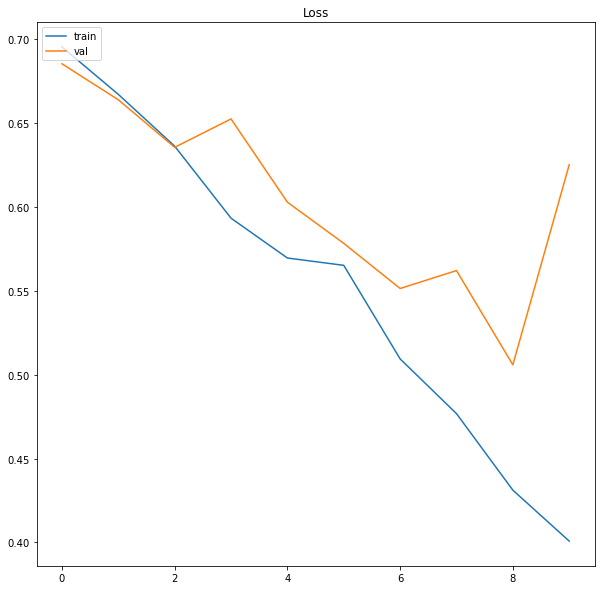

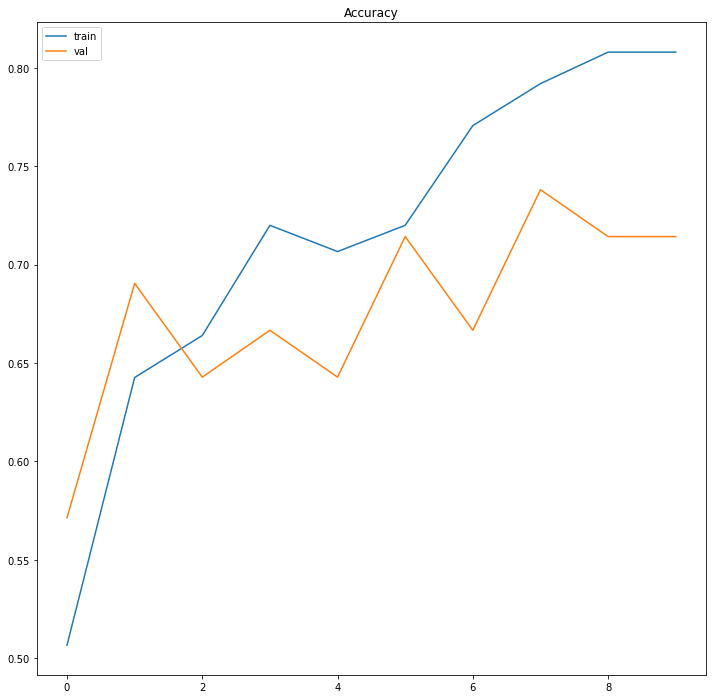

In [74]:
# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import confusion_matrix

In [75]:
y_predict = model.predict(x_test, batch_size=None, verbose=0, steps=None)
y_predict

array([[0.15468639],
       [0.34686798],
       [0.17976654],
       [0.8085204 ],
       [0.19439   ],
       [0.4846245 ],
       [0.56823343],
       [0.53011316],
       [0.43440178],
       [0.9581603 ],
       [0.8801096 ],
       [0.12003237],
       [0.9037895 ],
       [0.36866954],
       [0.81536984],
       [0.21324265],
       [0.14255038],
       [0.14286354],
       [0.34815997],
       [0.1480189 ],
       [0.5312662 ],
       [0.35962498],
       [0.41602543],
       [0.40092915],
       [0.27244312],
       [0.94575953],
       [0.8060272 ],
       [0.16046464],
       [0.37050563],
       [0.1736696 ],
       [0.2196055 ],
       [0.32890064],
       [0.13578129],
       [0.18231016],
       [0.6712101 ],
       [0.3005527 ],
       [0.12590337],
       [0.10488576],
       [0.13121182],
       [0.7110986 ],
       [0.53084975],
       [0.19122013],
       [0.8267224 ],
       [0.9317435 ],
       [0.27173585],
       [0.13703305],
       [0.16968927],
       [0.118

In [78]:
predict = []
for i in range(len(y_predict)):
    if y_predict[i] > 0.5:
        predict.append(1)
    else:
        predict.append(0)
        
predict

[0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [79]:
# confusion matrix
matrix = confusion_matrix(y_test,predict, labels=[1,0])
print("accuracy score:", accuracy_score(y_test, predict))
print('Confusion matrix : \n',matrix)

accuracy score: 0.6741573033707865
Confusion matrix : 
 [[34 54]
 [ 4 86]]


In [80]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test,predict,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.89      0.39      0.54        88
           0       0.61      0.96      0.75        90

    accuracy                           0.67       178
   macro avg       0.75      0.67      0.64       178
weighted avg       0.75      0.67      0.64       178



In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.68888889 0.31111111]
 [0.35227273 0.64772727]]


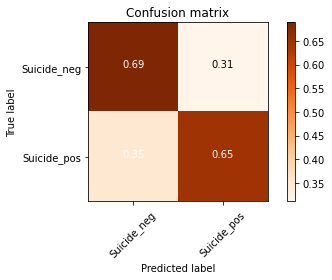

In [45]:
y_pred = predict

#y_pred = convert_to_labels(y_predict)
y_true = y_test
target_names = [ 'Suicide_neg','Suicide_pos']
#print(classification_report(y_true, y_pred, target_names=target_names))

plt.figure()
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True)

plt.show()

In [81]:
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl

## Draw line with BERT

In [88]:
# BERT
true=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predictions=[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

<Figure size 432x288 with 0 Axes>

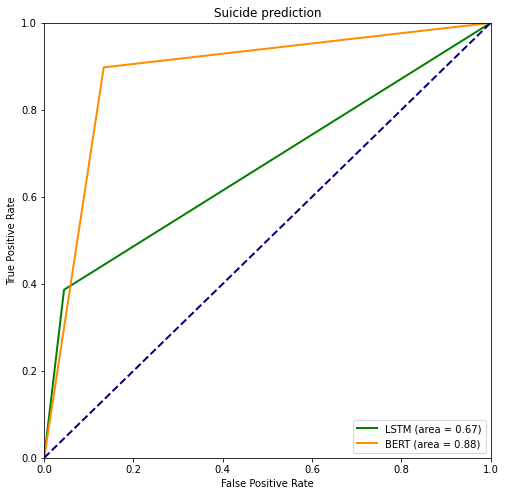

In [92]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test,predict) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值

# BERT
fpr2,tpr2,threshold = roc_curve(true,predictions)
roc_auc2 = auc(fpr2,tpr2)

 # In[*]
plt.figure()
lw = 2
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='green',
         lw=lw, label='LSTM (area = %0.2f)' % roc_auc) ###假正率爲橫座標，真正率爲縱座標做曲線
plt.plot(fpr2, tpr2, color='darkorange',
         lw=lw, label='BERT (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Suicide prediction')
plt.legend(loc="lower right")
plt.show()